In [1]:
import os
import librosa
import numpy as np
import pandas as pd

In [2]:
def extract_audio_features(file_path):
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=16000)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Extract pitch and energy
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
        avg_pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        avg_energy = np.mean(magnitudes)
        
        return mfccs_mean.tolist(), avg_pitch, avg_energy
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [np.nan] * 13, np.nan, np.nan

In [3]:
# Path to MELD audio files (train set)
audio_folder = r'datasets/raw/MELD/train/audio'

# Load MELD dataset (train set)
data = pd.read_csv(r'datasets/raw/MELD/train/train_sent_emo.csv')

# Generate file paths for audio files
data['Audio_Path'] = data['Dialogue_ID'].astype(str) + '_utt' + data['Utterance_ID'].astype(str) + '.wav'
data['Audio_Path'] = data['Audio_Path'].apply(lambda x: os.path.join(audio_folder, x))

In [4]:
# Correct file path construction
data['Audio_Path'] = 'dia' + data['Dialogue_ID'].astype(str) + '_utt' + data['Utterance_ID'].astype(str) + '.wav'
data['Audio_Path'] = data['Audio_Path'].apply(lambda x: os.path.join(audio_folder, x))

In [5]:
audio_features = []
for file_path in data['Audio_Path']:
    mfccs, avg_pitch, avg_energy = extract_audio_features(file_path)
    audio_features.append(mfccs + [avg_pitch, avg_energy])

c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
C:\Users\rajt8\AppData\Local\Temp\ipykernel_22408\2737565455.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=16000)
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file datasets/raw/MELD/train/audio\dia125_utt3.wav: [Errno 2] No such file or directory: 'datasets/raw/MELD/train/audio\\dia125_utt3.wav'


In [6]:
# Convert to DataFrame and merge with original data
audio_features_df = pd.DataFrame(audio_features, columns=[f'MFCC_{i}' for i in range(13)] + ['Average_Pitch', 'Average_Energy'])
data = pd.concat([data, audio_features_df], axis=1)

In [7]:
# Save processed dataset
data.to_csv(r'datasets/processed/meld_audio_features.csv', index=False)
print("Audio features extracted and dataset saved!")


Audio features extracted and dataset saved!


In [8]:
from sklearn.model_selection import train_test_split

# Drop rows with missing values
data = data.dropna()

# Separate features and labels
X_audio = data[[f'MFCC_{i}' for i in range(13)] + ['Average_Pitch', 'Average_Energy']].values
y_audio = data['Emotion'].values

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_audio, test_size=0.3, stratify=y_audio, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display dataset sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6991
Validation set size: 1498
Test set size: 1499


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest
rf_audio_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_audio_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_audio_model.predict(X_val)
print("\nRandom Forest on Audio Features Validation Results:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")


Random Forest on Audio Features Validation Results:
              precision    recall  f1-score   support

       anger       0.23      0.05      0.09       166
     disgust       0.00      0.00      0.00        41
        fear       0.00      0.00      0.00        40
         joy       0.33      0.07      0.11       261
     neutral       0.49      0.97      0.65       706
     sadness       0.00      0.00      0.00       103
    surprise       0.31      0.02      0.04       181

    accuracy                           0.48      1498
   macro avg       0.19      0.16      0.13      1498
weighted avg       0.35      0.48      0.34      1498

Validation Accuracy: 0.4753


c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set size after SMOTE: {X_train_resampled.shape[0]}")

Training set size after SMOTE: 23072


In [11]:
# Train Random Forest with class weights
class_weights = 'balanced'  
rf_weighted = RandomForestClassifier(random_state=42, n_estimators=100, class_weight=class_weights)
rf_weighted.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_weighted = rf_weighted.predict(X_val)
print("\nRandom Forest with Class Weights Validation Results:")
print(classification_report(y_val, y_val_pred_weighted))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_weighted):.4f}")


Random Forest with Class Weights Validation Results:
              precision    recall  f1-score   support

       anger       0.32      0.04      0.07       166
     disgust       0.00      0.00      0.00        41
        fear       0.00      0.00      0.00        40
         joy       0.19      0.01      0.02       261
     neutral       0.48      0.98      0.64       706
     sadness       0.00      0.00      0.00       103
    surprise       0.43      0.02      0.03       181

    accuracy                           0.47      1498
   macro avg       0.20      0.15      0.11      1498
weighted avg       0.34      0.47      0.32      1498

Validation Accuracy: 0.4693


c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Map original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")

Label Mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train XGBoost on resampled data
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_encoded)

# Evaluate on validation set
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_pred_xgb_decoded = label_encoder.inverse_transform(y_val_pred_xgb)  # Decode predictions back to string labels

print("\nXGBoost Validation Results:")
print(classification_report(y_val, y_val_pred_xgb_decoded))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_xgb_decoded):.4f}")

c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Validation Results:
              precision    recall  f1-score   support

       anger       0.16      0.20      0.18       166
     disgust       0.02      0.02      0.02        41
        fear       0.04      0.05      0.04        40
         joy       0.21      0.21      0.21       261
     neutral       0.54      0.45      0.49       706
     sadness       0.14      0.18      0.16       103
    surprise       0.14      0.14      0.14       181

    accuracy                           0.30      1498
   macro avg       0.18      0.18      0.18      1498
weighted avg       0.34      0.30      0.32      1498

Validation Accuracy: 0.3024


In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train_resampled, y_train_encoded)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_val_pred_best = best_model.predict(X_val)
y_val_pred_best_decoded = label_encoder.inverse_transform(y_val_pred_best)

print("\nBest XGBoost Validation Results:")
print(classification_report(y_val, y_val_pred_best_decoded))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_best_decoded):.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=5, n_e

In [15]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Define the folder for spectrogram images
spectrogram_folder = r'datasets/processed/audio/features/spectrograms'
os.makedirs(spectrogram_folder, exist_ok=True)

# Function to generate and save spectrogram
def generate_spectrogram(file_path, output_path):
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=16000)

        # Create a mel spectrogram
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        # Plot and save the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Generate spectrograms for all audio files
for idx, file_path in enumerate(data['Audio_Path']):
    if os.path.exists(file_path):
        output_path = os.path.join(spectrogram_folder, f"spectrogram_{idx}.png")
        generate_spectrogram(file_path, output_path)
    else:
        print(f"File not found: {file_path}")

print("Spectrogram generation complete!")

c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(
c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


Spectrogram generation complete!


In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Resize all images to a fixed size 
IMG_SIZE = (128, 128)

# Initialize lists for data and labels
X_images = []
y_images = []

# Process images in batches
for idx, file_path in enumerate(data['Audio_Path']):
    spectrogram_path = os.path.join(spectrogram_folder, f"spectrogram_{idx}.png")
    if os.path.exists(spectrogram_path):
        try:
            # Load and resize the image
            img = load_img(spectrogram_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            X_images.append(img_array)
            y_images.append(data['Emotion'].iloc[idx])

            # Print progress every 100 files
            if idx % 100 == 0:
                print(f"Processed {idx} files...")
        except Exception as e:
            print(f"Error processing {spectrogram_path}: {e}")
    else:
        print(f"File not found: {spectrogram_path}")

# Convert to numpy arrays
X_images = np.array(X_images)
y_images = np.array(y_images)

print(f"Processed {len(X_images)} spectrograms.")

Processed 0 files...
Processed 100 files...
Processed 200 files...
Processed 300 files...
Processed 400 files...
Processed 500 files...
Processed 600 files...
Processed 700 files...
Processed 800 files...
Processed 900 files...
Processed 1000 files...
Processed 1100 files...
Processed 1200 files...
Processed 1300 files...
Processed 1400 files...
Processed 1500 files...
Processed 1600 files...
Processed 1700 files...
Processed 1800 files...
Processed 1900 files...
Processed 2000 files...
Processed 2100 files...
Processed 2200 files...
Processed 2300 files...
Processed 2400 files...
Processed 2500 files...
Processed 2600 files...
Processed 2700 files...
Processed 2800 files...
Processed 2900 files...
Processed 3000 files...
Processed 3100 files...
Processed 3200 files...
Processed 3300 files...
Processed 3400 files...
Processed 3500 files...
Processed 3600 files...
Processed 3700 files...
Processed 3800 files...
Processed 3900 files...
Processed 4000 files...
Processed 4100 files...
Proc

In [17]:
np.save('datasets/processed/audio/X_images.npy', X_images)
np.save('datasets/processed/audio/y_images.npy', y_images)
print("Spectrogram data saved!")

Spectrogram data saved!


In [18]:
X_images = np.load('datasets/processed/audio/X_images.npy')
y_images = np.load('datasets/processed/audio/y_images.npy')
print("Spectrogram data loaded!")

Spectrogram data loaded!


In [19]:
from sklearn.preprocessing import LabelBinarizer

# Encode class labels
lb = LabelBinarizer()
y_images_encoded = lb.fit_transform(y_images) 

print(f"Classes: {lb.classes_}")
print(f"Encoded labels shape: {y_images_encoded.shape}")

Classes: ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
Encoded labels shape: (9988, 7)


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Training and validation generators
train_generator = datagen.flow(X_images, y_images_encoded, subset='training', batch_size=32)
val_generator = datagen.flow(X_images, y_images_encoded, subset='validation', batch_size=32)

print("Data generators created!")

Data generators created!


In [21]:
# Inspect the shapes of the generated batches
x_batch, y_batch = next(train_generator)
print(f"Input batch shape: {x_batch.shape}")
print(f"Label batch shape: {y_batch.shape}")

Input batch shape: (32, 128, 128, 3)
Label batch shape: (32, 7)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the CNN
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  
    batch_size=32,
    verbose=1
)

Epoch 1/20


c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 455ms/step - accuracy: 0.4320 - loss: 2.2366 - val_accuracy: 0.4717 - val_loss: 1.6499
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 460ms/step - accuracy: 0.4605 - loss: 1.5711 - val_accuracy: 0.4717 - val_loss: 1.5777
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 458ms/step - accuracy: 0.4715 - loss: 1.5313 - val_accuracy: 0.4717 - val_loss: 1.5249
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 460ms/step - accuracy: 0.4714 - loss: 1.5337 - val_accuracy: 0.4717 - val_loss: 1.5360
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 459ms/step - accuracy: 0.4753 - loss: 1.5188 - val_accuracy: 0.4717 - val_loss: 1.5205
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 454ms/step - accuracy: 0.4618 - loss: 1.5343 - val_accuracy: 0.4717 - val_loss: 1.5071
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 451ms/step - accuracy: 0.4692 - loss: 1.5128 - val_accuracy: 0.4717 - val_loss: 1.5065
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 448ms/step - accuracy: 0.4749 - loss: 1.50

In [24]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4564 - loss: 1.5767
Validation Loss: 1.5977
Validation Accuracy: 0.4602


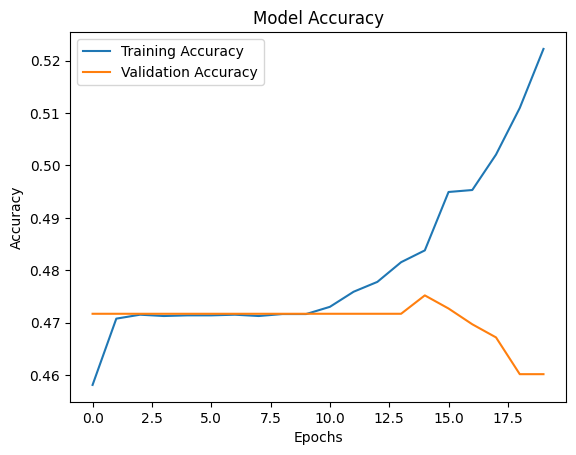

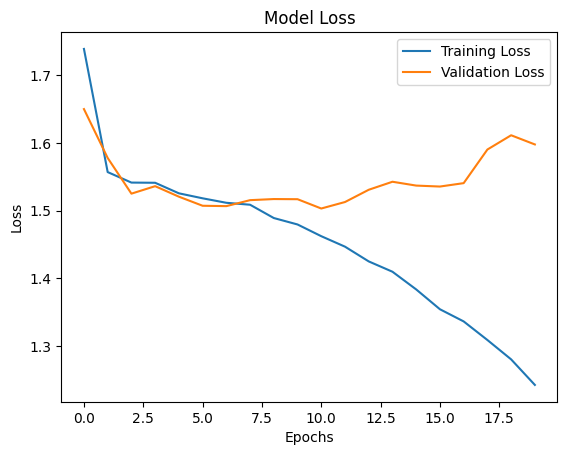

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
!pip install noisereduce librosa numpy soundfile

In [28]:
import os
import librosa
import noisereduce as nr
import numpy as np
import soundfile as sf
from tqdm import tqdm

# Paths
AUDIO_INPUT_FOLDER = r'datasets/raw/MELD/train/audio'
AUDIO_OUTPUT_FOLDER = r'datasets/processed/audio/noise_reduced'

# Ensure the output directory exists
os.makedirs(AUDIO_OUTPUT_FOLDER, exist_ok=True)

# Function to apply noise reduction using spectral gating
def reduce_noise(audio_path, output_path):
    try:
        # Load the audio file
        audio, sr = librosa.load(audio_path, sr=16000)

        # Perform noise reduction
        reduced_audio = nr.reduce_noise(y=audio, sr=sr, stationary=True)

        # Save the noise-reduced audio file
        sf.write(output_path, reduced_audio, sr)

        print(f"Processed: {os.path.basename(audio_path)}")
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Process all audio files in the directory
for file in tqdm(os.listdir(AUDIO_INPUT_FOLDER)):
    if file.endswith('.wav'):
        input_path = os.path.join(AUDIO_INPUT_FOLDER, file)
        output_path = os.path.join(AUDIO_OUTPUT_FOLDER, file)
        reduce_noise(input_path, output_path)

print("Noise reduction process completed!")

  0%|          | 3/9988 [00:00<13:24, 12.41it/s]

Processed: dia0_utt0.wav
Processed: dia0_utt1.wav
Processed: dia0_utt10.wav


  0%|          | 5/9988 [00:00<14:39, 11.35it/s]

Processed: dia0_utt11.wav
Processed: dia0_utt12.wav
Processed: dia0_utt13.wav


  0%|          | 9/9988 [00:00<14:14, 11.68it/s]

Processed: dia0_utt2.wav
Processed: dia0_utt3.wav
Processed: dia0_utt4.wav


  0%|          | 11/9988 [00:00<13:29, 12.32it/s]

Processed: dia0_utt5.wav
Processed: dia0_utt6.wav
Processed: dia0_utt7.wav


  0%|          | 15/9988 [00:01<12:44, 13.04it/s]

Processed: dia0_utt8.wav
Processed: dia0_utt9.wav
Processed: dia1000_utt0.wav
Processed: dia1000_utt1.wav


  0%|          | 19/9988 [00:01<12:05, 13.74it/s]

Processed: dia1000_utt2.wav
Processed: dia1000_utt3.wav
Processed: dia1001_utt0.wav


  0%|          | 21/9988 [00:01<12:34, 13.21it/s]

Processed: dia1001_utt1.wav
Processed: dia1001_utt10.wav
Processed: dia1001_utt11.wav


  0%|          | 25/9988 [00:01<12:32, 13.24it/s]

Processed: dia1001_utt2.wav
Processed: dia1001_utt3.wav
Processed: dia1001_utt4.wav


  0%|          | 27/9988 [00:02<12:16, 13.52it/s]

Processed: dia1001_utt5.wav
Processed: dia1001_utt6.wav
Processed: dia1001_utt7.wav
Processed: dia1001_utt8.wav


  0%|          | 33/9988 [00:02<10:36, 15.65it/s]

Processed: dia1001_utt9.wav
Processed: dia1002_utt0.wav
Processed: dia1002_utt1.wav
Processed: dia1002_utt2.wav


  0%|          | 35/9988 [00:02<10:45, 15.43it/s]

Processed: dia1002_utt3.wav
Processed: dia1002_utt4.wav
Processed: dia1002_utt5.wav


  0%|          | 39/9988 [00:02<10:53, 15.22it/s]

Processed: dia1003_utt0.wav
Processed: dia1003_utt1.wav
Processed: dia1003_utt2.wav
Processed: dia1003_utt3.wav


  0%|          | 43/9988 [00:03<11:31, 14.39it/s]

Processed: dia1003_utt4.wav
Processed: dia1003_utt5.wav
Processed: dia1003_utt6.wav


  0%|          | 45/9988 [00:03<11:24, 14.52it/s]

Processed: dia1003_utt7.wav
Processed: dia1004_utt0.wav
Processed: dia1004_utt1.wav


  0%|          | 49/9988 [00:03<11:13, 14.75it/s]

Processed: dia1004_utt2.wav
Processed: dia1005_utt0.wav
Processed: dia1005_utt1.wav
Processed: dia1005_utt10.wav


  1%|          | 53/9988 [00:03<11:15, 14.70it/s]

Processed: dia1005_utt11.wav
Processed: dia1005_utt12.wav
Processed: dia1005_utt13.wav
Processed: dia1005_utt14.wav


  1%|          | 57/9988 [00:04<11:55, 13.89it/s]

Processed: dia1005_utt15.wav
Processed: dia1005_utt16.wav
Processed: dia1005_utt17.wav


  1%|          | 61/9988 [00:04<11:08, 14.84it/s]

Processed: dia1005_utt18.wav
Processed: dia1005_utt19.wav
Processed: dia1005_utt2.wav
Processed: dia1005_utt20.wav


  1%|          | 65/9988 [00:04<11:07, 14.87it/s]

Processed: dia1005_utt21.wav
Processed: dia1005_utt3.wav
Processed: dia1005_utt4.wav
Processed: dia1005_utt5.wav


  1%|          | 67/9988 [00:04<11:06, 14.89it/s]

Processed: dia1005_utt6.wav
Processed: dia1005_utt7.wav
Processed: dia1005_utt8.wav


  1%|          | 71/9988 [00:05<11:57, 13.83it/s]

Processed: dia1005_utt9.wav
Processed: dia1006_utt0.wav
Processed: dia1006_utt1.wav


  1%|          | 73/9988 [00:05<11:55, 13.85it/s]

Processed: dia1006_utt2.wav
Processed: dia1006_utt3.wav
Processed: dia1006_utt4.wav
Processed: dia1006_utt5.wav


  1%|          | 79/9988 [00:05<10:17, 16.05it/s]

Processed: dia1007_utt0.wav
Processed: dia1007_utt1.wav
Processed: dia1007_utt10.wav
Processed: dia1007_utt11.wav
Processed: dia1007_utt12.wav


  1%|          | 83/9988 [00:05<11:19, 14.58it/s]

Processed: dia1007_utt13.wav
Processed: dia1007_utt14.wav
Processed: dia1007_utt15.wav


  1%|          | 85/9988 [00:06<12:24, 13.31it/s]

Processed: dia1007_utt2.wav
Processed: dia1007_utt3.wav
Processed: dia1007_utt4.wav


  1%|          | 89/9988 [00:06<13:13, 12.47it/s]

Processed: dia1007_utt5.wav
Processed: dia1007_utt6.wav
Processed: dia1007_utt7.wav


  1%|          | 91/9988 [00:06<12:31, 13.17it/s]

Processed: dia1007_utt8.wav
Processed: dia1007_utt9.wav
Processed: dia1008_utt0.wav


  1%|          | 95/9988 [00:06<12:05, 13.64it/s]

Processed: dia1008_utt1.wav
Processed: dia1008_utt2.wav
Processed: dia1008_utt3.wav
Processed: dia1008_utt4.wav
Processed: dia1008_utt5.wav


  1%|          | 101/9988 [00:07<10:04, 16.34it/s]

Processed: dia1008_utt6.wav
Processed: dia1008_utt7.wav
Processed: dia1008_utt8.wav
Processed: dia1008_utt9.wav


  1%|          | 105/9988 [00:07<10:35, 15.54it/s]

Processed: dia1009_utt0.wav
Processed: dia1009_utt1.wav
Processed: dia1009_utt10.wav
Processed: dia1009_utt11.wav


  1%|          | 107/9988 [00:07<10:29, 15.70it/s]

Processed: dia1009_utt12.wav
Processed: dia1009_utt13.wav
Processed: dia1009_utt14.wav
Processed: dia1009_utt15.wav


  1%|          | 113/9988 [00:07<10:04, 16.33it/s]

Processed: dia1009_utt16.wav
Processed: dia1009_utt17.wav
Processed: dia1009_utt18.wav
Processed: dia1009_utt2.wav


  1%|          | 117/9988 [00:08<09:37, 17.09it/s]

Processed: dia1009_utt3.wav
Processed: dia1009_utt4.wav
Processed: dia1009_utt5.wav
Processed: dia1009_utt6.wav


  1%|          | 119/9988 [00:08<10:59, 14.96it/s]

Processed: dia1009_utt7.wav
Processed: dia1009_utt8.wav
Processed: dia1009_utt9.wav


  1%|          | 123/9988 [00:08<11:25, 14.40it/s]

Processed: dia100_utt0.wav
Processed: dia100_utt1.wav
Processed: dia100_utt2.wav


  1%|▏         | 125/9988 [00:08<12:13, 13.44it/s]

Processed: dia100_utt3.wav
Processed: dia100_utt4.wav
Processed: dia100_utt5.wav


  1%|▏         | 129/9988 [00:09<11:28, 14.31it/s]

Processed: dia100_utt6.wav
Processed: dia100_utt7.wav
Processed: dia1010_utt0.wav
Processed: dia1010_utt1.wav


  1%|▏         | 133/9988 [00:09<11:43, 14.01it/s]

Processed: dia1010_utt10.wav
Processed: dia1010_utt11.wav
Processed: dia1010_utt2.wav
Processed: dia1010_utt3.wav


  1%|▏         | 136/9988 [00:09<10:38, 15.42it/s]

Processed: dia1010_utt4.wav
Processed: dia1010_utt5.wav
Processed: dia1010_utt6.wav
Processed: dia1010_utt7.wav


  1%|▏         | 141/9988 [00:09<11:07, 14.74it/s]

Processed: dia1010_utt8.wav
Processed: dia1010_utt9.wav
Processed: dia1011_utt0.wav


  1%|▏         | 143/9988 [00:09<11:27, 14.32it/s]

Processed: dia1011_utt1.wav
Processed: dia1011_utt10.wav
Processed: dia1011_utt11.wav


  1%|▏         | 147/9988 [00:10<12:05, 13.56it/s]

Processed: dia1011_utt12.wav
Processed: dia1011_utt2.wav
Processed: dia1011_utt3.wav
Processed: dia1011_utt4.wav


  2%|▏         | 151/9988 [00:10<11:13, 14.60it/s]

Processed: dia1011_utt5.wav
Processed: dia1011_utt6.wav
Processed: dia1011_utt7.wav
Processed: dia1011_utt8.wav


  2%|▏         | 155/9988 [00:10<11:28, 14.27it/s]

Processed: dia1011_utt9.wav
Processed: dia1012_utt0.wav
Processed: dia1012_utt1.wav
Processed: dia1012_utt10.wav


  2%|▏         | 158/9988 [00:11<10:27, 15.67it/s]

Processed: dia1012_utt11.wav
Processed: dia1012_utt2.wav
Processed: dia1012_utt3.wav


  2%|▏         | 163/9988 [00:11<09:53, 16.55it/s]

Processed: dia1012_utt4.wav
Processed: dia1012_utt5.wav
Processed: dia1012_utt6.wav
Processed: dia1012_utt7.wav


  2%|▏         | 167/9988 [00:11<10:12, 16.02it/s]

Processed: dia1012_utt8.wav
Processed: dia1012_utt9.wav
Processed: dia1013_utt0.wav
Processed: dia1013_utt1.wav


  2%|▏         | 169/9988 [00:11<10:38, 15.37it/s]

Processed: dia1013_utt2.wav
Processed: dia1013_utt3.wav
Processed: dia1014_utt0.wav


  2%|▏         | 173/9988 [00:11<10:48, 15.13it/s]

Processed: dia1014_utt1.wav
Processed: dia1014_utt2.wav
Processed: dia1014_utt3.wav
Processed: dia1014_utt4.wav


  2%|▏         | 177/9988 [00:12<10:17, 15.88it/s]

Processed: dia1015_utt0.wav
Processed: dia1015_utt1.wav
Processed: dia1015_utt2.wav
Processed: dia1015_utt3.wav


  2%|▏         | 181/9988 [00:12<09:51, 16.57it/s]

Processed: dia1015_utt4.wav
Processed: dia1015_utt5.wav
Processed: dia1015_utt6.wav
Processed: dia1015_utt7.wav


  2%|▏         | 185/9988 [00:12<09:39, 16.92it/s]

Processed: dia1015_utt8.wav
Processed: dia1015_utt9.wav
Processed: dia1016_utt0.wav
Processed: dia1016_utt1.wav


  2%|▏         | 189/9988 [00:12<10:21, 15.77it/s]

Processed: dia1016_utt10.wav
Processed: dia1016_utt11.wav
Processed: dia1016_utt12.wav
Processed: dia1016_utt13.wav


  2%|▏         | 193/9988 [00:13<11:08, 14.65it/s]

Processed: dia1016_utt14.wav
Processed: dia1016_utt15.wav
Processed: dia1016_utt16.wav
Processed: dia1016_utt17.wav


  2%|▏         | 197/9988 [00:13<11:44, 13.89it/s]

Processed: dia1016_utt18.wav
Processed: dia1016_utt19.wav
Processed: dia1016_utt2.wav


  2%|▏         | 201/9988 [00:13<11:27, 14.24it/s]

Processed: dia1016_utt20.wav
Processed: dia1016_utt21.wav
Processed: dia1016_utt3.wav
Processed: dia1016_utt4.wav


  2%|▏         | 205/9988 [00:14<11:19, 14.39it/s]

Processed: dia1016_utt5.wav
Processed: dia1016_utt6.wav
Processed: dia1016_utt7.wav
Processed: dia1016_utt8.wav


  2%|▏         | 209/9988 [00:14<09:59, 16.31it/s]

Processed: dia1016_utt9.wav
Processed: dia1017_utt0.wav
Processed: dia1017_utt1.wav
Processed: dia1017_utt10.wav


  2%|▏         | 213/9988 [00:14<09:51, 16.52it/s]

Processed: dia1017_utt11.wav
Processed: dia1017_utt12.wav
Processed: dia1017_utt13.wav
Processed: dia1017_utt2.wav


  2%|▏         | 217/9988 [00:14<10:23, 15.67it/s]

Processed: dia1017_utt3.wav
Processed: dia1017_utt4.wav
Processed: dia1017_utt5.wav
Processed: dia1017_utt6.wav


  2%|▏         | 219/9988 [00:14<10:54, 14.92it/s]

Processed: dia1017_utt7.wav
Processed: dia1017_utt8.wav
Processed: dia1017_utt9.wav


  2%|▏         | 223/9988 [00:15<11:28, 14.19it/s]

Processed: dia1018_utt0.wav
Processed: dia1018_utt1.wav
Processed: dia1018_utt10.wav
Processed: dia1018_utt11.wav
Processed: dia1018_utt12.wav


  2%|▏         | 228/9988 [00:15<09:48, 16.59it/s]

Processed: dia1018_utt13.wav
Processed: dia1018_utt14.wav
Processed: dia1018_utt15.wav
Processed: dia1018_utt16.wav
Processed: dia1018_utt2.wav


  2%|▏         | 233/9988 [00:15<10:47, 15.07it/s]

Processed: dia1018_utt3.wav
Processed: dia1018_utt4.wav
Processed: dia1018_utt5.wav


  2%|▏         | 237/9988 [00:16<10:15, 15.85it/s]

Processed: dia1018_utt6.wav
Processed: dia1018_utt7.wav
Processed: dia1018_utt8.wav
Processed: dia1018_utt9.wav


  2%|▏         | 239/9988 [00:16<10:14, 15.85it/s]

Processed: dia1019_utt0.wav
Processed: dia1019_utt1.wav
Processed: dia1019_utt10.wav


  2%|▏         | 243/9988 [00:16<12:08, 13.38it/s]

Processed: dia1019_utt11.wav
Processed: dia1019_utt12.wav
Processed: dia1019_utt13.wav


  2%|▏         | 247/9988 [00:16<11:36, 13.98it/s]

Processed: dia1019_utt14.wav
Processed: dia1019_utt15.wav
Processed: dia1019_utt16.wav
Processed: dia1019_utt2.wav


  2%|▏         | 249/9988 [00:17<11:43, 13.85it/s]

Processed: dia1019_utt3.wav
Processed: dia1019_utt4.wav
Processed: dia1019_utt5.wav


  3%|▎         | 253/9988 [00:17<11:23, 14.25it/s]

Processed: dia1019_utt6.wav
Processed: dia1019_utt7.wav
Processed: dia1019_utt8.wav
Processed: dia1019_utt9.wav


  3%|▎         | 257/9988 [00:17<11:45, 13.79it/s]

Processed: dia101_utt0.wav
Processed: dia101_utt1.wav
Processed: dia1020_utt0.wav


  3%|▎         | 259/9988 [00:17<11:40, 13.89it/s]

Processed: dia1020_utt1.wav
Processed: dia1020_utt2.wav
Processed: dia1020_utt3.wav


  3%|▎         | 263/9988 [00:18<11:38, 13.92it/s]

Processed: dia1020_utt4.wav
Processed: dia1020_utt5.wav
Processed: dia1020_utt6.wav
Processed: dia1021_utt0.wav


  3%|▎         | 267/9988 [00:18<11:41, 13.87it/s]

Processed: dia1021_utt1.wav
Processed: dia1021_utt2.wav
Processed: dia1021_utt3.wav


  3%|▎         | 271/9988 [00:18<10:51, 14.92it/s]

Processed: dia1021_utt4.wav
Processed: dia1021_utt5.wav
Processed: dia1021_utt6.wav
Processed: dia1022_utt0.wav


  3%|▎         | 273/9988 [00:18<11:11, 14.46it/s]

Processed: dia1022_utt1.wav
Processed: dia1022_utt10.wav
Processed: dia1022_utt11.wav


  3%|▎         | 277/9988 [00:19<12:44, 12.71it/s]

Processed: dia1022_utt12.wav
Processed: dia1022_utt15.wav
Processed: dia1022_utt16.wav


  3%|▎         | 279/9988 [00:19<12:06, 13.36it/s]

Processed: dia1022_utt17.wav
Processed: dia1022_utt2.wav
Processed: dia1022_utt3.wav


  3%|▎         | 283/9988 [00:19<12:22, 13.07it/s]

Processed: dia1022_utt4.wav
Processed: dia1022_utt5.wav
Processed: dia1022_utt6.wav


  3%|▎         | 287/9988 [00:19<11:16, 14.34it/s]

Processed: dia1022_utt7.wav
Processed: dia1022_utt8.wav
Processed: dia1022_utt9.wav
Processed: dia1023_utt0.wav


  3%|▎         | 289/9988 [00:19<11:43, 13.80it/s]

Processed: dia1023_utt1.wav
Processed: dia1023_utt2.wav
Processed: dia1023_utt3.wav


  3%|▎         | 293/9988 [00:20<12:01, 13.44it/s]

Processed: dia1023_utt4.wav
Processed: dia1023_utt5.wav
Processed: dia1023_utt6.wav
Processed: dia1023_utt7.wav


  3%|▎         | 297/9988 [00:20<10:33, 15.30it/s]

Processed: dia1024_utt0.wav
Processed: dia1024_utt1.wav
Processed: dia1024_utt10.wav
Processed: dia1024_utt11.wav


  3%|▎         | 301/9988 [00:20<11:54, 13.56it/s]

Processed: dia1024_utt12.wav
Processed: dia1024_utt13.wav
Processed: dia1024_utt14.wav


  3%|▎         | 303/9988 [00:20<12:28, 12.94it/s]

Processed: dia1024_utt15.wav
Processed: dia1024_utt2.wav
Processed: dia1024_utt3.wav


  3%|▎         | 307/9988 [00:21<12:23, 13.01it/s]

Processed: dia1024_utt4.wav
Processed: dia1024_utt5.wav
Processed: dia1024_utt6.wav


  3%|▎         | 311/9988 [00:21<11:35, 13.92it/s]

Processed: dia1024_utt7.wav
Processed: dia1024_utt8.wav
Processed: dia1024_utt9.wav
Processed: dia1025_utt0.wav


  3%|▎         | 313/9988 [00:21<11:04, 14.56it/s]

Processed: dia1025_utt1.wav
Processed: dia1025_utt10.wav
Processed: dia1025_utt11.wav


  3%|▎         | 317/9988 [00:21<11:35, 13.91it/s]

Processed: dia1025_utt12.wav
Processed: dia1025_utt13.wav
Processed: dia1025_utt14.wav
Processed: dia1025_utt15.wav


  3%|▎         | 321/9988 [00:22<11:43, 13.74it/s]

Processed: dia1025_utt16.wav
Processed: dia1025_utt17.wav
Processed: dia1025_utt2.wav


  3%|▎         | 323/9988 [00:22<11:31, 13.97it/s]

Processed: dia1025_utt3.wav
Processed: dia1025_utt4.wav
Processed: dia1025_utt5.wav


  3%|▎         | 327/9988 [00:22<11:28, 14.03it/s]

Processed: dia1025_utt6.wav
Processed: dia1025_utt7.wav
Processed: dia1025_utt8.wav
Processed: dia1025_utt9.wav


  3%|▎         | 331/9988 [00:22<11:48, 13.62it/s]

Processed: dia1026_utt0.wav
Processed: dia1026_utt1.wav
Processed: dia1026_utt10.wav


  3%|▎         | 335/9988 [00:23<11:21, 14.17it/s]

Processed: dia1026_utt11.wav
Processed: dia1026_utt12.wav
Processed: dia1026_utt13.wav
Processed: dia1026_utt14.wav


  3%|▎         | 337/9988 [00:23<11:13, 14.33it/s]

Processed: dia1026_utt15.wav
Processed: dia1026_utt2.wav
Processed: dia1026_utt3.wav


  3%|▎         | 341/9988 [00:23<11:26, 14.06it/s]

Processed: dia1026_utt4.wav
Processed: dia1026_utt5.wav
Processed: dia1026_utt6.wav


  3%|▎         | 345/9988 [00:23<10:32, 15.24it/s]

Processed: dia1026_utt7.wav
Processed: dia1026_utt8.wav
Processed: dia1026_utt9.wav
Processed: dia1027_utt0.wav


  3%|▎         | 347/9988 [00:24<11:37, 13.82it/s]

Processed: dia1027_utt1.wav
Processed: dia1027_utt2.wav
Processed: dia1027_utt3.wav


  4%|▎         | 351/9988 [00:24<12:34, 12.77it/s]

Processed: dia1027_utt4.wav
Processed: dia1027_utt5.wav
Processed: dia1027_utt6.wav


  4%|▎         | 353/9988 [00:24<12:44, 12.60it/s]

Processed: dia1028_utt0.wav
Processed: dia1028_utt1.wav
Processed: dia1028_utt2.wav


  4%|▎         | 357/9988 [00:24<12:13, 13.14it/s]

Processed: dia1028_utt3.wav
Processed: dia1028_utt4.wav
Processed: dia1028_utt5.wav


  4%|▎         | 359/9988 [00:25<14:03, 11.41it/s]

Processed: dia1029_utt0.wav
Processed: dia1029_utt1.wav


  4%|▎         | 361/9988 [00:25<13:51, 11.57it/s]

Processed: dia1029_utt10.wav
Processed: dia1029_utt11.wav
Processed: dia1029_utt12.wav


  4%|▎         | 365/9988 [00:25<12:12, 13.14it/s]

Processed: dia1029_utt13.wav
Processed: dia1029_utt14.wav
Processed: dia1029_utt2.wav
Processed: dia1029_utt3.wav


  4%|▎         | 369/9988 [00:25<10:32, 15.20it/s]

Processed: dia1029_utt4.wav
Processed: dia1029_utt5.wav
Processed: dia1029_utt6.wav
Processed: dia1029_utt7.wav


  4%|▎         | 373/9988 [00:26<13:21, 11.99it/s]

Processed: dia1029_utt8.wav
Processed: dia1029_utt9.wav
Processed: dia102_utt0.wav


  4%|▍         | 377/9988 [00:26<12:14, 13.08it/s]

Processed: dia102_utt1.wav
Processed: dia102_utt2.wav
Processed: dia1030_utt0.wav
Processed: dia1030_utt1.wav


  4%|▍         | 379/9988 [00:26<11:49, 13.55it/s]

Processed: dia1030_utt2.wav
Processed: dia1030_utt3.wav
Processed: dia1030_utt4.wav


  4%|▍         | 383/9988 [00:26<11:58, 13.37it/s]

Processed: dia1030_utt5.wav
Processed: dia1031_utt0.wav
Processed: dia1031_utt1.wav


  4%|▍         | 385/9988 [00:27<12:19, 12.99it/s]

Processed: dia1031_utt2.wav
Processed: dia1031_utt3.wav
Processed: dia1032_utt0.wav


  4%|▍         | 389/9988 [00:27<11:30, 13.89it/s]

Processed: dia1032_utt1.wav
Processed: dia1032_utt10.wav
Processed: dia1032_utt11.wav


  4%|▍         | 391/9988 [00:27<11:53, 13.44it/s]

Processed: dia1032_utt2.wav
Processed: dia1032_utt3.wav
Processed: dia1032_utt4.wav


  4%|▍         | 395/9988 [00:27<12:49, 12.46it/s]

Processed: dia1032_utt5.wav
Processed: dia1032_utt6.wav
Processed: dia1032_utt7.wav


  4%|▍         | 397/9988 [00:27<12:13, 13.08it/s]

Processed: dia1032_utt8.wav
Processed: dia1032_utt9.wav
Processed: dia1033_utt0.wav


  4%|▍         | 401/9988 [00:28<11:49, 13.51it/s]

Processed: dia1033_utt1.wav
Processed: dia1033_utt2.wav
Processed: dia1033_utt3.wav


  4%|▍         | 405/9988 [00:28<11:04, 14.43it/s]

Processed: dia1034_utt0.wav
Processed: dia1034_utt1.wav
Processed: dia1034_utt2.wav
Processed: dia1035_utt0.wav


  4%|▍         | 409/9988 [00:28<10:47, 14.80it/s]

Processed: dia1035_utt1.wav
Processed: dia1035_utt2.wav
Processed: dia1035_utt3.wav
Processed: dia1035_utt4.wav


  4%|▍         | 411/9988 [00:28<11:05, 14.39it/s]

Processed: dia1035_utt5.wav
Processed: dia1035_utt6.wav
Processed: dia1036_utt0.wav


  4%|▍         | 415/9988 [00:29<10:55, 14.61it/s]

Processed: dia1036_utt1.wav
Processed: dia1036_utt10.wav
Processed: dia1036_utt11.wav
Processed: dia1036_utt12.wav


  4%|▍         | 419/9988 [00:29<10:32, 15.12it/s]

Processed: dia1036_utt13.wav
Processed: dia1036_utt14.wav
Processed: dia1036_utt15.wav


  4%|▍         | 423/9988 [00:29<10:38, 14.98it/s]

Processed: dia1036_utt16.wav
Processed: dia1036_utt17.wav
Processed: dia1036_utt18.wav
Processed: dia1036_utt19.wav


  4%|▍         | 425/9988 [00:29<10:59, 14.50it/s]

Processed: dia1036_utt2.wav
Processed: dia1036_utt20.wav
Processed: dia1036_utt3.wav


  4%|▍         | 429/9988 [00:30<10:42, 14.88it/s]

Processed: dia1036_utt4.wav
Processed: dia1036_utt5.wav
Processed: dia1036_utt6.wav


  4%|▍         | 433/9988 [00:30<10:21, 15.37it/s]

Processed: dia1036_utt7.wav
Processed: dia1036_utt8.wav
Processed: dia1036_utt9.wav
Processed: dia1037_utt0.wav


  4%|▍         | 437/9988 [00:30<10:28, 15.21it/s]

Processed: dia1037_utt1.wav
Processed: dia1037_utt2.wav
Processed: dia1038_utt0.wav
Processed: dia1038_utt1.wav


  4%|▍         | 439/9988 [00:30<11:29, 13.85it/s]

Processed: dia1038_utt10.wav
Processed: dia1038_utt11.wav
Processed: dia1038_utt12.wav


  4%|▍         | 443/9988 [00:31<11:16, 14.12it/s]

Processed: dia1038_utt13.wav
Processed: dia1038_utt14.wav
Processed: dia1038_utt15.wav
Processed: dia1038_utt16.wav


  4%|▍         | 447/9988 [00:31<11:46, 13.50it/s]

Processed: dia1038_utt17.wav
Processed: dia1038_utt2.wav
Processed: dia1038_utt3.wav


  4%|▍         | 449/9988 [00:31<11:56, 13.32it/s]

Processed: dia1038_utt4.wav
Processed: dia1038_utt5.wav
Processed: dia1038_utt6.wav


  5%|▍         | 453/9988 [00:31<11:20, 14.01it/s]

Processed: dia1038_utt7.wav
Processed: dia1038_utt8.wav
Processed: dia1038_utt9.wav


  5%|▍         | 455/9988 [00:32<12:12, 13.02it/s]

Processed: dia103_utt0.wav
Processed: dia103_utt1.wav
Processed: dia103_utt2.wav


  5%|▍         | 459/9988 [00:32<12:07, 13.10it/s]

Processed: dia103_utt3.wav
Processed: dia103_utt4.wav
Processed: dia103_utt5.wav
Processed: dia103_utt6.wav


  5%|▍         | 463/9988 [00:32<12:11, 13.03it/s]

Processed: dia103_utt7.wav
Processed: dia104_utt0.wav
Processed: dia104_utt1.wav
Processed: dia105_utt0.wav


  5%|▍         | 467/9988 [00:32<11:19, 14.01it/s]

Processed: dia105_utt1.wav
Processed: dia106_utt0.wav
Processed: dia106_utt1.wav


  5%|▍         | 471/9988 [00:33<11:08, 14.23it/s]

Processed: dia106_utt2.wav
Processed: dia106_utt3.wav
Processed: dia106_utt4.wav
Processed: dia106_utt5.wav


  5%|▍         | 473/9988 [00:33<10:52, 14.59it/s]

Processed: dia107_utt0.wav
Processed: dia107_utt1.wav
Processed: dia107_utt10.wav


  5%|▍         | 477/9988 [00:33<12:21, 12.82it/s]

Processed: dia107_utt2.wav
Processed: dia107_utt4.wav
Processed: dia107_utt5.wav
Processed: dia107_utt6.wav


  5%|▍         | 481/9988 [00:33<11:42, 13.53it/s]

Processed: dia107_utt7.wav
Processed: dia107_utt8.wav
Processed: dia107_utt9.wav


  5%|▍         | 483/9988 [00:34<12:19, 12.85it/s]

Processed: dia108_utt0.wav
Processed: dia108_utt1.wav
Processed: dia108_utt2.wav


  5%|▍         | 487/9988 [00:34<11:54, 13.29it/s]

Processed: dia108_utt3.wav
Processed: dia108_utt4.wav
Processed: dia108_utt5.wav


  5%|▍         | 491/9988 [00:34<12:10, 13.00it/s]

Processed: dia108_utt6.wav
Processed: dia109_utt0.wav
Processed: dia109_utt1.wav
Processed: dia109_utt10.wav


  5%|▍         | 493/9988 [00:34<11:50, 13.35it/s]

Processed: dia109_utt11.wav
Processed: dia109_utt12.wav
Processed: dia109_utt13.wav


  5%|▍         | 497/9988 [00:35<11:03, 14.31it/s]

Processed: dia109_utt14.wav
Processed: dia109_utt15.wav
Processed: dia109_utt16.wav
Processed: dia109_utt17.wav


  5%|▌         | 501/9988 [00:35<10:56, 14.45it/s]

Processed: dia109_utt18.wav
Processed: dia109_utt19.wav
Processed: dia109_utt20.wav
Processed: dia109_utt21.wav


  5%|▌         | 505/9988 [00:35<11:37, 13.60it/s]

Processed: dia109_utt3.wav
Processed: dia109_utt4.wav
Processed: dia109_utt5.wav


  5%|▌         | 507/9988 [00:35<11:41, 13.52it/s]

Processed: dia109_utt6.wav
Processed: dia109_utt7.wav
Processed: dia109_utt8.wav


  5%|▌         | 511/9988 [00:36<11:31, 13.70it/s]

Processed: dia109_utt9.wav
Processed: dia10_utt0.wav
Processed: dia10_utt1.wav
Processed: dia10_utt2.wav


  5%|▌         | 515/9988 [00:36<12:14, 12.90it/s]

Processed: dia10_utt3.wav
Processed: dia10_utt4.wav
Processed: dia10_utt5.wav
Processed: dia110_utt0.wav


  5%|▌         | 519/9988 [00:36<11:35, 13.61it/s]

Processed: dia110_utt1.wav
Processed: dia110_utt2.wav
Processed: dia110_utt3.wav
Processed: dia110_utt4.wav


  5%|▌         | 523/9988 [00:37<10:34, 14.91it/s]

Processed: dia110_utt5.wav
Processed: dia111_utt0.wav
Processed: dia111_utt1.wav
Processed: dia111_utt10.wav


  5%|▌         | 527/9988 [00:37<11:02, 14.27it/s]

Processed: dia111_utt11.wav
Processed: dia111_utt12.wav
Processed: dia111_utt13.wav


  5%|▌         | 529/9988 [00:37<17:23,  9.07it/s]

Processed: dia111_utt14.wav
Processed: dia111_utt15.wav
Processed: dia111_utt16.wav


  5%|▌         | 533/9988 [00:38<15:24, 10.23it/s]

Processed: dia111_utt17.wav
Processed: dia111_utt2.wav
Processed: dia111_utt3.wav


  5%|▌         | 535/9988 [00:38<14:59, 10.51it/s]

Processed: dia111_utt4.wav
Processed: dia111_utt5.wav
Processed: dia111_utt6.wav


  5%|▌         | 539/9988 [00:38<12:33, 12.55it/s]

Processed: dia111_utt7.wav
Processed: dia111_utt8.wav
Processed: dia111_utt9.wav
Processed: dia112_utt0.wav


  5%|▌         | 543/9988 [00:38<12:03, 13.05it/s]

Processed: dia112_utt1.wav
Processed: dia112_utt2.wav
Processed: dia112_utt3.wav


  5%|▌         | 545/9988 [00:38<12:29, 12.59it/s]

Processed: dia112_utt4.wav
Processed: dia113_utt0.wav
Processed: dia113_utt1.wav
Processed: dia113_utt10.wav


  6%|▌         | 551/9988 [00:39<11:27, 13.72it/s]

Processed: dia113_utt2.wav
Processed: dia113_utt3.wav
Processed: dia113_utt4.wav
Processed: dia113_utt5.wav


  6%|▌         | 553/9988 [00:39<11:23, 13.80it/s]

Processed: dia113_utt6.wav
Processed: dia113_utt7.wav
Processed: dia113_utt8.wav


  6%|▌         | 557/9988 [00:39<11:31, 13.63it/s]

Processed: dia113_utt9.wav
Processed: dia114_utt0.wav
Processed: dia114_utt1.wav


  6%|▌         | 559/9988 [00:39<11:37, 13.52it/s]

Processed: dia114_utt2.wav
Processed: dia114_utt3.wav
Processed: dia114_utt4.wav


  6%|▌         | 561/9988 [00:40<11:43, 13.40it/s]

Processed: dia115_utt0.wav
Processed: dia115_utt1.wav


  6%|▌         | 565/9988 [00:40<13:47, 11.39it/s]

Processed: dia115_utt2.wav
Processed: dia115_utt3.wav
Processed: dia115_utt4.wav


  6%|▌         | 567/9988 [00:40<13:15, 11.84it/s]

Processed: dia115_utt5.wav
Processed: dia115_utt6.wav
Processed: dia115_utt7.wav


  6%|▌         | 571/9988 [00:41<13:49, 11.36it/s]

Processed: dia116_utt0.wav
Processed: dia116_utt1.wav
Processed: dia116_utt2.wav


  6%|▌         | 573/9988 [00:41<13:40, 11.48it/s]

Processed: dia116_utt3.wav
Processed: dia116_utt4.wav


  6%|▌         | 575/9988 [00:41<14:57, 10.49it/s]

Processed: dia116_utt5.wav
Processed: dia116_utt6.wav


  6%|▌         | 577/9988 [00:41<15:01, 10.43it/s]

Processed: dia116_utt7.wav
Processed: dia117_utt0.wav
Processed: dia117_utt1.wav


  6%|▌         | 581/9988 [00:41<13:30, 11.61it/s]

Processed: dia117_utt2.wav
Processed: dia117_utt3.wav
Processed: dia118_utt0.wav


  6%|▌         | 583/9988 [00:42<12:44, 12.30it/s]

Processed: dia118_utt1.wav
Processed: dia118_utt2.wav
Processed: dia118_utt3.wav


  6%|▌         | 587/9988 [00:42<11:37, 13.47it/s]

Processed: dia118_utt4.wav
Processed: dia118_utt5.wav
Processed: dia119_utt0.wav
Processed: dia119_utt1.wav


  6%|▌         | 591/9988 [00:42<11:20, 13.81it/s]

Processed: dia119_utt10.wav
Processed: dia119_utt11.wav
Processed: dia119_utt12.wav


  6%|▌         | 593/9988 [00:42<11:28, 13.64it/s]

Processed: dia119_utt2.wav
Processed: dia119_utt3.wav
Processed: dia119_utt4.wav


  6%|▌         | 595/9988 [00:42<12:21, 12.68it/s]

Processed: dia119_utt5.wav
Processed: dia119_utt6.wav


  6%|▌         | 599/9988 [00:43<13:18, 11.76it/s]

Processed: dia119_utt7.wav
Processed: dia119_utt8.wav
Processed: dia119_utt9.wav


  6%|▌         | 601/9988 [00:43<12:31, 12.49it/s]

Processed: dia11_utt0.wav
Processed: dia11_utt1.wav
Processed: dia11_utt2.wav


  6%|▌         | 605/9988 [00:43<11:14, 13.92it/s]

Processed: dia11_utt3.wav
Processed: dia11_utt4.wav
Processed: dia11_utt5.wav
Processed: dia11_utt6.wav


  6%|▌         | 609/9988 [00:44<11:33, 13.52it/s]

Processed: dia11_utt7.wav
Processed: dia11_utt8.wav
Processed: dia11_utt9.wav


  6%|▌         | 611/9988 [00:44<12:00, 13.01it/s]

Processed: dia120_utt0.wav
Processed: dia120_utt1.wav
Processed: dia120_utt10.wav


  6%|▌         | 615/9988 [00:44<12:22, 12.63it/s]

Processed: dia120_utt11.wav
Processed: dia120_utt12.wav
Processed: dia120_utt13.wav


  6%|▌         | 619/9988 [00:44<11:20, 13.77it/s]

Processed: dia120_utt14.wav
Processed: dia120_utt15.wav
Processed: dia120_utt2.wav
Processed: dia120_utt3.wav


  6%|▌         | 623/9988 [00:45<10:38, 14.67it/s]

Processed: dia120_utt4.wav
Processed: dia120_utt7.wav
Processed: dia120_utt8.wav
Processed: dia120_utt9.wav


  6%|▋         | 625/9988 [00:45<11:10, 13.96it/s]

Processed: dia121_utt0.wav
Processed: dia121_utt1.wav
Processed: dia121_utt2.wav


  6%|▋         | 629/9988 [00:45<12:28, 12.50it/s]

Processed: dia121_utt4.wav
Processed: dia121_utt5.wav
Processed: dia121_utt6.wav


  6%|▋         | 631/9988 [00:45<13:09, 11.86it/s]

Processed: dia121_utt7.wav
Processed: dia122_utt0.wav
Processed: dia122_utt1.wav


  6%|▋         | 635/9988 [00:46<13:29, 11.56it/s]

Processed: dia122_utt10.wav
Processed: dia122_utt11.wav
Processed: dia122_utt12.wav


  6%|▋         | 637/9988 [00:46<14:50, 10.50it/s]

Processed: dia122_utt13.wav
Processed: dia122_utt14.wav
Processed: dia122_utt15.wav


  6%|▋         | 641/9988 [00:46<13:03, 11.93it/s]

Processed: dia122_utt2.wav
Processed: dia122_utt3.wav
Processed: dia122_utt4.wav


  6%|▋         | 643/9988 [00:46<12:45, 12.20it/s]

Processed: dia122_utt5.wav
Processed: dia122_utt6.wav
Processed: dia122_utt7.wav


  6%|▋         | 647/9988 [00:47<12:40, 12.29it/s]

Processed: dia122_utt8.wav
Processed: dia122_utt9.wav
Processed: dia123_utt0.wav


  7%|▋         | 651/9988 [00:47<11:25, 13.62it/s]

Processed: dia123_utt1.wav
Processed: dia123_utt10.wav
Processed: dia123_utt2.wav
Processed: dia123_utt3.wav


  7%|▋         | 653/9988 [00:47<12:05, 12.87it/s]

Processed: dia123_utt4.wav
Processed: dia123_utt5.wav
Processed: dia123_utt6.wav


  7%|▋         | 657/9988 [00:47<11:08, 13.95it/s]

Processed: dia123_utt7.wav
Processed: dia123_utt8.wav
Processed: dia123_utt9.wav
Processed: dia124_utt0.wav


  7%|▋         | 661/9988 [00:48<11:57, 13.01it/s]

Processed: dia124_utt1.wav
Processed: dia124_utt10.wav
Processed: dia124_utt11.wav


  7%|▋         | 663/9988 [00:48<11:26, 13.59it/s]

Processed: dia124_utt2.wav
Processed: dia124_utt3.wav
Processed: dia124_utt4.wav


  7%|▋         | 667/9988 [00:48<12:20, 12.59it/s]

Processed: dia124_utt5.wav
Processed: dia124_utt6.wav
Processed: dia124_utt7.wav


  7%|▋         | 669/9988 [00:48<11:49, 13.14it/s]

Processed: dia124_utt8.wav
Processed: dia124_utt9.wav
Processed: dia125_utt0.wav


  7%|▋         | 673/9988 [00:49<11:46, 13.18it/s]

Processed: dia125_utt1.wav
Processed: dia125_utt2.wav
Processed: dia125_utt4.wav
Processed: dia125_utt5.wav


  7%|▋         | 677/9988 [00:49<10:50, 14.31it/s]

Processed: dia125_utt6.wav
Processed: dia125_utt7.wav
Processed: dia125_utt8.wav


  7%|▋         | 681/9988 [00:49<12:04, 12.85it/s]

Processed: dia126_utt0.wav
Processed: dia126_utt1.wav
Processed: dia126_utt10.wav
Processed: dia126_utt11.wav


  7%|▋         | 683/9988 [00:49<12:25, 12.48it/s]

Processed: dia126_utt12.wav
Processed: dia126_utt2.wav
Processed: dia126_utt3.wav


  7%|▋         | 687/9988 [00:50<13:02, 11.89it/s]

Processed: dia126_utt4.wav
Processed: dia126_utt5.wav
Processed: dia126_utt6.wav


  7%|▋         | 691/9988 [00:50<11:50, 13.09it/s]

Processed: dia126_utt7.wav
Processed: dia126_utt8.wav
Processed: dia126_utt9.wav
Processed: dia127_utt0.wav


  7%|▋         | 693/9988 [00:50<11:04, 13.99it/s]

Processed: dia127_utt1.wav
Processed: dia127_utt2.wav
Processed: dia127_utt3.wav


  7%|▋         | 697/9988 [00:50<11:31, 13.44it/s]

Processed: dia127_utt4.wav
Processed: dia128_utt0.wav
Processed: dia128_utt1.wav


  7%|▋         | 699/9988 [00:51<13:17, 11.64it/s]

Processed: dia128_utt2.wav
Processed: dia128_utt3.wav
Processed: dia128_utt4.wav


  7%|▋         | 703/9988 [00:51<13:56, 11.10it/s]

Processed: dia128_utt5.wav
Processed: dia128_utt6.wav
Processed: dia128_utt7.wav


  7%|▋         | 705/9988 [00:51<13:48, 11.21it/s]

Processed: dia128_utt8.wav
Processed: dia128_utt9.wav
Processed: dia129_utt0.wav


  7%|▋         | 709/9988 [00:52<13:05, 11.81it/s]

Processed: dia129_utt1.wav
Processed: dia129_utt10.wav
Processed: dia129_utt11.wav
Processed: dia129_utt12.wav


  7%|▋         | 713/9988 [00:52<11:21, 13.61it/s]

Processed: dia129_utt13.wav
Processed: dia129_utt14.wav
Processed: dia129_utt2.wav


  7%|▋         | 715/9988 [00:52<11:59, 12.89it/s]

Processed: dia129_utt3.wav
Processed: dia129_utt4.wav
Processed: dia129_utt5.wav


  7%|▋         | 719/9988 [00:52<11:20, 13.62it/s]

Processed: dia129_utt6.wav
Processed: dia129_utt7.wav
Processed: dia129_utt8.wav


  7%|▋         | 721/9988 [00:52<11:01, 14.01it/s]

Processed: dia129_utt9.wav
Processed: dia12_utt0.wav
Processed: dia12_utt1.wav


  7%|▋         | 725/9988 [00:53<12:01, 12.85it/s]

Processed: dia12_utt10.wav
Processed: dia12_utt11.wav
Processed: dia12_utt2.wav


  7%|▋         | 727/9988 [00:53<11:12, 13.77it/s]

Processed: dia12_utt3.wav
Processed: dia12_utt4.wav
Processed: dia12_utt5.wav


  7%|▋         | 731/9988 [00:53<11:30, 13.41it/s]

Processed: dia12_utt6.wav
Processed: dia12_utt7.wav
Processed: dia12_utt8.wav


  7%|▋         | 733/9988 [00:53<11:52, 12.99it/s]

Processed: dia12_utt9.wav
Processed: dia130_utt0.wav
Processed: dia130_utt1.wav


  7%|▋         | 737/9988 [00:54<12:41, 12.15it/s]

Processed: dia130_utt10.wav
Processed: dia130_utt11.wav
Processed: dia130_utt12.wav


  7%|▋         | 741/9988 [00:54<10:57, 14.07it/s]

Processed: dia130_utt13.wav
Processed: dia130_utt14.wav
Processed: dia130_utt15.wav
Processed: dia130_utt16.wav


  7%|▋         | 743/9988 [00:54<11:09, 13.80it/s]

Processed: dia130_utt17.wav
Processed: dia130_utt2.wav
Processed: dia130_utt3.wav


  7%|▋         | 747/9988 [00:54<10:50, 14.20it/s]

Processed: dia130_utt4.wav
Processed: dia130_utt5.wav
Processed: dia130_utt6.wav
Processed: dia130_utt7.wav


  7%|▋         | 749/9988 [00:54<10:51, 14.18it/s]

Processed: dia130_utt8.wav
Processed: dia130_utt9.wav


  8%|▊         | 753/9988 [00:55<11:37, 13.24it/s]

Processed: dia131_utt0.wav
Processed: dia131_utt1.wav
Processed: dia131_utt2.wav


  8%|▊         | 755/9988 [00:55<11:55, 12.91it/s]

Processed: dia132_utt0.wav
Processed: dia132_utt1.wav
Processed: dia132_utt10.wav


  8%|▊         | 759/9988 [00:55<11:11, 13.74it/s]

Processed: dia132_utt2.wav
Processed: dia132_utt3.wav
Processed: dia132_utt4.wav
Processed: dia132_utt5.wav


  8%|▊         | 763/9988 [00:56<10:39, 14.43it/s]

Processed: dia132_utt6.wav
Processed: dia132_utt7.wav
Processed: dia132_utt8.wav
Processed: dia132_utt9.wav


  8%|▊         | 767/9988 [00:56<09:58, 15.40it/s]

Processed: dia133_utt0.wav
Processed: dia134_utt0.wav
Processed: dia135_utt0.wav
Processed: dia135_utt1.wav


  8%|▊         | 771/9988 [00:56<10:31, 14.61it/s]

Processed: dia135_utt2.wav
Processed: dia135_utt4.wav
Processed: dia135_utt5.wav
Processed: dia135_utt6.wav


  8%|▊         | 775/9988 [00:56<10:15, 14.97it/s]

Processed: dia135_utt7.wav
Processed: dia135_utt8.wav
Processed: dia136_utt0.wav
Processed: dia136_utt1.wav


  8%|▊         | 779/9988 [00:57<10:20, 14.85it/s]

Processed: dia136_utt2.wav
Processed: dia136_utt4.wav
Processed: dia136_utt5.wav
Processed: dia137_utt0.wav


  8%|▊         | 783/9988 [00:57<11:05, 13.84it/s]

Processed: dia137_utt1.wav
Processed: dia137_utt2.wav
Processed: dia137_utt3.wav


  8%|▊         | 785/9988 [00:57<10:45, 14.27it/s]

Processed: dia137_utt4.wav
Processed: dia137_utt5.wav
Processed: dia137_utt6.wav


  8%|▊         | 789/9988 [00:57<11:15, 13.61it/s]

Processed: dia137_utt7.wav
Processed: dia138_utt0.wav
Processed: dia138_utt1.wav


  8%|▊         | 791/9988 [00:58<12:49, 11.95it/s]

Processed: dia138_utt10.wav
Processed: dia138_utt11.wav


  8%|▊         | 793/9988 [00:58<13:08, 11.66it/s]

Processed: dia138_utt12.wav
Processed: dia138_utt13.wav
Processed: dia138_utt14.wav


  8%|▊         | 797/9988 [00:58<12:11, 12.56it/s]

Processed: dia138_utt15.wav
Processed: dia138_utt16.wav
Processed: dia138_utt2.wav
Processed: dia138_utt3.wav


  8%|▊         | 801/9988 [00:58<11:29, 13.33it/s]

Processed: dia138_utt4.wav
Processed: dia138_utt5.wav
Processed: dia138_utt6.wav


  8%|▊         | 803/9988 [00:58<11:21, 13.47it/s]

Processed: dia138_utt7.wav
Processed: dia138_utt8.wav
Processed: dia138_utt9.wav
Processed: dia139_utt0.wav


  8%|▊         | 809/9988 [00:59<11:01, 13.88it/s]

Processed: dia139_utt1.wav
Processed: dia139_utt2.wav
Processed: dia139_utt3.wav
Processed: dia139_utt4.wav


  8%|▊         | 811/9988 [00:59<11:50, 12.92it/s]

Processed: dia139_utt5.wav
Processed: dia13_utt0.wav
Processed: dia13_utt1.wav


  8%|▊         | 815/9988 [00:59<12:45, 11.99it/s]

Processed: dia13_utt2.wav
Processed: dia13_utt3.wav
Processed: dia140_utt0.wav


  8%|▊         | 817/9988 [01:00<13:46, 11.09it/s]

Processed: dia140_utt1.wav
Processed: dia140_utt2.wav
Processed: dia141_utt0.wav


  8%|▊         | 821/9988 [01:00<12:30, 12.21it/s]

Processed: dia141_utt1.wav
Processed: dia141_utt2.wav
Processed: dia141_utt3.wav


  8%|▊         | 823/9988 [01:00<12:06, 12.62it/s]

Processed: dia141_utt4.wav
Processed: dia141_utt5.wav
Processed: dia141_utt6.wav


  8%|▊         | 827/9988 [01:00<11:22, 13.41it/s]

Processed: dia141_utt7.wav
Processed: dia142_utt0.wav
Processed: dia142_utt1.wav


  8%|▊         | 829/9988 [01:00<11:09, 13.67it/s]

Processed: dia143_utt0.wav
Processed: dia143_utt1.wav
Processed: dia143_utt2.wav


  8%|▊         | 833/9988 [01:01<10:49, 14.10it/s]

Processed: dia143_utt3.wav
Processed: dia143_utt4.wav
Processed: dia144_utt0.wav
Processed: dia144_utt1.wav


  8%|▊         | 837/9988 [01:01<12:31, 12.18it/s]

Processed: dia144_utt2.wav
Processed: dia144_utt3.wav
Processed: dia144_utt4.wav


  8%|▊         | 839/9988 [01:01<13:04, 11.66it/s]

Processed: dia144_utt5.wav
Processed: dia145_utt0.wav
Processed: dia145_utt1.wav


  8%|▊         | 843/9988 [01:02<11:44, 12.97it/s]

Processed: dia145_utt10.wav
Processed: dia145_utt11.wav
Processed: dia145_utt12.wav
Processed: dia145_utt13.wav


  8%|▊         | 847/9988 [01:02<10:58, 13.87it/s]

Processed: dia145_utt14.wav
Processed: dia145_utt15.wav
Processed: dia145_utt16.wav


  9%|▊         | 851/9988 [01:02<10:05, 15.08it/s]

Processed: dia145_utt17.wav
Processed: dia145_utt18.wav
Processed: dia145_utt2.wav
Processed: dia145_utt3.wav


  9%|▊         | 853/9988 [01:02<09:54, 15.36it/s]

Processed: dia145_utt4.wav
Processed: dia145_utt5.wav
Processed: dia145_utt6.wav


  9%|▊         | 857/9988 [01:03<11:45, 12.94it/s]

Processed: dia145_utt7.wav
Processed: dia145_utt8.wav
Processed: dia145_utt9.wav


  9%|▊         | 859/9988 [01:03<12:11, 12.48it/s]

Processed: dia146_utt0.wav
Processed: dia146_utt1.wav
Processed: dia146_utt10.wav


  9%|▊         | 863/9988 [01:03<12:29, 12.17it/s]

Processed: dia146_utt11.wav
Processed: dia146_utt12.wav
Processed: dia146_utt2.wav


  9%|▊         | 867/9988 [01:03<10:36, 14.33it/s]

Processed: dia146_utt3.wav
Processed: dia146_utt4.wav
Processed: dia146_utt5.wav
Processed: dia146_utt6.wav


  9%|▊         | 871/9988 [01:04<10:06, 15.03it/s]

Processed: dia146_utt7.wav
Processed: dia146_utt8.wav
Processed: dia146_utt9.wav
Processed: dia147_utt0.wav


  9%|▊         | 873/9988 [01:04<10:13, 14.85it/s]

Processed: dia147_utt1.wav
Processed: dia147_utt10.wav
Processed: dia147_utt11.wav
Processed: dia147_utt2.wav


  9%|▉         | 879/9988 [01:04<10:01, 15.15it/s]

Processed: dia147_utt3.wav
Processed: dia147_utt4.wav
Processed: dia147_utt5.wav
Processed: dia147_utt6.wav


  9%|▉         | 881/9988 [01:04<10:26, 14.55it/s]

Processed: dia147_utt7.wav
Processed: dia147_utt8.wav
Processed: dia147_utt9.wav


  9%|▉         | 885/9988 [01:05<10:16, 14.76it/s]

Processed: dia148_utt0.wav
Processed: dia148_utt1.wav
Processed: dia148_utt10.wav
Processed: dia148_utt11.wav


  9%|▉         | 889/9988 [01:05<09:40, 15.68it/s]

Processed: dia148_utt12.wav
Processed: dia148_utt13.wav
Processed: dia148_utt14.wav
Processed: dia148_utt15.wav


  9%|▉         | 893/9988 [01:05<10:07, 14.98it/s]

Processed: dia148_utt16.wav
Processed: dia148_utt17.wav
Processed: dia148_utt18.wav


  9%|▉         | 895/9988 [01:05<10:29, 14.44it/s]

Processed: dia148_utt19.wav
Processed: dia148_utt2.wav
Processed: dia148_utt20.wav


  9%|▉         | 899/9988 [01:05<10:01, 15.11it/s]

Processed: dia148_utt3.wav
Processed: dia148_utt4.wav
Processed: dia148_utt5.wav


  9%|▉         | 903/9988 [01:06<10:18, 14.69it/s]

Processed: dia148_utt6.wav
Processed: dia148_utt7.wav
Processed: dia148_utt8.wav
Processed: dia148_utt9.wav


  9%|▉         | 905/9988 [01:06<11:09, 13.58it/s]

Processed: dia149_utt0.wav
Processed: dia149_utt1.wav
Processed: dia149_utt2.wav


  9%|▉         | 907/9988 [01:06<11:26, 13.23it/s]

Processed: dia149_utt3.wav
Processed: dia14_utt0.wav


  9%|▉         | 911/9988 [01:06<12:38, 11.97it/s]

Processed: dia14_utt1.wav
Processed: dia14_utt2.wav
Processed: dia14_utt3.wav


  9%|▉         | 915/9988 [01:07<10:57, 13.80it/s]

Processed: dia14_utt4.wav
Processed: dia14_utt5.wav
Processed: dia150_utt0.wav
Processed: dia150_utt1.wav


  9%|▉         | 919/9988 [01:07<10:30, 14.39it/s]

Processed: dia150_utt2.wav
Processed: dia150_utt3.wav
Processed: dia151_utt0.wav
Processed: dia151_utt1.wav


  9%|▉         | 921/9988 [01:07<10:27, 14.44it/s]

Processed: dia151_utt10.wav
Processed: dia151_utt11.wav
Processed: dia151_utt12.wav
Processed: dia151_utt13.wav


  9%|▉         | 926/9988 [01:07<10:10, 14.85it/s]

Processed: dia151_utt15.wav
Processed: dia151_utt16.wav
Processed: dia151_utt17.wav


  9%|▉         | 928/9988 [01:08<10:49, 13.95it/s]

Processed: dia151_utt2.wav
Processed: dia151_utt3.wav
Processed: dia151_utt6.wav


  9%|▉         | 932/9988 [01:08<11:37, 12.98it/s]

Processed: dia151_utt7.wav
Processed: dia151_utt8.wav
Processed: dia151_utt9.wav


  9%|▉         | 934/9988 [01:08<11:13, 13.44it/s]

Processed: dia152_utt0.wav
Processed: dia152_utt1.wav
Processed: dia152_utt10.wav


  9%|▉         | 938/9988 [01:08<11:47, 12.79it/s]

Processed: dia152_utt11.wav
Processed: dia152_utt4.wav
Processed: dia152_utt5.wav


  9%|▉         | 942/9988 [01:09<10:25, 14.45it/s]

Processed: dia152_utt6.wav
Processed: dia152_utt7.wav
Processed: dia152_utt8.wav
Processed: dia152_utt9.wav


  9%|▉         | 944/9988 [01:09<11:09, 13.51it/s]

Processed: dia153_utt0.wav
Processed: dia153_utt1.wav
Processed: dia153_utt10.wav


  9%|▉         | 948/9988 [01:09<10:31, 14.32it/s]

Processed: dia153_utt11.wav
Processed: dia153_utt12.wav
Processed: dia153_utt2.wav
Processed: dia153_utt3.wav


 10%|▉         | 952/9988 [01:09<09:41, 15.53it/s]

Processed: dia153_utt4.wav
Processed: dia153_utt5.wav
Processed: dia153_utt6.wav


 10%|▉         | 954/9988 [01:10<13:20, 11.28it/s]

Processed: dia153_utt7.wav
Processed: dia153_utt8.wav


 10%|▉         | 956/9988 [01:10<12:43, 11.84it/s]

Processed: dia153_utt9.wav
Processed: dia154_utt0.wav
Processed: dia154_utt1.wav


 10%|▉         | 960/9988 [01:10<12:10, 12.36it/s]

Processed: dia154_utt2.wav
Processed: dia154_utt3.wav
Processed: dia154_utt4.wav
Processed: dia154_utt5.wav


 10%|▉         | 964/9988 [01:10<11:01, 13.64it/s]

Processed: dia154_utt6.wav
Processed: dia154_utt7.wav
Processed: dia154_utt8.wav
Processed: dia155_utt0.wav


 10%|▉         | 969/9988 [01:11<09:36, 15.64it/s]

Processed: dia155_utt1.wav
Processed: dia155_utt10.wav
Processed: dia155_utt11.wav
Processed: dia155_utt12.wav


 10%|▉         | 973/9988 [01:11<09:16, 16.19it/s]

Processed: dia155_utt2.wav
Processed: dia155_utt3.wav
Processed: dia155_utt4.wav
Processed: dia155_utt5.wav


 10%|▉         | 977/9988 [01:11<10:26, 14.38it/s]

Processed: dia155_utt6.wav
Processed: dia155_utt7.wav
Processed: dia155_utt8.wav
Processed: dia155_utt9.wav


 10%|▉         | 981/9988 [01:11<10:05, 14.87it/s]

Processed: dia156_utt0.wav
Processed: dia156_utt1.wav
Processed: dia156_utt10.wav
Processed: dia156_utt11.wav


 10%|▉         | 983/9988 [01:12<10:58, 13.69it/s]

Processed: dia156_utt2.wav
Processed: dia156_utt3.wav
Processed: dia156_utt4.wav


 10%|▉         | 987/9988 [01:12<10:58, 13.66it/s]

Processed: dia156_utt5.wav
Processed: dia156_utt6.wav
Processed: dia156_utt7.wav
Processed: dia156_utt8.wav


 10%|▉         | 991/9988 [01:12<10:46, 13.92it/s]

Processed: dia156_utt9.wav
Processed: dia157_utt0.wav
Processed: dia157_utt1.wav


 10%|▉         | 995/9988 [01:12<09:45, 15.37it/s]

Processed: dia157_utt2.wav
Processed: dia158_utt1.wav
Processed: dia158_utt2.wav
Processed: dia158_utt3.wav


 10%|▉         | 997/9988 [01:13<09:36, 15.59it/s]

Processed: dia158_utt4.wav
Processed: dia158_utt6.wav
Processed: dia158_utt7.wav


 10%|█         | 1001/9988 [01:13<09:49, 15.26it/s]

Processed: dia158_utt8.wav
Processed: dia159_utt0.wav
Processed: dia159_utt1.wav
Processed: dia159_utt2.wav


 10%|█         | 1005/9988 [01:13<09:33, 15.66it/s]

Processed: dia159_utt3.wav
Processed: dia159_utt4.wav
Processed: dia159_utt5.wav
Processed: dia159_utt6.wav


 10%|█         | 1009/9988 [01:13<09:36, 15.57it/s]

Processed: dia159_utt7.wav
Processed: dia159_utt8.wav
Processed: dia159_utt9.wav
Processed: dia15_utt0.wav


 10%|█         | 1013/9988 [01:14<11:12, 13.34it/s]

Processed: dia15_utt1.wav
Processed: dia15_utt10.wav
Processed: dia15_utt11.wav


 10%|█         | 1017/9988 [01:14<10:42, 13.96it/s]

Processed: dia15_utt12.wav
Processed: dia15_utt13.wav
Processed: dia15_utt14.wav
Processed: dia15_utt15.wav


 10%|█         | 1021/9988 [01:14<09:47, 15.26it/s]

Processed: dia15_utt16.wav
Processed: dia15_utt17.wav
Processed: dia15_utt18.wav
Processed: dia15_utt19.wav


 10%|█         | 1025/9988 [01:14<10:15, 14.55it/s]

Processed: dia15_utt2.wav
Processed: dia15_utt20.wav
Processed: dia15_utt21.wav
Processed: dia15_utt22.wav


 10%|█         | 1027/9988 [01:15<10:58, 13.60it/s]

Processed: dia15_utt3.wav
Processed: dia15_utt4.wav


 10%|█         | 1029/9988 [01:15<11:48, 12.64it/s]

Processed: dia15_utt5.wav
Processed: dia15_utt6.wav
Processed: dia15_utt7.wav


 10%|█         | 1033/9988 [01:15<11:02, 13.51it/s]

Processed: dia15_utt8.wav
Processed: dia15_utt9.wav
Processed: dia160_utt0.wav
Processed: dia160_utt1.wav


 10%|█         | 1037/9988 [01:15<11:47, 12.66it/s]

Processed: dia160_utt10.wav
Processed: dia160_utt11.wav
Processed: dia160_utt12.wav


 10%|█         | 1041/9988 [01:16<10:45, 13.86it/s]

Processed: dia160_utt13.wav
Processed: dia160_utt14.wav
Processed: dia160_utt15.wav
Processed: dia160_utt16.wav


 10%|█         | 1045/9988 [01:16<10:18, 14.46it/s]

Processed: dia160_utt17.wav
Processed: dia160_utt18.wav
Processed: dia160_utt2.wav
Processed: dia160_utt3.wav


 11%|█         | 1049/9988 [01:16<10:00, 14.89it/s]

Processed: dia160_utt4.wav
Processed: dia160_utt5.wav
Processed: dia160_utt6.wav
Processed: dia160_utt7.wav


 11%|█         | 1053/9988 [01:17<10:28, 14.22it/s]

Processed: dia160_utt8.wav
Processed: dia161_utt0.wav
Processed: dia161_utt1.wav
Processed: dia161_utt2.wav


 11%|█         | 1055/9988 [01:17<10:18, 14.43it/s]

Processed: dia161_utt3.wav
Processed: dia161_utt4.wav
Processed: dia161_utt5.wav


 11%|█         | 1059/9988 [01:17<10:12, 14.57it/s]

Processed: dia162_utt0.wav
Processed: dia162_utt1.wav
Processed: dia163_utt0.wav
Processed: dia163_utt1.wav


 11%|█         | 1063/9988 [01:17<09:49, 15.15it/s]

Processed: dia163_utt10.wav
Processed: dia163_utt2.wav
Processed: dia163_utt3.wav
Processed: dia163_utt4.wav


 11%|█         | 1067/9988 [01:17<09:29, 15.66it/s]

Processed: dia163_utt5.wav
Processed: dia163_utt6.wav
Processed: dia163_utt7.wav
Processed: dia163_utt8.wav


 11%|█         | 1071/9988 [01:18<10:23, 14.29it/s]

Processed: dia163_utt9.wav
Processed: dia164_utt0.wav
Processed: dia164_utt1.wav


 11%|█         | 1073/9988 [01:18<10:37, 13.99it/s]

Processed: dia164_utt2.wav
Processed: dia164_utt3.wav
Processed: dia164_utt4.wav


 11%|█         | 1077/9988 [01:18<11:05, 13.40it/s]

Processed: dia164_utt5.wav
Processed: dia164_utt6.wav
Processed: dia164_utt7.wav
Processed: dia164_utt8.wav


 11%|█         | 1081/9988 [01:19<11:50, 12.54it/s]

Processed: dia164_utt9.wav
Processed: dia165_utt0.wav
Processed: dia165_utt1.wav


 11%|█         | 1085/9988 [01:19<10:40, 13.89it/s]

Processed: dia165_utt10.wav
Processed: dia165_utt11.wav
Processed: dia165_utt12.wav
Processed: dia165_utt13.wav


 11%|█         | 1089/9988 [01:19<10:08, 14.62it/s]

Processed: dia165_utt14.wav
Processed: dia165_utt15.wav
Processed: dia165_utt16.wav
Processed: dia165_utt17.wav


 11%|█         | 1091/9988 [01:19<10:08, 14.61it/s]

Processed: dia165_utt18.wav
Processed: dia165_utt19.wav
Processed: dia165_utt2.wav


 11%|█         | 1095/9988 [01:20<11:03, 13.39it/s]

Processed: dia165_utt3.wav
Processed: dia165_utt4.wav
Processed: dia165_utt5.wav


 11%|█         | 1097/9988 [01:20<10:30, 14.10it/s]

Processed: dia165_utt6.wav
Processed: dia165_utt7.wav
Processed: dia165_utt8.wav


 11%|█         | 1101/9988 [01:20<10:48, 13.71it/s]

Processed: dia165_utt9.wav
Processed: dia166_utt0.wav
Processed: dia166_utt1.wav
Processed: dia166_utt2.wav


 11%|█         | 1105/9988 [01:20<11:04, 13.36it/s]

Processed: dia167_utt0.wav
Processed: dia167_utt1.wav
Processed: dia167_utt10.wav


 11%|█         | 1107/9988 [01:20<11:29, 12.88it/s]

Processed: dia167_utt11.wav
Processed: dia167_utt12.wav
Processed: dia167_utt2.wav


 11%|█         | 1111/9988 [01:21<11:17, 13.10it/s]

Processed: dia167_utt3.wav
Processed: dia167_utt4.wav
Processed: dia167_utt5.wav
Processed: dia167_utt6.wav


 11%|█         | 1115/9988 [01:21<11:52, 12.45it/s]

Processed: dia167_utt7.wav
Processed: dia167_utt8.wav
Processed: dia167_utt9.wav
Processed: dia168_utt0.wav


 11%|█         | 1119/9988 [01:21<10:20, 14.29it/s]

Processed: dia168_utt1.wav
Processed: dia168_utt10.wav
Processed: dia168_utt11.wav
Processed: dia168_utt12.wav


 11%|█         | 1123/9988 [01:22<10:57, 13.49it/s]

Processed: dia168_utt13.wav
Processed: dia168_utt14.wav
Processed: dia168_utt2.wav


 11%|█▏        | 1125/9988 [01:22<10:43, 13.78it/s]

Processed: dia168_utt3.wav
Processed: dia168_utt4.wav
Processed: dia168_utt5.wav


 11%|█▏        | 1129/9988 [01:22<11:17, 13.07it/s]

Processed: dia168_utt6.wav
Processed: dia168_utt7.wav
Processed: dia168_utt8.wav


 11%|█▏        | 1131/9988 [01:22<11:08, 13.25it/s]

Processed: dia168_utt9.wav
Processed: dia169_utt0.wav
Processed: dia169_utt1.wav


 11%|█▏        | 1135/9988 [01:23<10:53, 13.54it/s]

Processed: dia169_utt2.wav
Processed: dia16_utt0.wav
Processed: dia16_utt1.wav
Processed: dia16_utt2.wav


 11%|█▏        | 1139/9988 [01:23<11:01, 13.37it/s]

Processed: dia16_utt3.wav
Processed: dia16_utt4.wav
Processed: dia16_utt5.wav


 11%|█▏        | 1141/9988 [01:23<11:06, 13.28it/s]

Processed: dia170_utt0.wav
Processed: dia170_utt1.wav
Processed: dia170_utt10.wav


 11%|█▏        | 1145/9988 [01:23<11:36, 12.69it/s]

Processed: dia170_utt11.wav
Processed: dia170_utt2.wav
Processed: dia170_utt3.wav


 11%|█▏        | 1147/9988 [01:23<10:48, 13.63it/s]

Processed: dia170_utt4.wav
Processed: dia170_utt5.wav
Processed: dia170_utt6.wav


 12%|█▏        | 1151/9988 [01:24<11:26, 12.87it/s]

Processed: dia170_utt7.wav
Processed: dia170_utt8.wav
Processed: dia170_utt9.wav


 12%|█▏        | 1153/9988 [01:24<12:21, 11.91it/s]

Processed: dia171_utt0.wav
Processed: dia171_utt1.wav


 12%|█▏        | 1155/9988 [01:24<12:36, 11.67it/s]

Processed: dia171_utt2.wav
Processed: dia171_utt3.wav
Processed: dia171_utt4.wav


 12%|█▏        | 1159/9988 [01:24<11:37, 12.65it/s]

Processed: dia171_utt5.wav
Processed: dia171_utt6.wav
Processed: dia171_utt7.wav


 12%|█▏        | 1163/9988 [01:25<10:22, 14.18it/s]

Processed: dia172_utt0.wav
Processed: dia172_utt1.wav
Processed: dia172_utt10.wav
Processed: dia172_utt3.wav


 12%|█▏        | 1167/9988 [01:25<10:04, 14.60it/s]

Processed: dia172_utt4.wav
Processed: dia172_utt5.wav
Processed: dia172_utt6.wav
Processed: dia172_utt7.wav


 12%|█▏        | 1169/9988 [01:25<11:02, 13.31it/s]

Processed: dia172_utt8.wav
Processed: dia173_utt0.wav
Processed: dia173_utt1.wav


 12%|█▏        | 1173/9988 [01:25<10:38, 13.81it/s]

Processed: dia173_utt10.wav
Processed: dia173_utt2.wav
Processed: dia173_utt3.wav


 12%|█▏        | 1177/9988 [01:26<11:05, 13.23it/s]

Processed: dia173_utt4.wav
Processed: dia173_utt5.wav
Processed: dia173_utt6.wav
Processed: dia173_utt7.wav


 12%|█▏        | 1179/9988 [01:26<10:14, 14.33it/s]

Processed: dia173_utt8.wav
Processed: dia174_utt0.wav
Processed: dia174_utt1.wav


 12%|█▏        | 1183/9988 [01:26<11:36, 12.64it/s]

Processed: dia174_utt2.wav
Processed: dia174_utt3.wav
Processed: dia174_utt4.wav


 12%|█▏        | 1187/9988 [01:26<10:24, 14.10it/s]

Processed: dia174_utt5.wav
Processed: dia174_utt6.wav
Processed: dia174_utt7.wav
Processed: dia175_utt0.wav


 12%|█▏        | 1189/9988 [01:27<10:06, 14.50it/s]

Processed: dia175_utt1.wav
Processed: dia175_utt10.wav
Processed: dia175_utt11.wav


 12%|█▏        | 1193/9988 [01:27<10:59, 13.34it/s]

Processed: dia175_utt2.wav
Processed: dia175_utt3.wav
Processed: dia175_utt4.wav


 12%|█▏        | 1197/9988 [01:27<10:05, 14.51it/s]

Processed: dia175_utt5.wav
Processed: dia175_utt6.wav
Processed: dia175_utt7.wav
Processed: dia175_utt8.wav


 12%|█▏        | 1199/9988 [01:27<10:46, 13.60it/s]

Processed: dia175_utt9.wav
Processed: dia176_utt0.wav
Processed: dia176_utt1.wav


 12%|█▏        | 1203/9988 [01:28<10:27, 14.00it/s]

Processed: dia176_utt10.wav
Processed: dia176_utt2.wav
Processed: dia176_utt4.wav
Processed: dia176_utt5.wav


 12%|█▏        | 1205/9988 [01:28<11:06, 13.18it/s]

Processed: dia176_utt6.wav
Processed: dia176_utt7.wav
Processed: dia176_utt8.wav


 12%|█▏        | 1209/9988 [01:28<11:07, 13.15it/s]

Processed: dia176_utt9.wav
Processed: dia177_utt0.wav
Processed: dia177_utt1.wav


 12%|█▏        | 1213/9988 [01:28<11:56, 12.25it/s]

Processed: dia177_utt10.wav
Processed: dia177_utt2.wav
Processed: dia177_utt3.wav


 12%|█▏        | 1215/9988 [01:29<12:38, 11.57it/s]

Processed: dia177_utt4.wav
Processed: dia177_utt5.wav
Processed: dia177_utt6.wav


 12%|█▏        | 1219/9988 [01:29<11:17, 12.95it/s]

Processed: dia177_utt7.wav
Processed: dia177_utt8.wav
Processed: dia177_utt9.wav
Processed: dia178_utt0.wav


 12%|█▏        | 1223/9988 [01:29<10:38, 13.72it/s]

Processed: dia178_utt1.wav
Processed: dia178_utt2.wav
Processed: dia179_utt0.wav
Processed: dia179_utt1.wav


 12%|█▏        | 1227/9988 [01:29<10:00, 14.59it/s]

Processed: dia179_utt10.wav
Processed: dia179_utt11.wav
Processed: dia179_utt12.wav
Processed: dia179_utt13.wav


 12%|█▏        | 1231/9988 [01:30<09:15, 15.77it/s]

Processed: dia179_utt14.wav
Processed: dia179_utt15.wav
Processed: dia179_utt16.wav
Processed: dia179_utt17.wav


 12%|█▏        | 1235/9988 [01:30<09:14, 15.78it/s]

Processed: dia179_utt18.wav
Processed: dia179_utt19.wav
Processed: dia179_utt2.wav
Processed: dia179_utt3.wav


 12%|█▏        | 1239/9988 [01:30<08:41, 16.79it/s]

Processed: dia179_utt4.wav
Processed: dia179_utt5.wav
Processed: dia179_utt6.wav
Processed: dia179_utt7.wav
Processed: dia179_utt8.wav


 12%|█▏        | 1244/9988 [01:30<08:48, 16.54it/s]

Processed: dia179_utt9.wav
Processed: dia17_utt0.wav
Processed: dia17_utt1.wav
Processed: dia17_utt10.wav


 12%|█▏        | 1248/9988 [01:31<09:06, 16.01it/s]

Processed: dia17_utt2.wav
Processed: dia17_utt3.wav
Processed: dia17_utt4.wav
Processed: dia17_utt5.wav


 13%|█▎        | 1252/9988 [01:31<09:17, 15.67it/s]

Processed: dia17_utt6.wav
Processed: dia17_utt7.wav
Processed: dia17_utt8.wav
Processed: dia17_utt9.wav


 13%|█▎        | 1256/9988 [01:31<09:37, 15.11it/s]

Processed: dia180_utt0.wav
Processed: dia180_utt10.wav
Processed: dia180_utt11.wav


 13%|█▎        | 1258/9988 [01:31<09:33, 15.21it/s]

Processed: dia180_utt12.wav
Processed: dia180_utt13.wav
Processed: dia180_utt14.wav


 13%|█▎        | 1262/9988 [01:32<10:59, 13.23it/s]

Processed: dia180_utt15.wav
Processed: dia180_utt4.wav
Processed: dia180_utt5.wav


 13%|█▎        | 1264/9988 [01:32<11:26, 12.70it/s]

Processed: dia180_utt6.wav
Processed: dia180_utt7.wav
Processed: dia180_utt8.wav


 13%|█▎        | 1266/9988 [01:32<10:54, 13.33it/s]

Processed: dia180_utt9.wav
Processed: dia181_utt0.wav
Processed: dia181_utt1.wav


 13%|█▎        | 1270/9988 [01:32<11:44, 12.38it/s]

Processed: dia181_utt2.wav
Processed: dia181_utt3.wav
Processed: dia181_utt4.wav


 13%|█▎        | 1274/9988 [01:33<12:43, 11.42it/s]

Processed: dia182_utt0.wav
Processed: dia182_utt1.wav
Processed: dia182_utt10.wav


 13%|█▎        | 1278/9988 [01:33<10:33, 13.74it/s]

Processed: dia182_utt11.wav
Processed: dia182_utt12.wav
Processed: dia182_utt13.wav
Processed: dia182_utt14.wav


 13%|█▎        | 1280/9988 [01:33<10:28, 13.84it/s]

Processed: dia182_utt15.wav
Processed: dia182_utt2.wav
Processed: dia182_utt3.wav


 13%|█▎        | 1284/9988 [01:33<10:41, 13.57it/s]

Processed: dia182_utt4.wav
Processed: dia182_utt5.wav
Processed: dia182_utt6.wav


 13%|█▎        | 1288/9988 [01:34<09:30, 15.25it/s]

Processed: dia182_utt7.wav
Processed: dia182_utt8.wav
Processed: dia182_utt9.wav
Processed: dia183_utt0.wav


 13%|█▎        | 1290/9988 [01:34<09:48, 14.78it/s]

Processed: dia183_utt1.wav
Processed: dia183_utt10.wav
Processed: dia183_utt11.wav


 13%|█▎        | 1294/9988 [01:34<10:38, 13.62it/s]

Processed: dia183_utt12.wav
Processed: dia183_utt13.wav
Processed: dia183_utt14.wav


 13%|█▎        | 1296/9988 [01:34<10:07, 14.30it/s]

Processed: dia183_utt15.wav
Processed: dia183_utt16.wav
Processed: dia183_utt17.wav
Processed: dia183_utt18.wav


 13%|█▎        | 1302/9988 [01:35<09:20, 15.50it/s]

Processed: dia183_utt19.wav
Processed: dia183_utt2.wav
Processed: dia183_utt3.wav
Processed: dia183_utt4.wav


 13%|█▎        | 1306/9988 [01:35<09:04, 15.95it/s]

Processed: dia183_utt5.wav
Processed: dia183_utt6.wav
Processed: dia183_utt7.wav
Processed: dia183_utt8.wav


 13%|█▎        | 1310/9988 [01:35<09:34, 15.09it/s]

Processed: dia183_utt9.wav
Processed: dia184_utt0.wav
Processed: dia184_utt1.wav
Processed: dia184_utt10.wav


 13%|█▎        | 1312/9988 [01:35<09:26, 15.31it/s]

Processed: dia184_utt11.wav
Processed: dia184_utt12.wav
Processed: dia184_utt13.wav


 13%|█▎        | 1316/9988 [01:36<10:06, 14.29it/s]

Processed: dia184_utt14.wav
Processed: dia184_utt15.wav
Processed: dia184_utt16.wav


 13%|█▎        | 1320/9988 [01:36<10:05, 14.32it/s]

Processed: dia184_utt17.wav
Processed: dia184_utt18.wav
Processed: dia184_utt19.wav
Processed: dia184_utt2.wav


 13%|█▎        | 1324/9988 [01:36<09:15, 15.61it/s]

Processed: dia184_utt20.wav
Processed: dia184_utt21.wav
Processed: dia184_utt3.wav
Processed: dia184_utt4.wav


 13%|█▎        | 1326/9988 [01:36<09:21, 15.42it/s]

Processed: dia184_utt5.wav
Processed: dia184_utt6.wav
Processed: dia184_utt7.wav


 13%|█▎        | 1330/9988 [01:37<10:42, 13.47it/s]

Processed: dia184_utt8.wav
Processed: dia184_utt9.wav
Processed: dia185_utt0.wav


 13%|█▎        | 1332/9988 [01:37<11:09, 12.93it/s]

Processed: dia185_utt1.wav
Processed: dia185_utt10.wav
Processed: dia185_utt11.wav


 13%|█▎        | 1336/9988 [01:37<10:31, 13.71it/s]

Processed: dia185_utt12.wav
Processed: dia185_utt13.wav
Processed: dia185_utt2.wav
Processed: dia185_utt3.wav


 13%|█▎        | 1340/9988 [01:37<09:55, 14.52it/s]

Processed: dia185_utt4.wav
Processed: dia185_utt5.wav
Processed: dia185_utt6.wav


 13%|█▎        | 1342/9988 [01:37<10:32, 13.68it/s]

Processed: dia185_utt7.wav
Processed: dia185_utt8.wav
Processed: dia185_utt9.wav


 13%|█▎        | 1346/9988 [01:38<10:26, 13.79it/s]

Processed: dia186_utt0.wav
Processed: dia186_utt1.wav
Processed: dia186_utt2.wav


 13%|█▎        | 1348/9988 [01:38<09:44, 14.79it/s]

Processed: dia186_utt3.wav
Processed: dia186_utt4.wav
Processed: dia186_utt5.wav


 14%|█▎        | 1352/9988 [01:38<09:49, 14.66it/s]

Processed: dia187_utt0.wav
Processed: dia187_utt1.wav
Processed: dia187_utt2.wav
Processed: dia187_utt3.wav


 14%|█▎        | 1356/9988 [01:38<09:44, 14.76it/s]

Processed: dia187_utt4.wav
Processed: dia187_utt5.wav
Processed: dia187_utt6.wav


 14%|█▎        | 1360/9988 [01:39<09:05, 15.82it/s]

Processed: dia187_utt7.wav
Processed: dia187_utt8.wav
Processed: dia187_utt9.wav
Processed: dia188_utt0.wav


 14%|█▎        | 1362/9988 [01:39<09:41, 14.84it/s]

Processed: dia188_utt2.wav
Processed: dia188_utt3.wav
Processed: dia188_utt4.wav


 14%|█▎        | 1366/9988 [01:39<10:00, 14.35it/s]

Processed: dia188_utt5.wav
Processed: dia188_utt6.wav
Processed: dia189_utt0.wav


 14%|█▎        | 1368/9988 [01:39<10:22, 13.85it/s]

Processed: dia189_utt1.wav
Processed: dia189_utt10.wav
Processed: dia189_utt12.wav


 14%|█▎        | 1372/9988 [01:40<11:39, 12.32it/s]

Processed: dia189_utt13.wav
Processed: dia189_utt14.wav
Processed: dia189_utt15.wav


 14%|█▍        | 1376/9988 [01:40<10:22, 13.82it/s]

Processed: dia189_utt2.wav
Processed: dia189_utt3.wav
Processed: dia189_utt4.wav
Processed: dia189_utt5.wav


 14%|█▍        | 1380/9988 [01:40<10:02, 14.28it/s]

Processed: dia189_utt6.wav
Processed: dia189_utt7.wav
Processed: dia189_utt8.wav
Processed: dia189_utt9.wav


 14%|█▍        | 1384/9988 [01:40<09:40, 14.83it/s]

Processed: dia18_utt0.wav
Processed: dia18_utt1.wav
Processed: dia18_utt10.wav
Processed: dia18_utt2.wav


 14%|█▍        | 1388/9988 [01:41<09:44, 14.72it/s]

Processed: dia18_utt3.wav
Processed: dia18_utt4.wav
Processed: dia18_utt5.wav
Processed: dia18_utt6.wav


 14%|█▍        | 1390/9988 [01:41<09:40, 14.82it/s]

Processed: dia18_utt7.wav
Processed: dia18_utt8.wav
Processed: dia18_utt9.wav


 14%|█▍        | 1394/9988 [01:41<09:35, 14.93it/s]

Processed: dia190_utt0.wav
Processed: dia190_utt1.wav
Processed: dia190_utt2.wav
Processed: dia190_utt3.wav


 14%|█▍        | 1398/9988 [01:41<09:11, 15.57it/s]

Processed: dia190_utt4.wav
Processed: dia190_utt5.wav
Processed: dia190_utt6.wav
Processed: dia190_utt7.wav


 14%|█▍        | 1402/9988 [01:42<09:36, 14.90it/s]

Processed: dia191_utt0.wav
Processed: dia191_utt1.wav
Processed: dia191_utt2.wav
Processed: dia191_utt3.wav


 14%|█▍        | 1406/9988 [01:42<09:16, 15.42it/s]

Processed: dia191_utt4.wav
Processed: dia191_utt5.wav
Processed: dia191_utt6.wav
Processed: dia192_utt0.wav


 14%|█▍        | 1410/9988 [01:42<09:35, 14.91it/s]

Processed: dia192_utt1.wav
Processed: dia192_utt2.wav
Processed: dia192_utt3.wav


 14%|█▍        | 1412/9988 [01:42<10:28, 13.64it/s]

Processed: dia192_utt4.wav
Processed: dia192_utt5.wav
Processed: dia192_utt6.wav


 14%|█▍        | 1414/9988 [01:42<09:56, 14.39it/s]

Processed: dia192_utt7.wav
Processed: dia193_utt0.wav


 14%|█▍        | 1418/9988 [01:43<11:30, 12.41it/s]

Processed: dia193_utt1.wav
Processed: dia193_utt2.wav
Processed: dia193_utt3.wav


 14%|█▍        | 1420/9988 [01:43<10:56, 13.06it/s]

Processed: dia193_utt4.wav
Processed: dia193_utt5.wav
Processed: dia193_utt6.wav


 14%|█▍        | 1424/9988 [01:43<10:49, 13.18it/s]

Processed: dia193_utt7.wav
Processed: dia194_utt0.wav
Processed: dia194_utt1.wav


 14%|█▍        | 1426/9988 [01:43<10:55, 13.06it/s]

Processed: dia195_utt0.wav
Processed: dia195_utt1.wav
Processed: dia195_utt10.wav


 14%|█▍        | 1430/9988 [01:44<10:09, 14.05it/s]

Processed: dia195_utt11.wav
Processed: dia195_utt12.wav
Processed: dia195_utt13.wav


 14%|█▍        | 1432/9988 [01:44<10:38, 13.40it/s]

Processed: dia195_utt14.wav
Processed: dia195_utt15.wav
Processed: dia195_utt16.wav


 14%|█▍        | 1436/9988 [01:44<10:58, 12.99it/s]

Processed: dia195_utt17.wav
Processed: dia195_utt18.wav
Processed: dia195_utt19.wav


 14%|█▍        | 1440/9988 [01:44<09:46, 14.58it/s]

Processed: dia195_utt2.wav
Processed: dia195_utt3.wav
Processed: dia195_utt4.wav
Processed: dia195_utt5.wav


 14%|█▍        | 1444/9988 [01:45<09:26, 15.07it/s]

Processed: dia195_utt6.wav
Processed: dia195_utt7.wav
Processed: dia195_utt8.wav
Processed: dia195_utt9.wav


 14%|█▍        | 1446/9988 [01:45<09:23, 15.15it/s]

Processed: dia196_utt0.wav
Processed: dia196_utt1.wav
Processed: dia196_utt2.wav


 15%|█▍        | 1450/9988 [01:45<09:16, 15.36it/s]

Processed: dia197_utt0.wav
Processed: dia197_utt1.wav
Processed: dia197_utt2.wav
Processed: dia197_utt3.wav


 15%|█▍        | 1454/9988 [01:45<09:26, 15.08it/s]

Processed: dia197_utt4.wav
Processed: dia197_utt5.wav
Processed: dia197_utt6.wav
Processed: dia197_utt7.wav


 15%|█▍        | 1458/9988 [01:46<09:42, 14.63it/s]

Processed: dia198_utt0.wav
Processed: dia198_utt1.wav
Processed: dia198_utt2.wav


 15%|█▍        | 1460/9988 [01:46<09:43, 14.63it/s]

Processed: dia198_utt3.wav
Processed: dia198_utt4.wav
Processed: dia198_utt5.wav


 15%|█▍        | 1464/9988 [01:46<09:42, 14.63it/s]

Processed: dia198_utt6.wav
Processed: dia199_utt0.wav
Processed: dia199_utt1.wav
Processed: dia199_utt10.wav


 15%|█▍        | 1468/9988 [01:46<09:58, 14.23it/s]

Processed: dia199_utt11.wav
Processed: dia199_utt2.wav
Processed: dia199_utt3.wav


 15%|█▍        | 1472/9988 [01:46<09:15, 15.33it/s]

Processed: dia199_utt4.wav
Processed: dia199_utt5.wav
Processed: dia199_utt6.wav
Processed: dia199_utt7.wav


 15%|█▍        | 1476/9988 [01:47<09:27, 14.99it/s]

Processed: dia199_utt8.wav
Processed: dia199_utt9.wav
Processed: dia19_utt0.wav
Processed: dia19_utt1.wav


 15%|█▍        | 1478/9988 [01:47<09:28, 14.97it/s]

Processed: dia1_utt0.wav
Processed: dia1_utt1.wav
Processed: dia1_utt2.wav


 15%|█▍        | 1482/9988 [01:47<10:30, 13.48it/s]

Processed: dia1_utt3.wav
Processed: dia1_utt4.wav
Processed: dia1_utt5.wav


 15%|█▍        | 1486/9988 [01:47<09:28, 14.96it/s]

Processed: dia1_utt8.wav
Processed: dia200_utt0.wav
Processed: dia200_utt1.wav
Processed: dia200_utt2.wav


 15%|█▍        | 1488/9988 [01:48<09:57, 14.23it/s]

Processed: dia200_utt3.wav
Processed: dia200_utt4.wav
Processed: dia200_utt5.wav


 15%|█▍        | 1492/9988 [01:48<09:56, 14.23it/s]

Processed: dia200_utt6.wav
Processed: dia200_utt7.wav
Processed: dia200_utt8.wav
Processed: dia200_utt9.wav


 15%|█▍        | 1496/9988 [01:48<09:32, 14.83it/s]

Processed: dia201_utt0.wav
Processed: dia201_utt1.wav
Processed: dia201_utt2.wav


 15%|█▍        | 1498/9988 [01:48<11:11, 12.63it/s]

Processed: dia201_utt3.wav
Processed: dia201_utt4.wav
Processed: dia201_utt5.wav


 15%|█▌        | 1502/9988 [01:49<11:21, 12.45it/s]

Processed: dia201_utt6.wav
Processed: dia201_utt7.wav
Processed: dia201_utt8.wav


 15%|█▌        | 1506/9988 [01:49<10:20, 13.67it/s]

Processed: dia201_utt9.wav
Processed: dia202_utt0.wav
Processed: dia202_utt1.wav
Processed: dia202_utt12.wav


 15%|█▌        | 1510/9988 [01:49<09:55, 14.23it/s]

Processed: dia202_utt13.wav
Processed: dia202_utt14.wav
Processed: dia202_utt15.wav
Processed: dia202_utt16.wav


 15%|█▌        | 1512/9988 [01:49<10:13, 13.81it/s]

Processed: dia202_utt2.wav
Processed: dia202_utt3.wav
Processed: dia202_utt4.wav


 15%|█▌        | 1516/9988 [01:50<10:05, 13.99it/s]

Processed: dia202_utt5.wav
Processed: dia202_utt6.wav
Processed: dia202_utt7.wav
Processed: dia202_utt8.wav


 15%|█▌        | 1520/9988 [01:50<09:55, 14.23it/s]

Processed: dia202_utt9.wav
Processed: dia203_utt0.wav
Processed: dia203_utt1.wav


 15%|█▌        | 1524/9988 [01:50<10:04, 13.99it/s]

Processed: dia203_utt2.wav
Processed: dia203_utt3.wav
Processed: dia203_utt4.wav
Processed: dia203_utt5.wav


 15%|█▌        | 1528/9988 [01:51<09:50, 14.32it/s]

Processed: dia204_utt0.wav
Processed: dia204_utt1.wav
Processed: dia204_utt10.wav
Processed: dia204_utt11.wav


 15%|█▌        | 1530/9988 [01:51<11:14, 12.55it/s]

Processed: dia204_utt12.wav
Processed: dia204_utt13.wav


 15%|█▌        | 1534/9988 [01:51<10:11, 13.82it/s]

Processed: dia204_utt2.wav
Processed: dia204_utt3.wav
Processed: dia204_utt4.wav
Processed: dia204_utt5.wav


 15%|█▌        | 1536/9988 [01:51<10:26, 13.49it/s]

Processed: dia204_utt6.wav
Processed: dia204_utt7.wav
Processed: dia204_utt8.wav


 15%|█▌        | 1540/9988 [01:51<09:59, 14.09it/s]

Processed: dia204_utt9.wav
Processed: dia205_utt0.wav
Processed: dia205_utt1.wav
Processed: dia205_utt2.wav


 15%|█▌        | 1544/9988 [01:52<09:43, 14.47it/s]

Processed: dia205_utt3.wav
Processed: dia205_utt4.wav
Processed: dia205_utt5.wav


 15%|█▌        | 1546/9988 [01:52<09:54, 14.21it/s]

Processed: dia205_utt6.wav
Processed: dia206_utt0.wav
Processed: dia206_utt1.wav


 16%|█▌        | 1550/9988 [01:52<09:23, 14.96it/s]

Processed: dia206_utt10.wav
Processed: dia206_utt11.wav
Processed: dia206_utt12.wav


 16%|█▌        | 1554/9988 [01:52<09:27, 14.86it/s]

Processed: dia206_utt13.wav
Processed: dia206_utt14.wav
Processed: dia206_utt15.wav
Processed: dia206_utt16.wav


 16%|█▌        | 1556/9988 [01:53<08:55, 15.73it/s]

Processed: dia206_utt17.wav
Processed: dia206_utt18.wav
Processed: dia206_utt2.wav


 16%|█▌        | 1560/9988 [01:53<09:43, 14.45it/s]

Processed: dia206_utt3.wav
Processed: dia206_utt4.wav
Processed: dia206_utt5.wav
Processed: dia206_utt6.wav


 16%|█▌        | 1564/9988 [01:53<09:18, 15.07it/s]

Processed: dia206_utt7.wav
Processed: dia206_utt8.wav
Processed: dia206_utt9.wav


 16%|█▌        | 1566/9988 [01:53<10:19, 13.60it/s]

Processed: dia207_utt0.wav
Processed: dia207_utt1.wav
Processed: dia207_utt10.wav


 16%|█▌        | 1570/9988 [01:54<11:10, 12.55it/s]

Processed: dia207_utt11.wav
Processed: dia207_utt12.wav
Processed: dia207_utt13.wav


 16%|█▌        | 1572/9988 [01:54<10:32, 13.31it/s]

Processed: dia207_utt14.wav
Processed: dia207_utt15.wav
Processed: dia207_utt16.wav


 16%|█▌        | 1576/9988 [01:54<10:51, 12.91it/s]

Processed: dia207_utt17.wav
Processed: dia207_utt18.wav
Processed: dia207_utt19.wav


 16%|█▌        | 1578/9988 [01:54<10:37, 13.20it/s]

Processed: dia207_utt2.wav
Processed: dia207_utt3.wav
Processed: dia207_utt4.wav


 16%|█▌        | 1582/9988 [01:54<09:57, 14.06it/s]

Processed: dia207_utt5.wav
Processed: dia207_utt6.wav
Processed: dia207_utt7.wav
Processed: dia207_utt8.wav


 16%|█▌        | 1586/9988 [01:55<10:04, 13.91it/s]

Processed: dia207_utt9.wav
Processed: dia208_utt0.wav
Processed: dia208_utt1.wav


 16%|█▌        | 1590/9988 [01:55<09:25, 14.85it/s]

Processed: dia208_utt10.wav
Processed: dia208_utt11.wav
Processed: dia208_utt12.wav
Processed: dia208_utt14.wav


 16%|█▌        | 1592/9988 [01:55<09:02, 15.47it/s]

Processed: dia208_utt15.wav
Processed: dia208_utt16.wav
Processed: dia208_utt2.wav


 16%|█▌        | 1596/9988 [01:55<09:50, 14.22it/s]

Processed: dia208_utt3.wav
Processed: dia208_utt4.wav
Processed: dia208_utt5.wav
Processed: dia208_utt6.wav


 16%|█▌        | 1600/9988 [01:56<09:25, 14.85it/s]

Processed: dia208_utt7.wav
Processed: dia208_utt8.wav
Processed: dia208_utt9.wav
Processed: dia209_utt0.wav


 16%|█▌        | 1604/9988 [01:56<09:07, 15.31it/s]

Processed: dia20_utt0.wav
Processed: dia20_utt1.wav
Processed: dia20_utt10.wav
Processed: dia20_utt11.wav


 16%|█▌        | 1608/9988 [01:56<09:55, 14.07it/s]

Processed: dia20_utt12.wav
Processed: dia20_utt13.wav
Processed: dia20_utt14.wav


 16%|█▌        | 1612/9988 [01:57<10:29, 13.32it/s]

Processed: dia20_utt15.wav
Processed: dia20_utt16.wav
Processed: dia20_utt2.wav
Processed: dia20_utt3.wav


 16%|█▌        | 1616/9988 [01:57<09:21, 14.90it/s]

Processed: dia20_utt4.wav
Processed: dia20_utt5.wav
Processed: dia20_utt6.wav
Processed: dia20_utt7.wav


 16%|█▌        | 1618/9988 [01:57<09:06, 15.32it/s]

Processed: dia20_utt8.wav
Processed: dia20_utt9.wav
Processed: dia210_utt0.wav


 16%|█▌        | 1622/9988 [01:57<10:28, 13.31it/s]

Processed: dia210_utt1.wav
Processed: dia210_utt10.wav
Processed: dia210_utt2.wav


 16%|█▋        | 1624/9988 [01:57<10:25, 13.36it/s]

Processed: dia210_utt3.wav
Processed: dia210_utt4.wav
Processed: dia210_utt5.wav


 16%|█▋        | 1628/9988 [01:58<10:35, 13.15it/s]

Processed: dia210_utt6.wav
Processed: dia210_utt7.wav
Processed: dia210_utt8.wav


 16%|█▋        | 1630/9988 [01:58<10:32, 13.22it/s]

Processed: dia210_utt9.wav
Processed: dia211_utt0.wav
Processed: dia211_utt1.wav


 16%|█▋        | 1634/9988 [01:58<10:18, 13.51it/s]

Processed: dia211_utt10.wav
Processed: dia211_utt11.wav
Processed: dia211_utt12.wav
Processed: dia211_utt13.wav


 16%|█▋        | 1638/9988 [01:58<09:51, 14.12it/s]

Processed: dia211_utt14.wav
Processed: dia211_utt2.wav
Processed: dia211_utt3.wav


 16%|█▋        | 1642/9988 [01:59<10:13, 13.60it/s]

Processed: dia211_utt5.wav
Processed: dia211_utt6.wav
Processed: dia211_utt7.wav
Processed: dia211_utt8.wav


 16%|█▋        | 1644/9988 [01:59<09:59, 13.91it/s]

Processed: dia211_utt9.wav
Processed: dia212_utt0.wav
Processed: dia212_utt1.wav


 16%|█▋        | 1648/9988 [01:59<09:56, 13.98it/s]

Processed: dia212_utt2.wav
Processed: dia212_utt3.wav
Processed: dia212_utt4.wav


 17%|█▋        | 1650/9988 [01:59<10:19, 13.46it/s]

Processed: dia212_utt5.wav
Processed: dia212_utt6.wav
Processed: dia212_utt7.wav


 17%|█▋        | 1654/9988 [02:00<10:04, 13.79it/s]

Processed: dia212_utt8.wav
Processed: dia212_utt9.wav
Processed: dia213_utt0.wav


 17%|█▋        | 1658/9988 [02:00<09:35, 14.46it/s]

Processed: dia213_utt1.wav
Processed: dia213_utt2.wav
Processed: dia213_utt3.wav
Processed: dia213_utt4.wav


 17%|█▋        | 1662/9988 [02:00<09:38, 14.40it/s]

Processed: dia214_utt0.wav
Processed: dia214_utt1.wav
Processed: dia214_utt10.wav
Processed: dia214_utt2.wav


 17%|█▋        | 1666/9988 [02:00<09:18, 14.91it/s]

Processed: dia214_utt3.wav
Processed: dia214_utt4.wav
Processed: dia214_utt5.wav
Processed: dia214_utt6.wav


 17%|█▋        | 1668/9988 [02:01<09:29, 14.61it/s]

Processed: dia214_utt7.wav
Processed: dia214_utt8.wav
Processed: dia214_utt9.wav
Processed: dia215_utt0.wav


 17%|█▋        | 1674/9988 [02:01<09:55, 13.95it/s]

Processed: dia216_utt0.wav
Processed: dia216_utt1.wav
Processed: dia216_utt2.wav
Processed: dia217_utt0.wav


 17%|█▋        | 1676/9988 [02:01<09:39, 14.35it/s]

Processed: dia218_utt1.wav
Processed: dia218_utt10.wav
Processed: dia218_utt11.wav


 17%|█▋        | 1680/9988 [02:01<09:46, 14.17it/s]

Processed: dia218_utt12.wav
Processed: dia218_utt2.wav
Processed: dia218_utt3.wav


 17%|█▋        | 1682/9988 [02:02<10:16, 13.47it/s]

Processed: dia218_utt4.wav
Processed: dia218_utt5.wav
Processed: dia218_utt6.wav


 17%|█▋        | 1686/9988 [02:02<09:55, 13.93it/s]

Processed: dia218_utt7.wav
Processed: dia218_utt8.wav
Processed: dia218_utt9.wav
Processed: dia219_utt0.wav


 17%|█▋        | 1690/9988 [02:02<09:18, 14.86it/s]

Processed: dia219_utt1.wav
Processed: dia219_utt10.wav
Processed: dia219_utt11.wav


 17%|█▋        | 1692/9988 [02:02<09:18, 14.85it/s]

Processed: dia219_utt12.wav
Processed: dia219_utt2.wav
Processed: dia219_utt3.wav
Processed: dia219_utt4.wav


 17%|█▋        | 1696/9988 [02:03<09:11, 15.03it/s]

Processed: dia219_utt5.wav
Processed: dia219_utt6.wav
Processed: dia219_utt7.wav


 17%|█▋        | 1700/9988 [02:03<10:20, 13.36it/s]

Processed: dia219_utt8.wav
Processed: dia219_utt9.wav
Processed: dia21_utt0.wav


 17%|█▋        | 1702/9988 [02:03<10:22, 13.30it/s]

Processed: dia21_utt1.wav
Processed: dia21_utt10.wav
Processed: dia21_utt11.wav


 17%|█▋        | 1706/9988 [02:03<10:32, 13.10it/s]

Processed: dia21_utt12.wav
Processed: dia21_utt13.wav
Processed: dia21_utt2.wav


 17%|█▋        | 1710/9988 [02:04<09:48, 14.07it/s]

Processed: dia21_utt3.wav
Processed: dia21_utt4.wav
Processed: dia21_utt5.wav
Processed: dia21_utt6.wav


 17%|█▋        | 1712/9988 [02:04<09:55, 13.90it/s]

Processed: dia21_utt7.wav
Processed: dia21_utt8.wav
Processed: dia21_utt9.wav


 17%|█▋        | 1716/9988 [02:04<09:01, 15.28it/s]

Processed: dia220_utt0.wav
Processed: dia220_utt1.wav
Processed: dia220_utt2.wav


 17%|█▋        | 1720/9988 [02:04<09:10, 15.01it/s]

Processed: dia220_utt3.wav
Processed: dia220_utt4.wav
Processed: dia220_utt5.wav
Processed: dia220_utt6.wav


 17%|█▋        | 1724/9988 [02:05<08:59, 15.33it/s]

Processed: dia221_utt0.wav
Processed: dia221_utt1.wav
Processed: dia221_utt2.wav
Processed: dia221_utt3.wav


 17%|█▋        | 1728/9988 [02:05<09:08, 15.05it/s]

Processed: dia221_utt4.wav
Processed: dia221_utt5.wav
Processed: dia222_utt0.wav
Processed: dia222_utt1.wav


 17%|█▋        | 1730/9988 [02:05<10:17, 13.38it/s]

Processed: dia222_utt11.wav
Processed: dia222_utt12.wav
Processed: dia222_utt13.wav


 17%|█▋        | 1734/9988 [02:05<09:51, 13.94it/s]

Processed: dia222_utt14.wav
Processed: dia222_utt15.wav
Processed: dia222_utt16.wav


 17%|█▋        | 1736/9988 [02:05<10:12, 13.48it/s]

Processed: dia222_utt17.wav
Processed: dia222_utt18.wav
Processed: dia222_utt19.wav


 17%|█▋        | 1740/9988 [02:06<10:00, 13.74it/s]

Processed: dia222_utt2.wav
Processed: dia222_utt3.wav
Processed: dia222_utt4.wav


 17%|█▋        | 1742/9988 [02:06<11:12, 12.25it/s]

Processed: dia222_utt5.wav
Processed: dia222_utt6.wav
Processed: dia222_utt7.wav


 17%|█▋        | 1746/9988 [02:06<11:32, 11.90it/s]

Processed: dia222_utt8.wav
Processed: dia222_utt9.wav
Processed: dia223_utt0.wav


 18%|█▊        | 1748/9988 [02:06<11:30, 11.93it/s]

Processed: dia223_utt1.wav
Processed: dia223_utt10.wav
Processed: dia223_utt11.wav


 18%|█▊        | 1752/9988 [02:07<10:07, 13.56it/s]

Processed: dia223_utt12.wav
Processed: dia223_utt13.wav
Processed: dia223_utt14.wav
Processed: dia223_utt2.wav


 18%|█▊        | 1756/9988 [02:07<10:31, 13.03it/s]

Processed: dia223_utt3.wav
Processed: dia223_utt4.wav
Processed: dia223_utt5.wav


 18%|█▊        | 1758/9988 [02:07<10:09, 13.50it/s]

Processed: dia223_utt6.wav
Processed: dia223_utt7.wav
Processed: dia223_utt8.wav


 18%|█▊        | 1762/9988 [02:07<11:05, 12.36it/s]

Processed: dia223_utt9.wav
Processed: dia224_utt0.wav
Processed: dia224_utt1.wav


 18%|█▊        | 1764/9988 [02:08<10:56, 12.53it/s]

Processed: dia224_utt2.wav
Processed: dia224_utt3.wav
Processed: dia224_utt4.wav


 18%|█▊        | 1768/9988 [02:08<12:42, 10.77it/s]

Processed: dia224_utt5.wav
Processed: dia225_utt0.wav
Processed: dia225_utt1.wav
Processed: dia225_utt10.wav


 18%|█▊        | 1772/9988 [02:08<10:50, 12.63it/s]

Processed: dia225_utt11.wav
Processed: dia225_utt2.wav
Processed: dia225_utt3.wav
Processed: dia225_utt4.wav


 18%|█▊        | 1776/9988 [02:09<10:52, 12.58it/s]

Processed: dia225_utt5.wav
Processed: dia225_utt6.wav
Processed: dia225_utt7.wav


 18%|█▊        | 1778/9988 [02:09<10:51, 12.60it/s]

Processed: dia225_utt8.wav
Processed: dia225_utt9.wav
Processed: dia226_utt0.wav


 18%|█▊        | 1782/9988 [02:09<10:35, 12.92it/s]

Processed: dia226_utt1.wav
Processed: dia226_utt10.wav
Processed: dia226_utt11.wav


 18%|█▊        | 1784/9988 [02:09<10:12, 13.39it/s]

Processed: dia226_utt12.wav
Processed: dia226_utt13.wav
Processed: dia226_utt17.wav


 18%|█▊        | 1788/9988 [02:10<10:34, 12.92it/s]

Processed: dia226_utt18.wav
Processed: dia226_utt19.wav
Processed: dia226_utt2.wav


 18%|█▊        | 1790/9988 [02:10<09:50, 13.89it/s]

Processed: dia226_utt20.wav
Processed: dia226_utt21.wav
Processed: dia226_utt3.wav


 18%|█▊        | 1794/9988 [02:10<10:44, 12.71it/s]

Processed: dia226_utt4.wav
Processed: dia226_utt5.wav
Processed: dia226_utt6.wav


 18%|█▊        | 1796/9988 [02:10<10:14, 13.32it/s]

Processed: dia226_utt7.wav
Processed: dia226_utt8.wav
Processed: dia226_utt9.wav


 18%|█▊        | 1798/9988 [02:10<09:54, 13.78it/s]

Processed: dia227_utt0.wav
Processed: dia228_utt0.wav


 18%|█▊        | 1802/9988 [02:11<10:37, 12.85it/s]

Processed: dia228_utt1.wav
Processed: dia228_utt2.wav
Processed: dia228_utt3.wav
Processed: dia228_utt4.wav


 18%|█▊        | 1806/9988 [02:11<09:51, 13.84it/s]

Processed: dia228_utt5.wav
Processed: dia228_utt6.wav
Processed: dia228_utt7.wav


 18%|█▊        | 1808/9988 [02:11<09:56, 13.72it/s]

Processed: dia229_utt0.wav
Processed: dia229_utt1.wav
Processed: dia229_utt2.wav


 18%|█▊        | 1810/9988 [02:11<10:32, 12.93it/s]

Processed: dia229_utt3.wav
Processed: dia229_utt4.wav


 18%|█▊        | 1814/9988 [02:12<10:58, 12.42it/s]

Processed: dia22_utt0.wav
Processed: dia22_utt1.wav
Processed: dia22_utt2.wav


 18%|█▊        | 1816/9988 [02:12<11:50, 11.50it/s]

Processed: dia22_utt3.wav
Processed: dia230_utt0.wav


 18%|█▊        | 1818/9988 [02:12<12:46, 10.66it/s]

Processed: dia230_utt1.wav
Processed: dia231_utt0.wav
Processed: dia231_utt1.wav


 18%|█▊        | 1822/9988 [02:12<11:31, 11.80it/s]

Processed: dia231_utt10.wav
Processed: dia231_utt11.wav
Processed: dia231_utt12.wav


 18%|█▊        | 1826/9988 [02:13<10:18, 13.19it/s]

Processed: dia231_utt13.wav
Processed: dia231_utt14.wav
Processed: dia231_utt2.wav
Processed: dia231_utt3.wav


 18%|█▊        | 1828/9988 [02:13<10:34, 12.87it/s]

Processed: dia231_utt4.wav
Processed: dia231_utt5.wav
Processed: dia231_utt6.wav


 18%|█▊        | 1832/9988 [02:13<09:56, 13.67it/s]

Processed: dia231_utt7.wav
Processed: dia231_utt8.wav
Processed: dia231_utt9.wav


 18%|█▊        | 1836/9988 [02:13<09:35, 14.16it/s]

Processed: dia232_utt0.wav
Processed: dia232_utt1.wav
Processed: dia232_utt10.wav
Processed: dia232_utt11.wav


 18%|█▊        | 1838/9988 [02:13<09:23, 14.47it/s]

Processed: dia232_utt12.wav
Processed: dia232_utt13.wav
Processed: dia232_utt14.wav


 18%|█▊        | 1842/9988 [02:14<10:32, 12.87it/s]

Processed: dia232_utt15.wav
Processed: dia232_utt16.wav
Processed: dia232_utt17.wav


 18%|█▊        | 1844/9988 [02:14<10:09, 13.37it/s]

Processed: dia232_utt18.wav
Processed: dia232_utt19.wav
Processed: dia232_utt2.wav
Processed: dia232_utt3.wav


 19%|█▊        | 1850/9988 [02:14<09:37, 14.08it/s]

Processed: dia232_utt4.wav
Processed: dia232_utt5.wav
Processed: dia232_utt6.wav
Processed: dia232_utt7.wav


 19%|█▊        | 1852/9988 [02:14<09:19, 14.55it/s]

Processed: dia232_utt8.wav
Processed: dia232_utt9.wav
Processed: dia233_utt0.wav


 19%|█▊        | 1856/9988 [02:15<10:47, 12.56it/s]

Processed: dia233_utt1.wav
Processed: dia234_utt1.wav
Processed: dia234_utt10.wav


 19%|█▊        | 1860/9988 [02:15<09:56, 13.63it/s]

Processed: dia234_utt11.wav
Processed: dia234_utt2.wav
Processed: dia234_utt3.wav
Processed: dia234_utt4.wav


 19%|█▊        | 1864/9988 [02:15<09:02, 14.96it/s]

Processed: dia234_utt5.wav
Processed: dia234_utt6.wav
Processed: dia234_utt8.wav
Processed: dia234_utt9.wav


 19%|█▊        | 1866/9988 [02:15<09:44, 13.89it/s]

Processed: dia235_utt0.wav
Processed: dia235_utt1.wav
Processed: dia235_utt2.wav


 19%|█▊        | 1870/9988 [02:16<10:40, 12.67it/s]

Processed: dia235_utt3.wav
Processed: dia235_utt4.wav
Processed: dia235_utt5.wav


 19%|█▊        | 1872/9988 [02:16<10:46, 12.54it/s]

Processed: dia235_utt6.wav
Processed: dia235_utt7.wav
Processed: dia235_utt8.wav


 19%|█▉        | 1876/9988 [02:16<10:00, 13.51it/s]

Processed: dia235_utt9.wav
Processed: dia236_utt0.wav
Processed: dia236_utt1.wav
Processed: dia236_utt10.wav


 19%|█▉        | 1880/9988 [02:17<10:29, 12.88it/s]

Processed: dia236_utt11.wav
Processed: dia236_utt12.wav
Processed: dia236_utt13.wav


 19%|█▉        | 1882/9988 [02:17<10:16, 13.15it/s]

Processed: dia236_utt14.wav
Processed: dia236_utt15.wav
Processed: dia236_utt2.wav


 19%|█▉        | 1886/9988 [02:17<10:31, 12.84it/s]

Processed: dia236_utt3.wav
Processed: dia236_utt4.wav
Processed: dia236_utt5.wav
Processed: dia236_utt6.wav


 19%|█▉        | 1890/9988 [02:17<10:45, 12.55it/s]

Processed: dia236_utt7.wav
Processed: dia236_utt9.wav
Processed: dia237_utt0.wav


 19%|█▉        | 1892/9988 [02:18<11:14, 12.01it/s]

Processed: dia237_utt1.wav
Processed: dia237_utt10.wav
Processed: dia237_utt11.wav


 19%|█▉        | 1896/9988 [02:18<11:09, 12.08it/s]

Processed: dia237_utt2.wav
Processed: dia237_utt3.wav
Processed: dia237_utt4.wav
Processed: dia237_utt5.wav


 19%|█▉        | 1900/9988 [02:18<10:36, 12.71it/s]

Processed: dia237_utt6.wav
Processed: dia237_utt7.wav
Processed: dia237_utt8.wav


 19%|█▉        | 1902/9988 [02:18<10:40, 12.63it/s]

Processed: dia237_utt9.wav
Processed: dia238_utt0.wav
Processed: dia238_utt1.wav


 19%|█▉        | 1906/9988 [02:19<09:50, 13.70it/s]

Processed: dia238_utt2.wav
Processed: dia238_utt3.wav
Processed: dia238_utt4.wav
Processed: dia238_utt5.wav


 19%|█▉        | 1910/9988 [02:19<10:12, 13.19it/s]

Processed: dia238_utt6.wav
Processed: dia239_utt0.wav
Processed: dia239_utt1.wav


 19%|█▉        | 1912/9988 [02:19<10:16, 13.11it/s]

Processed: dia239_utt2.wav
Processed: dia239_utt3.wav
Processed: dia239_utt4.wav
Processed: dia239_utt5.wav


 19%|█▉        | 1916/9988 [02:19<09:56, 13.53it/s]

Processed: dia239_utt6.wav
Processed: dia23_utt0.wav
Processed: dia23_utt1.wav


 19%|█▉        | 1920/9988 [02:20<08:49, 15.23it/s]

Processed: dia23_utt2.wav
Processed: dia23_utt3.wav
Processed: dia23_utt4.wav
Processed: dia23_utt5.wav


 19%|█▉        | 1922/9988 [02:20<08:29, 15.84it/s]

Processed: dia23_utt6.wav
Processed: dia23_utt7.wav


 19%|█▉        | 1926/9988 [02:20<10:53, 12.34it/s]

Processed: dia23_utt8.wav
Processed: dia240_utt0.wav
Processed: dia240_utt1.wav


 19%|█▉        | 1928/9988 [02:20<10:39, 12.60it/s]

Processed: dia240_utt2.wav
Processed: dia240_utt3.wav
Processed: dia240_utt4.wav


 19%|█▉        | 1930/9988 [02:20<10:40, 12.58it/s]

Processed: dia240_utt5.wav
Processed: dia240_utt6.wav


 19%|█▉        | 1934/9988 [02:21<11:13, 11.97it/s]

Processed: dia241_utt0.wav
Processed: dia241_utt1.wav
Processed: dia241_utt10.wav


 19%|█▉        | 1938/9988 [02:21<09:49, 13.66it/s]

Processed: dia241_utt11.wav
Processed: dia241_utt12.wav
Processed: dia241_utt13.wav
Processed: dia241_utt2.wav


 19%|█▉        | 1942/9988 [02:21<09:01, 14.85it/s]

Processed: dia241_utt3.wav
Processed: dia241_utt4.wav
Processed: dia241_utt5.wav
Processed: dia241_utt6.wav


 19%|█▉        | 1944/9988 [02:21<09:49, 13.66it/s]

Processed: dia241_utt7.wav
Processed: dia241_utt8.wav
Processed: dia241_utt9.wav


 20%|█▉        | 1948/9988 [02:22<09:48, 13.67it/s]

Processed: dia242_utt0.wav
Processed: dia242_utt1.wav
Processed: dia242_utt2.wav
Processed: dia242_utt3.wav


 20%|█▉        | 1952/9988 [02:22<10:35, 12.65it/s]

Processed: dia242_utt4.wav
Processed: dia242_utt5.wav
Processed: dia242_utt6.wav


 20%|█▉        | 1954/9988 [02:22<10:17, 13.01it/s]

Processed: dia243_utt0.wav
Processed: dia243_utt1.wav
Processed: dia244_utt0.wav


 20%|█▉        | 1958/9988 [02:23<09:48, 13.65it/s]

Processed: dia244_utt1.wav
Processed: dia244_utt3.wav
Processed: dia244_utt4.wav


 20%|█▉        | 1960/9988 [02:23<09:52, 13.55it/s]

Processed: dia244_utt5.wav
Processed: dia244_utt6.wav
Processed: dia245_utt0.wav


 20%|█▉        | 1964/9988 [02:23<10:30, 12.73it/s]

Processed: dia245_utt1.wav
Processed: dia245_utt10.wav
Processed: dia245_utt11.wav


 20%|█▉        | 1966/9988 [02:23<09:43, 13.74it/s]

Processed: dia245_utt12.wav
Processed: dia245_utt13.wav
Processed: dia245_utt14.wav


 20%|█▉        | 1970/9988 [02:23<09:36, 13.92it/s]

Processed: dia245_utt15.wav
Processed: dia245_utt16.wav
Processed: dia245_utt2.wav


 20%|█▉        | 1972/9988 [02:24<09:32, 14.01it/s]

Processed: dia245_utt3.wav
Processed: dia245_utt4.wav
Processed: dia245_utt5.wav


 20%|█▉        | 1976/9988 [02:24<10:11, 13.11it/s]

Processed: dia245_utt6.wav
Processed: dia245_utt7.wav
Processed: dia245_utt8.wav


 20%|█▉        | 1978/9988 [02:24<10:48, 12.35it/s]

Processed: dia245_utt9.wav
Processed: dia246_utt0.wav
Processed: dia246_utt1.wav


 20%|█▉        | 1982/9988 [02:24<10:14, 13.04it/s]

Processed: dia246_utt2.wav
Processed: dia246_utt3.wav
Processed: dia246_utt4.wav


 20%|█▉        | 1984/9988 [02:25<10:43, 12.44it/s]

Processed: dia246_utt5.wav
Processed: dia246_utt6.wav
Processed: dia247_utt0.wav


 20%|█▉        | 1988/9988 [02:25<09:42, 13.72it/s]

Processed: dia247_utt1.wav
Processed: dia247_utt2.wav
Processed: dia248_utt0.wav
Processed: dia248_utt1.wav


 20%|█▉        | 1992/9988 [02:25<09:09, 14.56it/s]

Processed: dia248_utt3.wav
Processed: dia248_utt4.wav
Processed: dia248_utt5.wav
Processed: dia248_utt6.wav


 20%|█▉        | 1996/9988 [02:25<09:49, 13.56it/s]

Processed: dia248_utt7.wav
Processed: dia249_utt0.wav
Processed: dia249_utt1.wav


 20%|██        | 1998/9988 [02:26<09:49, 13.55it/s]

Processed: dia249_utt10.wav
Processed: dia249_utt11.wav
Processed: dia249_utt13.wav


 20%|██        | 2002/9988 [02:26<09:50, 13.51it/s]

Processed: dia249_utt2.wav
Processed: dia249_utt3.wav
Processed: dia249_utt4.wav


 20%|██        | 2004/9988 [02:26<09:48, 13.56it/s]

Processed: dia249_utt5.wav
Processed: dia249_utt6.wav
Processed: dia249_utt7.wav


 20%|██        | 2008/9988 [02:26<09:32, 13.95it/s]

Processed: dia249_utt8.wav
Processed: dia249_utt9.wav
Processed: dia24_utt0.wav
Processed: dia24_utt1.wav


 20%|██        | 2012/9988 [02:27<09:10, 14.48it/s]

Processed: dia24_utt2.wav
Processed: dia24_utt3.wav
Processed: dia24_utt4.wav
Processed: dia24_utt5.wav


 20%|██        | 2016/9988 [02:27<09:43, 13.65it/s]

Processed: dia24_utt6.wav
Processed: dia24_utt7.wav
Processed: dia24_utt8.wav


 20%|██        | 2018/9988 [02:27<10:16, 12.93it/s]

Processed: dia250_utt0.wav
Processed: dia250_utt1.wav
Processed: dia250_utt2.wav


 20%|██        | 2022/9988 [02:27<10:15, 12.94it/s]

Processed: dia250_utt3.wav
Processed: dia250_utt4.wav
Processed: dia250_utt5.wav
Processed: dia250_utt6.wav


 20%|██        | 2026/9988 [02:28<09:41, 13.69it/s]

Processed: dia251_utt0.wav
Processed: dia251_utt1.wav
Processed: dia251_utt2.wav
Processed: dia251_utt3.wav


 20%|██        | 2030/9988 [02:28<09:11, 14.43it/s]

Processed: dia251_utt4.wav
Processed: dia251_utt5.wav
Processed: dia251_utt6.wav
Processed: dia252_utt0.wav


 20%|██        | 2034/9988 [02:28<09:25, 14.06it/s]

Processed: dia252_utt1.wav
Processed: dia252_utt10.wav
Processed: dia252_utt13.wav


 20%|██        | 2036/9988 [02:28<09:27, 14.01it/s]

Processed: dia252_utt14.wav
Processed: dia252_utt15.wav
Processed: dia252_utt16.wav


 20%|██        | 2040/9988 [02:29<09:51, 13.43it/s]

Processed: dia252_utt17.wav
Processed: dia252_utt18.wav
Processed: dia252_utt19.wav


 20%|██        | 2044/9988 [02:29<09:03, 14.62it/s]

Processed: dia252_utt2.wav
Processed: dia252_utt3.wav
Processed: dia252_utt4.wav
Processed: dia252_utt5.wav


 21%|██        | 2048/9988 [02:29<09:00, 14.68it/s]

Processed: dia252_utt6.wav
Processed: dia252_utt7.wav
Processed: dia252_utt8.wav
Processed: dia252_utt9.wav


 21%|██        | 2052/9988 [02:29<09:33, 13.84it/s]

Processed: dia253_utt0.wav
Processed: dia253_utt1.wav
Processed: dia253_utt10.wav
Processed: dia253_utt11.wav


 21%|██        | 2056/9988 [02:30<09:02, 14.63it/s]

Processed: dia253_utt2.wav
Processed: dia253_utt3.wav
Processed: dia253_utt4.wav
Processed: dia253_utt5.wav


 21%|██        | 2058/9988 [02:30<08:40, 15.22it/s]

Processed: dia253_utt6.wav
Processed: dia253_utt7.wav
Processed: dia253_utt8.wav


 21%|██        | 2062/9988 [02:30<09:15, 14.26it/s]

Processed: dia253_utt9.wav
Processed: dia254_utt0.wav
Processed: dia254_utt1.wav
Processed: dia254_utt2.wav


 21%|██        | 2066/9988 [02:30<08:27, 15.60it/s]

Processed: dia254_utt3.wav
Processed: dia254_utt4.wav
Processed: dia254_utt5.wav
Processed: dia254_utt6.wav


 21%|██        | 2070/9988 [02:31<08:12, 16.06it/s]

Processed: dia254_utt7.wav
Processed: dia254_utt8.wav
Processed: dia254_utt9.wav


 21%|██        | 2072/9988 [02:31<08:58, 14.69it/s]

Processed: dia255_utt0.wav
Processed: dia255_utt1.wav
Processed: dia255_utt10.wav


 21%|██        | 2076/9988 [02:31<09:42, 13.58it/s]

Processed: dia255_utt11.wav
Processed: dia255_utt12.wav
Processed: dia255_utt13.wav


 21%|██        | 2080/9988 [02:31<09:25, 13.97it/s]

Processed: dia255_utt14.wav
Processed: dia255_utt15.wav
Processed: dia255_utt2.wav
Processed: dia255_utt3.wav


 21%|██        | 2084/9988 [02:32<09:21, 14.07it/s]

Processed: dia255_utt4.wav
Processed: dia255_utt5.wav
Processed: dia255_utt6.wav
Processed: dia255_utt7.wav


 21%|██        | 2086/9988 [02:32<08:58, 14.68it/s]

Processed: dia255_utt8.wav
Processed: dia255_utt9.wav
Processed: dia256_utt0.wav


 21%|██        | 2090/9988 [02:32<09:29, 13.86it/s]

Processed: dia256_utt1.wav
Processed: dia256_utt10.wav
Processed: dia256_utt11.wav
Processed: dia256_utt12.wav


 21%|██        | 2094/9988 [02:32<09:52, 13.31it/s]

Processed: dia256_utt13.wav
Processed: dia256_utt14.wav
Processed: dia256_utt15.wav


 21%|██        | 2096/9988 [02:33<10:20, 12.71it/s]

Processed: dia256_utt2.wav
Processed: dia256_utt3.wav
Processed: dia256_utt4.wav


 21%|██        | 2100/9988 [02:33<10:03, 13.06it/s]

Processed: dia256_utt5.wav
Processed: dia256_utt6.wav
Processed: dia256_utt7.wav


 21%|██        | 2102/9988 [02:33<09:39, 13.60it/s]

Processed: dia256_utt8.wav
Processed: dia256_utt9.wav
Processed: dia257_utt0.wav


 21%|██        | 2106/9988 [02:33<09:04, 14.49it/s]

Processed: dia257_utt1.wav
Processed: dia257_utt2.wav
Processed: dia257_utt3.wav
Processed: dia257_utt4.wav


 21%|██        | 2110/9988 [02:33<08:34, 15.30it/s]

Processed: dia257_utt5.wav
Processed: dia257_utt6.wav
Processed: dia258_utt0.wav
Processed: dia258_utt1.wav


 21%|██        | 2114/9988 [02:34<09:16, 14.14it/s]

Processed: dia258_utt2.wav
Processed: dia258_utt3.wav
Processed: dia258_utt4.wav


 21%|██        | 2118/9988 [02:34<10:14, 12.81it/s]

Processed: dia258_utt5.wav
Processed: dia258_utt6.wav
Processed: dia259_utt0.wav
Processed: dia259_utt1.wav


 21%|██        | 2120/9988 [02:34<09:43, 13.49it/s]

Processed: dia259_utt2.wav
Processed: dia259_utt3.wav
Processed: dia25_utt0.wav


 21%|██▏       | 2124/9988 [02:35<09:43, 13.48it/s]

Processed: dia25_utt1.wav
Processed: dia25_utt10.wav
Processed: dia25_utt11.wav


 21%|██▏       | 2126/9988 [02:35<09:32, 13.74it/s]

Processed: dia25_utt12.wav
Processed: dia25_utt13.wav
Processed: dia25_utt2.wav


 21%|██▏       | 2130/9988 [02:35<10:05, 12.97it/s]

Processed: dia25_utt3.wav
Processed: dia25_utt4.wav
Processed: dia25_utt5.wav


 21%|██▏       | 2134/9988 [02:35<09:29, 13.80it/s]

Processed: dia25_utt6.wav
Processed: dia25_utt7.wav
Processed: dia25_utt8.wav
Processed: dia25_utt9.wav


 21%|██▏       | 2136/9988 [02:35<09:16, 14.10it/s]

Processed: dia260_utt0.wav
Processed: dia260_utt1.wav
Processed: dia260_utt10.wav


 21%|██▏       | 2140/9988 [02:36<09:10, 14.25it/s]

Processed: dia260_utt11.wav
Processed: dia260_utt2.wav
Processed: dia260_utt3.wav


 21%|██▏       | 2142/9988 [02:36<08:55, 14.65it/s]

Processed: dia260_utt4.wav
Processed: dia260_utt5.wav
Processed: dia260_utt6.wav


 21%|██▏       | 2146/9988 [02:36<09:58, 13.10it/s]

Processed: dia260_utt7.wav
Processed: dia260_utt8.wav
Processed: dia260_utt9.wav


 22%|██▏       | 2150/9988 [02:36<09:12, 14.17it/s]

Processed: dia261_utt0.wav
Processed: dia261_utt1.wav
Processed: dia261_utt2.wav
Processed: dia261_utt3.wav


 22%|██▏       | 2152/9988 [02:37<09:40, 13.50it/s]

Processed: dia261_utt4.wav
Processed: dia261_utt5.wav
Processed: dia261_utt6.wav


 22%|██▏       | 2156/9988 [02:37<09:18, 14.02it/s]

Processed: dia261_utt7.wav
Processed: dia261_utt8.wav
Processed: dia262_utt0.wav
Processed: dia262_utt1.wav


 22%|██▏       | 2158/9988 [02:37<09:13, 14.14it/s]

Processed: dia262_utt2.wav
Processed: dia262_utt3.wav


 22%|██▏       | 2162/9988 [02:37<10:54, 11.96it/s]

Processed: dia262_utt4.wav
Processed: dia263_utt0.wav
Processed: dia263_utt1.wav


 22%|██▏       | 2164/9988 [02:38<10:17, 12.67it/s]

Processed: dia263_utt2.wav
Processed: dia263_utt3.wav
Processed: dia263_utt4.wav


 22%|██▏       | 2166/9988 [02:38<10:46, 12.10it/s]

Processed: dia263_utt5.wav
Processed: dia263_utt6.wav


 22%|██▏       | 2170/9988 [02:38<11:07, 11.71it/s]

Processed: dia263_utt7.wav
Processed: dia263_utt8.wav
Processed: dia264_utt0.wav


 22%|██▏       | 2174/9988 [02:38<09:58, 13.06it/s]

Processed: dia264_utt1.wav
Processed: dia264_utt10.wav
Processed: dia264_utt11.wav
Processed: dia264_utt12.wav


 22%|██▏       | 2176/9988 [02:39<09:53, 13.16it/s]

Processed: dia264_utt13.wav
Processed: dia264_utt14.wav
Processed: dia264_utt15.wav


 22%|██▏       | 2180/9988 [02:39<09:39, 13.48it/s]

Processed: dia264_utt16.wav
Processed: dia264_utt17.wav
Processed: dia264_utt18.wav
Processed: dia264_utt2.wav


 22%|██▏       | 2184/9988 [02:39<09:23, 13.84it/s]

Processed: dia264_utt3.wav
Processed: dia264_utt4.wav
Processed: dia264_utt5.wav


 22%|██▏       | 2186/9988 [02:39<09:13, 14.10it/s]

Processed: dia264_utt6.wav
Processed: dia264_utt7.wav
Processed: dia264_utt8.wav


 22%|██▏       | 2190/9988 [02:39<09:06, 14.28it/s]

Processed: dia264_utt9.wav
Processed: dia265_utt0.wav
Processed: dia265_utt1.wav


 22%|██▏       | 2192/9988 [02:40<09:59, 13.00it/s]

Processed: dia265_utt2.wav
Processed: dia265_utt3.wav
Processed: dia265_utt4.wav


 22%|██▏       | 2196/9988 [02:40<10:16, 12.64it/s]

Processed: dia266_utt0.wav
Processed: dia267_utt0.wav
Processed: dia268_utt0.wav


 22%|██▏       | 2198/9988 [02:40<10:01, 12.95it/s]

Processed: dia268_utt1.wav
Processed: dia269_utt0.wav


 22%|██▏       | 2202/9988 [02:41<10:44, 12.08it/s]

Processed: dia269_utt1.wav
Processed: dia26_utt0.wav
Processed: dia26_utt1.wav
Processed: dia26_utt10.wav


 22%|██▏       | 2204/9988 [02:41<11:04, 11.71it/s]

Processed: dia26_utt11.wav
Processed: dia26_utt12.wav
Processed: dia26_utt13.wav


 22%|██▏       | 2208/9988 [02:41<10:58, 11.81it/s]

Processed: dia26_utt2.wav
Processed: dia26_utt3.wav
Processed: dia26_utt4.wav


 22%|██▏       | 2212/9988 [02:41<10:15, 12.64it/s]

Processed: dia26_utt5.wav
Processed: dia26_utt6.wav
Processed: dia26_utt7.wav
Processed: dia26_utt8.wav


 22%|██▏       | 2214/9988 [02:42<10:37, 12.20it/s]

Processed: dia26_utt9.wav
Processed: dia270_utt0.wav
Processed: dia270_utt1.wav


 22%|██▏       | 2218/9988 [02:42<10:36, 12.20it/s]

Processed: dia270_utt2.wav
Processed: dia270_utt3.wav
Processed: dia271_utt0.wav


 22%|██▏       | 2222/9988 [02:42<09:12, 14.06it/s]

Processed: dia271_utt1.wav
Processed: dia271_utt10.wav
Processed: dia271_utt2.wav
Processed: dia271_utt3.wav


 22%|██▏       | 2226/9988 [02:42<08:52, 14.57it/s]

Processed: dia271_utt4.wav
Processed: dia271_utt5.wav
Processed: dia271_utt6.wav
Processed: dia271_utt7.wav


 22%|██▏       | 2228/9988 [02:43<09:11, 14.07it/s]

Processed: dia271_utt8.wav
Processed: dia271_utt9.wav
Processed: dia272_utt0.wav


 22%|██▏       | 2232/9988 [02:43<10:47, 11.99it/s]

Processed: dia272_utt1.wav
Processed: dia272_utt2.wav
Processed: dia272_utt3.wav


 22%|██▏       | 2234/9988 [02:43<10:16, 12.58it/s]

Processed: dia272_utt4.wav
Processed: dia272_utt5.wav
Processed: dia272_utt6.wav


 22%|██▏       | 2238/9988 [02:43<09:40, 13.35it/s]

Processed: dia272_utt7.wav
Processed: dia272_utt8.wav
Processed: dia273_utt0.wav


 22%|██▏       | 2242/9988 [02:44<08:34, 15.07it/s]

Processed: dia273_utt1.wav
Processed: dia273_utt10.wav
Processed: dia273_utt11.wav
Processed: dia273_utt12.wav


 22%|██▏       | 2244/9988 [02:44<08:16, 15.61it/s]

Processed: dia273_utt13.wav
Processed: dia273_utt14.wav
Processed: dia273_utt15.wav
Processed: dia273_utt16.wav


 23%|██▎       | 2250/9988 [02:44<08:26, 15.29it/s]

Processed: dia273_utt17.wav
Processed: dia273_utt18.wav
Processed: dia273_utt2.wav
Processed: dia273_utt3.wav


 23%|██▎       | 2254/9988 [02:44<08:09, 15.81it/s]

Processed: dia273_utt4.wav
Processed: dia273_utt5.wav
Processed: dia273_utt6.wav
Processed: dia273_utt7.wav


 23%|██▎       | 2256/9988 [02:44<09:27, 13.63it/s]

Processed: dia273_utt8.wav
Processed: dia273_utt9.wav
Processed: dia274_utt0.wav


 23%|██▎       | 2260/9988 [02:45<09:08, 14.09it/s]

Processed: dia274_utt1.wav
Processed: dia274_utt10.wav
Processed: dia274_utt11.wav
Processed: dia274_utt12.wav


 23%|██▎       | 2264/9988 [02:45<09:20, 13.77it/s]

Processed: dia274_utt2.wav
Processed: dia274_utt3.wav
Processed: dia274_utt4.wav


 23%|██▎       | 2268/9988 [02:45<08:31, 15.11it/s]

Processed: dia274_utt5.wav
Processed: dia274_utt6.wav
Processed: dia274_utt7.wav
Processed: dia274_utt8.wav


 23%|██▎       | 2270/9988 [02:45<08:31, 15.10it/s]

Processed: dia274_utt9.wav
Processed: dia275_utt0.wav
Processed: dia275_utt1.wav


 23%|██▎       | 2274/9988 [02:46<09:46, 13.15it/s]

Processed: dia275_utt10.wav
Processed: dia275_utt11.wav
Processed: dia275_utt12.wav


 23%|██▎       | 2276/9988 [02:46<09:12, 13.97it/s]

Processed: dia275_utt13.wav
Processed: dia275_utt14.wav
Processed: dia275_utt15.wav


 23%|██▎       | 2280/9988 [02:46<09:24, 13.65it/s]

Processed: dia275_utt16.wav
Processed: dia275_utt2.wav
Processed: dia275_utt3.wav
Processed: dia275_utt4.wav


 23%|██▎       | 2284/9988 [02:47<10:15, 12.52it/s]

Processed: dia275_utt5.wav
Processed: dia275_utt6.wav
Processed: dia275_utt7.wav


 23%|██▎       | 2288/9988 [02:47<09:18, 13.79it/s]

Processed: dia275_utt8.wav
Processed: dia275_utt9.wav
Processed: dia276_utt0.wav
Processed: dia276_utt2.wav


 23%|██▎       | 2290/9988 [02:47<09:39, 13.29it/s]

Processed: dia276_utt3.wav
Processed: dia277_utt0.wav
Processed: dia277_utt1.wav


 23%|██▎       | 2294/9988 [02:47<09:50, 13.03it/s]

Processed: dia277_utt2.wav
Processed: dia277_utt3.wav
Processed: dia277_utt4.wav
Processed: dia277_utt5.wav


 23%|██▎       | 2298/9988 [02:48<08:51, 14.46it/s]

Processed: dia277_utt6.wav
Processed: dia278_utt0.wav
Processed: dia278_utt1.wav
Processed: dia278_utt2.wav


 23%|██▎       | 2302/9988 [02:48<08:52, 14.44it/s]

Processed: dia278_utt3.wav
Processed: dia278_utt4.wav
Processed: dia278_utt5.wav


 23%|██▎       | 2306/9988 [02:48<08:52, 14.42it/s]

Processed: dia278_utt6.wav
Processed: dia278_utt7.wav
Processed: dia278_utt8.wav
Processed: dia279_utt0.wav


 23%|██▎       | 2308/9988 [02:48<09:03, 14.13it/s]

Processed: dia279_utt1.wav
Processed: dia279_utt10.wav
Processed: dia279_utt11.wav


 23%|██▎       | 2312/9988 [02:49<09:18, 13.75it/s]

Processed: dia279_utt12.wav
Processed: dia279_utt13.wav
Processed: dia279_utt14.wav
Processed: dia279_utt15.wav


 23%|██▎       | 2316/9988 [02:49<09:00, 14.19it/s]

Processed: dia279_utt2.wav
Processed: dia279_utt3.wav
Processed: dia279_utt4.wav


 23%|██▎       | 2318/9988 [02:49<09:03, 14.11it/s]

Processed: dia279_utt5.wav
Processed: dia279_utt6.wav
Processed: dia279_utt7.wav


 23%|██▎       | 2322/9988 [02:49<09:36, 13.31it/s]

Processed: dia279_utt8.wav
Processed: dia279_utt9.wav
Processed: dia27_utt0.wav


 23%|██▎       | 2326/9988 [02:50<09:16, 13.78it/s]

Processed: dia27_utt1.wav
Processed: dia280_utt0.wav
Processed: dia280_utt1.wav
Processed: dia280_utt2.wav


 23%|██▎       | 2328/9988 [02:50<08:40, 14.71it/s]

Processed: dia281_utt0.wav
Processed: dia281_utt1.wav
Processed: dia281_utt10.wav


 23%|██▎       | 2332/9988 [02:50<09:41, 13.17it/s]

Processed: dia281_utt2.wav
Processed: dia281_utt3.wav
Processed: dia281_utt4.wav


 23%|██▎       | 2334/9988 [02:50<09:37, 13.26it/s]

Processed: dia281_utt5.wav
Processed: dia281_utt6.wav
Processed: dia281_utt7.wav


 23%|██▎       | 2338/9988 [02:50<09:32, 13.37it/s]

Processed: dia281_utt8.wav
Processed: dia281_utt9.wav
Processed: dia282_utt0.wav


 23%|██▎       | 2340/9988 [02:51<09:52, 12.90it/s]

Processed: dia282_utt1.wav
Processed: dia282_utt2.wav
Processed: dia283_utt0.wav


 23%|██▎       | 2344/9988 [02:51<10:38, 11.98it/s]

Processed: dia283_utt1.wav
Processed: dia283_utt2.wav
Processed: dia283_utt3.wav


 23%|██▎       | 2346/9988 [02:51<09:46, 13.03it/s]

Processed: dia283_utt4.wav
Processed: dia283_utt5.wav
Processed: dia283_utt6.wav


 24%|██▎       | 2350/9988 [02:51<09:10, 13.88it/s]

Processed: dia284_utt0.wav
Processed: dia284_utt1.wav
Processed: dia284_utt2.wav
Processed: dia285_utt0.wav


 24%|██▎       | 2354/9988 [02:52<08:56, 14.22it/s]

Processed: dia285_utt1.wav
Processed: dia285_utt10.wav
Processed: dia285_utt11.wav
Processed: dia285_utt13.wav


 24%|██▎       | 2358/9988 [02:52<08:28, 14.99it/s]

Processed: dia285_utt14.wav
Processed: dia285_utt15.wav
Processed: dia285_utt16.wav
Processed: dia285_utt2.wav


 24%|██▎       | 2360/9988 [02:52<08:29, 14.98it/s]

Processed: dia285_utt3.wav
Processed: dia285_utt4.wav
Processed: dia285_utt5.wav


 24%|██▎       | 2366/9988 [02:53<09:22, 13.55it/s]

Processed: dia285_utt6.wav
Processed: dia285_utt7.wav
Processed: dia285_utt8.wav
Processed: dia285_utt9.wav


 24%|██▎       | 2368/9988 [02:53<09:13, 13.77it/s]

Processed: dia286_utt0.wav
Processed: dia286_utt1.wav
Processed: dia286_utt2.wav


 24%|██▎       | 2372/9988 [02:53<09:09, 13.85it/s]

Processed: dia286_utt3.wav
Processed: dia287_utt0.wav
Processed: dia287_utt1.wav
Processed: dia287_utt10.wav


 24%|██▍       | 2376/9988 [02:53<09:04, 13.97it/s]

Processed: dia287_utt11.wav
Processed: dia287_utt12.wav
Processed: dia287_utt2.wav


 24%|██▍       | 2378/9988 [02:53<09:52, 12.83it/s]

Processed: dia287_utt3.wav
Processed: dia287_utt4.wav
Processed: dia287_utt5.wav


 24%|██▍       | 2382/9988 [02:54<08:42, 14.56it/s]

Processed: dia287_utt6.wav
Processed: dia287_utt7.wav
Processed: dia287_utt8.wav
Processed: dia287_utt9.wav


 24%|██▍       | 2386/9988 [02:54<08:21, 15.17it/s]

Processed: dia288_utt0.wav
Processed: dia288_utt1.wav
Processed: dia288_utt10.wav
Processed: dia288_utt11.wav


 24%|██▍       | 2390/9988 [02:54<08:33, 14.80it/s]

Processed: dia288_utt12.wav
Processed: dia288_utt13.wav
Processed: dia288_utt14.wav


 24%|██▍       | 2392/9988 [02:54<08:44, 14.49it/s]

Processed: dia288_utt15.wav
Processed: dia288_utt16.wav
Processed: dia288_utt17.wav


 24%|██▍       | 2396/9988 [02:55<08:59, 14.07it/s]

Processed: dia288_utt18.wav
Processed: dia288_utt19.wav
Processed: dia288_utt2.wav
Processed: dia288_utt20.wav


 24%|██▍       | 2400/9988 [02:55<08:41, 14.56it/s]

Processed: dia288_utt3.wav
Processed: dia288_utt4.wav
Processed: dia288_utt5.wav


 24%|██▍       | 2402/9988 [02:55<08:43, 14.49it/s]

Processed: dia288_utt6.wav
Processed: dia288_utt7.wav
Processed: dia288_utt8.wav


 24%|██▍       | 2404/9988 [02:55<08:32, 14.79it/s]

Processed: dia288_utt9.wav
Processed: dia289_utt1.wav


 24%|██▍       | 2408/9988 [02:56<09:57, 12.68it/s]

Processed: dia289_utt2.wav
Processed: dia289_utt3.wav
Processed: dia289_utt4.wav


 24%|██▍       | 2410/9988 [02:56<09:34, 13.20it/s]

Processed: dia289_utt5.wav
Processed: dia28_utt0.wav
Processed: dia28_utt1.wav
Processed: dia28_utt2.wav


 24%|██▍       | 2415/9988 [02:56<08:45, 14.40it/s]

Processed: dia28_utt3.wav
Processed: dia28_utt4.wav
Processed: dia28_utt5.wav


 24%|██▍       | 2417/9988 [02:56<09:32, 13.23it/s]

Processed: dia28_utt6.wav
Processed: dia28_utt7.wav
Processed: dia290_utt0.wav


 24%|██▍       | 2421/9988 [02:57<09:46, 12.90it/s]

Processed: dia291_utt0.wav
Processed: dia291_utt1.wav
Processed: dia292_utt0.wav


 24%|██▍       | 2425/9988 [02:57<09:20, 13.49it/s]

Processed: dia292_utt1.wav
Processed: dia292_utt2.wav
Processed: dia292_utt3.wav
Processed: dia292_utt4.wav


 24%|██▍       | 2427/9988 [02:57<09:29, 13.28it/s]

Processed: dia292_utt5.wav
Processed: dia293_utt0.wav
Processed: dia293_utt1.wav


 24%|██▍       | 2431/9988 [02:57<08:48, 14.30it/s]

Processed: dia293_utt10.wav
Processed: dia293_utt11.wav
Processed: dia293_utt12.wav
Processed: dia293_utt2.wav


 24%|██▍       | 2433/9988 [02:57<08:52, 14.19it/s]

Processed: dia293_utt3.wav
Processed: dia293_utt4.wav


 24%|██▍       | 2437/9988 [02:58<09:40, 13.01it/s]

Processed: dia293_utt5.wav
Processed: dia293_utt6.wav
Processed: dia293_utt7.wav


 24%|██▍       | 2441/9988 [02:58<08:40, 14.49it/s]

Processed: dia293_utt8.wav
Processed: dia293_utt9.wav
Processed: dia294_utt0.wav
Processed: dia294_utt1.wav


 24%|██▍       | 2443/9988 [02:58<08:48, 14.27it/s]

Processed: dia295_utt0.wav
Processed: dia295_utt1.wav
Processed: dia295_utt10.wav


 24%|██▍       | 2447/9988 [02:58<09:14, 13.61it/s]

Processed: dia295_utt11.wav
Processed: dia295_utt12.wav
Processed: dia295_utt13.wav


 25%|██▍       | 2451/9988 [02:59<08:27, 14.85it/s]

Processed: dia295_utt14.wav
Processed: dia295_utt15.wav
Processed: dia295_utt16.wav
Processed: dia295_utt17.wav


 25%|██▍       | 2455/9988 [02:59<07:40, 16.36it/s]

Processed: dia295_utt18.wav
Processed: dia295_utt19.wav
Processed: dia295_utt2.wav
Processed: dia295_utt20.wav


 25%|██▍       | 2457/9988 [02:59<08:37, 14.55it/s]

Processed: dia295_utt21.wav
Processed: dia295_utt3.wav
Processed: dia295_utt4.wav


 25%|██▍       | 2461/9988 [02:59<08:18, 15.09it/s]

Processed: dia295_utt5.wav
Processed: dia295_utt6.wav
Processed: dia295_utt7.wav
Processed: dia295_utt8.wav


 25%|██▍       | 2465/9988 [03:00<08:37, 14.54it/s]

Processed: dia295_utt9.wav
Processed: dia296_utt0.wav
Processed: dia296_utt1.wav


 25%|██▍       | 2467/9988 [03:00<10:32, 11.89it/s]

Processed: dia296_utt10.wav
Processed: dia296_utt11.wav
Processed: dia296_utt12.wav


 25%|██▍       | 2471/9988 [03:00<09:17, 13.48it/s]

Processed: dia296_utt13.wav
Processed: dia296_utt14.wav
Processed: dia296_utt15.wav
Processed: dia296_utt16.wav


 25%|██▍       | 2475/9988 [03:00<08:45, 14.31it/s]

Processed: dia296_utt17.wav
Processed: dia296_utt18.wav
Processed: dia296_utt19.wav
Processed: dia296_utt2.wav


 25%|██▍       | 2479/9988 [03:01<08:08, 15.38it/s]

Processed: dia296_utt20.wav
Processed: dia296_utt3.wav
Processed: dia296_utt4.wav


 25%|██▍       | 2483/9988 [03:01<08:34, 14.60it/s]

Processed: dia296_utt5.wav
Processed: dia296_utt6.wav
Processed: dia296_utt7.wav
Processed: dia296_utt8.wav


 25%|██▍       | 2485/9988 [03:01<09:23, 13.30it/s]

Processed: dia296_utt9.wav
Processed: dia297_utt0.wav
Processed: dia297_utt1.wav


 25%|██▍       | 2489/9988 [03:01<08:51, 14.11it/s]

Processed: dia297_utt2.wav
Processed: dia297_utt3.wav
Processed: dia297_utt4.wav
Processed: dia297_utt5.wav


 25%|██▍       | 2493/9988 [03:02<08:16, 15.10it/s]

Processed: dia297_utt6.wav
Processed: dia297_utt7.wav
Processed: dia297_utt8.wav
Processed: dia297_utt9.wav


 25%|██▌       | 2497/9988 [03:02<08:14, 15.16it/s]

Processed: dia298_utt0.wav
Processed: dia298_utt1.wav
Processed: dia298_utt2.wav
Processed: dia298_utt3.wav


 25%|██▌       | 2501/9988 [03:02<08:13, 15.18it/s]

Processed: dia298_utt4.wav
Processed: dia298_utt5.wav
Processed: dia298_utt6.wav
Processed: dia299_utt0.wav


 25%|██▌       | 2505/9988 [03:02<07:49, 15.94it/s]

Processed: dia299_utt1.wav
Processed: dia299_utt2.wav
Processed: dia299_utt3.wav


 25%|██▌       | 2507/9988 [03:03<08:50, 14.10it/s]

Processed: dia29_utt0.wav
Processed: dia29_utt1.wav
Processed: dia29_utt10.wav


 25%|██▌       | 2511/9988 [03:03<10:17, 12.11it/s]

Processed: dia29_utt11.wav
Processed: dia29_utt12.wav
Processed: dia29_utt13.wav


 25%|██▌       | 2515/9988 [03:03<09:17, 13.39it/s]

Processed: dia29_utt2.wav
Processed: dia29_utt3.wav
Processed: dia29_utt4.wav
Processed: dia29_utt6.wav


 25%|██▌       | 2519/9988 [03:03<08:47, 14.16it/s]

Processed: dia29_utt7.wav
Processed: dia29_utt8.wav
Processed: dia29_utt9.wav
Processed: dia2_utt0.wav


 25%|██▌       | 2523/9988 [03:04<07:51, 15.82it/s]

Processed: dia2_utt1.wav
Processed: dia2_utt10.wav
Processed: dia2_utt11.wav
Processed: dia2_utt12.wav


 25%|██▌       | 2525/9988 [03:04<07:56, 15.67it/s]

Processed: dia2_utt2.wav
Processed: dia2_utt3.wav
Processed: dia2_utt4.wav
Processed: dia2_utt5.wav


 25%|██▌       | 2531/9988 [03:04<08:38, 14.39it/s]

Processed: dia2_utt6.wav
Processed: dia2_utt7.wav
Processed: dia2_utt8.wav
Processed: dia2_utt9.wav


 25%|██▌       | 2535/9988 [03:05<08:27, 14.68it/s]

Processed: dia300_utt0.wav
Processed: dia300_utt1.wav
Processed: dia300_utt10.wav
Processed: dia300_utt11.wav


 25%|██▌       | 2539/9988 [03:05<07:58, 15.57it/s]

Processed: dia300_utt12.wav
Processed: dia300_utt14.wav
Processed: dia300_utt15.wav
Processed: dia300_utt2.wav


 25%|██▌       | 2543/9988 [03:05<08:12, 15.12it/s]

Processed: dia300_utt3.wav
Processed: dia300_utt4.wav
Processed: dia300_utt5.wav
Processed: dia300_utt6.wav


 25%|██▌       | 2545/9988 [03:05<08:47, 14.10it/s]

Processed: dia300_utt7.wav
Processed: dia300_utt8.wav
Processed: dia300_utt9.wav


 26%|██▌       | 2549/9988 [03:06<10:17, 12.06it/s]

Processed: dia301_utt0.wav
Processed: dia301_utt1.wav
Processed: dia301_utt10.wav


 26%|██▌       | 2551/9988 [03:06<10:18, 12.02it/s]

Processed: dia301_utt11.wav
Processed: dia301_utt12.wav
Processed: dia301_utt13.wav


 26%|██▌       | 2555/9988 [03:06<10:05, 12.27it/s]

Processed: dia301_utt14.wav
Processed: dia301_utt15.wav
Processed: dia301_utt16.wav


 26%|██▌       | 2559/9988 [03:06<09:01, 13.73it/s]

Processed: dia301_utt2.wav
Processed: dia301_utt3.wav
Processed: dia301_utt4.wav
Processed: dia301_utt6.wav


 26%|██▌       | 2561/9988 [03:06<08:42, 14.22it/s]

Processed: dia301_utt7.wav
Processed: dia301_utt8.wav
Processed: dia301_utt9.wav


 26%|██▌       | 2565/9988 [03:07<08:41, 14.24it/s]

Processed: dia302_utt0.wav
Processed: dia302_utt1.wav
Processed: dia302_utt10.wav


 26%|██▌       | 2567/9988 [03:07<09:35, 12.90it/s]

Processed: dia302_utt2.wav
Processed: dia302_utt3.wav
Processed: dia302_utt4.wav


 26%|██▌       | 2571/9988 [03:07<09:22, 13.19it/s]

Processed: dia302_utt5.wav
Processed: dia302_utt6.wav
Processed: dia302_utt7.wav


 26%|██▌       | 2575/9988 [03:07<08:39, 14.28it/s]

Processed: dia302_utt8.wav
Processed: dia302_utt9.wav
Processed: dia303_utt0.wav
Processed: dia303_utt1.wav


 26%|██▌       | 2579/9988 [03:08<08:29, 14.55it/s]

Processed: dia304_utt0.wav
Processed: dia304_utt1.wav
Processed: dia304_utt10.wav
Processed: dia304_utt2.wav


 26%|██▌       | 2583/9988 [03:08<09:17, 13.29it/s]

Processed: dia304_utt3.wav
Processed: dia304_utt4.wav
Processed: dia304_utt5.wav
Processed: dia304_utt6.wav


 26%|██▌       | 2587/9988 [03:08<09:21, 13.19it/s]

Processed: dia304_utt7.wav
Processed: dia304_utt8.wav
Processed: dia304_utt9.wav
Processed: dia305_utt0.wav


 26%|██▌       | 2589/9988 [03:08<08:42, 14.17it/s]

Processed: dia305_utt1.wav
Processed: dia305_utt10.wav
Processed: dia305_utt11.wav


 26%|██▌       | 2593/9988 [03:09<08:45, 14.06it/s]

Processed: dia305_utt12.wav
Processed: dia305_utt13.wav
Processed: dia305_utt14.wav
Processed: dia305_utt2.wav


 26%|██▌       | 2597/9988 [03:09<09:13, 13.35it/s]

Processed: dia305_utt3.wav
Processed: dia305_utt4.wav
Processed: dia305_utt5.wav


 26%|██▌       | 2601/9988 [03:09<09:03, 13.60it/s]

Processed: dia305_utt6.wav
Processed: dia305_utt7.wav
Processed: dia305_utt8.wav
Processed: dia305_utt9.wav


 26%|██▌       | 2605/9988 [03:10<08:43, 14.10it/s]

Processed: dia306_utt0.wav
Processed: dia306_utt1.wav
Processed: dia306_utt2.wav
Processed: dia306_utt3.wav


 26%|██▌       | 2609/9988 [03:10<08:52, 13.84it/s]

Processed: dia306_utt4.wav
Processed: dia306_utt5.wav
Processed: dia306_utt6.wav
Processed: dia306_utt7.wav


 26%|██▌       | 2611/9988 [03:10<08:48, 13.97it/s]

Processed: dia307_utt0.wav
Processed: dia307_utt1.wav


 26%|██▌       | 2613/9988 [03:10<12:12, 10.07it/s]

Processed: dia307_utt10.wav
Processed: dia307_utt11.wav
Processed: dia307_utt12.wav


 26%|██▌       | 2617/9988 [03:11<10:35, 11.60it/s]

Processed: dia307_utt2.wav
Processed: dia307_utt3.wav
Processed: dia307_utt4.wav
Processed: dia307_utt5.wav


 26%|██▌       | 2621/9988 [03:11<09:13, 13.32it/s]

Processed: dia307_utt6.wav
Processed: dia307_utt7.wav
Processed: dia307_utt8.wav
Processed: dia307_utt9.wav


 26%|██▋       | 2625/9988 [03:11<09:22, 13.08it/s]

Processed: dia308_utt0.wav
Processed: dia308_utt1.wav
Processed: dia308_utt2.wav


 26%|██▋       | 2627/9988 [03:11<09:31, 12.87it/s]

Processed: dia308_utt3.wav
Processed: dia308_utt4.wav
Processed: dia308_utt5.wav


 26%|██▋       | 2631/9988 [03:13<19:55,  6.15it/s]

Processed: dia309_utt0.wav
Processed: dia309_utt1.wav
Processed: dia309_utt2.wav
Processed: dia309_utt3.wav


 26%|██▋       | 2635/9988 [03:13<13:46,  8.89it/s]

Processed: dia309_utt4.wav
Processed: dia30_utt0.wav
Processed: dia30_utt1.wav
Processed: dia30_utt10.wav


 26%|██▋       | 2639/9988 [03:13<10:43, 11.42it/s]

Processed: dia30_utt11.wav
Processed: dia30_utt12.wav
Processed: dia30_utt13.wav
Processed: dia30_utt14.wav


 26%|██▋       | 2643/9988 [03:13<09:44, 12.58it/s]

Processed: dia30_utt15.wav
Processed: dia30_utt2.wav
Processed: dia30_utt3.wav


 26%|██▋       | 2645/9988 [03:14<09:18, 13.15it/s]

Processed: dia30_utt4.wav
Processed: dia30_utt5.wav
Processed: dia30_utt6.wav


 27%|██▋       | 2649/9988 [03:14<08:54, 13.73it/s]

Processed: dia30_utt7.wav
Processed: dia30_utt8.wav
Processed: dia30_utt9.wav
Processed: dia310_utt0.wav


 27%|██▋       | 2653/9988 [03:14<09:07, 13.40it/s]

Processed: dia310_utt1.wav
Processed: dia310_utt2.wav
Processed: dia310_utt3.wav


 27%|██▋       | 2655/9988 [03:14<08:57, 13.64it/s]

Processed: dia310_utt4.wav
Processed: dia310_utt5.wav
Processed: dia310_utt6.wav


 27%|██▋       | 2659/9988 [03:15<08:21, 14.61it/s]

Processed: dia311_utt0.wav
Processed: dia311_utt1.wav
Processed: dia311_utt10.wav
Processed: dia311_utt11.wav


 27%|██▋       | 2663/9988 [03:15<08:27, 14.43it/s]

Processed: dia311_utt12.wav
Processed: dia311_utt2.wav
Processed: dia311_utt3.wav


 27%|██▋       | 2667/9988 [03:15<08:18, 14.68it/s]

Processed: dia311_utt4.wav
Processed: dia311_utt5.wav
Processed: dia311_utt6.wav
Processed: dia311_utt7.wav


 27%|██▋       | 2669/9988 [03:15<08:09, 14.95it/s]

Processed: dia311_utt8.wav
Processed: dia311_utt9.wav
Processed: dia312_utt0.wav


 27%|██▋       | 2673/9988 [03:16<08:27, 14.40it/s]

Processed: dia312_utt1.wav
Processed: dia312_utt10.wav
Processed: dia312_utt11.wav


 27%|██▋       | 2675/9988 [03:16<09:04, 13.43it/s]

Processed: dia312_utt12.wav
Processed: dia312_utt13.wav
Processed: dia312_utt14.wav


 27%|██▋       | 2679/9988 [03:16<09:06, 13.39it/s]

Processed: dia312_utt15.wav
Processed: dia312_utt16.wav
Processed: dia312_utt17.wav


 27%|██▋       | 2681/9988 [03:16<09:07, 13.34it/s]

Processed: dia312_utt18.wav
Processed: dia312_utt19.wav
Processed: dia312_utt2.wav


 27%|██▋       | 2685/9988 [03:16<08:51, 13.75it/s]

Processed: dia312_utt20.wav
Processed: dia312_utt21.wav
Processed: dia312_utt3.wav
Processed: dia312_utt4.wav


 27%|██▋       | 2689/9988 [03:17<08:23, 14.50it/s]

Processed: dia312_utt5.wav
Processed: dia312_utt6.wav
Processed: dia312_utt7.wav


 27%|██▋       | 2693/9988 [03:17<07:51, 15.46it/s]

Processed: dia312_utt8.wav
Processed: dia312_utt9.wav
Processed: dia313_utt0.wav
Processed: dia313_utt1.wav


 27%|██▋       | 2695/9988 [03:17<08:17, 14.65it/s]

Processed: dia313_utt2.wav
Processed: dia313_utt3.wav
Processed: dia314_utt0.wav


 27%|██▋       | 2699/9988 [03:17<08:47, 13.82it/s]

Processed: dia314_utt1.wav
Processed: dia314_utt10.wav
Processed: dia314_utt11.wav


 27%|██▋       | 2703/9988 [03:18<08:26, 14.37it/s]

Processed: dia314_utt12.wav
Processed: dia314_utt2.wav
Processed: dia314_utt3.wav
Processed: dia314_utt4.wav


 27%|██▋       | 2705/9988 [03:18<08:21, 14.51it/s]

Processed: dia314_utt5.wav
Processed: dia314_utt7.wav
Processed: dia314_utt8.wav


 27%|██▋       | 2709/9988 [03:18<08:18, 14.60it/s]

Processed: dia314_utt9.wav
Processed: dia315_utt0.wav
Processed: dia315_utt1.wav


 27%|██▋       | 2711/9988 [03:18<08:50, 13.72it/s]

Processed: dia315_utt2.wav
Processed: dia315_utt3.wav
Processed: dia315_utt4.wav


 27%|██▋       | 2715/9988 [03:19<09:08, 13.26it/s]

Processed: dia315_utt5.wav
Processed: dia315_utt6.wav
Processed: dia315_utt7.wav


 27%|██▋       | 2719/9988 [03:19<08:28, 14.29it/s]

Processed: dia315_utt8.wav
Processed: dia315_utt9.wav
Processed: dia316_utt0.wav
Processed: dia316_utt1.wav


 27%|██▋       | 2723/9988 [03:19<08:22, 14.46it/s]

Processed: dia316_utt2.wav
Processed: dia316_utt3.wav
Processed: dia316_utt4.wav
Processed: dia316_utt5.wav


 27%|██▋       | 2725/9988 [03:19<08:33, 14.14it/s]

Processed: dia316_utt6.wav
Processed: dia316_utt7.wav
Processed: dia316_utt8.wav


 27%|██▋       | 2729/9988 [03:20<09:05, 13.31it/s]

Processed: dia317_utt0.wav
Processed: dia317_utt1.wav
Processed: dia317_utt10.wav


 27%|██▋       | 2733/9988 [03:20<08:29, 14.24it/s]

Processed: dia317_utt11.wav
Processed: dia317_utt12.wav
Processed: dia317_utt13.wav
Processed: dia317_utt14.wav


 27%|██▋       | 2735/9988 [03:20<08:47, 13.74it/s]

Processed: dia317_utt15.wav
Processed: dia317_utt2.wav
Processed: dia317_utt3.wav


 27%|██▋       | 2739/9988 [03:20<08:32, 14.15it/s]

Processed: dia317_utt4.wav
Processed: dia317_utt5.wav
Processed: dia317_utt6.wav


 27%|██▋       | 2741/9988 [03:20<09:00, 13.40it/s]

Processed: dia317_utt7.wav
Processed: dia317_utt8.wav
Processed: dia317_utt9.wav


 27%|██▋       | 2745/9988 [03:21<08:14, 14.65it/s]

Processed: dia318_utt0.wav
Processed: dia318_utt1.wav
Processed: dia318_utt2.wav
Processed: dia318_utt3.wav


 28%|██▊       | 2749/9988 [03:21<08:08, 14.83it/s]

Processed: dia318_utt4.wav
Processed: dia319_utt0.wav
Processed: dia319_utt1.wav
Processed: dia319_utt10.wav


 28%|██▊       | 2753/9988 [03:21<08:34, 14.05it/s]

Processed: dia319_utt11.wav
Processed: dia319_utt12.wav
Processed: dia319_utt13.wav


 28%|██▊       | 2755/9988 [03:21<08:41, 13.86it/s]

Processed: dia319_utt14.wav
Processed: dia319_utt15.wav
Processed: dia319_utt16.wav


 28%|██▊       | 2759/9988 [03:22<08:47, 13.70it/s]

Processed: dia319_utt17.wav
Processed: dia319_utt18.wav
Processed: dia319_utt19.wav


 28%|██▊       | 2761/9988 [03:22<09:09, 13.15it/s]

Processed: dia319_utt2.wav
Processed: dia319_utt20.wav
Processed: dia319_utt21.wav
Processed: dia319_utt22.wav


 28%|██▊       | 2765/9988 [03:22<09:08, 13.17it/s]

Processed: dia319_utt3.wav
Processed: dia319_utt4.wav
Processed: dia319_utt5.wav


 28%|██▊       | 2769/9988 [03:22<09:11, 13.08it/s]

Processed: dia319_utt6.wav
Processed: dia319_utt7.wav
Processed: dia319_utt8.wav
Processed: dia319_utt9.wav


 28%|██▊       | 2773/9988 [03:23<08:30, 14.13it/s]

Processed: dia31_utt0.wav
Processed: dia31_utt1.wav
Processed: dia31_utt2.wav
Processed: dia31_utt3.wav


 28%|██▊       | 2777/9988 [03:23<09:11, 13.08it/s]

Processed: dia320_utt0.wav
Processed: dia320_utt1.wav
Processed: dia320_utt10.wav


 28%|██▊       | 2779/9988 [03:23<09:54, 12.12it/s]

Processed: dia320_utt11.wav
Processed: dia320_utt12.wav
Processed: dia320_utt13.wav


 28%|██▊       | 2783/9988 [03:24<09:01, 13.30it/s]

Processed: dia320_utt14.wav
Processed: dia320_utt15.wav
Processed: dia320_utt16.wav
Processed: dia320_utt17.wav


 28%|██▊       | 2787/9988 [03:24<08:07, 14.76it/s]

Processed: dia320_utt2.wav
Processed: dia320_utt3.wav
Processed: dia320_utt4.wav
Processed: dia320_utt5.wav


 28%|██▊       | 2791/9988 [03:24<08:26, 14.20it/s]

Processed: dia320_utt6.wav
Processed: dia320_utt7.wav
Processed: dia320_utt8.wav


 28%|██▊       | 2795/9988 [03:24<07:49, 15.32it/s]

Processed: dia320_utt9.wav
Processed: dia321_utt0.wav
Processed: dia321_utt1.wav
Processed: dia321_utt10.wav


 28%|██▊       | 2799/9988 [03:25<07:23, 16.20it/s]

Processed: dia321_utt11.wav
Processed: dia321_utt2.wav
Processed: dia321_utt3.wav
Processed: dia321_utt4.wav


 28%|██▊       | 2803/9988 [03:25<07:11, 16.66it/s]

Processed: dia321_utt5.wav
Processed: dia321_utt6.wav
Processed: dia321_utt7.wav
Processed: dia321_utt8.wav


 28%|██▊       | 2805/9988 [03:25<08:02, 14.89it/s]

Processed: dia321_utt9.wav
Processed: dia322_utt0.wav
Processed: dia322_utt1.wav


 28%|██▊       | 2809/9988 [03:25<08:18, 14.41it/s]

Processed: dia323_utt0.wav
Processed: dia324_utt0.wav
Processed: dia324_utt1.wav
Processed: dia324_utt2.wav


 28%|██▊       | 2811/9988 [03:25<08:31, 14.04it/s]

Processed: dia324_utt3.wav
Processed: dia324_utt4.wav


 28%|██▊       | 2815/9988 [03:26<10:04, 11.87it/s]

Processed: dia324_utt5.wav
Processed: dia324_utt6.wav
Processed: dia324_utt7.wav


 28%|██▊       | 2819/9988 [03:26<08:51, 13.49it/s]

Processed: dia325_utt0.wav
Processed: dia326_utt0.wav
Processed: dia326_utt1.wav
Processed: dia326_utt2.wav


 28%|██▊       | 2823/9988 [03:26<08:11, 14.59it/s]

Processed: dia326_utt3.wav
Processed: dia326_utt4.wav
Processed: dia326_utt5.wav
Processed: dia326_utt6.wav


 28%|██▊       | 2827/9988 [03:27<08:02, 14.83it/s]

Processed: dia326_utt7.wav
Processed: dia326_utt8.wav
Processed: dia327_utt0.wav
Processed: dia327_utt1.wav


 28%|██▊       | 2831/9988 [03:27<08:10, 14.58it/s]

Processed: dia327_utt2.wav
Processed: dia327_utt3.wav
Processed: dia327_utt4.wav
Processed: dia327_utt5.wav


 28%|██▊       | 2833/9988 [03:27<08:16, 14.40it/s]

Processed: dia327_utt6.wav
Processed: dia327_utt7.wav
Processed: dia328_utt0.wav


 28%|██▊       | 2837/9988 [03:27<07:59, 14.93it/s]

Processed: dia328_utt1.wav
Processed: dia328_utt2.wav
Processed: dia328_utt3.wav
Processed: dia328_utt4.wav


 28%|██▊       | 2841/9988 [03:27<07:50, 15.20it/s]

Processed: dia328_utt5.wav
Processed: dia328_utt6.wav
Processed: dia328_utt7.wav


 28%|██▊       | 2843/9988 [03:28<08:25, 14.12it/s]

Processed: dia328_utt8.wav
Processed: dia329_utt0.wav
Processed: dia329_utt1.wav


 29%|██▊       | 2847/9988 [03:28<08:05, 14.70it/s]

Processed: dia329_utt10.wav
Processed: dia329_utt2.wav
Processed: dia329_utt3.wav
Processed: dia329_utt4.wav


 29%|██▊       | 2851/9988 [03:28<07:49, 15.21it/s]

Processed: dia329_utt5.wav
Processed: dia329_utt6.wav
Processed: dia329_utt7.wav
Processed: dia329_utt8.wav


 29%|██▊       | 2855/9988 [03:28<08:45, 13.58it/s]

Processed: dia329_utt9.wav
Processed: dia32_utt0.wav
Processed: dia32_utt1.wav


 29%|██▊       | 2857/9988 [03:29<08:31, 13.95it/s]

Processed: dia32_utt10.wav
Processed: dia32_utt11.wav
Processed: dia32_utt12.wav


 29%|██▊       | 2861/9988 [03:29<08:22, 14.19it/s]

Processed: dia32_utt13.wav
Processed: dia32_utt14.wav
Processed: dia32_utt15.wav
Processed: dia32_utt16.wav


 29%|██▊       | 2865/9988 [03:29<07:38, 15.52it/s]

Processed: dia32_utt17.wav
Processed: dia32_utt18.wav
Processed: dia32_utt2.wav
Processed: dia32_utt3.wav


 29%|██▊       | 2870/9988 [03:29<06:47, 17.47it/s]

Processed: dia32_utt4.wav
Processed: dia32_utt5.wav
Processed: dia32_utt6.wav
Processed: dia32_utt7.wav


 29%|██▉       | 2872/9988 [03:30<06:59, 16.95it/s]

Processed: dia32_utt8.wav
Processed: dia32_utt9.wav
Processed: dia330_utt0.wav


 29%|██▉       | 2877/9988 [03:30<07:11, 16.47it/s]

Processed: dia330_utt1.wav
Processed: dia330_utt2.wav
Processed: dia330_utt3.wav
Processed: dia331_utt0.wav


 29%|██▉       | 2879/9988 [03:30<07:08, 16.59it/s]

Processed: dia331_utt1.wav
Processed: dia331_utt2.wav
Processed: dia331_utt3.wav


 29%|██▉       | 2883/9988 [03:30<07:38, 15.51it/s]

Processed: dia331_utt4.wav
Processed: dia331_utt5.wav
Processed: dia331_utt6.wav


 29%|██▉       | 2885/9988 [03:30<08:56, 13.24it/s]

Processed: dia331_utt7.wav
Processed: dia331_utt8.wav
Processed: dia331_utt9.wav


 29%|██▉       | 2890/9988 [03:31<07:24, 15.98it/s]

Processed: dia332_utt0.wav
Processed: dia332_utt1.wav
Processed: dia332_utt10.wav
Processed: dia332_utt11.wav
Processed: dia332_utt12.wav


 29%|██▉       | 2894/9988 [03:31<07:36, 15.56it/s]

Processed: dia332_utt13.wav
Processed: dia332_utt14.wav
Processed: dia332_utt15.wav
Processed: dia332_utt2.wav


 29%|██▉       | 2898/9988 [03:31<07:19, 16.14it/s]

Processed: dia332_utt3.wav
Processed: dia332_utt4.wav
Processed: dia332_utt5.wav
Processed: dia332_utt6.wav


 29%|██▉       | 2902/9988 [03:31<07:40, 15.39it/s]

Processed: dia332_utt7.wav
Processed: dia332_utt8.wav
Processed: dia332_utt9.wav


 29%|██▉       | 2906/9988 [03:32<07:42, 15.31it/s]

Processed: dia333_utt0.wav
Processed: dia333_utt1.wav
Processed: dia333_utt2.wav
Processed: dia333_utt3.wav


 29%|██▉       | 2908/9988 [03:32<08:27, 13.96it/s]

Processed: dia333_utt4.wav
Processed: dia334_utt0.wav
Processed: dia334_utt1.wav
Processed: dia334_utt10.wav


 29%|██▉       | 2912/9988 [03:32<08:01, 14.68it/s]

Processed: dia334_utt11.wav
Processed: dia334_utt12.wav
Processed: dia334_utt2.wav


 29%|██▉       | 2916/9988 [03:32<07:52, 14.98it/s]

Processed: dia334_utt3.wav
Processed: dia334_utt4.wav
Processed: dia334_utt5.wav
Processed: dia334_utt6.wav


 29%|██▉       | 2920/9988 [03:33<07:52, 14.96it/s]

Processed: dia334_utt7.wav
Processed: dia334_utt8.wav
Processed: dia334_utt9.wav


 29%|██▉       | 2922/9988 [03:33<08:17, 14.22it/s]

Processed: dia335_utt0.wav
Processed: dia335_utt1.wav
Processed: dia335_utt2.wav


 29%|██▉       | 2926/9988 [03:33<09:14, 12.73it/s]

Processed: dia335_utt3.wav
Processed: dia336_utt0.wav
Processed: dia336_utt1.wav


 29%|██▉       | 2928/9988 [03:33<08:44, 13.45it/s]

Processed: dia336_utt10.wav
Processed: dia336_utt11.wav
Processed: dia336_utt12.wav


 29%|██▉       | 2932/9988 [03:34<09:59, 11.77it/s]

Processed: dia336_utt13.wav
Processed: dia336_utt14.wav
Processed: dia336_utt15.wav


 29%|██▉       | 2934/9988 [03:34<10:33, 11.13it/s]

Processed: dia336_utt16.wav
Processed: dia336_utt17.wav
Processed: dia336_utt18.wav


 29%|██▉       | 2938/9988 [03:34<10:06, 11.61it/s]

Processed: dia336_utt19.wav
Processed: dia336_utt2.wav
Processed: dia336_utt20.wav


 29%|██▉       | 2940/9988 [03:34<09:18, 12.62it/s]

Processed: dia336_utt21.wav
Processed: dia336_utt3.wav
Processed: dia336_utt4.wav


 29%|██▉       | 2944/9988 [03:35<09:42, 12.09it/s]

Processed: dia336_utt6.wav
Processed: dia336_utt7.wav
Processed: dia336_utt8.wav


 29%|██▉       | 2946/9988 [03:35<10:03, 11.66it/s]

Processed: dia336_utt9.wav
Processed: dia337_utt0.wav
Processed: dia337_utt1.wav


 30%|██▉       | 2950/9988 [03:35<09:17, 12.62it/s]

Processed: dia337_utt10.wav
Processed: dia337_utt11.wav
Processed: dia337_utt12.wav
Processed: dia337_utt13.wav


 30%|██▉       | 2954/9988 [03:36<09:06, 12.88it/s]

Processed: dia337_utt14.wav
Processed: dia337_utt15.wav
Processed: dia337_utt16.wav


 30%|██▉       | 2956/9988 [03:36<08:43, 13.44it/s]

Processed: dia337_utt17.wav
Processed: dia337_utt18.wav
Processed: dia337_utt19.wav


 30%|██▉       | 2960/9988 [03:36<08:59, 13.02it/s]

Processed: dia337_utt2.wav
Processed: dia337_utt3.wav
Processed: dia337_utt4.wav


 30%|██▉       | 2964/9988 [03:36<08:30, 13.77it/s]

Processed: dia337_utt5.wav
Processed: dia337_utt6.wav
Processed: dia337_utt7.wav
Processed: dia337_utt8.wav


 30%|██▉       | 2966/9988 [03:36<08:39, 13.51it/s]

Processed: dia337_utt9.wav
Processed: dia338_utt0.wav
Processed: dia338_utt1.wav


 30%|██▉       | 2970/9988 [03:37<08:39, 13.51it/s]

Processed: dia338_utt10.wav
Processed: dia338_utt11.wav
Processed: dia338_utt12.wav


 30%|██▉       | 2972/9988 [03:37<08:57, 13.06it/s]

Processed: dia338_utt13.wav
Processed: dia338_utt14.wav
Processed: dia338_utt15.wav


 30%|██▉       | 2976/9988 [03:37<08:39, 13.49it/s]

Processed: dia338_utt16.wav
Processed: dia338_utt2.wav
Processed: dia338_utt3.wav


 30%|██▉       | 2978/9988 [03:37<09:05, 12.86it/s]

Processed: dia338_utt4.wav
Processed: dia338_utt5.wav


 30%|██▉       | 2980/9988 [03:38<10:15, 11.39it/s]

Processed: dia338_utt6.wav
Processed: dia338_utt7.wav
Processed: dia338_utt8.wav


 30%|██▉       | 2984/9988 [03:38<09:07, 12.79it/s]

Processed: dia338_utt9.wav
Processed: dia339_utt0.wav
Processed: dia339_utt1.wav


 30%|██▉       | 2986/9988 [03:38<08:38, 13.51it/s]

Processed: dia339_utt3.wav
Processed: dia339_utt4.wav
Processed: dia33_utt0.wav


 30%|██▉       | 2990/9988 [03:38<08:34, 13.61it/s]

Processed: dia33_utt1.wav
Processed: dia33_utt10.wav
Processed: dia33_utt2.wav


 30%|██▉       | 2994/9988 [03:39<08:45, 13.31it/s]

Processed: dia33_utt3.wav
Processed: dia33_utt4.wav
Processed: dia33_utt5.wav
Processed: dia33_utt6.wav


 30%|██▉       | 2996/9988 [03:39<08:33, 13.62it/s]

Processed: dia33_utt7.wav
Processed: dia33_utt8.wav
Processed: dia33_utt9.wav


 30%|███       | 3000/9988 [03:39<08:11, 14.21it/s]

Processed: dia340_utt0.wav
Processed: dia341_utt0.wav
Processed: dia342_utt0.wav
Processed: dia342_utt1.wav


 30%|███       | 3004/9988 [03:39<07:52, 14.78it/s]

Processed: dia342_utt10.wav
Processed: dia342_utt11.wav
Processed: dia342_utt12.wav
Processed: dia342_utt13.wav


 30%|███       | 3008/9988 [03:40<08:19, 13.98it/s]

Processed: dia342_utt14.wav
Processed: dia342_utt15.wav
Processed: dia342_utt16.wav


 30%|███       | 3010/9988 [03:40<08:32, 13.62it/s]

Processed: dia342_utt17.wav
Processed: dia342_utt18.wav
Processed: dia342_utt19.wav


 30%|███       | 3014/9988 [03:40<08:30, 13.65it/s]

Processed: dia342_utt2.wav
Processed: dia342_utt3.wav
Processed: dia342_utt4.wav
Processed: dia342_utt5.wav


 30%|███       | 3018/9988 [03:40<08:21, 13.89it/s]

Processed: dia342_utt6.wav
Processed: dia342_utt7.wav
Processed: dia342_utt8.wav


 30%|███       | 3022/9988 [03:41<09:17, 12.50it/s]

Processed: dia342_utt9.wav
Processed: dia343_utt0.wav
Processed: dia344_utt0.wav
Processed: dia344_utt1.wav


 30%|███       | 3026/9988 [03:41<08:31, 13.62it/s]

Processed: dia344_utt10.wav
Processed: dia344_utt11.wav
Processed: dia344_utt12.wav
Processed: dia344_utt13.wav
Processed: dia344_utt14.wav


 30%|███       | 3030/9988 [03:41<11:52,  9.77it/s]

Processed: dia344_utt15.wav
Processed: dia344_utt2.wav
Processed: dia344_utt3.wav
Processed: dia344_utt4.wav


 30%|███       | 3034/9988 [03:42<09:30, 12.19it/s]

Processed: dia344_utt6.wav
Processed: dia344_utt7.wav
Processed: dia344_utt8.wav
Processed: dia344_utt9.wav


 30%|███       | 3038/9988 [03:42<08:28, 13.68it/s]

Processed: dia345_utt0.wav
Processed: dia345_utt1.wav
Processed: dia345_utt2.wav


 30%|███       | 3040/9988 [03:42<09:20, 12.40it/s]

Processed: dia345_utt3.wav
Processed: dia345_utt4.wav
Processed: dia346_utt0.wav


 30%|███       | 3044/9988 [03:42<09:07, 12.67it/s]

Processed: dia346_utt1.wav
Processed: dia346_utt2.wav
Processed: dia346_utt3.wav


 30%|███       | 3046/9988 [03:43<09:07, 12.68it/s]

Processed: dia346_utt4.wav
Processed: dia346_utt5.wav
Processed: dia346_utt6.wav


 31%|███       | 3050/9988 [03:43<08:25, 13.74it/s]

Processed: dia347_utt0.wav
Processed: dia347_utt1.wav
Processed: dia347_utt10.wav
Processed: dia347_utt11.wav


 31%|███       | 3054/9988 [03:43<08:56, 12.91it/s]

Processed: dia347_utt2.wav
Processed: dia347_utt3.wav
Processed: dia347_utt4.wav


 31%|███       | 3056/9988 [03:43<08:40, 13.31it/s]

Processed: dia347_utt5.wav
Processed: dia347_utt6.wav
Processed: dia347_utt7.wav


 31%|███       | 3060/9988 [03:44<08:51, 13.04it/s]

Processed: dia347_utt8.wav
Processed: dia347_utt9.wav
Processed: dia348_utt0.wav


 31%|███       | 3062/9988 [03:44<08:34, 13.45it/s]

Processed: dia348_utt1.wav
Processed: dia348_utt2.wav
Processed: dia348_utt4.wav


 31%|███       | 3066/9988 [03:44<08:12, 14.05it/s]

Processed: dia349_utt0.wav
Processed: dia349_utt1.wav
Processed: dia349_utt10.wav


 31%|███       | 3070/9988 [03:44<08:08, 14.17it/s]

Processed: dia349_utt11.wav
Processed: dia349_utt2.wav
Processed: dia349_utt3.wav
Processed: dia349_utt4.wav


 31%|███       | 3072/9988 [03:44<07:30, 15.33it/s]

Processed: dia349_utt5.wav
Processed: dia349_utt6.wav
Processed: dia349_utt7.wav


 31%|███       | 3076/9988 [03:45<07:54, 14.58it/s]

Processed: dia349_utt8.wav
Processed: dia349_utt9.wav
Processed: dia34_utt0.wav
Processed: dia34_utt1.wav


 31%|███       | 3080/9988 [03:45<07:42, 14.95it/s]

Processed: dia34_utt10.wav
Processed: dia34_utt11.wav
Processed: dia34_utt12.wav
Processed: dia34_utt13.wav


 31%|███       | 3084/9988 [03:45<08:45, 13.14it/s]

Processed: dia34_utt2.wav
Processed: dia34_utt3.wav
Processed: dia34_utt4.wav


 31%|███       | 3088/9988 [03:46<08:04, 14.24it/s]

Processed: dia34_utt5.wav
Processed: dia34_utt6.wav
Processed: dia34_utt7.wav
Processed: dia34_utt8.wav


 31%|███       | 3090/9988 [03:46<07:53, 14.56it/s]

Processed: dia34_utt9.wav
Processed: dia350_utt0.wav
Processed: dia350_utt1.wav


 31%|███       | 3094/9988 [03:46<08:49, 13.02it/s]

Processed: dia350_utt2.wav
Processed: dia350_utt3.wav
Processed: dia350_utt4.wav


 31%|███       | 3096/9988 [03:46<08:44, 13.14it/s]

Processed: dia350_utt5.wav
Processed: dia350_utt6.wav
Processed: dia350_utt7.wav


 31%|███       | 3100/9988 [03:47<08:42, 13.18it/s]

Processed: dia351_utt0.wav
Processed: dia351_utt1.wav
Processed: dia351_utt10.wav
Processed: dia351_utt11.wav


 31%|███       | 3104/9988 [03:47<07:35, 15.13it/s]

Processed: dia351_utt12.wav
Processed: dia351_utt13.wav
Processed: dia351_utt14.wav
Processed: dia351_utt15.wav


 31%|███       | 3108/9988 [03:47<07:13, 15.86it/s]

Processed: dia351_utt2.wav
Processed: dia351_utt3.wav
Processed: dia351_utt4.wav
Processed: dia351_utt5.wav


 31%|███       | 3112/9988 [03:47<07:45, 14.77it/s]

Processed: dia351_utt6.wav
Processed: dia351_utt7.wav
Processed: dia351_utt8.wav


 31%|███       | 3116/9988 [03:48<07:46, 14.73it/s]

Processed: dia351_utt9.wav
Processed: dia352_utt0.wav
Processed: dia352_utt1.wav
Processed: dia352_utt2.wav


 31%|███       | 3120/9988 [03:48<07:16, 15.72it/s]

Processed: dia352_utt3.wav
Processed: dia352_utt4.wav
Processed: dia352_utt5.wav
Processed: dia352_utt6.wav


 31%|███▏      | 3122/9988 [03:48<08:00, 14.30it/s]

Processed: dia353_utt0.wav
Processed: dia353_utt1.wav
Processed: dia354_utt0.wav


 31%|███▏      | 3126/9988 [03:48<07:51, 14.54it/s]

Processed: dia354_utt1.wav
Processed: dia354_utt10.wav
Processed: dia354_utt11.wav
Processed: dia354_utt12.wav


 31%|███▏      | 3130/9988 [03:49<08:34, 13.34it/s]

Processed: dia354_utt13.wav
Processed: dia354_utt14.wav
Processed: dia354_utt15.wav


 31%|███▏      | 3134/9988 [03:49<07:54, 14.43it/s]

Processed: dia354_utt16.wav
Processed: dia354_utt17.wav
Processed: dia354_utt2.wav
Processed: dia354_utt3.wav


 31%|███▏      | 3136/9988 [03:49<07:58, 14.32it/s]

Processed: dia354_utt4.wav
Processed: dia354_utt5.wav
Processed: dia354_utt6.wav


 31%|███▏      | 3140/9988 [03:49<08:57, 12.75it/s]

Processed: dia354_utt7.wav
Processed: dia354_utt8.wav
Processed: dia354_utt9.wav


 31%|███▏      | 3144/9988 [03:50<08:08, 14.01it/s]

Processed: dia355_utt0.wav
Processed: dia355_utt1.wav
Processed: dia355_utt2.wav
Processed: dia355_utt3.wav


 31%|███▏      | 3146/9988 [03:50<08:33, 13.32it/s]

Processed: dia355_utt4.wav
Processed: dia356_utt0.wav
Processed: dia356_utt1.wav


 32%|███▏      | 3150/9988 [03:50<08:04, 14.10it/s]

Processed: dia356_utt10.wav
Processed: dia356_utt11.wav
Processed: dia356_utt12.wav
Processed: dia356_utt13.wav


 32%|███▏      | 3154/9988 [03:50<07:53, 14.43it/s]

Processed: dia356_utt14.wav
Processed: dia356_utt15.wav
Processed: dia356_utt16.wav


 32%|███▏      | 3156/9988 [03:51<08:54, 12.79it/s]

Processed: dia356_utt17.wav
Processed: dia356_utt18.wav
Processed: dia356_utt19.wav


 32%|███▏      | 3160/9988 [03:51<07:52, 14.46it/s]

Processed: dia356_utt2.wav
Processed: dia356_utt20.wav
Processed: dia356_utt21.wav
Processed: dia356_utt22.wav


 32%|███▏      | 3164/9988 [03:51<07:06, 16.02it/s]

Processed: dia356_utt3.wav
Processed: dia356_utt4.wav
Processed: dia356_utt5.wav
Processed: dia356_utt6.wav


 32%|███▏      | 3168/9988 [03:51<07:44, 14.67it/s]

Processed: dia356_utt7.wav
Processed: dia356_utt8.wav
Processed: dia356_utt9.wav


 32%|███▏      | 3170/9988 [03:51<07:45, 14.63it/s]

Processed: dia357_utt1.wav
Processed: dia357_utt2.wav
Processed: dia357_utt3.wav


 32%|███▏      | 3174/9988 [03:52<08:22, 13.55it/s]

Processed: dia358_utt0.wav
Processed: dia358_utt1.wav
Processed: dia358_utt10.wav


 32%|███▏      | 3176/9988 [03:52<08:43, 13.01it/s]

Processed: dia358_utt11.wav
Processed: dia358_utt12.wav
Processed: dia358_utt13.wav


 32%|███▏      | 3180/9988 [03:52<09:10, 12.36it/s]

Processed: dia358_utt14.wav
Processed: dia358_utt15.wav
Processed: dia358_utt16.wav


 32%|███▏      | 3184/9988 [03:52<08:17, 13.66it/s]

Processed: dia358_utt17.wav
Processed: dia358_utt18.wav
Processed: dia358_utt2.wav
Processed: dia358_utt3.wav


 32%|███▏      | 3186/9988 [03:53<08:03, 14.06it/s]

Processed: dia358_utt4.wav
Processed: dia358_utt5.wav
Processed: dia358_utt6.wav


 32%|███▏      | 3190/9988 [03:53<08:13, 13.78it/s]

Processed: dia358_utt7.wav
Processed: dia358_utt8.wav
Processed: dia358_utt9.wav
Processed: dia359_utt0.wav


 32%|███▏      | 3194/9988 [03:53<08:48, 12.85it/s]

Processed: dia359_utt1.wav
Processed: dia359_utt3.wav
Processed: dia359_utt4.wav


 32%|███▏      | 3198/9988 [03:54<08:32, 13.25it/s]

Processed: dia359_utt5.wav
Processed: dia359_utt6.wav
Processed: dia35_utt0.wav
Processed: dia35_utt1.wav


 32%|███▏      | 3200/9988 [03:54<07:58, 14.19it/s]

Processed: dia35_utt2.wav
Processed: dia35_utt3.wav
Processed: dia35_utt4.wav


 32%|███▏      | 3204/9988 [03:54<08:30, 13.28it/s]

Processed: dia35_utt5.wav
Processed: dia360_utt0.wav
Processed: dia360_utt1.wav


 32%|███▏      | 3206/9988 [03:54<08:12, 13.78it/s]

Processed: dia360_utt2.wav
Processed: dia360_utt3.wav
Processed: dia360_utt4.wav


 32%|███▏      | 3210/9988 [03:54<07:54, 14.28it/s]

Processed: dia360_utt5.wav
Processed: dia361_utt0.wav
Processed: dia361_utt1.wav
Processed: dia361_utt10.wav


 32%|███▏      | 3214/9988 [03:55<08:27, 13.36it/s]

Processed: dia361_utt11.wav
Processed: dia361_utt12.wav
Processed: dia361_utt13.wav


 32%|███▏      | 3216/9988 [03:55<08:28, 13.31it/s]

Processed: dia361_utt14.wav
Processed: dia361_utt2.wav
Processed: dia361_utt3.wav


 32%|███▏      | 3220/9988 [03:55<07:52, 14.32it/s]

Processed: dia361_utt4.wav
Processed: dia361_utt5.wav
Processed: dia361_utt6.wav
Processed: dia361_utt7.wav


 32%|███▏      | 3224/9988 [03:55<08:29, 13.28it/s]

Processed: dia361_utt8.wav
Processed: dia361_utt9.wav
Processed: dia362_utt0.wav


 32%|███▏      | 3226/9988 [03:56<08:34, 13.14it/s]

Processed: dia362_utt1.wav
Processed: dia362_utt2.wav
Processed: dia362_utt3.wav


 32%|███▏      | 3230/9988 [03:56<09:21, 12.04it/s]

Processed: dia362_utt4.wav
Processed: dia362_utt5.wav
Processed: dia362_utt6.wav


 32%|███▏      | 3232/9988 [03:56<08:55, 12.62it/s]

Processed: dia362_utt7.wav
Processed: dia362_utt8.wav
Processed: dia362_utt9.wav


 32%|███▏      | 3236/9988 [03:56<08:56, 12.58it/s]

Processed: dia363_utt0.wav
Processed: dia363_utt1.wav
Processed: dia364_utt0.wav
Processed: dia365_utt0.wav


 32%|███▏      | 3240/9988 [03:57<08:36, 13.06it/s]

Processed: dia365_utt1.wav
Processed: dia365_utt10.wav
Processed: dia365_utt11.wav


 32%|███▏      | 3242/9988 [03:57<09:04, 12.40it/s]

Processed: dia365_utt12.wav
Processed: dia365_utt13.wav
Processed: dia365_utt14.wav


 32%|███▏      | 3246/9988 [03:57<08:19, 13.49it/s]

Processed: dia365_utt2.wav
Processed: dia365_utt3.wav
Processed: dia365_utt4.wav


 33%|███▎      | 3248/9988 [03:57<08:21, 13.44it/s]

Processed: dia365_utt5.wav
Processed: dia365_utt6.wav
Processed: dia365_utt7.wav


 33%|███▎      | 3252/9988 [03:58<08:23, 13.37it/s]

Processed: dia365_utt8.wav
Processed: dia365_utt9.wav
Processed: dia366_utt0.wav
Processed: dia366_utt1.wav


 33%|███▎      | 3256/9988 [03:58<08:01, 13.98it/s]

Processed: dia366_utt10.wav
Processed: dia366_utt11.wav
Processed: dia366_utt12.wav
Processed: dia366_utt13.wav


 33%|███▎      | 3260/9988 [03:58<07:32, 14.87it/s]

Processed: dia366_utt14.wav
Processed: dia366_utt15.wav
Processed: dia366_utt16.wav
Processed: dia366_utt17.wav


 33%|███▎      | 3264/9988 [03:58<07:02, 15.91it/s]

Processed: dia366_utt18.wav
Processed: dia366_utt2.wav
Processed: dia366_utt3.wav
Processed: dia366_utt4.wav


 33%|███▎      | 3268/9988 [03:59<08:05, 13.84it/s]

Processed: dia366_utt5.wav
Processed: dia366_utt6.wav
Processed: dia366_utt7.wav


 33%|███▎      | 3272/9988 [03:59<08:03, 13.89it/s]

Processed: dia366_utt8.wav
Processed: dia366_utt9.wav
Processed: dia367_utt0.wav
Processed: dia367_utt1.wav


 33%|███▎      | 3274/9988 [03:59<08:00, 13.96it/s]

Processed: dia367_utt10.wav
Processed: dia367_utt11.wav
Processed: dia367_utt12.wav


 33%|███▎      | 3278/9988 [03:59<08:09, 13.71it/s]

Processed: dia367_utt13.wav
Processed: dia367_utt14.wav
Processed: dia367_utt15.wav


 33%|███▎      | 3282/9988 [04:00<07:51, 14.24it/s]

Processed: dia367_utt2.wav
Processed: dia367_utt3.wav
Processed: dia367_utt4.wav
Processed: dia367_utt5.wav


 33%|███▎      | 3286/9988 [04:00<07:12, 15.50it/s]

Processed: dia367_utt6.wav
Processed: dia367_utt7.wav
Processed: dia367_utt8.wav
Processed: dia367_utt9.wav


 33%|███▎      | 3288/9988 [04:00<09:53, 11.28it/s]

Processed: dia368_utt0.wav
Processed: dia368_utt1.wav
Processed: dia369_utt0.wav


 33%|███▎      | 3292/9988 [04:01<09:53, 11.28it/s]

Processed: dia36_utt0.wav
Processed: dia36_utt1.wav
Processed: dia36_utt2.wav


 33%|███▎      | 3296/9988 [04:01<08:32, 13.05it/s]

Processed: dia36_utt3.wav
Processed: dia36_utt4.wav
Processed: dia36_utt5.wav
Processed: dia370_utt0.wav


 33%|███▎      | 3300/9988 [04:01<08:25, 13.24it/s]

Processed: dia370_utt1.wav
Processed: dia370_utt2.wav
Processed: dia370_utt3.wav
Processed: dia371_utt0.wav


 33%|███▎      | 3304/9988 [04:01<07:21, 15.14it/s]

Processed: dia371_utt1.wav
Processed: dia371_utt10.wav
Processed: dia371_utt11.wav
Processed: dia371_utt2.wav


 33%|███▎      | 3308/9988 [04:02<06:58, 15.96it/s]

Processed: dia371_utt3.wav
Processed: dia371_utt4.wav
Processed: dia371_utt5.wav
Processed: dia371_utt6.wav


 33%|███▎      | 3312/9988 [04:02<07:22, 15.10it/s]

Processed: dia371_utt7.wav
Processed: dia371_utt8.wav
Processed: dia371_utt9.wav
Processed: dia372_utt0.wav


 33%|███▎      | 3316/9988 [04:02<07:02, 15.80it/s]

Processed: dia372_utt1.wav
Processed: dia372_utt10.wav
Processed: dia372_utt11.wav
Processed: dia372_utt12.wav


 33%|███▎      | 3320/9988 [04:02<07:11, 15.45it/s]

Processed: dia372_utt2.wav
Processed: dia372_utt3.wav
Processed: dia372_utt4.wav
Processed: dia372_utt5.wav


 33%|███▎      | 3322/9988 [04:03<07:20, 15.13it/s]

Processed: dia372_utt6.wav
Processed: dia372_utt7.wav
Processed: dia372_utt8.wav


 33%|███▎      | 3326/9988 [04:03<07:37, 14.57it/s]

Processed: dia372_utt9.wav
Processed: dia373_utt1.wav
Processed: dia373_utt3.wav


 33%|███▎      | 3330/9988 [04:03<07:36, 14.58it/s]

Processed: dia373_utt4.wav
Processed: dia374_utt0.wav
Processed: dia374_utt1.wav
Processed: dia374_utt10.wav


 33%|███▎      | 3334/9988 [04:03<07:33, 14.66it/s]

Processed: dia374_utt11.wav
Processed: dia374_utt12.wav
Processed: dia374_utt13.wav
Processed: dia374_utt14.wav


 33%|███▎      | 3336/9988 [04:03<07:19, 15.13it/s]

Processed: dia374_utt15.wav
Processed: dia374_utt2.wav
Processed: dia374_utt3.wav


 33%|███▎      | 3340/9988 [04:04<07:22, 15.01it/s]

Processed: dia374_utt4.wav
Processed: dia374_utt5.wav
Processed: dia374_utt6.wav
Processed: dia374_utt7.wav


 33%|███▎      | 3344/9988 [04:04<07:17, 15.17it/s]

Processed: dia374_utt8.wav
Processed: dia374_utt9.wav
Processed: dia375_utt0.wav
Processed: dia375_utt1.wav


 34%|███▎      | 3348/9988 [04:04<07:24, 14.95it/s]

Processed: dia375_utt2.wav
Processed: dia375_utt3.wav
Processed: dia375_utt4.wav
Processed: dia376_utt0.wav


 34%|███▎      | 3350/9988 [04:04<07:08, 15.48it/s]

Processed: dia376_utt1.wav
Processed: dia376_utt2.wav


 34%|███▎      | 3354/9988 [04:05<08:13, 13.46it/s]

Processed: dia376_utt3.wav
Processed: dia377_utt0.wav
Processed: dia377_utt1.wav


 34%|███▎      | 3358/9988 [04:05<07:49, 14.12it/s]

Processed: dia377_utt2.wav
Processed: dia377_utt3.wav
Processed: dia377_utt4.wav
Processed: dia377_utt5.wav


 34%|███▎      | 3360/9988 [04:05<07:50, 14.09it/s]

Processed: dia377_utt6.wav
Processed: dia378_utt0.wav
Processed: dia378_utt1.wav


 34%|███▎      | 3364/9988 [04:05<07:56, 13.91it/s]

Processed: dia378_utt2.wav
Processed: dia379_utt0.wav
Processed: dia379_utt1.wav
Processed: dia379_utt10.wav


 34%|███▎      | 3368/9988 [04:06<07:57, 13.85it/s]

Processed: dia379_utt2.wav
Processed: dia379_utt3.wav
Processed: dia379_utt4.wav


 34%|███▍      | 3372/9988 [04:06<07:45, 14.22it/s]

Processed: dia379_utt5.wav
Processed: dia379_utt6.wav
Processed: dia379_utt7.wav
Processed: dia379_utt8.wav


 34%|███▍      | 3374/9988 [04:06<07:57, 13.85it/s]

Processed: dia379_utt9.wav
Processed: dia37_utt0.wav
Processed: dia37_utt1.wav


 34%|███▍      | 3378/9988 [04:06<08:24, 13.10it/s]

Processed: dia37_utt2.wav
Processed: dia37_utt3.wav
Processed: dia380_utt0.wav


 34%|███▍      | 3380/9988 [04:07<08:16, 13.31it/s]

Processed: dia380_utt1.wav
Processed: dia380_utt2.wav
Processed: dia380_utt3.wav


 34%|███▍      | 3384/9988 [04:07<08:09, 13.50it/s]

Processed: dia380_utt4.wav
Processed: dia381_utt0.wav
Processed: dia382_utt0.wav


 34%|███▍      | 3386/9988 [04:07<07:55, 13.88it/s]

Processed: dia382_utt1.wav
Processed: dia382_utt2.wav
Processed: dia383_utt0.wav


 34%|███▍      | 3390/9988 [04:07<08:00, 13.74it/s]

Processed: dia383_utt1.wav
Processed: dia383_utt10.wav
Processed: dia383_utt11.wav
Processed: dia383_utt2.wav


 34%|███▍      | 3394/9988 [04:08<08:17, 13.26it/s]

Processed: dia383_utt3.wav
Processed: dia383_utt4.wav
Processed: dia383_utt5.wav


 34%|███▍      | 3396/9988 [04:08<07:46, 14.14it/s]

Processed: dia383_utt6.wav
Processed: dia383_utt7.wav
Processed: dia383_utt8.wav


 34%|███▍      | 3400/9988 [04:08<08:18, 13.21it/s]

Processed: dia383_utt9.wav
Processed: dia384_utt0.wav
Processed: dia384_utt1.wav


 34%|███▍      | 3402/9988 [04:08<08:34, 12.81it/s]

Processed: dia384_utt2.wav
Processed: dia384_utt3.wav
Processed: dia384_utt4.wav


 34%|███▍      | 3406/9988 [04:09<08:19, 13.18it/s]

Processed: dia385_utt0.wav
Processed: dia385_utt1.wav
Processed: dia385_utt2.wav


 34%|███▍      | 3408/9988 [04:09<08:25, 13.02it/s]

Processed: dia385_utt3.wav
Processed: dia385_utt4.wav
Processed: dia385_utt5.wav


 34%|███▍      | 3412/9988 [04:09<08:02, 13.64it/s]

Processed: dia386_utt0.wav
Processed: dia387_utt0.wav
Processed: dia387_utt1.wav


 34%|███▍      | 3414/9988 [04:09<07:49, 14.00it/s]

Processed: dia387_utt2.wav
Processed: dia387_utt3.wav
Processed: dia387_utt4.wav


 34%|███▍      | 3418/9988 [04:09<07:47, 14.04it/s]

Processed: dia388_utt0.wav
Processed: dia388_utt1.wav
Processed: dia388_utt10.wav
Processed: dia388_utt11.wav


 34%|███▍      | 3422/9988 [04:10<07:28, 14.64it/s]

Processed: dia388_utt12.wav
Processed: dia388_utt13.wav
Processed: dia388_utt14.wav
Processed: dia388_utt15.wav


 34%|███▍      | 3426/9988 [04:10<08:10, 13.37it/s]

Processed: dia388_utt16.wav
Processed: dia388_utt2.wav
Processed: dia388_utt3.wav


 34%|███▍      | 3428/9988 [04:10<08:03, 13.57it/s]

Processed: dia388_utt4.wav
Processed: dia388_utt5.wav
Processed: dia388_utt6.wav


 34%|███▍      | 3432/9988 [04:11<09:21, 11.67it/s]

Processed: dia388_utt7.wav
Processed: dia388_utt8.wav
Processed: dia388_utt9.wav


 34%|███▍      | 3436/9988 [04:11<08:01, 13.62it/s]

Processed: dia389_utt0.wav
Processed: dia389_utt1.wav
Processed: dia389_utt10.wav
Processed: dia389_utt11.wav


 34%|███▍      | 3440/9988 [04:11<07:36, 14.34it/s]

Processed: dia389_utt12.wav
Processed: dia389_utt2.wav
Processed: dia389_utt3.wav
Processed: dia389_utt4.wav


 34%|███▍      | 3442/9988 [04:11<07:52, 13.86it/s]

Processed: dia389_utt5.wav
Processed: dia389_utt6.wav
Processed: dia389_utt7.wav


 35%|███▍      | 3446/9988 [04:12<07:44, 14.08it/s]

Processed: dia389_utt8.wav
Processed: dia389_utt9.wav
Processed: dia38_utt0.wav
Processed: dia38_utt1.wav


 35%|███▍      | 3450/9988 [04:12<07:14, 15.06it/s]

Processed: dia38_utt10.wav
Processed: dia38_utt11.wav
Processed: dia38_utt2.wav
Processed: dia38_utt3.wav


 35%|███▍      | 3454/9988 [04:12<08:07, 13.40it/s]

Processed: dia38_utt4.wav
Processed: dia38_utt5.wav
Processed: dia38_utt6.wav


 35%|███▍      | 3458/9988 [04:12<07:25, 14.66it/s]

Processed: dia38_utt7.wav
Processed: dia38_utt8.wav
Processed: dia38_utt9.wav
Processed: dia390_utt0.wav


 35%|███▍      | 3460/9988 [04:12<07:21, 14.77it/s]

Processed: dia390_utt1.wav
Processed: dia390_utt2.wav
Processed: dia391_utt0.wav


 35%|███▍      | 3464/9988 [04:13<07:03, 15.42it/s]

Processed: dia392_utt0.wav
Processed: dia392_utt1.wav
Processed: dia392_utt10.wav
Processed: dia392_utt11.wav


 35%|███▍      | 3468/9988 [04:13<06:50, 15.86it/s]

Processed: dia392_utt12.wav
Processed: dia392_utt2.wav
Processed: dia392_utt3.wav
Processed: dia392_utt4.wav


 35%|███▍      | 3472/9988 [04:13<07:46, 13.96it/s]

Processed: dia392_utt5.wav
Processed: dia392_utt6.wav
Processed: dia392_utt7.wav


 35%|███▍      | 3476/9988 [04:14<07:20, 14.77it/s]

Processed: dia392_utt8.wav
Processed: dia392_utt9.wav
Processed: dia393_utt0.wav
Processed: dia393_utt1.wav


 35%|███▍      | 3480/9988 [04:14<07:25, 14.59it/s]

Processed: dia393_utt2.wav
Processed: dia393_utt3.wav
Processed: dia393_utt4.wav
Processed: dia393_utt5.wav


 35%|███▍      | 3482/9988 [04:14<07:48, 13.90it/s]

Processed: dia393_utt6.wav
Processed: dia393_utt7.wav
Processed: dia394_utt0.wav


 35%|███▍      | 3486/9988 [04:14<08:07, 13.34it/s]

Processed: dia394_utt1.wav
Processed: dia395_utt0.wav
Processed: dia395_utt1.wav
Processed: dia395_utt2.wav


 35%|███▍      | 3490/9988 [04:15<07:53, 13.72it/s]

Processed: dia395_utt3.wav
Processed: dia395_utt4.wav
Processed: dia395_utt5.wav
Processed: dia395_utt6.wav


 35%|███▍      | 3494/9988 [04:15<07:35, 14.25it/s]

Processed: dia395_utt7.wav
Processed: dia395_utt8.wav
Processed: dia396_utt0.wav


 35%|███▌      | 3496/9988 [04:15<07:44, 13.96it/s]

Processed: dia397_utt0.wav
Processed: dia397_utt1.wav
Processed: dia397_utt2.wav


 35%|███▌      | 3500/9988 [04:15<07:10, 15.07it/s]

Processed: dia398_utt0.wav
Processed: dia398_utt1.wav
Processed: dia398_utt10.wav
Processed: dia398_utt11.wav


 35%|███▌      | 3502/9988 [04:15<07:24, 14.58it/s]

Processed: dia398_utt12.wav
Processed: dia398_utt13.wav


 35%|███▌      | 3506/9988 [04:16<09:26, 11.44it/s]

Processed: dia398_utt2.wav
Processed: dia398_utt3.wav
Processed: dia398_utt4.wav
Processed: dia398_utt5.wav


 35%|███▌      | 3510/9988 [04:16<08:39, 12.47it/s]

Processed: dia398_utt6.wav
Processed: dia398_utt7.wav
Processed: dia398_utt8.wav
Processed: dia398_utt9.wav


 35%|███▌      | 3514/9988 [04:16<08:00, 13.47it/s]

Processed: dia399_utt0.wav
Processed: dia39_utt0.wav
Processed: dia39_utt1.wav


 35%|███▌      | 3516/9988 [04:17<08:24, 12.83it/s]

Processed: dia39_utt10.wav
Processed: dia39_utt11.wav
Processed: dia39_utt12.wav


 35%|███▌      | 3520/9988 [04:17<08:44, 12.32it/s]

Processed: dia39_utt13.wav
Processed: dia39_utt14.wav
Processed: dia39_utt15.wav


 35%|███▌      | 3524/9988 [04:17<07:55, 13.59it/s]

Processed: dia39_utt16.wav
Processed: dia39_utt17.wav
Processed: dia39_utt18.wav
Processed: dia39_utt2.wav


 35%|███▌      | 3528/9988 [04:17<07:14, 14.86it/s]

Processed: dia39_utt3.wav
Processed: dia39_utt4.wav
Processed: dia39_utt5.wav
Processed: dia39_utt6.wav


 35%|███▌      | 3532/9988 [04:18<07:03, 15.24it/s]

Processed: dia39_utt7.wav
Processed: dia39_utt8.wav
Processed: dia39_utt9.wav
Processed: dia3_utt0.wav


 35%|███▌      | 3536/9988 [04:18<06:46, 15.86it/s]

Processed: dia3_utt1.wav
Processed: dia3_utt2.wav
Processed: dia3_utt3.wav
Processed: dia3_utt4.wav


 35%|███▌      | 3538/9988 [04:18<06:57, 15.45it/s]

Processed: dia3_utt5.wav
Processed: dia3_utt6.wav
Processed: dia3_utt8.wav


 35%|███▌      | 3542/9988 [04:18<07:34, 14.17it/s]

Processed: dia3_utt9.wav
Processed: dia400_utt0.wav
Processed: dia400_utt1.wav


 36%|███▌      | 3546/9988 [04:19<08:03, 13.32it/s]

Processed: dia400_utt2.wav
Processed: dia400_utt3.wav
Processed: dia400_utt4.wav
Processed: dia400_utt5.wav


 36%|███▌      | 3548/9988 [04:19<08:00, 13.39it/s]

Processed: dia400_utt6.wav
Processed: dia400_utt7.wav
Processed: dia400_utt8.wav


 36%|███▌      | 3552/9988 [04:19<08:31, 12.59it/s]

Processed: dia401_utt0.wav
Processed: dia401_utt1.wav
Processed: dia401_utt10.wav


 36%|███▌      | 3554/9988 [04:19<08:28, 12.65it/s]

Processed: dia401_utt11.wav
Processed: dia401_utt12.wav
Processed: dia401_utt2.wav


 36%|███▌      | 3558/9988 [04:20<07:56, 13.49it/s]

Processed: dia401_utt3.wav
Processed: dia401_utt4.wav
Processed: dia401_utt5.wav
Processed: dia401_utt6.wav


 36%|███▌      | 3562/9988 [04:20<08:03, 13.29it/s]

Processed: dia401_utt7.wav
Processed: dia401_utt8.wav
Processed: dia401_utt9.wav


 36%|███▌      | 3564/9988 [04:20<08:00, 13.36it/s]

Processed: dia402_utt0.wav
Processed: dia402_utt1.wav
Processed: dia403_utt0.wav


 36%|███▌      | 3568/9988 [04:20<08:49, 12.13it/s]

Processed: dia404_utt0.wav
Processed: dia404_utt1.wav
Processed: dia404_utt10.wav


 36%|███▌      | 3572/9988 [04:21<07:39, 13.95it/s]

Processed: dia404_utt11.wav
Processed: dia404_utt12.wav
Processed: dia404_utt13.wav
Processed: dia404_utt14.wav


 36%|███▌      | 3574/9988 [04:21<07:32, 14.16it/s]

Processed: dia404_utt15.wav
Processed: dia404_utt17.wav
Processed: dia404_utt18.wav


 36%|███▌      | 3578/9988 [04:21<07:16, 14.69it/s]

Processed: dia404_utt19.wav
Processed: dia404_utt2.wav
Processed: dia404_utt3.wav


 36%|███▌      | 3582/9988 [04:21<07:03, 15.14it/s]

Processed: dia404_utt4.wav
Processed: dia404_utt5.wav
Processed: dia404_utt6.wav
Processed: dia404_utt7.wav


 36%|███▌      | 3586/9988 [04:22<07:08, 14.95it/s]

Processed: dia404_utt8.wav
Processed: dia404_utt9.wav
Processed: dia405_utt0.wav
Processed: dia405_utt1.wav


 36%|███▌      | 3590/9988 [04:22<06:45, 15.79it/s]

Processed: dia405_utt2.wav
Processed: dia405_utt3.wav
Processed: dia405_utt4.wav
Processed: dia405_utt5.wav


 36%|███▌      | 3594/9988 [04:22<06:52, 15.50it/s]

Processed: dia405_utt6.wav
Processed: dia406_utt0.wav
Processed: dia406_utt1.wav
Processed: dia406_utt2.wav


 36%|███▌      | 3596/9988 [04:22<06:42, 15.89it/s]

Processed: dia406_utt3.wav
Processed: dia407_utt0.wav
Processed: dia407_utt1.wav


 36%|███▌      | 3600/9988 [04:23<07:37, 13.95it/s]

Processed: dia407_utt10.wav
Processed: dia407_utt2.wav
Processed: dia407_utt3.wav


 36%|███▌      | 3602/9988 [04:23<07:29, 14.19it/s]

Processed: dia407_utt4.wav
Processed: dia407_utt5.wav
Processed: dia407_utt6.wav


 36%|███▌      | 3606/9988 [04:23<07:17, 14.58it/s]

Processed: dia407_utt7.wav
Processed: dia407_utt8.wav
Processed: dia407_utt9.wav
Processed: dia408_utt0.wav


 36%|███▌      | 3610/9988 [04:23<06:55, 15.34it/s]

Processed: dia408_utt1.wav
Processed: dia408_utt2.wav
Processed: dia408_utt3.wav


 36%|███▌      | 3612/9988 [04:23<06:47, 15.66it/s]

Processed: dia408_utt4.wav
Processed: dia409_utt0.wav
Processed: dia409_utt1.wav


 36%|███▌      | 3616/9988 [04:24<07:57, 13.35it/s]

Processed: dia409_utt10.wav
Processed: dia409_utt2.wav
Processed: dia409_utt3.wav


 36%|███▌      | 3618/9988 [04:24<07:27, 14.22it/s]

Processed: dia409_utt4.wav
Processed: dia409_utt5.wav
Processed: dia409_utt6.wav


 36%|███▋      | 3622/9988 [04:24<07:54, 13.42it/s]

Processed: dia409_utt7.wav
Processed: dia409_utt8.wav
Processed: dia409_utt9.wav


 36%|███▋      | 3624/9988 [04:24<07:45, 13.66it/s]

Processed: dia40_utt0.wav
Processed: dia40_utt1.wav
Processed: dia40_utt10.wav


 36%|███▋      | 3628/9988 [04:25<07:18, 14.52it/s]

Processed: dia40_utt11.wav
Processed: dia40_utt12.wav
Processed: dia40_utt13.wav
Processed: dia40_utt14.wav


 36%|███▋      | 3632/9988 [04:25<07:16, 14.58it/s]

Processed: dia40_utt2.wav
Processed: dia40_utt3.wav
Processed: dia40_utt4.wav
Processed: dia40_utt5.wav


 36%|███▋      | 3636/9988 [04:25<07:11, 14.71it/s]

Processed: dia40_utt6.wav
Processed: dia40_utt7.wav
Processed: dia40_utt8.wav


 36%|███▋      | 3638/9988 [04:25<07:21, 14.38it/s]

Processed: dia40_utt9.wav
Processed: dia410_utt0.wav
Processed: dia410_utt1.wav


 36%|███▋      | 3642/9988 [04:25<07:38, 13.85it/s]

Processed: dia410_utt10.wav
Processed: dia410_utt11.wav
Processed: dia410_utt12.wav


 37%|███▋      | 3646/9988 [04:26<06:55, 15.25it/s]

Processed: dia410_utt13.wav
Processed: dia410_utt14.wav
Processed: dia410_utt15.wav
Processed: dia410_utt16.wav


 37%|███▋      | 3650/9988 [04:26<06:57, 15.19it/s]

Processed: dia410_utt17.wav
Processed: dia410_utt18.wav
Processed: dia410_utt2.wav
Processed: dia410_utt3.wav


 37%|███▋      | 3652/9988 [04:26<06:56, 15.23it/s]

Processed: dia410_utt4.wav
Processed: dia410_utt5.wav
Processed: dia410_utt6.wav


 37%|███▋      | 3656/9988 [04:26<07:14, 14.56it/s]

Processed: dia410_utt7.wav
Processed: dia410_utt8.wav
Processed: dia410_utt9.wav


 37%|███▋      | 3658/9988 [04:27<07:26, 14.18it/s]

Processed: dia411_utt0.wav
Processed: dia411_utt1.wav
Processed: dia411_utt2.wav


 37%|███▋      | 3662/9988 [04:27<07:56, 13.27it/s]

Processed: dia411_utt3.wav
Processed: dia411_utt4.wav
Processed: dia412_utt0.wav


 37%|███▋      | 3666/9988 [04:27<07:54, 13.31it/s]

Processed: dia412_utt1.wav
Processed: dia412_utt10.wav
Processed: dia412_utt11.wav
Processed: dia412_utt12.wav


 37%|███▋      | 3668/9988 [04:27<08:02, 13.10it/s]

Processed: dia412_utt13.wav
Processed: dia412_utt14.wav
Processed: dia412_utt15.wav


 37%|███▋      | 3672/9988 [04:28<07:24, 14.22it/s]

Processed: dia412_utt16.wav
Processed: dia412_utt2.wav
Processed: dia412_utt3.wav
Processed: dia412_utt4.wav


 37%|███▋      | 3676/9988 [04:28<07:41, 13.66it/s]

Processed: dia412_utt5.wav
Processed: dia412_utt6.wav
Processed: dia412_utt7.wav


 37%|███▋      | 3680/9988 [04:28<06:53, 15.27it/s]

Processed: dia412_utt8.wav
Processed: dia412_utt9.wav
Processed: dia413_utt0.wav
Processed: dia413_utt1.wav


 37%|███▋      | 3684/9988 [04:28<06:48, 15.44it/s]

Processed: dia413_utt2.wav
Processed: dia413_utt3.wav
Processed: dia413_utt4.wav
Processed: dia414_utt0.wav


 37%|███▋      | 3688/9988 [04:29<06:05, 17.24it/s]

Processed: dia414_utt1.wav
Processed: dia414_utt10.wav
Processed: dia414_utt11.wav
Processed: dia414_utt2.wav


 37%|███▋      | 3690/9988 [04:29<07:11, 14.60it/s]

Processed: dia414_utt3.wav
Processed: dia414_utt4.wav


 37%|███▋      | 3694/9988 [04:29<07:21, 14.26it/s]

Processed: dia414_utt6.wav
Processed: dia414_utt7.wav
Processed: dia414_utt8.wav
Processed: dia414_utt9.wav


 37%|███▋      | 3698/9988 [04:29<07:00, 14.97it/s]

Processed: dia415_utt0.wav
Processed: dia415_utt1.wav
Processed: dia415_utt10.wav
Processed: dia415_utt2.wav


 37%|███▋      | 3702/9988 [04:30<06:38, 15.77it/s]

Processed: dia415_utt3.wav
Processed: dia415_utt4.wav
Processed: dia415_utt5.wav
Processed: dia415_utt6.wav


 37%|███▋      | 3706/9988 [04:30<06:37, 15.79it/s]

Processed: dia415_utt7.wav
Processed: dia415_utt8.wav
Processed: dia415_utt9.wav
Processed: dia416_utt0.wav


 37%|███▋      | 3708/9988 [04:30<06:52, 15.22it/s]

Processed: dia416_utt1.wav
Processed: dia416_utt2.wav
Processed: dia416_utt4.wav
Processed: dia417_utt0.wav


 37%|███▋      | 3714/9988 [04:30<07:06, 14.73it/s]

Processed: dia418_utt0.wav
Processed: dia418_utt1.wav
Processed: dia418_utt10.wav
Processed: dia418_utt11.wav


 37%|███▋      | 3718/9988 [04:31<07:04, 14.78it/s]

Processed: dia418_utt12.wav
Processed: dia418_utt13.wav
Processed: dia418_utt14.wav
Processed: dia418_utt15.wav


 37%|███▋      | 3722/9988 [04:31<07:02, 14.83it/s]

Processed: dia418_utt16.wav
Processed: dia418_utt17.wav
Processed: dia418_utt18.wav
Processed: dia418_utt19.wav


 37%|███▋      | 3726/9988 [04:31<06:53, 15.15it/s]

Processed: dia418_utt2.wav
Processed: dia418_utt20.wav
Processed: dia418_utt21.wav
Processed: dia418_utt22.wav


 37%|███▋      | 3728/9988 [04:31<07:03, 14.78it/s]

Processed: dia418_utt3.wav
Processed: dia418_utt4.wav
Processed: dia418_utt5.wav


 37%|███▋      | 3732/9988 [04:32<07:07, 14.65it/s]

Processed: dia418_utt6.wav
Processed: dia418_utt7.wav
Processed: dia418_utt8.wav
Processed: dia418_utt9.wav


 37%|███▋      | 3734/9988 [04:32<07:11, 14.50it/s]

Processed: dia419_utt0.wav
Processed: dia41_utt0.wav


 37%|███▋      | 3738/9988 [04:32<07:52, 13.24it/s]

Processed: dia41_utt1.wav
Processed: dia41_utt10.wav
Processed: dia41_utt11.wav
Processed: dia41_utt12.wav


 37%|███▋      | 3742/9988 [04:32<07:40, 13.58it/s]

Processed: dia41_utt13.wav
Processed: dia41_utt14.wav
Processed: dia41_utt15.wav


 37%|███▋      | 3744/9988 [04:33<07:56, 13.10it/s]

Processed: dia41_utt2.wav
Processed: dia41_utt3.wav
Processed: dia41_utt4.wav


 38%|███▊      | 3748/9988 [04:33<08:21, 12.44it/s]

Processed: dia41_utt5.wav
Processed: dia41_utt6.wav
Processed: dia41_utt7.wav


 38%|███▊      | 3752/9988 [04:33<07:32, 13.77it/s]

Processed: dia41_utt8.wav
Processed: dia41_utt9.wav
Processed: dia420_utt0.wav
Processed: dia420_utt1.wav


 38%|███▊      | 3754/9988 [04:33<07:07, 14.58it/s]

Processed: dia420_utt2.wav
Processed: dia420_utt3.wav
Processed: dia420_utt4.wav


 38%|███▊      | 3758/9988 [04:34<08:15, 12.58it/s]

Processed: dia420_utt5.wav
Processed: dia420_utt6.wav
Processed: dia420_utt7.wav


 38%|███▊      | 3762/9988 [04:34<07:19, 14.18it/s]

Processed: dia421_utt0.wav
Processed: dia421_utt1.wav
Processed: dia421_utt2.wav
Processed: dia421_utt3.wav


 38%|███▊      | 3764/9988 [04:34<07:20, 14.13it/s]

Processed: dia421_utt4.wav
Processed: dia421_utt5.wav
Processed: dia421_utt6.wav


 38%|███▊      | 3768/9988 [04:34<07:56, 13.05it/s]

Processed: dia421_utt7.wav
Processed: dia421_utt8.wav
Processed: dia422_utt0.wav


 38%|███▊      | 3772/9988 [04:35<07:24, 13.99it/s]

Processed: dia422_utt1.wav
Processed: dia422_utt2.wav
Processed: dia422_utt3.wav
Processed: dia422_utt4.wav


 38%|███▊      | 3776/9988 [04:35<07:11, 14.40it/s]

Processed: dia422_utt5.wav
Processed: dia422_utt6.wav
Processed: dia422_utt7.wav
Processed: dia423_utt0.wav


 38%|███▊      | 3780/9988 [04:35<06:52, 15.06it/s]

Processed: dia423_utt1.wav
Processed: dia423_utt10.wav
Processed: dia423_utt2.wav
Processed: dia423_utt3.wav


 38%|███▊      | 3782/9988 [04:35<06:54, 14.97it/s]

Processed: dia423_utt4.wav
Processed: dia423_utt5.wav
Processed: dia423_utt6.wav


 38%|███▊      | 3786/9988 [04:36<07:05, 14.57it/s]

Processed: dia423_utt7.wav
Processed: dia423_utt8.wav
Processed: dia423_utt9.wav
Processed: dia424_utt0.wav


 38%|███▊      | 3790/9988 [04:36<07:21, 14.04it/s]

Processed: dia424_utt1.wav
Processed: dia424_utt10.wav
Processed: dia424_utt11.wav


 38%|███▊      | 3794/9988 [04:36<07:05, 14.55it/s]

Processed: dia424_utt12.wav
Processed: dia424_utt14.wav
Processed: dia424_utt15.wav
Processed: dia424_utt16.wav


 38%|███▊      | 3796/9988 [04:36<07:00, 14.72it/s]

Processed: dia424_utt2.wav
Processed: dia424_utt3.wav
Processed: dia424_utt4.wav


 38%|███▊      | 3800/9988 [04:37<07:24, 13.92it/s]

Processed: dia424_utt5.wav
Processed: dia424_utt6.wav
Processed: dia424_utt7.wav


 38%|███▊      | 3802/9988 [04:37<07:33, 13.63it/s]

Processed: dia424_utt8.wav
Processed: dia424_utt9.wav
Processed: dia425_utt0.wav


 38%|███▊      | 3806/9988 [04:37<07:43, 13.34it/s]

Processed: dia425_utt1.wav
Processed: dia425_utt2.wav
Processed: dia425_utt3.wav


 38%|███▊      | 3808/9988 [04:37<08:27, 12.17it/s]

Processed: dia425_utt4.wav
Processed: dia425_utt5.wav
Processed: dia426_utt0.wav


 38%|███▊      | 3812/9988 [04:37<08:22, 12.28it/s]

Processed: dia426_utt1.wav
Processed: dia426_utt2.wav
Processed: dia426_utt3.wav


 38%|███▊      | 3816/9988 [04:38<07:25, 13.85it/s]

Processed: dia426_utt4.wav
Processed: dia426_utt5.wav
Processed: dia426_utt6.wav
Processed: dia426_utt7.wav


 38%|███▊      | 3818/9988 [04:38<07:35, 13.55it/s]

Processed: dia427_utt0.wav
Processed: dia427_utt1.wav
Processed: dia428_utt0.wav


 38%|███▊      | 3822/9988 [04:38<07:24, 13.87it/s]

Processed: dia428_utt1.wav
Processed: dia428_utt2.wav
Processed: dia428_utt3.wav


 38%|███▊      | 3824/9988 [04:38<07:24, 13.87it/s]

Processed: dia428_utt4.wav
Processed: dia428_utt5.wav
Processed: dia428_utt6.wav


 38%|███▊      | 3828/9988 [04:39<07:44, 13.26it/s]

Processed: dia428_utt7.wav
Processed: dia428_utt8.wav
Processed: dia429_utt0.wav


 38%|███▊      | 3830/9988 [04:39<07:36, 13.48it/s]

Processed: dia429_utt1.wav
Processed: dia429_utt10.wav
Processed: dia429_utt11.wav


 38%|███▊      | 3832/9988 [04:39<08:09, 12.57it/s]

Processed: dia429_utt2.wav
Processed: dia429_utt3.wav
Processed: dia429_utt4.wav


 38%|███▊      | 3836/9988 [04:39<08:22, 12.24it/s]

Processed: dia429_utt5.wav
Processed: dia429_utt6.wav
Processed: dia429_utt7.wav


 38%|███▊      | 3840/9988 [04:40<08:14, 12.42it/s]

Processed: dia429_utt8.wav
Processed: dia429_utt9.wav
Processed: dia42_utt0.wav


 38%|███▊      | 3842/9988 [04:40<09:11, 11.14it/s]

Processed: dia42_utt1.wav
Processed: dia430_utt0.wav


 38%|███▊      | 3844/9988 [04:40<09:35, 10.67it/s]

Processed: dia430_utt1.wav
Processed: dia430_utt2.wav
Processed: dia430_utt3.wav


 39%|███▊      | 3848/9988 [04:40<08:19, 12.29it/s]

Processed: dia430_utt4.wav
Processed: dia430_utt5.wav
Processed: dia430_utt6.wav


 39%|███▊      | 3850/9988 [04:40<08:23, 12.18it/s]

Processed: dia430_utt7.wav
Processed: dia430_utt8.wav
Processed: dia431_utt0.wav


 39%|███▊      | 3854/9988 [04:41<07:30, 13.62it/s]

Processed: dia431_utt1.wav
Processed: dia431_utt10.wav
Processed: dia431_utt11.wav
Processed: dia431_utt12.wav


 39%|███▊      | 3858/9988 [04:41<07:33, 13.52it/s]

Processed: dia431_utt13.wav
Processed: dia431_utt14.wav
Processed: dia431_utt15.wav


 39%|███▊      | 3860/9988 [04:41<08:05, 12.63it/s]

Processed: dia431_utt16.wav
Processed: dia431_utt17.wav
Processed: dia431_utt18.wav


 39%|███▊      | 3864/9988 [04:42<07:42, 13.24it/s]

Processed: dia431_utt19.wav
Processed: dia431_utt2.wav
Processed: dia431_utt3.wav


 39%|███▊      | 3866/9988 [04:42<07:32, 13.52it/s]

Processed: dia431_utt4.wav
Processed: dia431_utt5.wav
Processed: dia431_utt6.wav


 39%|███▊      | 3870/9988 [04:42<07:32, 13.51it/s]

Processed: dia431_utt7.wav
Processed: dia431_utt8.wav
Processed: dia431_utt9.wav
Processed: dia432_utt0.wav


 39%|███▉      | 3874/9988 [04:42<07:03, 14.44it/s]

Processed: dia433_utt0.wav
Processed: dia433_utt1.wav
Processed: dia434_utt0.wav
Processed: dia434_utt1.wav


 39%|███▉      | 3878/9988 [04:43<07:24, 13.74it/s]

Processed: dia434_utt10.wav
Processed: dia434_utt11.wav
Processed: dia434_utt12.wav


 39%|███▉      | 3882/9988 [04:43<06:44, 15.10it/s]

Processed: dia434_utt13.wav
Processed: dia434_utt14.wav
Processed: dia434_utt2.wav
Processed: dia434_utt3.wav


 39%|███▉      | 3884/9988 [04:43<07:29, 13.57it/s]

Processed: dia434_utt4.wav
Processed: dia434_utt5.wav
Processed: dia434_utt6.wav


 39%|███▉      | 3888/9988 [04:43<07:37, 13.32it/s]

Processed: dia434_utt7.wav
Processed: dia434_utt8.wav
Processed: dia434_utt9.wav


 39%|███▉      | 3890/9988 [04:43<07:27, 13.63it/s]

Processed: dia435_utt0.wav
Processed: dia435_utt1.wav
Processed: dia435_utt2.wav


 39%|███▉      | 3894/9988 [04:44<07:26, 13.64it/s]

Processed: dia435_utt3.wav
Processed: dia435_utt4.wav
Processed: dia435_utt5.wav
Processed: dia435_utt6.wav


 39%|███▉      | 3898/9988 [04:44<07:07, 14.25it/s]

Processed: dia435_utt7.wav
Processed: dia435_utt8.wav
Processed: dia435_utt9.wav
Processed: dia436_utt0.wav


 39%|███▉      | 3902/9988 [04:44<07:04, 14.35it/s]

Processed: dia436_utt1.wav
Processed: dia436_utt2.wav
Processed: dia436_utt3.wav
Processed: dia436_utt4.wav


 39%|███▉      | 3906/9988 [04:45<07:24, 13.69it/s]

Processed: dia436_utt5.wav
Processed: dia437_utt0.wav
Processed: dia437_utt1.wav
Processed: dia437_utt2.wav


 39%|███▉      | 3910/9988 [04:45<07:17, 13.89it/s]

Processed: dia438_utt0.wav
Processed: dia438_utt1.wav
Processed: dia438_utt10.wav


 39%|███▉      | 3912/9988 [04:45<07:19, 13.81it/s]

Processed: dia438_utt11.wav
Processed: dia438_utt12.wav
Processed: dia438_utt13.wav


 39%|███▉      | 3916/9988 [04:45<07:39, 13.21it/s]

Processed: dia438_utt14.wav
Processed: dia438_utt15.wav
Processed: dia438_utt2.wav
Processed: dia438_utt3.wav


 39%|███▉      | 3920/9988 [04:46<07:32, 13.41it/s]

Processed: dia438_utt4.wav
Processed: dia438_utt5.wav
Processed: dia438_utt7.wav


 39%|███▉      | 3924/9988 [04:46<07:02, 14.34it/s]

Processed: dia438_utt8.wav
Processed: dia438_utt9.wav
Processed: dia439_utt0.wav
Processed: dia439_utt1.wav


 39%|███▉      | 3926/9988 [04:46<06:44, 14.97it/s]

Processed: dia439_utt2.wav
Processed: dia439_utt3.wav
Processed: dia439_utt4.wav


 39%|███▉      | 3930/9988 [04:46<07:00, 14.41it/s]

Processed: dia439_utt5.wav
Processed: dia439_utt6.wav
Processed: dia43_utt0.wav


 39%|███▉      | 3932/9988 [04:46<07:03, 14.29it/s]

Processed: dia43_utt1.wav
Processed: dia43_utt2.wav
Processed: dia43_utt3.wav


 39%|███▉      | 3936/9988 [04:47<07:10, 14.07it/s]

Processed: dia43_utt4.wav
Processed: dia43_utt5.wav
Processed: dia43_utt6.wav
Processed: dia440_utt0.wav


 39%|███▉      | 3940/9988 [04:47<06:49, 14.78it/s]

Processed: dia440_utt1.wav
Processed: dia440_utt10.wav
Processed: dia440_utt11.wav
Processed: dia440_utt12.wav


 39%|███▉      | 3944/9988 [04:47<07:46, 12.94it/s]

Processed: dia440_utt13.wav
Processed: dia440_utt2.wav
Processed: dia440_utt3.wav


 40%|███▉      | 3946/9988 [04:47<07:40, 13.12it/s]

Processed: dia440_utt4.wav
Processed: dia440_utt5.wav
Processed: dia440_utt6.wav


 40%|███▉      | 3950/9988 [04:48<07:20, 13.72it/s]

Processed: dia440_utt7.wav
Processed: dia440_utt8.wav
Processed: dia440_utt9.wav
Processed: dia441_utt0.wav


 40%|███▉      | 3954/9988 [04:48<07:04, 14.20it/s]

Processed: dia441_utt1.wav
Processed: dia441_utt2.wav
Processed: dia441_utt3.wav
Processed: dia441_utt4.wav


 40%|███▉      | 3958/9988 [04:48<06:48, 14.77it/s]

Processed: dia441_utt5.wav
Processed: dia441_utt6.wav
Processed: dia441_utt7.wav
Processed: dia441_utt8.wav


 40%|███▉      | 3962/9988 [04:48<06:28, 15.52it/s]

Processed: dia441_utt9.wav
Processed: dia442_utt0.wav
Processed: dia442_utt1.wav
Processed: dia442_utt2.wav


 40%|███▉      | 3966/9988 [04:49<07:10, 13.99it/s]

Processed: dia442_utt3.wav
Processed: dia442_utt4.wav
Processed: dia442_utt5.wav


 40%|███▉      | 3968/9988 [04:49<07:00, 14.32it/s]

Processed: dia443_utt0.wav
Processed: dia443_utt1.wav
Processed: dia443_utt2.wav
Processed: dia443_utt3.wav


 40%|███▉      | 3972/9988 [04:49<07:00, 14.31it/s]

Processed: dia443_utt4.wav
Processed: dia443_utt5.wav
Processed: dia443_utt6.wav


 40%|███▉      | 3976/9988 [04:50<07:28, 13.41it/s]

Processed: dia443_utt7.wav
Processed: dia444_utt0.wav
Processed: dia444_utt1.wav


 40%|███▉      | 3978/9988 [04:50<07:09, 13.99it/s]

Processed: dia444_utt2.wav
Processed: dia444_utt3.wav
Processed: dia444_utt4.wav


 40%|███▉      | 3982/9988 [04:50<07:34, 13.21it/s]

Processed: dia444_utt5.wav
Processed: dia444_utt6.wav
Processed: dia445_utt0.wav


 40%|███▉      | 3986/9988 [04:50<06:57, 14.38it/s]

Processed: dia445_utt1.wav
Processed: dia445_utt10.wav
Processed: dia445_utt11.wav
Processed: dia445_utt12.wav


 40%|███▉      | 3990/9988 [04:50<06:27, 15.48it/s]

Processed: dia445_utt13.wav
Processed: dia445_utt14.wav
Processed: dia445_utt15.wav
Processed: dia445_utt16.wav


 40%|███▉      | 3994/9988 [04:51<06:39, 15.00it/s]

Processed: dia445_utt17.wav
Processed: dia445_utt18.wav
Processed: dia445_utt19.wav
Processed: dia445_utt2.wav


 40%|████      | 3996/9988 [04:51<06:44, 14.83it/s]

Processed: dia445_utt20.wav
Processed: dia445_utt3.wav
Processed: dia445_utt4.wav


 40%|████      | 4000/9988 [04:51<06:44, 14.80it/s]

Processed: dia445_utt5.wav
Processed: dia445_utt6.wav
Processed: dia445_utt7.wav
Processed: dia445_utt8.wav


 40%|████      | 4004/9988 [04:51<06:38, 15.02it/s]

Processed: dia445_utt9.wav
Processed: dia446_utt0.wav
Processed: dia446_utt1.wav
Processed: dia446_utt10.wav


 40%|████      | 4008/9988 [04:52<06:22, 15.63it/s]

Processed: dia446_utt11.wav
Processed: dia446_utt12.wav
Processed: dia446_utt13.wav


 40%|████      | 4010/9988 [04:52<06:34, 15.16it/s]

Processed: dia446_utt14.wav
Processed: dia446_utt15.wav
Processed: dia446_utt16.wav


 40%|████      | 4014/9988 [04:52<07:51, 12.68it/s]

Processed: dia446_utt17.wav
Processed: dia446_utt18.wav
Processed: dia446_utt19.wav


 40%|████      | 4018/9988 [04:52<07:14, 13.75it/s]

Processed: dia446_utt2.wav
Processed: dia446_utt3.wav
Processed: dia446_utt4.wav
Processed: dia446_utt5.wav


 40%|████      | 4020/9988 [04:53<06:58, 14.28it/s]

Processed: dia446_utt6.wav
Processed: dia446_utt7.wav
Processed: dia446_utt8.wav


 40%|████      | 4024/9988 [04:53<07:12, 13.80it/s]

Processed: dia446_utt9.wav
Processed: dia447_utt0.wav
Processed: dia447_utt1.wav


 40%|████      | 4026/9988 [04:53<07:43, 12.85it/s]

Processed: dia447_utt2.wav
Processed: dia448_utt0.wav
Processed: dia448_utt1.wav


 40%|████      | 4030/9988 [04:53<07:16, 13.65it/s]

Processed: dia448_utt10.wav
Processed: dia448_utt11.wav
Processed: dia448_utt2.wav
Processed: dia448_utt3.wav


 40%|████      | 4034/9988 [04:54<07:04, 14.03it/s]

Processed: dia448_utt4.wav
Processed: dia448_utt5.wav
Processed: dia448_utt6.wav


 40%|████      | 4036/9988 [04:54<07:07, 13.93it/s]

Processed: dia448_utt7.wav
Processed: dia448_utt8.wav
Processed: dia448_utt9.wav


 40%|████      | 4040/9988 [04:54<07:34, 13.08it/s]

Processed: dia449_utt0.wav
Processed: dia449_utt1.wav
Processed: dia449_utt10.wav


 40%|████      | 4042/9988 [04:54<07:30, 13.19it/s]

Processed: dia449_utt11.wav
Processed: dia449_utt12.wav
Processed: dia449_utt13.wav


 41%|████      | 4046/9988 [04:54<06:47, 14.57it/s]

Processed: dia449_utt2.wav
Processed: dia449_utt3.wav
Processed: dia449_utt4.wav
Processed: dia449_utt5.wav


 41%|████      | 4050/9988 [04:55<06:46, 14.61it/s]

Processed: dia449_utt6.wav
Processed: dia449_utt7.wav
Processed: dia449_utt8.wav
Processed: dia449_utt9.wav


 41%|████      | 4054/9988 [04:55<06:46, 14.61it/s]

Processed: dia44_utt0.wav
Processed: dia44_utt1.wav
Processed: dia44_utt2.wav
Processed: dia450_utt0.wav


 41%|████      | 4058/9988 [04:55<07:41, 12.85it/s]

Processed: dia450_utt1.wav
Processed: dia450_utt10.wav
Processed: dia450_utt11.wav


 41%|████      | 4060/9988 [04:55<07:25, 13.31it/s]

Processed: dia450_utt12.wav
Processed: dia450_utt13.wav
Processed: dia450_utt14.wav


 41%|████      | 4064/9988 [04:56<07:21, 13.41it/s]

Processed: dia450_utt15.wav
Processed: dia450_utt16.wav
Processed: dia450_utt17.wav


 41%|████      | 4066/9988 [04:56<06:56, 14.21it/s]

Processed: dia450_utt18.wav
Processed: dia450_utt19.wav
Processed: dia450_utt2.wav


 41%|████      | 4070/9988 [04:56<07:51, 12.56it/s]

Processed: dia450_utt20.wav
Processed: dia450_utt21.wav
Processed: dia450_utt22.wav


 41%|████      | 4074/9988 [04:57<07:20, 13.41it/s]

Processed: dia450_utt23.wav
Processed: dia450_utt3.wav
Processed: dia450_utt4.wav
Processed: dia450_utt5.wav


 41%|████      | 4076/9988 [04:57<08:09, 12.07it/s]

Processed: dia450_utt6.wav
Processed: dia450_utt7.wav
Processed: dia450_utt8.wav


 41%|████      | 4080/9988 [04:57<08:09, 12.06it/s]

Processed: dia450_utt9.wav
Processed: dia451_utt0.wav
Processed: dia451_utt1.wav
Processed: dia451_utt2.wav


 41%|████      | 4084/9988 [04:57<07:16, 13.53it/s]

Processed: dia451_utt3.wav
Processed: dia451_utt4.wav
Processed: dia451_utt5.wav
Processed: dia451_utt6.wav


 41%|████      | 4088/9988 [04:58<07:11, 13.69it/s]

Processed: dia451_utt7.wav
Processed: dia452_utt0.wav
Processed: dia452_utt1.wav
Processed: dia452_utt2.wav


 41%|████      | 4092/9988 [04:58<07:18, 13.46it/s]

Processed: dia452_utt3.wav
Processed: dia452_utt4.wav
Processed: dia453_utt0.wav


 41%|████      | 4094/9988 [04:58<07:04, 13.89it/s]

Processed: dia453_utt1.wav
Processed: dia454_utt0.wav
Processed: dia454_utt1.wav


 41%|████      | 4098/9988 [04:58<07:12, 13.63it/s]

Processed: dia454_utt2.wav
Processed: dia455_utt0.wav
Processed: dia455_utt1.wav
Processed: dia455_utt10.wav


 41%|████      | 4102/9988 [04:59<07:31, 13.04it/s]

Processed: dia455_utt11.wav
Processed: dia455_utt12.wav
Processed: dia455_utt13.wav


 41%|████      | 4104/9988 [04:59<07:29, 13.08it/s]

Processed: dia455_utt14.wav
Processed: dia455_utt15.wav
Processed: dia455_utt16.wav


 41%|████      | 4108/9988 [04:59<07:41, 12.74it/s]

Processed: dia455_utt17.wav
Processed: dia455_utt2.wav
Processed: dia455_utt3.wav
Processed: dia455_utt4.wav


 41%|████      | 4112/9988 [04:59<07:24, 13.22it/s]

Processed: dia455_utt5.wav
Processed: dia455_utt6.wav
Processed: dia455_utt7.wav


 41%|████      | 4114/9988 [05:00<07:59, 12.25it/s]

Processed: dia455_utt8.wav
Processed: dia455_utt9.wav
Processed: dia456_utt0.wav


 41%|████      | 4118/9988 [05:00<07:15, 13.49it/s]

Processed: dia456_utt1.wav
Processed: dia456_utt10.wav
Processed: dia456_utt11.wav
Processed: dia456_utt2.wav


 41%|████▏     | 4122/9988 [05:00<07:01, 13.92it/s]

Processed: dia456_utt3.wav
Processed: dia456_utt4.wav
Processed: dia456_utt5.wav


 41%|████▏     | 4124/9988 [05:00<07:07, 13.71it/s]

Processed: dia456_utt6.wav
Processed: dia456_utt7.wav
Processed: dia456_utt8.wav


 41%|████▏     | 4128/9988 [05:01<07:58, 12.25it/s]

Processed: dia456_utt9.wav
Processed: dia457_utt0.wav
Processed: dia457_utt1.wav


 41%|████▏     | 4130/9988 [05:01<07:47, 12.52it/s]

Processed: dia457_utt10.wav
Processed: dia457_utt11.wav
Processed: dia457_utt12.wav


 41%|████▏     | 4134/9988 [05:01<07:39, 12.73it/s]

Processed: dia457_utt13.wav
Processed: dia457_utt2.wav
Processed: dia457_utt3.wav


 41%|████▏     | 4136/9988 [05:01<07:32, 12.95it/s]

Processed: dia457_utt4.wav
Processed: dia457_utt5.wav
Processed: dia457_utt6.wav


 41%|████▏     | 4140/9988 [05:02<07:36, 12.82it/s]

Processed: dia457_utt7.wav
Processed: dia457_utt8.wav
Processed: dia457_utt9.wav


 41%|████▏     | 4144/9988 [05:02<06:40, 14.60it/s]

Processed: dia458_utt0.wav
Processed: dia459_utt0.wav
Processed: dia459_utt1.wav
Processed: dia459_utt10.wav


 42%|████▏     | 4146/9988 [05:02<06:36, 14.73it/s]

Processed: dia459_utt11.wav
Processed: dia459_utt2.wav
Processed: dia459_utt3.wav


 42%|████▏     | 4150/9988 [05:02<06:15, 15.53it/s]

Processed: dia459_utt4.wav
Processed: dia459_utt5.wav
Processed: dia459_utt6.wav
Processed: dia459_utt7.wav


 42%|████▏     | 4154/9988 [05:03<06:18, 15.41it/s]

Processed: dia459_utt8.wav
Processed: dia459_utt9.wav
Processed: dia45_utt0.wav
Processed: dia45_utt1.wav


 42%|████▏     | 4158/9988 [05:03<06:30, 14.94it/s]

Processed: dia45_utt2.wav
Processed: dia45_utt3.wav
Processed: dia45_utt4.wav
Processed: dia460_utt0.wav


 42%|████▏     | 4162/9988 [05:03<06:54, 14.07it/s]

Processed: dia460_utt1.wav
Processed: dia460_utt2.wav
Processed: dia460_utt3.wav
Processed: dia461_utt0.wav


 42%|████▏     | 4166/9988 [05:03<06:53, 14.07it/s]

Processed: dia461_utt1.wav
Processed: dia461_utt2.wav
Processed: dia461_utt3.wav
Processed: dia462_utt0.wav


 42%|████▏     | 4170/9988 [05:04<06:35, 14.70it/s]

Processed: dia462_utt1.wav
Processed: dia462_utt10.wav
Processed: dia462_utt3.wav


 42%|████▏     | 4172/9988 [05:04<06:52, 14.10it/s]

Processed: dia462_utt5.wav
Processed: dia462_utt6.wav
Processed: dia462_utt7.wav


 42%|████▏     | 4176/9988 [05:04<07:31, 12.87it/s]

Processed: dia462_utt8.wav
Processed: dia462_utt9.wav
Processed: dia463_utt0.wav


 42%|████▏     | 4180/9988 [05:04<06:52, 14.07it/s]

Processed: dia463_utt1.wav
Processed: dia463_utt10.wav
Processed: dia463_utt11.wav
Processed: dia463_utt12.wav


 42%|████▏     | 4182/9988 [05:05<06:50, 14.16it/s]

Processed: dia463_utt13.wav
Processed: dia463_utt2.wav
Processed: dia463_utt3.wav


 42%|████▏     | 4186/9988 [05:05<06:38, 14.57it/s]

Processed: dia463_utt4.wav
Processed: dia463_utt5.wav
Processed: dia463_utt6.wav
Processed: dia463_utt7.wav


 42%|████▏     | 4190/9988 [05:05<07:08, 13.53it/s]

Processed: dia463_utt8.wav
Processed: dia463_utt9.wav
Processed: dia464_utt0.wav
Processed: dia464_utt1.wav


 42%|████▏     | 4194/9988 [05:05<07:01, 13.74it/s]

Processed: dia464_utt10.wav
Processed: dia464_utt11.wav
Processed: dia464_utt12.wav


 42%|████▏     | 4198/9988 [05:06<06:37, 14.55it/s]

Processed: dia464_utt13.wav
Processed: dia464_utt14.wav
Processed: dia464_utt15.wav
Processed: dia464_utt16.wav


 42%|████▏     | 4200/9988 [05:06<07:14, 13.33it/s]

Processed: dia464_utt17.wav
Processed: dia464_utt18.wav
Processed: dia464_utt19.wav


 42%|████▏     | 4204/9988 [05:06<06:55, 13.94it/s]

Processed: dia464_utt2.wav
Processed: dia464_utt20.wav
Processed: dia464_utt3.wav
Processed: dia464_utt4.wav


 42%|████▏     | 4208/9988 [05:06<06:25, 15.00it/s]

Processed: dia464_utt5.wav
Processed: dia464_utt6.wav
Processed: dia464_utt7.wav
Processed: dia464_utt8.wav


 42%|████▏     | 4212/9988 [05:07<06:52, 14.02it/s]

Processed: dia464_utt9.wav
Processed: dia465_utt0.wav
Processed: dia465_utt1.wav


 42%|████▏     | 4216/9988 [05:07<06:20, 15.18it/s]

Processed: dia465_utt2.wav
Processed: dia465_utt3.wav
Processed: dia465_utt4.wav
Processed: dia465_utt5.wav


 42%|████▏     | 4218/9988 [05:07<06:52, 13.98it/s]

Processed: dia466_utt0.wav
Processed: dia466_utt1.wav
Processed: dia466_utt10.wav


 42%|████▏     | 4222/9988 [05:07<06:55, 13.89it/s]

Processed: dia466_utt11.wav
Processed: dia466_utt12.wav
Processed: dia466_utt13.wav
Processed: dia466_utt14.wav


 42%|████▏     | 4226/9988 [05:08<06:26, 14.90it/s]

Processed: dia466_utt15.wav
Processed: dia466_utt2.wav
Processed: dia466_utt3.wav
Processed: dia466_utt4.wav


 42%|████▏     | 4230/9988 [05:08<07:08, 13.43it/s]

Processed: dia466_utt5.wav
Processed: dia466_utt6.wav
Processed: dia466_utt7.wav


 42%|████▏     | 4234/9988 [05:08<06:36, 14.51it/s]

Processed: dia466_utt8.wav
Processed: dia466_utt9.wav
Processed: dia467_utt0.wav
Processed: dia467_utt1.wav


 42%|████▏     | 4236/9988 [05:08<06:40, 14.38it/s]

Processed: dia467_utt2.wav
Processed: dia468_utt0.wav
Processed: dia468_utt1.wav


 42%|████▏     | 4240/9988 [05:09<06:42, 14.27it/s]

Processed: dia468_utt2.wav
Processed: dia468_utt3.wav
Processed: dia468_utt4.wav
Processed: dia468_utt5.wav


 42%|████▏     | 4244/9988 [05:09<06:39, 14.37it/s]

Processed: dia468_utt6.wav
Processed: dia468_utt7.wav
Processed: dia468_utt8.wav
Processed: dia468_utt9.wav


 43%|████▎     | 4248/9988 [05:09<07:17, 13.13it/s]

Processed: dia469_utt0.wav
Processed: dia469_utt1.wav
Processed: dia46_utt0.wav


 43%|████▎     | 4252/9988 [05:10<06:51, 13.93it/s]

Processed: dia46_utt1.wav
Processed: dia46_utt10.wav
Processed: dia46_utt11.wav
Processed: dia46_utt12.wav


 43%|████▎     | 4254/9988 [05:10<07:14, 13.21it/s]

Processed: dia46_utt13.wav
Processed: dia46_utt14.wav
Processed: dia46_utt2.wav


 43%|████▎     | 4258/9988 [05:10<07:16, 13.13it/s]

Processed: dia46_utt3.wav
Processed: dia46_utt4.wav
Processed: dia46_utt5.wav


 43%|████▎     | 4262/9988 [05:10<07:22, 12.95it/s]

Processed: dia46_utt6.wav
Processed: dia46_utt7.wav
Processed: dia46_utt8.wav
Processed: dia46_utt9.wav


 43%|████▎     | 4266/9988 [05:11<06:47, 14.05it/s]

Processed: dia470_utt0.wav
Processed: dia471_utt0.wav
Processed: dia471_utt1.wav
Processed: dia471_utt2.wav


 43%|████▎     | 4270/9988 [05:11<05:53, 16.19it/s]

Processed: dia471_utt3.wav
Processed: dia471_utt4.wav
Processed: dia471_utt5.wav
Processed: dia471_utt6.wav


 43%|████▎     | 4274/9988 [05:11<06:10, 15.43it/s]

Processed: dia472_utt1.wav
Processed: dia472_utt2.wav
Processed: dia473_utt0.wav
Processed: dia473_utt1.wav


 43%|████▎     | 4276/9988 [05:11<06:31, 14.59it/s]

Processed: dia473_utt2.wav
Processed: dia473_utt3.wav
Processed: dia473_utt4.wav


 43%|████▎     | 4280/9988 [05:12<06:46, 14.04it/s]

Processed: dia474_utt0.wav
Processed: dia474_utt1.wav
Processed: dia474_utt10.wav


 43%|████▎     | 4282/9988 [05:12<06:47, 13.99it/s]

Processed: dia474_utt11.wav
Processed: dia474_utt12.wav
Processed: dia474_utt13.wav


 43%|████▎     | 4286/9988 [05:12<06:38, 14.30it/s]

Processed: dia474_utt14.wav
Processed: dia474_utt15.wav
Processed: dia474_utt16.wav
Processed: dia474_utt17.wav


 43%|████▎     | 4289/9988 [05:12<06:08, 15.48it/s]

Processed: dia474_utt18.wav
Processed: dia474_utt2.wav
Processed: dia474_utt3.wav


 43%|████▎     | 4293/9988 [05:12<06:41, 14.18it/s]

Processed: dia474_utt4.wav
Processed: dia474_utt5.wav
Processed: dia474_utt6.wav


 43%|████▎     | 4297/9988 [05:13<06:37, 14.31it/s]

Processed: dia474_utt7.wav
Processed: dia474_utt8.wav
Processed: dia474_utt9.wav
Processed: dia475_utt0.wav


 43%|████▎     | 4301/9988 [05:13<06:23, 14.84it/s]

Processed: dia475_utt1.wav
Processed: dia475_utt10.wav
Processed: dia475_utt11.wav
Processed: dia475_utt12.wav


 43%|████▎     | 4305/9988 [05:13<06:10, 15.34it/s]

Processed: dia475_utt13.wav
Processed: dia475_utt14.wav
Processed: dia475_utt15.wav
Processed: dia475_utt16.wav


 43%|████▎     | 4307/9988 [05:13<06:14, 15.18it/s]

Processed: dia475_utt2.wav
Processed: dia475_utt3.wav
Processed: dia475_utt4.wav


 43%|████▎     | 4311/9988 [05:14<06:45, 13.99it/s]

Processed: dia475_utt5.wav
Processed: dia475_utt6.wav
Processed: dia475_utt7.wav
Processed: dia475_utt8.wav


 43%|████▎     | 4315/9988 [05:14<06:55, 13.66it/s]

Processed: dia475_utt9.wav
Processed: dia476_utt0.wav
Processed: dia476_utt1.wav


 43%|████▎     | 4319/9988 [05:14<06:36, 14.31it/s]

Processed: dia476_utt10.wav
Processed: dia476_utt11.wav
Processed: dia476_utt2.wav
Processed: dia476_utt3.wav


 43%|████▎     | 4321/9988 [05:14<06:59, 13.52it/s]

Processed: dia476_utt4.wav
Processed: dia476_utt5.wav
Processed: dia476_utt6.wav


 43%|████▎     | 4325/9988 [05:15<07:01, 13.42it/s]

Processed: dia476_utt7.wav
Processed: dia476_utt8.wav
Processed: dia476_utt9.wav
Processed: dia477_utt0.wav


 43%|████▎     | 4329/9988 [05:15<07:11, 13.13it/s]

Processed: dia477_utt1.wav
Processed: dia477_utt10.wav
Processed: dia477_utt11.wav
Processed: dia477_utt12.wav


 43%|████▎     | 4333/9988 [05:15<06:56, 13.56it/s]

Processed: dia477_utt13.wav
Processed: dia477_utt14.wav
Processed: dia477_utt15.wav
Processed: dia477_utt16.wav


 43%|████▎     | 4337/9988 [05:16<06:25, 14.64it/s]

Processed: dia477_utt17.wav
Processed: dia477_utt18.wav
Processed: dia477_utt2.wav
Processed: dia477_utt3.wav


 43%|████▎     | 4341/9988 [05:16<07:03, 13.33it/s]

Processed: dia477_utt4.wav
Processed: dia477_utt5.wav
Processed: dia477_utt6.wav


 43%|████▎     | 4343/9988 [05:16<06:50, 13.76it/s]

Processed: dia477_utt7.wav
Processed: dia477_utt8.wav
Processed: dia477_utt9.wav


 44%|████▎     | 4345/9988 [05:16<07:00, 13.41it/s]

Processed: dia478_utt0.wav
Processed: dia478_utt1.wav


 44%|████▎     | 4349/9988 [05:17<07:14, 12.97it/s]

Processed: dia478_utt10.wav
Processed: dia478_utt11.wav
Processed: dia478_utt12.wav
Processed: dia478_utt13.wav


 44%|████▎     | 4354/9988 [05:17<06:06, 15.37it/s]

Processed: dia478_utt2.wav
Processed: dia478_utt3.wav
Processed: dia478_utt4.wav
Processed: dia478_utt5.wav


 44%|████▎     | 4356/9988 [05:17<06:35, 14.24it/s]

Processed: dia478_utt6.wav
Processed: dia478_utt7.wav
Processed: dia478_utt8.wav


 44%|████▎     | 4360/9988 [05:17<07:04, 13.25it/s]

Processed: dia478_utt9.wav
Processed: dia479_utt0.wav
Processed: dia479_utt1.wav


 44%|████▎     | 4364/9988 [05:18<06:38, 14.11it/s]

Processed: dia479_utt10.wav
Processed: dia479_utt11.wav
Processed: dia479_utt2.wav
Processed: dia479_utt3.wav


 44%|████▎     | 4368/9988 [05:18<06:33, 14.27it/s]

Processed: dia479_utt4.wav
Processed: dia479_utt5.wav
Processed: dia479_utt6.wav
Processed: dia479_utt7.wav


 44%|████▍     | 4372/9988 [05:18<06:53, 13.59it/s]

Processed: dia479_utt8.wav
Processed: dia479_utt9.wav
Processed: dia47_utt0.wav
Processed: dia47_utt1.wav


 44%|████▍     | 4376/9988 [05:18<06:27, 14.49it/s]

Processed: dia47_utt11.wav
Processed: dia47_utt12.wav
Processed: dia47_utt13.wav
Processed: dia47_utt14.wav


 44%|████▍     | 4380/9988 [05:19<06:16, 14.89it/s]

Processed: dia47_utt15.wav
Processed: dia47_utt16.wav
Processed: dia47_utt17.wav
Processed: dia47_utt2.wav


 44%|████▍     | 4384/9988 [05:19<06:23, 14.62it/s]

Processed: dia47_utt3.wav
Processed: dia47_utt4.wav
Processed: dia47_utt5.wav
Processed: dia47_utt6.wav


 44%|████▍     | 4388/9988 [05:19<06:07, 15.23it/s]

Processed: dia47_utt7.wav
Processed: dia47_utt8.wav
Processed: dia47_utt9.wav
Processed: dia480_utt0.wav


 44%|████▍     | 4392/9988 [05:19<05:56, 15.69it/s]

Processed: dia480_utt1.wav
Processed: dia480_utt2.wav
Processed: dia480_utt3.wav
Processed: dia480_utt4.wav


 44%|████▍     | 4394/9988 [05:20<06:23, 14.58it/s]

Processed: dia480_utt5.wav
Processed: dia480_utt6.wav
Processed: dia480_utt7.wav


 44%|████▍     | 4398/9988 [05:20<06:05, 15.29it/s]

Processed: dia480_utt8.wav
Processed: dia480_utt9.wav
Processed: dia481_utt0.wav
Processed: dia481_utt1.wav


 44%|████▍     | 4402/9988 [05:20<06:06, 15.25it/s]

Processed: dia481_utt10.wav
Processed: dia481_utt11.wav
Processed: dia481_utt12.wav


 44%|████▍     | 4404/9988 [05:20<06:18, 14.74it/s]

Processed: dia481_utt13.wav
Processed: dia481_utt14.wav
Processed: dia481_utt2.wav


 44%|████▍     | 4408/9988 [05:21<06:43, 13.83it/s]

Processed: dia481_utt3.wav
Processed: dia481_utt4.wav
Processed: dia481_utt5.wav


 44%|████▍     | 4412/9988 [05:21<06:02, 15.36it/s]

Processed: dia481_utt6.wav
Processed: dia481_utt7.wav
Processed: dia481_utt8.wav
Processed: dia481_utt9.wav


 44%|████▍     | 4414/9988 [05:21<06:58, 13.33it/s]

Processed: dia482_utt0.wav
Processed: dia482_utt1.wav
Processed: dia482_utt10.wav


 44%|████▍     | 4418/9988 [05:21<06:36, 14.06it/s]

Processed: dia482_utt11.wav
Processed: dia482_utt12.wav
Processed: dia482_utt13.wav


 44%|████▍     | 4422/9988 [05:22<06:31, 14.21it/s]

Processed: dia482_utt14.wav
Processed: dia482_utt15.wav
Processed: dia482_utt16.wav
Processed: dia482_utt17.wav


 44%|████▍     | 4426/9988 [05:22<06:05, 15.20it/s]

Processed: dia482_utt2.wav
Processed: dia482_utt3.wav
Processed: dia482_utt4.wav
Processed: dia482_utt5.wav


 44%|████▍     | 4428/9988 [05:22<06:21, 14.56it/s]

Processed: dia482_utt6.wav
Processed: dia482_utt7.wav
Processed: dia482_utt8.wav


 44%|████▍     | 4432/9988 [05:22<06:23, 14.47it/s]

Processed: dia482_utt9.wav
Processed: dia483_utt0.wav
Processed: dia483_utt1.wav


 44%|████▍     | 4436/9988 [05:23<06:23, 14.49it/s]

Processed: dia483_utt10.wav
Processed: dia483_utt11.wav
Processed: dia483_utt12.wav
Processed: dia483_utt13.wav


 44%|████▍     | 4438/9988 [05:23<06:42, 13.80it/s]

Processed: dia483_utt14.wav
Processed: dia483_utt15.wav
Processed: dia483_utt2.wav


 44%|████▍     | 4442/9988 [05:23<06:20, 14.58it/s]

Processed: dia483_utt3.wav
Processed: dia483_utt4.wav
Processed: dia483_utt5.wav


 44%|████▍     | 4444/9988 [05:23<06:48, 13.57it/s]

Processed: dia483_utt6.wav
Processed: dia483_utt7.wav
Processed: dia483_utt8.wav


 45%|████▍     | 4448/9988 [05:23<06:42, 13.78it/s]

Processed: dia483_utt9.wav
Processed: dia484_utt0.wav
Processed: dia484_utt1.wav
Processed: dia484_utt2.wav


 45%|████▍     | 4452/9988 [05:24<09:30,  9.70it/s]

Processed: dia485_utt0.wav
Processed: dia486_utt0.wav
Processed: dia486_utt1.wav
Processed: dia486_utt10.wav


 45%|████▍     | 4456/9988 [05:24<07:44, 11.91it/s]

Processed: dia486_utt11.wav
Processed: dia486_utt12.wav
Processed: dia486_utt13.wav


 45%|████▍     | 4460/9988 [05:25<07:07, 12.94it/s]

Processed: dia486_utt14.wav
Processed: dia486_utt15.wav
Processed: dia486_utt16.wav
Processed: dia486_utt17.wav


 45%|████▍     | 4462/9988 [05:25<06:59, 13.19it/s]

Processed: dia486_utt2.wav
Processed: dia486_utt3.wav
Processed: dia486_utt4.wav


 45%|████▍     | 4466/9988 [05:25<07:14, 12.71it/s]

Processed: dia486_utt5.wav
Processed: dia486_utt6.wav
Processed: dia486_utt7.wav


 45%|████▍     | 4468/9988 [05:25<06:56, 13.27it/s]

Processed: dia486_utt8.wav
Processed: dia486_utt9.wav
Processed: dia487_utt0.wav


 45%|████▍     | 4472/9988 [05:25<06:53, 13.33it/s]

Processed: dia488_utt0.wav
Processed: dia488_utt1.wav
Processed: dia488_utt2.wav


 45%|████▍     | 4474/9988 [05:26<06:21, 14.46it/s]

Processed: dia488_utt3.wav
Processed: dia488_utt4.wav
Processed: dia488_utt5.wav


 45%|████▍     | 4478/9988 [05:26<06:43, 13.66it/s]

Processed: dia489_utt0.wav
Processed: dia489_utt1.wav
Processed: dia489_utt2.wav


 45%|████▍     | 4480/9988 [05:26<06:35, 13.94it/s]

Processed: dia489_utt3.wav
Processed: dia489_utt4.wav
Processed: dia48_utt0.wav


 45%|████▍     | 4484/9988 [05:26<06:31, 14.07it/s]

Processed: dia490_utt0.wav
Processed: dia491_utt0.wav
Processed: dia491_utt1.wav


 45%|████▍     | 4488/9988 [05:27<06:07, 14.97it/s]

Processed: dia491_utt2.wav
Processed: dia492_utt0.wav
Processed: dia492_utt1.wav
Processed: dia492_utt2.wav


 45%|████▍     | 4492/9988 [05:27<06:07, 14.95it/s]

Processed: dia492_utt3.wav
Processed: dia493_utt0.wav
Processed: dia493_utt1.wav
Processed: dia493_utt10.wav


 45%|████▍     | 4494/9988 [05:27<05:50, 15.65it/s]

Processed: dia493_utt11.wav
Processed: dia493_utt12.wav
Processed: dia493_utt2.wav


 45%|████▌     | 4498/9988 [05:27<06:01, 15.20it/s]

Processed: dia493_utt3.wav
Processed: dia493_utt4.wav
Processed: dia493_utt5.wav


 45%|████▌     | 4502/9988 [05:27<06:22, 14.36it/s]

Processed: dia493_utt6.wav
Processed: dia493_utt7.wav
Processed: dia493_utt8.wav
Processed: dia493_utt9.wav


 45%|████▌     | 4506/9988 [05:28<06:34, 13.91it/s]

Processed: dia494_utt0.wav
Processed: dia495_utt0.wav
Processed: dia495_utt1.wav
Processed: dia495_utt2.wav


 45%|████▌     | 4508/9988 [05:28<06:59, 13.07it/s]

Processed: dia496_utt0.wav
Processed: dia496_utt1.wav
Processed: dia496_utt10.wav


 45%|████▌     | 4512/9988 [05:28<07:28, 12.21it/s]

Processed: dia496_utt11.wav
Processed: dia496_utt12.wav
Processed: dia496_utt13.wav


 45%|████▌     | 4514/9988 [05:28<07:13, 12.62it/s]

Processed: dia496_utt14.wav
Processed: dia496_utt2.wav
Processed: dia496_utt3.wav


 45%|████▌     | 4518/9988 [05:29<06:42, 13.60it/s]

Processed: dia496_utt4.wav
Processed: dia496_utt5.wav
Processed: dia496_utt6.wav
Processed: dia496_utt7.wav


 45%|████▌     | 4522/9988 [05:29<06:17, 14.50it/s]

Processed: dia496_utt8.wav
Processed: dia496_utt9.wav
Processed: dia497_utt0.wav
Processed: dia497_utt1.wav


 45%|████▌     | 4526/9988 [05:29<07:09, 12.71it/s]

Processed: dia497_utt2.wav
Processed: dia498_utt0.wav
Processed: dia498_utt1.wav


 45%|████▌     | 4528/9988 [05:29<06:55, 13.14it/s]

Processed: dia498_utt2.wav
Processed: dia498_utt3.wav
Processed: dia498_utt4.wav


 45%|████▌     | 4532/9988 [05:30<06:36, 13.76it/s]

Processed: dia498_utt5.wav
Processed: dia498_utt6.wav
Processed: dia498_utt7.wav
Processed: dia498_utt8.wav


 45%|████▌     | 4536/9988 [05:30<06:03, 14.99it/s]

Processed: dia499_utt0.wav
Processed: dia499_utt1.wav
Processed: dia499_utt10.wav
Processed: dia499_utt11.wav


 45%|████▌     | 4540/9988 [05:30<05:51, 15.51it/s]

Processed: dia499_utt12.wav
Processed: dia499_utt15.wav
Processed: dia499_utt16.wav
Processed: dia499_utt17.wav


 45%|████▌     | 4544/9988 [05:31<06:49, 13.29it/s]

Processed: dia499_utt18.wav
Processed: dia499_utt19.wav
Processed: dia499_utt2.wav


 46%|████▌     | 4546/9988 [05:31<07:15, 12.48it/s]

Processed: dia499_utt20.wav
Processed: dia499_utt21.wav
Processed: dia499_utt3.wav


 46%|████▌     | 4550/9988 [05:31<07:17, 12.44it/s]

Processed: dia499_utt4.wav
Processed: dia499_utt5.wav
Processed: dia499_utt6.wav


 46%|████▌     | 4554/9988 [05:31<06:12, 14.59it/s]

Processed: dia499_utt7.wav
Processed: dia499_utt8.wav
Processed: dia499_utt9.wav
Processed: dia49_utt0.wav


 46%|████▌     | 4558/9988 [05:32<06:18, 14.35it/s]

Processed: dia49_utt1.wav
Processed: dia49_utt10.wav
Processed: dia49_utt11.wav
Processed: dia49_utt12.wav


 46%|████▌     | 4562/9988 [05:32<05:54, 15.29it/s]

Processed: dia49_utt13.wav
Processed: dia49_utt14.wav
Processed: dia49_utt15.wav
Processed: dia49_utt16.wav


 46%|████▌     | 4564/9988 [05:32<06:04, 14.89it/s]

Processed: dia49_utt17.wav
Processed: dia49_utt18.wav
Processed: dia49_utt19.wav


 46%|████▌     | 4568/9988 [05:32<06:17, 14.34it/s]

Processed: dia49_utt2.wav
Processed: dia49_utt20.wav
Processed: dia49_utt21.wav


 46%|████▌     | 4572/9988 [05:33<06:06, 14.76it/s]

Processed: dia49_utt3.wav
Processed: dia49_utt4.wav
Processed: dia49_utt5.wav
Processed: dia49_utt6.wav


 46%|████▌     | 4576/9988 [05:33<05:49, 15.48it/s]

Processed: dia49_utt7.wav
Processed: dia49_utt8.wav
Processed: dia49_utt9.wav
Processed: dia4_utt0.wav


 46%|████▌     | 4578/9988 [05:33<05:31, 16.30it/s]

Processed: dia4_utt1.wav
Processed: dia4_utt10.wav
Processed: dia4_utt11.wav


 46%|████▌     | 4582/9988 [05:33<05:59, 15.02it/s]

Processed: dia4_utt12.wav
Processed: dia4_utt13.wav
Processed: dia4_utt14.wav
Processed: dia4_utt2.wav


 46%|████▌     | 4586/9988 [05:33<05:36, 16.07it/s]

Processed: dia4_utt3.wav
Processed: dia4_utt4.wav
Processed: dia4_utt5.wav
Processed: dia4_utt6.wav


 46%|████▌     | 4590/9988 [05:34<05:58, 15.08it/s]

Processed: dia4_utt7.wav
Processed: dia4_utt8.wav
Processed: dia4_utt9.wav


 46%|████▌     | 4594/9988 [05:34<06:13, 14.45it/s]

Processed: dia500_utt0.wav
Processed: dia500_utt1.wav
Processed: dia501_utt0.wav
Processed: dia501_utt1.wav


 46%|████▌     | 4598/9988 [05:34<05:49, 15.42it/s]

Processed: dia501_utt10.wav
Processed: dia501_utt11.wav
Processed: dia501_utt12.wav
Processed: dia501_utt2.wav


 46%|████▌     | 4600/9988 [05:34<05:52, 15.28it/s]

Processed: dia501_utt3.wav
Processed: dia501_utt4.wav
Processed: dia501_utt5.wav


 46%|████▌     | 4604/9988 [05:35<06:20, 14.16it/s]

Processed: dia501_utt6.wav
Processed: dia501_utt7.wav
Processed: dia501_utt8.wav


 46%|████▌     | 4606/9988 [05:35<06:38, 13.50it/s]

Processed: dia501_utt9.wav
Processed: dia502_utt0.wav
Processed: dia502_utt1.wav


 46%|████▌     | 4610/9988 [05:35<06:39, 13.46it/s]

Processed: dia502_utt2.wav
Processed: dia503_utt0.wav
Processed: dia503_utt1.wav
Processed: dia503_utt10.wav


 46%|████▌     | 4614/9988 [05:35<06:39, 13.44it/s]

Processed: dia503_utt11.wav
Processed: dia503_utt12.wav
Processed: dia503_utt13.wav


 46%|████▌     | 4618/9988 [05:36<05:54, 15.16it/s]

Processed: dia503_utt14.wav
Processed: dia503_utt15.wav
Processed: dia503_utt2.wav
Processed: dia503_utt3.wav


 46%|████▋     | 4622/9988 [05:36<05:58, 14.95it/s]

Processed: dia503_utt4.wav
Processed: dia503_utt5.wav
Processed: dia503_utt6.wav
Processed: dia503_utt7.wav


 46%|████▋     | 4624/9988 [05:36<05:52, 15.23it/s]

Processed: dia503_utt8.wav
Processed: dia503_utt9.wav
Processed: dia504_utt0.wav


 46%|████▋     | 4628/9988 [05:36<05:59, 14.90it/s]

Processed: dia504_utt1.wav
Processed: dia504_utt10.wav
Processed: dia504_utt11.wav
Processed: dia504_utt12.wav


 46%|████▋     | 4632/9988 [05:37<05:44, 15.54it/s]

Processed: dia504_utt13.wav
Processed: dia504_utt2.wav
Processed: dia504_utt3.wav
Processed: dia504_utt4.wav


 46%|████▋     | 4636/9988 [05:37<05:52, 15.18it/s]

Processed: dia504_utt5.wav
Processed: dia504_utt6.wav
Processed: dia504_utt7.wav


 46%|████▋     | 4640/9988 [05:37<05:52, 15.15it/s]

Processed: dia504_utt8.wav
Processed: dia504_utt9.wav
Processed: dia505_utt0.wav
Processed: dia505_utt1.wav


 46%|████▋     | 4642/9988 [05:37<06:21, 14.02it/s]

Processed: dia505_utt10.wav
Processed: dia505_utt11.wav
Processed: dia505_utt12.wav


 47%|████▋     | 4646/9988 [05:38<06:22, 13.96it/s]

Processed: dia505_utt13.wav
Processed: dia505_utt14.wav
Processed: dia505_utt15.wav
Processed: dia505_utt2.wav


 47%|████▋     | 4650/9988 [05:38<06:11, 14.38it/s]

Processed: dia505_utt3.wav
Processed: dia505_utt4.wav
Processed: dia505_utt5.wav


 47%|████▋     | 4652/9988 [05:38<06:12, 14.33it/s]

Processed: dia505_utt6.wav
Processed: dia505_utt7.wav
Processed: dia505_utt8.wav


 47%|████▋     | 4656/9988 [05:38<06:13, 14.26it/s]

Processed: dia505_utt9.wav
Processed: dia506_utt0.wav
Processed: dia506_utt1.wav
Processed: dia506_utt10.wav


 47%|████▋     | 4660/9988 [05:39<06:33, 13.54it/s]

Processed: dia506_utt11.wav
Processed: dia506_utt2.wav
Processed: dia506_utt3.wav


 47%|████▋     | 4662/9988 [05:39<06:19, 14.03it/s]

Processed: dia506_utt4.wav
Processed: dia506_utt5.wav
Processed: dia506_utt6.wav


 47%|████▋     | 4666/9988 [05:39<06:32, 13.56it/s]

Processed: dia506_utt7.wav
Processed: dia506_utt8.wav
Processed: dia506_utt9.wav


 47%|████▋     | 4668/9988 [05:39<06:39, 13.32it/s]

Processed: dia507_utt0.wav
Processed: dia507_utt1.wav
Processed: dia507_utt10.wav


 47%|████▋     | 4672/9988 [05:39<06:16, 14.10it/s]

Processed: dia507_utt11.wav
Processed: dia507_utt12.wav
Processed: dia507_utt13.wav


 47%|████▋     | 4676/9988 [05:40<05:37, 15.73it/s]

Processed: dia507_utt14.wav
Processed: dia507_utt15.wav
Processed: dia507_utt16.wav
Processed: dia507_utt2.wav


 47%|████▋     | 4680/9988 [05:40<05:36, 15.79it/s]

Processed: dia507_utt3.wav
Processed: dia507_utt4.wav
Processed: dia507_utt5.wav
Processed: dia507_utt6.wav


 47%|████▋     | 4682/9988 [05:40<05:53, 15.02it/s]

Processed: dia507_utt7.wav
Processed: dia507_utt8.wav
Processed: dia507_utt9.wav


 47%|████▋     | 4686/9988 [05:40<05:53, 15.01it/s]

Processed: dia508_utt0.wav
Processed: dia508_utt10.wav
Processed: dia508_utt11.wav
Processed: dia508_utt12.wav


 47%|████▋     | 4690/9988 [05:41<06:04, 14.55it/s]

Processed: dia508_utt13.wav
Processed: dia508_utt14.wav
Processed: dia508_utt15.wav


 47%|████▋     | 4694/9988 [05:41<05:47, 15.22it/s]

Processed: dia508_utt16.wav
Processed: dia508_utt17.wav
Processed: dia508_utt18.wav
Processed: dia508_utt19.wav


 47%|████▋     | 4698/9988 [05:41<05:49, 15.14it/s]

Processed: dia508_utt2.wav
Processed: dia508_utt20.wav
Processed: dia508_utt21.wav
Processed: dia508_utt22.wav


 47%|████▋     | 4702/9988 [05:41<05:40, 15.54it/s]

Processed: dia508_utt3.wav
Processed: dia508_utt4.wav
Processed: dia508_utt5.wav
Processed: dia508_utt6.wav


 47%|████▋     | 4706/9988 [05:42<06:01, 14.63it/s]

Processed: dia508_utt7.wav
Processed: dia508_utt8.wav
Processed: dia508_utt9.wav
Processed: dia509_utt0.wav


 47%|████▋     | 4708/9988 [05:42<05:59, 14.71it/s]

Processed: dia509_utt1.wav
Processed: dia509_utt10.wav
Processed: dia509_utt11.wav


 47%|████▋     | 4712/9988 [05:42<05:53, 14.94it/s]

Processed: dia509_utt12.wav
Processed: dia509_utt13.wav
Processed: dia509_utt14.wav
Processed: dia509_utt15.wav


 47%|████▋     | 4716/9988 [05:42<06:30, 13.50it/s]

Processed: dia509_utt16.wav
Processed: dia509_utt2.wav
Processed: dia509_utt3.wav


 47%|████▋     | 4718/9988 [05:43<06:39, 13.20it/s]

Processed: dia509_utt4.wav
Processed: dia509_utt5.wav
Processed: dia509_utt6.wav


 47%|████▋     | 4722/9988 [05:43<06:37, 13.25it/s]

Processed: dia509_utt7.wav
Processed: dia509_utt8.wav
Processed: dia509_utt9.wav
Processed: dia50_utt0.wav


 47%|████▋     | 4726/9988 [05:43<06:14, 14.06it/s]

Processed: dia50_utt1.wav
Processed: dia50_utt10.wav
Processed: dia50_utt11.wav
Processed: dia50_utt12.wav


 47%|████▋     | 4730/9988 [05:43<05:42, 15.37it/s]

Processed: dia50_utt13.wav
Processed: dia50_utt14.wav
Processed: dia50_utt15.wav
Processed: dia50_utt16.wav


 47%|████▋     | 4734/9988 [05:44<05:35, 15.68it/s]

Processed: dia50_utt2.wav
Processed: dia50_utt3.wav
Processed: dia50_utt4.wav
Processed: dia50_utt5.wav


 47%|████▋     | 4738/9988 [05:44<05:45, 15.20it/s]

Processed: dia50_utt6.wav
Processed: dia50_utt7.wav
Processed: dia50_utt8.wav
Processed: dia50_utt9.wav


 47%|████▋     | 4740/9988 [05:44<06:23, 13.67it/s]

Processed: dia510_utt0.wav


 47%|████▋     | 4742/9988 [05:45<09:40,  9.03it/s]

Processed: dia510_utt1.wav
Processed: dia510_utt2.wav
Processed: dia510_utt3.wav


 48%|████▊     | 4746/9988 [05:45<07:50, 11.13it/s]

Processed: dia510_utt4.wav
Processed: dia510_utt5.wav
Processed: dia511_utt0.wav


 48%|████▊     | 4748/9988 [05:45<07:34, 11.53it/s]

Processed: dia511_utt1.wav
Processed: dia511_utt2.wav
Processed: dia511_utt3.wav


 48%|████▊     | 4752/9988 [05:45<07:02, 12.40it/s]

Processed: dia511_utt4.wav
Processed: dia511_utt5.wav
Processed: dia511_utt6.wav
Processed: dia512_utt0.wav


 48%|████▊     | 4756/9988 [05:45<05:55, 14.72it/s]

Processed: dia512_utt1.wav
Processed: dia512_utt10.wav
Processed: dia512_utt11.wav
Processed: dia512_utt12.wav


 48%|████▊     | 4760/9988 [05:46<06:01, 14.45it/s]

Processed: dia512_utt13.wav
Processed: dia512_utt14.wav
Processed: dia512_utt2.wav
Processed: dia512_utt3.wav


 48%|████▊     | 4764/9988 [05:46<06:06, 14.25it/s]

Processed: dia512_utt4.wav
Processed: dia512_utt5.wav
Processed: dia512_utt6.wav
Processed: dia512_utt7.wav


 48%|████▊     | 4768/9988 [05:46<05:44, 15.16it/s]

Processed: dia512_utt8.wav
Processed: dia512_utt9.wav
Processed: dia513_utt0.wav


 48%|████▊     | 4770/9988 [05:46<06:29, 13.41it/s]

Processed: dia513_utt1.wav
Processed: dia513_utt2.wav
Processed: dia513_utt3.wav


 48%|████▊     | 4774/9988 [05:47<06:49, 12.72it/s]

Processed: dia513_utt4.wav
Processed: dia514_utt0.wav
Processed: dia514_utt1.wav


 48%|████▊     | 4776/9988 [05:47<06:38, 13.09it/s]

Processed: dia514_utt2.wav
Processed: dia514_utt3.wav
Processed: dia514_utt4.wav
Processed: dia514_utt5.wav


 48%|████▊     | 4780/9988 [05:47<06:20, 13.68it/s]

Processed: dia514_utt6.wav
Processed: dia514_utt7.wav
Processed: dia515_utt0.wav


 48%|████▊     | 4784/9988 [05:48<06:18, 13.73it/s]

Processed: dia515_utt1.wav
Processed: dia515_utt2.wav
Processed: dia515_utt3.wav
Processed: dia515_utt4.wav


 48%|████▊     | 4788/9988 [05:48<06:16, 13.80it/s]

Processed: dia515_utt5.wav
Processed: dia515_utt6.wav
Processed: dia516_utt0.wav


 48%|████▊     | 4792/9988 [05:48<06:14, 13.86it/s]

Processed: dia516_utt1.wav
Processed: dia516_utt2.wav
Processed: dia516_utt3.wav
Processed: dia516_utt4.wav


 48%|████▊     | 4796/9988 [05:48<06:09, 14.06it/s]

Processed: dia516_utt5.wav
Processed: dia517_utt0.wav
Processed: dia517_utt1.wav
Processed: dia517_utt2.wav


 48%|████▊     | 4798/9988 [05:49<06:08, 14.08it/s]

Processed: dia517_utt3.wav
Processed: dia517_utt4.wav
Processed: dia517_utt5.wav


 48%|████▊     | 4802/9988 [05:49<08:14, 10.49it/s]

Processed: dia517_utt6.wav
Processed: dia518_utt0.wav
Processed: dia518_utt1.wav
Processed: dia518_utt2.wav


 48%|████▊     | 4806/9988 [05:49<06:48, 12.69it/s]

Processed: dia518_utt3.wav
Processed: dia518_utt4.wav
Processed: dia518_utt5.wav
Processed: dia518_utt6.wav


 48%|████▊     | 4810/9988 [05:50<06:58, 12.37it/s]

Processed: dia518_utt7.wav
Processed: dia518_utt8.wav
Processed: dia519_utt0.wav


 48%|████▊     | 4812/9988 [05:50<06:42, 12.87it/s]

Processed: dia519_utt1.wav
Processed: dia519_utt2.wav
Processed: dia519_utt3.wav


 48%|████▊     | 4816/9988 [05:50<06:54, 12.47it/s]

Processed: dia519_utt4.wav
Processed: dia51_utt0.wav
Processed: dia51_utt1.wav


 48%|████▊     | 4818/9988 [05:50<06:43, 12.80it/s]

Processed: dia51_utt10.wav
Processed: dia51_utt2.wav
Processed: dia51_utt3.wav


 48%|████▊     | 4822/9988 [05:51<06:50, 12.58it/s]

Processed: dia51_utt4.wav
Processed: dia51_utt5.wav
Processed: dia51_utt6.wav


 48%|████▊     | 4826/9988 [05:51<06:22, 13.48it/s]

Processed: dia51_utt7.wav
Processed: dia51_utt8.wav
Processed: dia51_utt9.wav
Processed: dia520_utt0.wav


 48%|████▊     | 4830/9988 [05:51<05:48, 14.81it/s]

Processed: dia520_utt1.wav
Processed: dia520_utt2.wav
Processed: dia520_utt3.wav
Processed: dia520_utt4.wav


 48%|████▊     | 4832/9988 [05:51<07:02, 12.21it/s]

Processed: dia520_utt5.wav
Processed: dia520_utt6.wav


 48%|████▊     | 4834/9988 [05:52<07:14, 11.85it/s]

Processed: dia521_utt0.wav
Processed: dia521_utt1.wav
Processed: dia521_utt2.wav


 48%|████▊     | 4838/9988 [05:52<07:50, 10.95it/s]

Processed: dia521_utt3.wav
Processed: dia521_utt4.wav
Processed: dia521_utt5.wav


 48%|████▊     | 4840/9988 [05:52<07:06, 12.06it/s]

Processed: dia521_utt6.wav
Processed: dia522_utt0.wav
Processed: dia522_utt1.wav


 48%|████▊     | 4844/9988 [05:52<07:44, 11.08it/s]

Processed: dia522_utt2.wav
Processed: dia522_utt3.wav
Processed: dia522_utt4.wav


 49%|████▊     | 4846/9988 [05:53<07:10, 11.93it/s]

Processed: dia522_utt5.wav
Processed: dia522_utt6.wav
Processed: dia523_utt0.wav


 49%|████▊     | 4851/9988 [05:53<05:55, 14.43it/s]

Processed: dia523_utt1.wav
Processed: dia523_utt10.wav
Processed: dia523_utt11.wav
Processed: dia523_utt12.wav


 49%|████▊     | 4853/9988 [05:53<06:21, 13.46it/s]

Processed: dia523_utt13.wav
Processed: dia523_utt14.wav
Processed: dia523_utt15.wav


 49%|████▊     | 4857/9988 [05:53<06:00, 14.24it/s]

Processed: dia523_utt16.wav
Processed: dia523_utt17.wav
Processed: dia523_utt18.wav
Processed: dia523_utt19.wav


 49%|████▊     | 4862/9988 [05:54<05:20, 15.98it/s]

Processed: dia523_utt2.wav
Processed: dia523_utt20.wav
Processed: dia523_utt21.wav
Processed: dia523_utt22.wav


 49%|████▊     | 4864/9988 [05:54<05:27, 15.63it/s]

Processed: dia523_utt23.wav
Processed: dia523_utt3.wav
Processed: dia523_utt4.wav


 49%|████▊     | 4868/9988 [05:54<05:53, 14.48it/s]

Processed: dia523_utt5.wav
Processed: dia523_utt6.wav
Processed: dia523_utt7.wav
Processed: dia523_utt8.wav


 49%|████▉     | 4872/9988 [05:54<05:35, 15.25it/s]

Processed: dia523_utt9.wav
Processed: dia524_utt0.wav
Processed: dia524_utt1.wav
Processed: dia524_utt10.wav


 49%|████▉     | 4876/9988 [05:55<05:51, 14.55it/s]

Processed: dia524_utt11.wav
Processed: dia524_utt12.wav
Processed: dia524_utt13.wav
Processed: dia524_utt14.wav


 49%|████▉     | 4880/9988 [05:55<06:21, 13.40it/s]

Processed: dia524_utt15.wav
Processed: dia524_utt16.wav
Processed: dia524_utt2.wav


 49%|████▉     | 4884/9988 [05:55<05:48, 14.65it/s]

Processed: dia524_utt3.wav
Processed: dia524_utt4.wav
Processed: dia524_utt5.wav
Processed: dia524_utt6.wav


 49%|████▉     | 4886/9988 [05:55<05:31, 15.40it/s]

Processed: dia524_utt7.wav
Processed: dia524_utt8.wav
Processed: dia524_utt9.wav


 49%|████▉     | 4890/9988 [05:56<05:25, 15.67it/s]

Processed: dia525_utt0.wav
Processed: dia525_utt1.wav
Processed: dia525_utt2.wav
Processed: dia525_utt3.wav


 49%|████▉     | 4894/9988 [05:56<05:35, 15.16it/s]

Processed: dia525_utt4.wav
Processed: dia525_utt5.wav
Processed: dia525_utt6.wav
Processed: dia525_utt7.wav


 49%|████▉     | 4898/9988 [05:56<06:18, 13.44it/s]

Processed: dia525_utt8.wav
Processed: dia526_utt0.wav
Processed: dia526_utt1.wav


 49%|████▉     | 4902/9988 [05:56<05:40, 14.95it/s]

Processed: dia526_utt10.wav
Processed: dia526_utt11.wav
Processed: dia526_utt12.wav
Processed: dia526_utt13.wav


 49%|████▉     | 4904/9988 [05:56<05:38, 15.01it/s]

Processed: dia526_utt14.wav
Processed: dia526_utt15.wav
Processed: dia526_utt16.wav


 49%|████▉     | 4906/9988 [05:57<05:50, 14.49it/s]

Processed: dia526_utt17.wav
Processed: dia526_utt18.wav


 49%|████▉     | 4910/9988 [05:57<06:15, 13.52it/s]

Processed: dia526_utt19.wav
Processed: dia526_utt2.wav
Processed: dia526_utt20.wav


 49%|████▉     | 4912/9988 [05:57<06:26, 13.14it/s]

Processed: dia526_utt3.wav
Processed: dia526_utt4.wav
Processed: dia526_utt5.wav


 49%|████▉     | 4916/9988 [05:57<06:24, 13.20it/s]

Processed: dia526_utt6.wav
Processed: dia526_utt7.wav
Processed: dia526_utt8.wav


 49%|████▉     | 4920/9988 [05:58<05:44, 14.72it/s]

Processed: dia526_utt9.wav
Processed: dia527_utt0.wav
Processed: dia527_utt1.wav
Processed: dia527_utt2.wav


 49%|████▉     | 4922/9988 [05:58<06:07, 13.80it/s]

Processed: dia527_utt3.wav
Processed: dia527_utt4.wav


 49%|████▉     | 4924/9988 [05:58<06:44, 12.52it/s]

Processed: dia527_utt5.wav
Processed: dia527_utt6.wav
Processed: dia527_utt7.wav


 49%|████▉     | 4926/9988 [05:58<07:19, 11.52it/s]

Processed: dia528_utt0.wav
Processed: dia528_utt1.wav


 49%|████▉     | 4928/9988 [05:58<07:54, 10.67it/s]

Processed: dia528_utt2.wav
Processed: dia528_utt3.wav


 49%|████▉     | 4932/9988 [05:59<08:17, 10.16it/s]

Processed: dia528_utt4.wav
Processed: dia528_utt5.wav
Processed: dia529_utt0.wav


 49%|████▉     | 4934/9988 [05:59<08:39,  9.73it/s]

Processed: dia529_utt1.wav
Processed: dia529_utt2.wav


 49%|████▉     | 4936/9988 [05:59<08:17, 10.16it/s]

Processed: dia529_utt3.wav
Processed: dia529_utt4.wav
Processed: dia529_utt5.wav


 49%|████▉     | 4940/9988 [06:00<06:53, 12.20it/s]

Processed: dia529_utt6.wav
Processed: dia529_utt7.wav
Processed: dia529_utt8.wav
Processed: dia529_utt9.wav


 49%|████▉     | 4944/9988 [06:00<06:11, 13.58it/s]

Processed: dia52_utt0.wav
Processed: dia52_utt1.wav
Processed: dia52_utt10.wav


 50%|████▉     | 4946/9988 [06:00<06:05, 13.80it/s]

Processed: dia52_utt11.wav
Processed: dia52_utt2.wav
Processed: dia52_utt3.wav


 50%|████▉     | 4950/9988 [06:00<07:07, 11.78it/s]

Processed: dia52_utt4.wav
Processed: dia52_utt5.wav
Processed: dia52_utt6.wav


 50%|████▉     | 4954/9988 [06:01<05:50, 14.34it/s]

Processed: dia52_utt7.wav
Processed: dia52_utt8.wav
Processed: dia52_utt9.wav
Processed: dia530_utt0.wav


 50%|████▉     | 4958/9988 [06:01<05:41, 14.72it/s]

Processed: dia530_utt1.wav
Processed: dia530_utt10.wav
Processed: dia530_utt11.wav
Processed: dia530_utt12.wav


 50%|████▉     | 4960/9988 [06:01<06:12, 13.50it/s]

Processed: dia530_utt13.wav
Processed: dia530_utt14.wav
Processed: dia530_utt15.wav


 50%|████▉     | 4964/9988 [06:01<06:21, 13.15it/s]

Processed: dia530_utt16.wav
Processed: dia530_utt17.wav
Processed: dia530_utt18.wav
Processed: dia530_utt19.wav


 50%|████▉     | 4968/9988 [06:02<06:40, 12.53it/s]

Processed: dia530_utt2.wav
Processed: dia530_utt20.wav
Processed: dia530_utt21.wav


 50%|████▉     | 4970/9988 [06:02<06:29, 12.87it/s]

Processed: dia530_utt22.wav
Processed: dia530_utt23.wav
Processed: dia530_utt3.wav


 50%|████▉     | 4974/9988 [06:02<06:09, 13.57it/s]

Processed: dia530_utt4.wav
Processed: dia530_utt5.wav
Processed: dia530_utt6.wav
Processed: dia530_utt7.wav


 50%|████▉     | 4978/9988 [06:02<05:43, 14.59it/s]

Processed: dia530_utt8.wav
Processed: dia530_utt9.wav
Processed: dia531_utt0.wav
Processed: dia531_utt1.wav


 50%|████▉     | 4982/9988 [06:03<05:51, 14.24it/s]

Processed: dia531_utt10.wav
Processed: dia531_utt11.wav
Processed: dia531_utt12.wav


 50%|████▉     | 4984/9988 [06:03<06:08, 13.59it/s]

Processed: dia531_utt13.wav
Processed: dia531_utt14.wav
Processed: dia531_utt15.wav
Processed: dia531_utt2.wav


 50%|████▉     | 4990/9988 [06:03<05:44, 14.52it/s]

Processed: dia531_utt3.wav
Processed: dia531_utt4.wav
Processed: dia531_utt5.wav
Processed: dia531_utt6.wav


 50%|████▉     | 4992/9988 [06:03<05:44, 14.49it/s]

Processed: dia531_utt7.wav
Processed: dia531_utt8.wav
Processed: dia531_utt9.wav


 50%|█████     | 4994/9988 [06:03<05:39, 14.69it/s]

Processed: dia532_utt0.wav
Processed: dia532_utt1.wav


 50%|█████     | 4998/9988 [06:04<06:22, 13.06it/s]

Processed: dia532_utt10.wav
Processed: dia532_utt11.wav
Processed: dia532_utt12.wav


 50%|█████     | 5002/9988 [06:04<06:34, 12.65it/s]

Processed: dia532_utt13.wav
Processed: dia532_utt14.wav
Processed: dia532_utt15.wav
Processed: dia532_utt2.wav


 50%|█████     | 5006/9988 [06:04<06:16, 13.24it/s]

Processed: dia532_utt3.wav
Processed: dia532_utt4.wav
Processed: dia532_utt5.wav
Processed: dia532_utt6.wav


 50%|█████     | 5008/9988 [06:05<06:02, 13.73it/s]

Processed: dia532_utt7.wav
Processed: dia532_utt8.wav
Processed: dia532_utt9.wav


 50%|█████     | 5012/9988 [06:05<06:26, 12.86it/s]

Processed: dia533_utt0.wav
Processed: dia533_utt1.wav
Processed: dia533_utt2.wav


 50%|█████     | 5016/9988 [06:05<05:54, 14.01it/s]

Processed: dia533_utt3.wav
Processed: dia533_utt4.wav
Processed: dia533_utt5.wav
Processed: dia533_utt6.wav


 50%|█████     | 5018/9988 [06:05<05:43, 14.47it/s]

Processed: dia533_utt7.wav
Processed: dia533_utt8.wav
Processed: dia533_utt9.wav


 50%|█████     | 5022/9988 [06:06<06:03, 13.65it/s]

Processed: dia534_utt0.wav
Processed: dia534_utt1.wav
Processed: dia534_utt2.wav
Processed: dia534_utt3.wav


 50%|█████     | 5026/9988 [06:06<05:46, 14.30it/s]

Processed: dia535_utt0.wav
Processed: dia535_utt1.wav
Processed: dia535_utt2.wav


 50%|█████     | 5030/9988 [06:06<05:30, 15.02it/s]

Processed: dia535_utt3.wav
Processed: dia536_utt0.wav
Processed: dia536_utt1.wav
Processed: dia536_utt10.wav


 50%|█████     | 5034/9988 [06:06<05:25, 15.20it/s]

Processed: dia536_utt11.wav
Processed: dia536_utt12.wav
Processed: dia536_utt13.wav
Processed: dia536_utt14.wav


 50%|█████     | 5036/9988 [06:07<05:25, 15.23it/s]

Processed: dia536_utt15.wav
Processed: dia536_utt2.wav
Processed: dia536_utt3.wav


 50%|█████     | 5040/9988 [06:07<05:35, 14.75it/s]

Processed: dia536_utt4.wav
Processed: dia536_utt5.wav
Processed: dia536_utt6.wav
Processed: dia536_utt7.wav


 51%|█████     | 5044/9988 [06:07<06:41, 12.30it/s]

Processed: dia536_utt8.wav
Processed: dia536_utt9.wav
Processed: dia537_utt0.wav


 51%|█████     | 5046/9988 [06:07<06:39, 12.38it/s]

Processed: dia537_utt1.wav
Processed: dia537_utt2.wav
Processed: dia537_utt3.wav


 51%|█████     | 5050/9988 [06:08<06:15, 13.16it/s]

Processed: dia537_utt4.wav
Processed: dia538_utt0.wav
Processed: dia538_utt1.wav
Processed: dia538_utt2.wav


 51%|█████     | 5054/9988 [06:08<06:09, 13.35it/s]

Processed: dia538_utt3.wav
Processed: dia538_utt4.wav
Processed: dia538_utt5.wav


 51%|█████     | 5056/9988 [06:08<06:22, 12.89it/s]

Processed: dia538_utt6.wav
Processed: dia538_utt7.wav
Processed: dia538_utt8.wav


 51%|█████     | 5060/9988 [06:08<05:51, 14.03it/s]

Processed: dia538_utt9.wav
Processed: dia539_utt0.wav
Processed: dia539_utt1.wav
Processed: dia539_utt2.wav


 51%|█████     | 5064/9988 [06:09<06:25, 12.78it/s]

Processed: dia539_utt3.wav
Processed: dia539_utt4.wav
Processed: dia539_utt5.wav
Processed: dia539_utt6.wav


 51%|█████     | 5068/9988 [06:09<05:56, 13.81it/s]

Processed: dia53_utt0.wav
Processed: dia53_utt1.wav
Processed: dia53_utt2.wav
Processed: dia53_utt3.wav


 51%|█████     | 5072/9988 [06:09<05:40, 14.42it/s]

Processed: dia53_utt4.wav
Processed: dia53_utt5.wav
Processed: dia53_utt6.wav


 51%|█████     | 5074/9988 [06:09<06:33, 12.48it/s]

Processed: dia53_utt7.wav
Processed: dia53_utt8.wav
Processed: dia540_utt0.wav


 51%|█████     | 5078/9988 [06:10<06:46, 12.07it/s]

Processed: dia540_utt1.wav
Processed: dia540_utt2.wav
Processed: dia540_utt3.wav


 51%|█████     | 5080/9988 [06:10<07:13, 11.31it/s]

Processed: dia540_utt5.wav
Processed: dia541_utt0.wav
Processed: dia541_utt1.wav


 51%|█████     | 5084/9988 [06:10<06:54, 11.84it/s]

Processed: dia541_utt10.wav
Processed: dia541_utt11.wav
Processed: dia541_utt12.wav


 51%|█████     | 5086/9988 [06:10<07:13, 11.30it/s]

Processed: dia541_utt13.wav
Processed: dia541_utt14.wav
Processed: dia541_utt15.wav


 51%|█████     | 5090/9988 [06:11<06:40, 12.24it/s]

Processed: dia541_utt16.wav
Processed: dia541_utt17.wav
Processed: dia541_utt18.wav


 51%|█████     | 5092/9988 [06:11<06:31, 12.50it/s]

Processed: dia541_utt19.wav
Processed: dia541_utt2.wav
Processed: dia541_utt3.wav


 51%|█████     | 5096/9988 [06:11<05:57, 13.69it/s]

Processed: dia541_utt4.wav
Processed: dia541_utt5.wav
Processed: dia541_utt6.wav


 51%|█████     | 5100/9988 [06:11<05:33, 14.64it/s]

Processed: dia541_utt7.wav
Processed: dia541_utt8.wav
Processed: dia541_utt9.wav
Processed: dia542_utt0.wav


 51%|█████     | 5104/9988 [06:12<05:29, 14.82it/s]

Processed: dia542_utt1.wav
Processed: dia542_utt2.wav
Processed: dia542_utt3.wav
Processed: dia542_utt4.wav


 51%|█████     | 5108/9988 [06:12<04:57, 16.42it/s]

Processed: dia542_utt5.wav
Processed: dia542_utt6.wav
Processed: dia542_utt7.wav
Processed: dia542_utt8.wav


 51%|█████     | 5112/9988 [06:12<05:04, 16.04it/s]

Processed: dia543_utt0.wav
Processed: dia543_utt1.wav
Processed: dia543_utt2.wav
Processed: dia544_utt0.wav


 51%|█████     | 5116/9988 [06:12<04:54, 16.53it/s]

Processed: dia544_utt1.wav
Processed: dia544_utt2.wav
Processed: dia544_utt3.wav
Processed: dia544_utt4.wav


 51%|█████     | 5118/9988 [06:13<05:18, 15.28it/s]

Processed: dia544_utt5.wav
Processed: dia544_utt6.wav
Processed: dia544_utt7.wav
Processed: dia544_utt8.wav


 51%|█████▏    | 5122/9988 [06:13<05:55, 13.71it/s]

Processed: dia545_utt0.wav
Processed: dia545_utt1.wav
Processed: dia545_utt10.wav


 51%|█████▏    | 5126/9988 [06:13<05:43, 14.15it/s]

Processed: dia545_utt11.wav
Processed: dia545_utt12.wav
Processed: dia545_utt13.wav
Processed: dia545_utt2.wav


 51%|█████▏    | 5130/9988 [06:13<05:56, 13.61it/s]

Processed: dia545_utt3.wav
Processed: dia545_utt4.wav
Processed: dia545_utt5.wav


 51%|█████▏    | 5132/9988 [06:14<06:04, 13.32it/s]

Processed: dia545_utt6.wav
Processed: dia545_utt7.wav
Processed: dia545_utt8.wav


 51%|█████▏    | 5136/9988 [06:14<06:13, 13.00it/s]

Processed: dia545_utt9.wav
Processed: dia546_utt0.wav
Processed: dia546_utt1.wav
Processed: dia546_utt10.wav


 51%|█████▏    | 5140/9988 [06:14<05:56, 13.61it/s]

Processed: dia546_utt11.wav
Processed: dia546_utt12.wav
Processed: dia546_utt13.wav


 51%|█████▏    | 5142/9988 [06:14<05:57, 13.57it/s]

Processed: dia546_utt14.wav
Processed: dia546_utt15.wav
Processed: dia546_utt16.wav


 52%|█████▏    | 5146/9988 [06:15<06:04, 13.28it/s]

Processed: dia546_utt17.wav
Processed: dia546_utt18.wav
Processed: dia546_utt2.wav
Processed: dia546_utt3.wav


 52%|█████▏    | 5150/9988 [06:15<05:42, 14.12it/s]

Processed: dia546_utt4.wav
Processed: dia546_utt5.wav
Processed: dia546_utt6.wav
Processed: dia546_utt7.wav


 52%|█████▏    | 5154/9988 [06:15<05:57, 13.51it/s]

Processed: dia546_utt8.wav
Processed: dia546_utt9.wav
Processed: dia547_utt0.wav


 52%|█████▏    | 5156/9988 [06:15<05:56, 13.56it/s]

Processed: dia547_utt1.wav
Processed: dia547_utt2.wav
Processed: dia548_utt0.wav


 52%|█████▏    | 5160/9988 [06:16<05:35, 14.39it/s]

Processed: dia548_utt1.wav
Processed: dia548_utt10.wav
Processed: dia548_utt2.wav
Processed: dia548_utt3.wav


 52%|█████▏    | 5164/9988 [06:16<05:50, 13.77it/s]

Processed: dia548_utt4.wav
Processed: dia548_utt5.wav
Processed: dia548_utt6.wav


 52%|█████▏    | 5166/9988 [06:16<06:00, 13.36it/s]

Processed: dia548_utt7.wav
Processed: dia549_utt0.wav
Processed: dia549_utt1.wav


 52%|█████▏    | 5170/9988 [06:16<06:06, 13.13it/s]

Processed: dia549_utt2.wav
Processed: dia549_utt3.wav
Processed: dia549_utt4.wav


 52%|█████▏    | 5172/9988 [06:17<06:14, 12.85it/s]

Processed: dia549_utt5.wav
Processed: dia549_utt6.wav
Processed: dia549_utt7.wav


 52%|█████▏    | 5176/9988 [06:17<06:34, 12.19it/s]

Processed: dia549_utt8.wav
Processed: dia549_utt9.wav
Processed: dia54_utt0.wav


 52%|█████▏    | 5178/9988 [06:17<06:11, 12.94it/s]

Processed: dia54_utt1.wav
Processed: dia54_utt10.wav
Processed: dia54_utt11.wav


 52%|█████▏    | 5182/9988 [06:17<05:49, 13.77it/s]

Processed: dia54_utt12.wav
Processed: dia54_utt13.wav
Processed: dia54_utt14.wav


 52%|█████▏    | 5184/9988 [06:18<05:45, 13.91it/s]

Processed: dia54_utt15.wav
Processed: dia54_utt16.wav
Processed: dia54_utt17.wav


 52%|█████▏    | 5188/9988 [06:18<06:51, 11.67it/s]

Processed: dia54_utt18.wav
Processed: dia54_utt19.wav
Processed: dia54_utt2.wav


 52%|█████▏    | 5192/9988 [06:18<06:04, 13.15it/s]

Processed: dia54_utt20.wav
Processed: dia54_utt21.wav
Processed: dia54_utt22.wav
Processed: dia54_utt23.wav


 52%|█████▏    | 5194/9988 [06:18<06:02, 13.22it/s]

Processed: dia54_utt3.wav
Processed: dia54_utt4.wav
Processed: dia54_utt5.wav


 52%|█████▏    | 5198/9988 [06:19<06:13, 12.83it/s]

Processed: dia54_utt6.wav
Processed: dia54_utt7.wav
Processed: dia54_utt8.wav


 52%|█████▏    | 5202/9988 [06:19<05:37, 14.16it/s]

Processed: dia54_utt9.wav
Processed: dia550_utt0.wav
Processed: dia551_utt0.wav
Processed: dia551_utt1.wav


 52%|█████▏    | 5204/9988 [06:19<05:46, 13.80it/s]

Processed: dia551_utt2.wav
Processed: dia551_utt3.wav
Processed: dia551_utt4.wav


 52%|█████▏    | 5208/9988 [06:19<05:44, 13.87it/s]

Processed: dia551_utt5.wav
Processed: dia551_utt6.wav
Processed: dia551_utt7.wav
Processed: dia551_utt8.wav


 52%|█████▏    | 5212/9988 [06:20<05:23, 14.76it/s]

Processed: dia551_utt9.wav
Processed: dia552_utt0.wav
Processed: dia552_utt1.wav
Processed: dia552_utt2.wav


 52%|█████▏    | 5216/9988 [06:20<05:03, 15.73it/s]

Processed: dia552_utt3.wav
Processed: dia552_utt4.wav
Processed: dia553_utt0.wav
Processed: dia553_utt1.wav


 52%|█████▏    | 5220/9988 [06:20<04:58, 15.95it/s]

Processed: dia553_utt10.wav
Processed: dia553_utt11.wav
Processed: dia553_utt12.wav
Processed: dia553_utt13.wav


 52%|█████▏    | 5224/9988 [06:20<05:01, 15.78it/s]

Processed: dia553_utt14.wav
Processed: dia553_utt15.wav
Processed: dia553_utt16.wav
Processed: dia553_utt17.wav


 52%|█████▏    | 5228/9988 [06:21<05:31, 14.38it/s]

Processed: dia553_utt18.wav
Processed: dia553_utt19.wav
Processed: dia553_utt2.wav
Processed: dia553_utt20.wav


 52%|█████▏    | 5232/9988 [06:21<05:15, 15.06it/s]

Processed: dia553_utt3.wav
Processed: dia553_utt4.wav
Processed: dia553_utt5.wav
Processed: dia553_utt6.wav


 52%|█████▏    | 5236/9988 [06:21<05:29, 14.41it/s]

Processed: dia553_utt7.wav
Processed: dia553_utt8.wav
Processed: dia553_utt9.wav


 52%|█████▏    | 5240/9988 [06:21<05:07, 15.46it/s]

Processed: dia554_utt0.wav
Processed: dia554_utt1.wav
Processed: dia554_utt10.wav
Processed: dia554_utt11.wav


 52%|█████▏    | 5242/9988 [06:22<05:05, 15.51it/s]

Processed: dia554_utt12.wav
Processed: dia554_utt2.wav
Processed: dia554_utt3.wav


 53%|█████▎    | 5246/9988 [06:22<05:38, 14.00it/s]

Processed: dia554_utt4.wav
Processed: dia554_utt5.wav
Processed: dia554_utt6.wav


 53%|█████▎    | 5248/9988 [06:22<06:10, 12.80it/s]

Processed: dia554_utt7.wav
Processed: dia554_utt8.wav
Processed: dia554_utt9.wav


 53%|█████▎    | 5252/9988 [06:22<06:00, 13.14it/s]

Processed: dia555_utt0.wav
Processed: dia555_utt1.wav
Processed: dia555_utt2.wav


 53%|█████▎    | 5256/9988 [06:23<05:27, 14.43it/s]

Processed: dia555_utt3.wav
Processed: dia555_utt4.wav
Processed: dia556_utt0.wav
Processed: dia556_utt1.wav


 53%|█████▎    | 5260/9988 [06:23<05:16, 14.92it/s]

Processed: dia556_utt2.wav
Processed: dia556_utt3.wav
Processed: dia556_utt4.wav
Processed: dia556_utt5.wav


 53%|█████▎    | 5262/9988 [06:23<05:16, 14.92it/s]

Processed: dia556_utt6.wav
Processed: dia557_utt0.wav
Processed: dia557_utt1.wav


 53%|█████▎    | 5266/9988 [06:23<05:34, 14.11it/s]

Processed: dia557_utt2.wav
Processed: dia557_utt3.wav
Processed: dia557_utt4.wav
Processed: dia557_utt5.wav


 53%|█████▎    | 5268/9988 [06:23<05:38, 13.95it/s]

Processed: dia557_utt6.wav
Processed: dia557_utt7.wav


 53%|█████▎    | 5272/9988 [06:24<06:17, 12.49it/s]

Processed: dia558_utt0.wav
Processed: dia558_utt1.wav
Processed: dia558_utt2.wav


 53%|█████▎    | 5274/9988 [06:24<06:24, 12.25it/s]

Processed: dia558_utt3.wav
Processed: dia558_utt4.wav
Processed: dia558_utt5.wav


 53%|█████▎    | 5278/9988 [06:24<06:51, 11.44it/s]

Processed: dia558_utt6.wav
Processed: dia558_utt8.wav
Processed: dia559_utt0.wav


 53%|█████▎    | 5282/9988 [06:25<05:51, 13.38it/s]

Processed: dia559_utt1.wav
Processed: dia559_utt2.wav
Processed: dia559_utt3.wav
Processed: dia559_utt4.wav


 53%|█████▎    | 5286/9988 [06:25<05:34, 14.04it/s]

Processed: dia559_utt5.wav
Processed: dia559_utt6.wav
Processed: dia559_utt7.wav
Processed: dia55_utt0.wav


 53%|█████▎    | 5290/9988 [06:25<04:54, 15.94it/s]

Processed: dia55_utt1.wav
Processed: dia55_utt10.wav
Processed: dia55_utt11.wav
Processed: dia55_utt12.wav
Processed: dia55_utt13.wav


 53%|█████▎    | 5294/9988 [06:25<04:53, 16.00it/s]

Processed: dia55_utt14.wav
Processed: dia55_utt15.wav
Processed: dia55_utt16.wav


 53%|█████▎    | 5296/9988 [06:26<05:44, 13.61it/s]

Processed: dia55_utt2.wav
Processed: dia55_utt3.wav
Processed: dia55_utt4.wav


 53%|█████▎    | 5300/9988 [06:26<05:35, 13.96it/s]

Processed: dia55_utt5.wav
Processed: dia55_utt6.wav
Processed: dia55_utt7.wav


 53%|█████▎    | 5304/9988 [06:26<05:18, 14.71it/s]

Processed: dia55_utt8.wav
Processed: dia55_utt9.wav
Processed: dia560_utt0.wav
Processed: dia560_utt1.wav


 53%|█████▎    | 5306/9988 [06:26<05:18, 14.70it/s]

Processed: dia560_utt2.wav
Processed: dia560_utt3.wav
Processed: dia560_utt4.wav


 53%|█████▎    | 5310/9988 [06:27<06:01, 12.95it/s]

Processed: dia560_utt5.wav
Processed: dia560_utt6.wav
Processed: dia560_utt7.wav


 53%|█████▎    | 5312/9988 [06:27<06:17, 12.37it/s]

Processed: dia561_utt0.wav
Processed: dia561_utt1.wav
Processed: dia561_utt10.wav


 53%|█████▎    | 5316/9988 [06:27<06:07, 12.70it/s]

Processed: dia561_utt11.wav
Processed: dia561_utt12.wav
Processed: dia561_utt13.wav


 53%|█████▎    | 5318/9988 [06:27<05:45, 13.52it/s]

Processed: dia561_utt14.wav
Processed: dia561_utt15.wav
Processed: dia561_utt16.wav


 53%|█████▎    | 5322/9988 [06:28<06:03, 12.85it/s]

Processed: dia561_utt17.wav
Processed: dia561_utt18.wav
Processed: dia561_utt2.wav


 53%|█████▎    | 5326/9988 [06:28<05:30, 14.10it/s]

Processed: dia561_utt3.wav
Processed: dia561_utt4.wav
Processed: dia561_utt5.wav
Processed: dia561_utt6.wav


 53%|█████▎    | 5328/9988 [06:28<05:42, 13.60it/s]

Processed: dia561_utt7.wav
Processed: dia561_utt8.wav
Processed: dia561_utt9.wav


 53%|█████▎    | 5332/9988 [06:28<05:39, 13.70it/s]

Processed: dia562_utt0.wav
Processed: dia562_utt1.wav
Processed: dia562_utt10.wav


 53%|█████▎    | 5334/9988 [06:28<06:01, 12.87it/s]

Processed: dia562_utt11.wav
Processed: dia562_utt2.wav
Processed: dia562_utt3.wav


 53%|█████▎    | 5338/9988 [06:29<06:11, 12.50it/s]

Processed: dia562_utt4.wav
Processed: dia562_utt5.wav
Processed: dia562_utt6.wav


 53%|█████▎    | 5340/9988 [06:29<06:14, 12.42it/s]

Processed: dia562_utt7.wav
Processed: dia562_utt8.wav
Processed: dia562_utt9.wav


 54%|█████▎    | 5344/9988 [06:29<05:30, 14.06it/s]

Processed: dia563_utt0.wav
Processed: dia563_utt1.wav
Processed: dia563_utt2.wav
Processed: dia563_utt3.wav


 54%|█████▎    | 5348/9988 [06:29<05:25, 14.27it/s]

Processed: dia563_utt4.wav
Processed: dia563_utt5.wav
Processed: dia563_utt6.wav
Processed: dia563_utt7.wav


 54%|█████▎    | 5352/9988 [06:30<05:44, 13.47it/s]

Processed: dia563_utt8.wav
Processed: dia564_utt0.wav
Processed: dia564_utt1.wav


 54%|█████▎    | 5354/9988 [06:30<05:48, 13.31it/s]

Processed: dia564_utt10.wav
Processed: dia564_utt2.wav
Processed: dia564_utt3.wav


 54%|█████▎    | 5358/9988 [06:30<05:30, 13.99it/s]

Processed: dia564_utt4.wav
Processed: dia564_utt5.wav
Processed: dia564_utt6.wav


 54%|█████▎    | 5360/9988 [06:30<05:27, 14.12it/s]

Processed: dia564_utt7.wav
Processed: dia564_utt8.wav
Processed: dia564_utt9.wav


 54%|█████▎    | 5364/9988 [06:31<05:40, 13.58it/s]

Processed: dia565_utt0.wav
Processed: dia565_utt1.wav
Processed: dia565_utt2.wav


 54%|█████▎    | 5366/9988 [06:31<05:51, 13.13it/s]

Processed: dia565_utt3.wav
Processed: dia565_utt4.wav
Processed: dia566_utt0.wav


 54%|█████▍    | 5370/9988 [06:31<05:57, 12.90it/s]

Processed: dia566_utt1.wav
Processed: dia567_utt0.wav
Processed: dia568_utt0.wav


 54%|█████▍    | 5372/9988 [06:31<06:00, 12.82it/s]

Processed: dia568_utt1.wav
Processed: dia568_utt10.wav


 54%|█████▍    | 5376/9988 [06:32<06:12, 12.38it/s]

Processed: dia568_utt11.wav
Processed: dia568_utt2.wav
Processed: dia568_utt3.wav
Processed: dia568_utt4.wav


 54%|█████▍    | 5378/9988 [06:32<06:08, 12.50it/s]

Processed: dia568_utt5.wav
Processed: dia568_utt6.wav
Processed: dia568_utt7.wav


 54%|█████▍    | 5382/9988 [06:32<05:51, 13.10it/s]

Processed: dia568_utt8.wav
Processed: dia568_utt9.wav
Processed: dia569_utt0.wav


 54%|█████▍    | 5384/9988 [06:32<06:00, 12.77it/s]

Processed: dia569_utt1.wav
Processed: dia569_utt2.wav
Processed: dia569_utt3.wav


 54%|█████▍    | 5388/9988 [06:33<06:14, 12.28it/s]

Processed: dia56_utt0.wav
Processed: dia56_utt1.wav
Processed: dia56_utt2.wav


 54%|█████▍    | 5390/9988 [06:33<06:13, 12.30it/s]

Processed: dia56_utt3.wav
Processed: dia56_utt4.wav
Processed: dia56_utt5.wav


 54%|█████▍    | 5394/9988 [06:33<06:13, 12.30it/s]

Processed: dia56_utt6.wav
Processed: dia570_utt0.wav
Processed: dia570_utt1.wav
Processed: dia570_utt2.wav


 54%|█████▍    | 5398/9988 [06:33<06:27, 11.84it/s]

Processed: dia570_utt3.wav
Processed: dia571_utt0.wav
Processed: dia571_utt1.wav


 54%|█████▍    | 5402/9988 [06:34<05:52, 13.03it/s]

Processed: dia571_utt10.wav
Processed: dia571_utt11.wav
Processed: dia571_utt12.wav
Processed: dia571_utt13.wav


 54%|█████▍    | 5404/9988 [06:34<05:48, 13.15it/s]

Processed: dia571_utt14.wav
Processed: dia571_utt15.wav
Processed: dia571_utt2.wav


 54%|█████▍    | 5408/9988 [06:34<05:32, 13.78it/s]

Processed: dia571_utt3.wav
Processed: dia571_utt4.wav
Processed: dia571_utt5.wav
Processed: dia571_utt6.wav


 54%|█████▍    | 5412/9988 [06:34<05:50, 13.04it/s]

Processed: dia571_utt7.wav
Processed: dia571_utt8.wav
Processed: dia571_utt9.wav


 54%|█████▍    | 5414/9988 [06:35<05:52, 12.99it/s]

Processed: dia572_utt0.wav
Processed: dia572_utt1.wav
Processed: dia572_utt10.wav


 54%|█████▍    | 5418/9988 [06:35<05:53, 12.94it/s]

Processed: dia572_utt11.wav
Processed: dia572_utt12.wav
Processed: dia572_utt13.wav


 54%|█████▍    | 5420/9988 [06:35<05:39, 13.44it/s]

Processed: dia572_utt14.wav
Processed: dia572_utt15.wav
Processed: dia572_utt16.wav
Processed: dia572_utt17.wav


 54%|█████▍    | 5425/9988 [06:35<05:27, 13.93it/s]

Processed: dia572_utt18.wav
Processed: dia572_utt19.wav
Processed: dia572_utt2.wav


 54%|█████▍    | 5429/9988 [06:36<05:06, 14.87it/s]

Processed: dia572_utt20.wav
Processed: dia572_utt3.wav
Processed: dia572_utt6.wav
Processed: dia572_utt7.wav


 54%|█████▍    | 5433/9988 [06:36<04:52, 15.57it/s]

Processed: dia572_utt8.wav
Processed: dia572_utt9.wav
Processed: dia573_utt0.wav
Processed: dia573_utt1.wav


 54%|█████▍    | 5437/9988 [06:36<04:53, 15.51it/s]

Processed: dia573_utt10.wav
Processed: dia573_utt2.wav
Processed: dia573_utt3.wav
Processed: dia573_utt4.wav


 54%|█████▍    | 5441/9988 [06:36<05:55, 12.81it/s]

Processed: dia573_utt5.wav
Processed: dia573_utt6.wav
Processed: dia573_utt7.wav
Processed: dia573_utt8.wav


 54%|█████▍    | 5443/9988 [06:37<05:36, 13.51it/s]

Processed: dia573_utt9.wav
Processed: dia574_utt0.wav
Processed: dia574_utt1.wav
Processed: dia574_utt10.wav


 55%|█████▍    | 5447/9988 [06:37<05:15, 14.39it/s]

Processed: dia574_utt11.wav
Processed: dia574_utt12.wav
Processed: dia574_utt13.wav


 55%|█████▍    | 5449/9988 [06:37<05:17, 14.32it/s]

Processed: dia574_utt14.wav
Processed: dia574_utt15.wav


 55%|█████▍    | 5453/9988 [06:37<05:51, 12.91it/s]

Processed: dia574_utt16.wav
Processed: dia574_utt17.wav
Processed: dia574_utt18.wav


 55%|█████▍    | 5457/9988 [06:38<05:25, 13.92it/s]

Processed: dia574_utt19.wav
Processed: dia574_utt2.wav
Processed: dia574_utt3.wav
Processed: dia574_utt4.wav


 55%|█████▍    | 5459/9988 [06:38<05:35, 13.50it/s]

Processed: dia574_utt5.wav
Processed: dia574_utt6.wav
Processed: dia574_utt7.wav


 55%|█████▍    | 5463/9988 [06:38<05:31, 13.64it/s]

Processed: dia574_utt8.wav
Processed: dia574_utt9.wav
Processed: dia575_utt0.wav
Processed: dia575_utt1.wav


 55%|█████▍    | 5467/9988 [06:38<05:21, 14.07it/s]

Processed: dia575_utt2.wav
Processed: dia575_utt3.wav
Processed: dia576_utt0.wav
Processed: dia576_utt1.wav


 55%|█████▍    | 5471/9988 [06:39<05:43, 13.16it/s]

Processed: dia576_utt10.wav
Processed: dia576_utt2.wav
Processed: dia576_utt3.wav


 55%|█████▍    | 5475/9988 [06:39<05:11, 14.50it/s]

Processed: dia576_utt4.wav
Processed: dia576_utt5.wav
Processed: dia576_utt6.wav
Processed: dia576_utt7.wav


 55%|█████▍    | 5477/9988 [06:39<05:35, 13.45it/s]

Processed: dia576_utt8.wav
Processed: dia576_utt9.wav
Processed: dia577_utt0.wav


 55%|█████▍    | 5479/9988 [06:39<06:10, 12.17it/s]

Processed: dia577_utt1.wav
Processed: dia577_utt2.wav


 55%|█████▍    | 5483/9988 [06:40<06:53, 10.88it/s]

Processed: dia577_utt3.wav
Processed: dia577_utt4.wav
Processed: dia577_utt5.wav
Processed: dia577_utt6.wav


 55%|█████▍    | 5487/9988 [06:40<05:41, 13.20it/s]

Processed: dia577_utt7.wav
Processed: dia578_utt0.wav
Processed: dia578_utt1.wav
Processed: dia578_utt2.wav


 55%|█████▍    | 5491/9988 [06:40<05:17, 14.16it/s]

Processed: dia578_utt3.wav
Processed: dia578_utt4.wav
Processed: dia578_utt5.wav
Processed: dia578_utt6.wav


 55%|█████▍    | 5493/9988 [06:40<05:02, 14.85it/s]

Processed: dia578_utt7.wav
Processed: dia578_utt8.wav


 55%|█████▌    | 5497/9988 [06:41<05:39, 13.23it/s]

Processed: dia578_utt9.wav
Processed: dia579_utt0.wav
Processed: dia579_utt1.wav


 55%|█████▌    | 5499/9988 [06:41<05:52, 12.73it/s]

Processed: dia57_utt1.wav
Processed: dia57_utt2.wav
Processed: dia57_utt3.wav


 55%|█████▌    | 5503/9988 [06:41<06:13, 12.00it/s]

Processed: dia580_utt0.wav
Processed: dia580_utt1.wav
Processed: dia581_utt0.wav


 55%|█████▌    | 5505/9988 [06:41<06:05, 12.27it/s]

Processed: dia582_utt0.wav
Processed: dia583_utt0.wav
Processed: dia583_utt1.wav


 55%|█████▌    | 5509/9988 [06:42<05:46, 12.93it/s]

Processed: dia583_utt2.wav
Processed: dia583_utt3.wav
Processed: dia583_utt4.wav


 55%|█████▌    | 5511/9988 [06:42<05:59, 12.45it/s]

Processed: dia583_utt5.wav
Processed: dia583_utt6.wav
Processed: dia583_utt7.wav


 55%|█████▌    | 5515/9988 [06:42<05:39, 13.18it/s]

Processed: dia583_utt8.wav
Processed: dia583_utt9.wav
Processed: dia584_utt0.wav


 55%|█████▌    | 5519/9988 [06:42<05:03, 14.74it/s]

Processed: dia584_utt1.wav
Processed: dia584_utt2.wav
Processed: dia584_utt3.wav
Processed: dia584_utt4.wav


 55%|█████▌    | 5521/9988 [06:43<05:14, 14.23it/s]

Processed: dia584_utt5.wav
Processed: dia584_utt6.wav
Processed: dia584_utt7.wav


 55%|█████▌    | 5525/9988 [06:43<05:18, 14.02it/s]

Processed: dia584_utt8.wav
Processed: dia584_utt9.wav
Processed: dia585_utt0.wav
Processed: dia585_utt1.wav


 55%|█████▌    | 5529/9988 [06:43<05:00, 14.85it/s]

Processed: dia585_utt10.wav
Processed: dia585_utt11.wav
Processed: dia585_utt12.wav
Processed: dia585_utt2.wav


 55%|█████▌    | 5533/9988 [06:43<04:42, 15.75it/s]

Processed: dia585_utt3.wav
Processed: dia585_utt4.wav
Processed: dia585_utt5.wav
Processed: dia585_utt6.wav


 55%|█████▌    | 5537/9988 [06:44<05:23, 13.77it/s]

Processed: dia585_utt7.wav
Processed: dia585_utt8.wav
Processed: dia585_utt9.wav


 55%|█████▌    | 5539/9988 [06:44<05:08, 14.40it/s]

Processed: dia586_utt0.wav
Processed: dia587_utt0.wav
Processed: dia587_utt1.wav
Processed: dia587_utt2.wav


 56%|█████▌    | 5545/9988 [06:44<04:51, 15.26it/s]

Processed: dia587_utt3.wav
Processed: dia587_utt4.wav
Processed: dia587_utt5.wav
Processed: dia588_utt0.wav


 56%|█████▌    | 5549/9988 [06:44<04:49, 15.32it/s]

Processed: dia588_utt1.wav
Processed: dia588_utt2.wav
Processed: dia588_utt3.wav
Processed: dia588_utt4.wav


 56%|█████▌    | 5551/9988 [06:45<04:57, 14.91it/s]

Processed: dia588_utt5.wav
Processed: dia588_utt6.wav
Processed: dia589_utt0.wav


 56%|█████▌    | 5555/9988 [06:45<05:18, 13.92it/s]

Processed: dia589_utt1.wav
Processed: dia589_utt10.wav
Processed: dia589_utt2.wav
Processed: dia589_utt3.wav


 56%|█████▌    | 5559/9988 [06:45<05:31, 13.35it/s]

Processed: dia589_utt4.wav
Processed: dia589_utt5.wav
Processed: dia589_utt6.wav


 56%|█████▌    | 5563/9988 [06:45<05:08, 14.35it/s]

Processed: dia589_utt7.wav
Processed: dia589_utt8.wav
Processed: dia589_utt9.wav
Processed: dia58_utt0.wav


 56%|█████▌    | 5565/9988 [06:46<04:57, 14.86it/s]

Processed: dia58_utt1.wav
Processed: dia58_utt2.wav
Processed: dia58_utt3.wav


 56%|█████▌    | 5569/9988 [06:46<05:01, 14.63it/s]

Processed: dia58_utt4.wav
Processed: dia58_utt5.wav
Processed: dia58_utt6.wav


 56%|█████▌    | 5571/9988 [06:46<05:00, 14.70it/s]

Processed: dia58_utt7.wav
Processed: dia58_utt8.wav
Processed: dia58_utt9.wav


 56%|█████▌    | 5575/9988 [06:46<05:19, 13.81it/s]

Processed: dia590_utt0.wav
Processed: dia590_utt1.wav
Processed: dia590_utt10.wav


 56%|█████▌    | 5577/9988 [06:46<05:34, 13.17it/s]

Processed: dia590_utt11.wav
Processed: dia590_utt12.wav
Processed: dia590_utt13.wav


 56%|█████▌    | 5581/9988 [06:47<05:44, 12.80it/s]

Processed: dia590_utt14.wav
Processed: dia590_utt15.wav
Processed: dia590_utt16.wav


 56%|█████▌    | 5583/9988 [06:47<06:21, 11.55it/s]

Processed: dia590_utt17.wav
Processed: dia590_utt2.wav
Processed: dia590_utt3.wav


 56%|█████▌    | 5587/9988 [06:47<06:00, 12.20it/s]

Processed: dia590_utt4.wav
Processed: dia590_utt5.wav
Processed: dia590_utt6.wav


 56%|█████▌    | 5589/9988 [06:47<06:02, 12.13it/s]

Processed: dia590_utt7.wav
Processed: dia590_utt8.wav
Processed: dia590_utt9.wav


 56%|█████▌    | 5593/9988 [06:48<05:23, 13.57it/s]

Processed: dia591_utt0.wav
Processed: dia591_utt1.wav
Processed: dia591_utt2.wav
Processed: dia591_utt3.wav


 56%|█████▌    | 5597/9988 [06:48<05:16, 13.87it/s]

Processed: dia592_utt0.wav
Processed: dia592_utt1.wav
Processed: dia592_utt10.wav


 56%|█████▌    | 5601/9988 [06:48<04:58, 14.68it/s]

Processed: dia592_utt11.wav
Processed: dia592_utt12.wav
Processed: dia592_utt13.wav
Processed: dia592_utt2.wav


 56%|█████▌    | 5605/9988 [06:48<04:38, 15.75it/s]

Processed: dia592_utt3.wav
Processed: dia592_utt4.wav
Processed: dia592_utt5.wav
Processed: dia592_utt6.wav


 56%|█████▌    | 5609/9988 [06:49<04:36, 15.85it/s]

Processed: dia592_utt7.wav
Processed: dia592_utt8.wav
Processed: dia592_utt9.wav
Processed: dia593_utt0.wav


 56%|█████▌    | 5611/9988 [06:49<04:41, 15.58it/s]

Processed: dia593_utt1.wav
Processed: dia593_utt10.wav
Processed: dia593_utt2.wav


 56%|█████▌    | 5615/9988 [06:49<04:47, 15.23it/s]

Processed: dia593_utt3.wav
Processed: dia593_utt4.wav
Processed: dia593_utt5.wav


 56%|█████▌    | 5617/9988 [06:49<05:15, 13.86it/s]

Processed: dia593_utt6.wav
Processed: dia593_utt7.wav
Processed: dia593_utt8.wav


 56%|█████▋    | 5621/9988 [06:50<04:53, 14.90it/s]

Processed: dia593_utt9.wav
Processed: dia594_utt0.wav
Processed: dia594_utt1.wav
Processed: dia594_utt10.wav


 56%|█████▋    | 5625/9988 [06:50<04:25, 16.46it/s]

Processed: dia594_utt2.wav
Processed: dia594_utt3.wav
Processed: dia594_utt4.wav
Processed: dia594_utt5.wav


 56%|█████▋    | 5629/9988 [06:50<05:07, 14.15it/s]

Processed: dia594_utt6.wav
Processed: dia594_utt7.wav
Processed: dia594_utt8.wav


 56%|█████▋    | 5633/9988 [06:50<05:20, 13.57it/s]

Processed: dia594_utt9.wav
Processed: dia595_utt0.wav
Processed: dia595_utt1.wav
Processed: dia595_utt2.wav


 56%|█████▋    | 5635/9988 [06:51<05:10, 14.02it/s]

Processed: dia595_utt3.wav
Processed: dia595_utt4.wav
Processed: dia595_utt5.wav


 56%|█████▋    | 5639/9988 [06:51<05:15, 13.79it/s]

Processed: dia595_utt6.wav
Processed: dia596_utt0.wav
Processed: dia596_utt1.wav


 56%|█████▋    | 5643/9988 [06:51<05:11, 13.94it/s]

Processed: dia596_utt10.wav
Processed: dia596_utt11.wav
Processed: dia596_utt12.wav
Processed: dia596_utt13.wav


 57%|█████▋    | 5645/9988 [06:51<05:09, 14.03it/s]

Processed: dia596_utt14.wav
Processed: dia596_utt15.wav
Processed: dia596_utt16.wav


 57%|█████▋    | 5649/9988 [06:52<05:29, 13.16it/s]

Processed: dia596_utt17.wav
Processed: dia596_utt18.wav
Processed: dia596_utt19.wav


 57%|█████▋    | 5651/9988 [06:52<05:42, 12.67it/s]

Processed: dia596_utt2.wav
Processed: dia596_utt20.wav
Processed: dia596_utt21.wav


 57%|█████▋    | 5655/9988 [06:52<05:45, 12.56it/s]

Processed: dia596_utt3.wav
Processed: dia596_utt4.wav
Processed: dia596_utt5.wav


 57%|█████▋    | 5657/9988 [06:52<05:38, 12.80it/s]

Processed: dia596_utt6.wav
Processed: dia596_utt7.wav
Processed: dia596_utt8.wav


 57%|█████▋    | 5661/9988 [06:52<05:12, 13.85it/s]

Processed: dia596_utt9.wav
Processed: dia597_utt0.wav
Processed: dia597_utt1.wav
Processed: dia597_utt10.wav


 57%|█████▋    | 5665/9988 [06:53<05:04, 14.18it/s]

Processed: dia597_utt11.wav
Processed: dia597_utt2.wav
Processed: dia597_utt3.wav
Processed: dia597_utt4.wav


 57%|█████▋    | 5669/9988 [06:53<05:15, 13.67it/s]

Processed: dia597_utt5.wav
Processed: dia597_utt6.wav
Processed: dia597_utt7.wav


 57%|█████▋    | 5671/9988 [06:53<05:29, 13.09it/s]

Processed: dia597_utt8.wav
Processed: dia597_utt9.wav
Processed: dia598_utt0.wav


 57%|█████▋    | 5675/9988 [06:54<05:02, 14.28it/s]

Processed: dia598_utt1.wav
Processed: dia598_utt2.wav
Processed: dia598_utt3.wav
Processed: dia598_utt4.wav


 57%|█████▋    | 5679/9988 [06:54<05:05, 14.08it/s]

Processed: dia599_utt0.wav
Processed: dia599_utt1.wav
Processed: dia599_utt10.wav


 57%|█████▋    | 5681/9988 [06:54<05:25, 13.23it/s]

Processed: dia599_utt11.wav
Processed: dia599_utt12.wav


 57%|█████▋    | 5683/9988 [06:54<05:29, 13.07it/s]

Processed: dia599_utt13.wav
Processed: dia599_utt14.wav
Processed: dia599_utt15.wav


 57%|█████▋    | 5687/9988 [06:54<05:17, 13.55it/s]

Processed: dia599_utt16.wav
Processed: dia599_utt17.wav
Processed: dia599_utt2.wav
Processed: dia599_utt3.wav


 57%|█████▋    | 5691/9988 [06:55<05:06, 14.04it/s]

Processed: dia599_utt4.wav
Processed: dia599_utt5.wav
Processed: dia599_utt6.wav


 57%|█████▋    | 5693/9988 [06:55<05:17, 13.54it/s]

Processed: dia599_utt7.wav
Processed: dia599_utt8.wav
Processed: dia599_utt9.wav


 57%|█████▋    | 5697/9988 [06:55<05:08, 13.90it/s]

Processed: dia59_utt0.wav
Processed: dia59_utt1.wav
Processed: dia59_utt2.wav
Processed: dia59_utt3.wav


 57%|█████▋    | 5701/9988 [06:55<04:33, 15.70it/s]

Processed: dia59_utt4.wav
Processed: dia59_utt5.wav
Processed: dia59_utt6.wav
Processed: dia59_utt7.wav


 57%|█████▋    | 5705/9988 [06:56<04:37, 15.44it/s]

Processed: dia59_utt8.wav
Processed: dia59_utt9.wav
Processed: dia5_utt0.wav
Processed: dia5_utt1.wav


 57%|█████▋    | 5709/9988 [06:56<04:31, 15.76it/s]

Processed: dia5_utt2.wav
Processed: dia5_utt3.wav
Processed: dia600_utt0.wav
Processed: dia600_utt1.wav


 57%|█████▋    | 5713/9988 [06:56<04:28, 15.90it/s]

Processed: dia601_utt0.wav
Processed: dia601_utt1.wav
Processed: dia601_utt2.wav
Processed: dia601_utt3.wav


 57%|█████▋    | 5717/9988 [06:56<05:09, 13.79it/s]

Processed: dia601_utt4.wav
Processed: dia601_utt5.wav
Processed: dia602_utt0.wav


 57%|█████▋    | 5719/9988 [06:57<04:57, 14.37it/s]

Processed: dia602_utt1.wav
Processed: dia602_utt2.wav
Processed: dia602_utt3.wav


 57%|█████▋    | 5723/9988 [06:57<05:26, 13.08it/s]

Processed: dia602_utt4.wav
Processed: dia602_utt5.wav
Processed: dia603_utt0.wav


 57%|█████▋    | 5727/9988 [06:57<05:03, 14.05it/s]

Processed: dia603_utt1.wav
Processed: dia603_utt10.wav
Processed: dia603_utt11.wav
Processed: dia603_utt12.wav


 57%|█████▋    | 5731/9988 [06:57<04:42, 15.09it/s]

Processed: dia603_utt13.wav
Processed: dia603_utt2.wav
Processed: dia603_utt3.wav
Processed: dia603_utt4.wav


 57%|█████▋    | 5733/9988 [06:58<05:05, 13.94it/s]

Processed: dia603_utt5.wav
Processed: dia603_utt6.wav
Processed: dia603_utt7.wav
Processed: dia603_utt8.wav


 57%|█████▋    | 5737/9988 [06:58<04:56, 14.31it/s]

Processed: dia603_utt9.wav
Processed: dia604_utt0.wav
Processed: dia604_utt1.wav


 57%|█████▋    | 5741/9988 [06:58<05:17, 13.39it/s]

Processed: dia604_utt10.wav
Processed: dia604_utt11.wav
Processed: dia604_utt12.wav


 57%|█████▋    | 5743/9988 [06:58<05:13, 13.56it/s]

Processed: dia604_utt13.wav
Processed: dia604_utt2.wav
Processed: dia604_utt3.wav


 58%|█████▊    | 5747/9988 [06:59<04:53, 14.45it/s]

Processed: dia604_utt4.wav
Processed: dia604_utt5.wav
Processed: dia604_utt6.wav


 58%|█████▊    | 5749/9988 [06:59<05:03, 13.96it/s]

Processed: dia604_utt7.wav
Processed: dia604_utt8.wav
Processed: dia604_utt9.wav


 58%|█████▊    | 5753/9988 [06:59<05:23, 13.08it/s]

Processed: dia605_utt0.wav
Processed: dia605_utt1.wav
Processed: dia605_utt2.wav


 58%|█████▊    | 5755/9988 [06:59<05:42, 12.36it/s]

Processed: dia605_utt3.wav
Processed: dia605_utt4.wav
Processed: dia605_utt5.wav


 58%|█████▊    | 5759/9988 [07:00<05:16, 13.38it/s]

Processed: dia605_utt6.wav
Processed: dia605_utt7.wav
Processed: dia605_utt8.wav
Processed: dia606_utt0.wav


 58%|█████▊    | 5763/9988 [07:00<04:56, 14.27it/s]

Processed: dia606_utt1.wav
Processed: dia606_utt10.wav
Processed: dia606_utt11.wav
Processed: dia606_utt2.wav


 58%|█████▊    | 5767/9988 [07:00<04:39, 15.11it/s]

Processed: dia606_utt3.wav
Processed: dia606_utt4.wav
Processed: dia606_utt5.wav
Processed: dia606_utt6.wav


 58%|█████▊    | 5771/9988 [07:00<04:32, 15.46it/s]

Processed: dia606_utt7.wav
Processed: dia606_utt8.wav
Processed: dia606_utt9.wav
Processed: dia607_utt0.wav


 58%|█████▊    | 5775/9988 [07:01<05:12, 13.48it/s]

Processed: dia607_utt1.wav
Processed: dia607_utt10.wav
Processed: dia607_utt11.wav


 58%|█████▊    | 5779/9988 [07:01<04:42, 14.88it/s]

Processed: dia607_utt12.wav
Processed: dia607_utt13.wav
Processed: dia607_utt14.wav
Processed: dia607_utt15.wav


 58%|█████▊    | 5781/9988 [07:01<05:02, 13.93it/s]

Processed: dia607_utt2.wav
Processed: dia607_utt3.wav
Processed: dia607_utt4.wav


 58%|█████▊    | 5785/9988 [07:01<04:33, 15.35it/s]

Processed: dia607_utt5.wav
Processed: dia607_utt6.wav
Processed: dia607_utt7.wav
Processed: dia607_utt8.wav


 58%|█████▊    | 5789/9988 [07:01<04:37, 15.15it/s]

Processed: dia607_utt9.wav
Processed: dia608_utt0.wav
Processed: dia608_utt1.wav


 58%|█████▊    | 5793/9988 [07:02<05:06, 13.67it/s]

Processed: dia608_utt2.wav
Processed: dia608_utt3.wav
Processed: dia608_utt4.wav
Processed: dia608_utt5.wav


 58%|█████▊    | 5795/9988 [07:02<05:02, 13.85it/s]

Processed: dia608_utt6.wav
Processed: dia608_utt7.wav
Processed: dia608_utt8.wav


 58%|█████▊    | 5799/9988 [07:02<05:07, 13.61it/s]

Processed: dia608_utt9.wav
Processed: dia609_utt0.wav
Processed: dia610_utt0.wav


 58%|█████▊    | 5801/9988 [07:02<05:12, 13.39it/s]

Processed: dia610_utt1.wav
Processed: dia610_utt2.wav
Processed: dia610_utt3.wav


 58%|█████▊    | 5805/9988 [07:03<04:54, 14.19it/s]

Processed: dia610_utt4.wav
Processed: dia610_utt5.wav
Processed: dia610_utt6.wav
Processed: dia610_utt7.wav


 58%|█████▊    | 5809/9988 [07:03<05:00, 13.93it/s]

Processed: dia611_utt0.wav
Processed: dia611_utt1.wav
Processed: dia611_utt10.wav


 58%|█████▊    | 5811/9988 [07:03<05:13, 13.34it/s]

Processed: dia611_utt11.wav
Processed: dia611_utt12.wav
Processed: dia611_utt13.wav


 58%|█████▊    | 5815/9988 [07:03<05:01, 13.84it/s]

Processed: dia611_utt14.wav
Processed: dia611_utt2.wav
Processed: dia611_utt3.wav


 58%|█████▊    | 5817/9988 [07:04<05:12, 13.33it/s]

Processed: dia611_utt4.wav
Processed: dia611_utt5.wav
Processed: dia611_utt6.wav


 58%|█████▊    | 5821/9988 [07:04<04:54, 14.16it/s]

Processed: dia611_utt7.wav
Processed: dia611_utt8.wav
Processed: dia611_utt9.wav
Processed: dia612_utt0.wav


 58%|█████▊    | 5825/9988 [07:04<05:04, 13.67it/s]

Processed: dia612_utt1.wav
Processed: dia612_utt2.wav
Processed: dia612_utt3.wav


 58%|█████▊    | 5829/9988 [07:04<05:05, 13.63it/s]

Processed: dia612_utt4.wav
Processed: dia612_utt5.wav
Processed: dia612_utt6.wav
Processed: dia612_utt7.wav


 58%|█████▊    | 5831/9988 [07:05<04:59, 13.89it/s]

Processed: dia612_utt8.wav
Processed: dia612_utt9.wav
Processed: dia613_utt0.wav


 58%|█████▊    | 5835/9988 [07:05<05:19, 12.99it/s]

Processed: dia613_utt1.wav
Processed: dia613_utt10.wav
Processed: dia613_utt2.wav


 58%|█████▊    | 5837/9988 [07:05<05:30, 12.57it/s]

Processed: dia613_utt3.wav
Processed: dia613_utt4.wav
Processed: dia613_utt5.wav
Processed: dia613_utt6.wav


 58%|█████▊    | 5841/9988 [07:05<05:26, 12.72it/s]

Processed: dia613_utt7.wav
Processed: dia613_utt8.wav
Processed: dia613_utt9.wav


 59%|█████▊    | 5845/9988 [07:06<05:06, 13.50it/s]

Processed: dia614_utt0.wav
Processed: dia614_utt1.wav
Processed: dia614_utt10.wav
Processed: dia614_utt11.wav


 59%|█████▊    | 5849/9988 [07:06<04:26, 15.56it/s]

Processed: dia614_utt12.wav
Processed: dia614_utt13.wav
Processed: dia614_utt14.wav
Processed: dia614_utt15.wav


 59%|█████▊    | 5853/9988 [07:06<04:53, 14.09it/s]

Processed: dia614_utt16.wav
Processed: dia614_utt17.wav
Processed: dia614_utt18.wav


 59%|█████▊    | 5855/9988 [07:06<05:06, 13.47it/s]

Processed: dia614_utt19.wav
Processed: dia614_utt2.wav
Processed: dia614_utt20.wav


 59%|█████▊    | 5859/9988 [07:07<05:17, 13.01it/s]

Processed: dia614_utt3.wav
Processed: dia614_utt4.wav
Processed: dia614_utt5.wav


 59%|█████▊    | 5863/9988 [07:07<04:49, 14.27it/s]

Processed: dia614_utt6.wav
Processed: dia614_utt7.wav
Processed: dia614_utt8.wav
Processed: dia614_utt9.wav


 59%|█████▊    | 5867/9988 [07:07<04:39, 14.77it/s]

Processed: dia615_utt0.wav
Processed: dia615_utt1.wav
Processed: dia615_utt10.wav
Processed: dia615_utt11.wav


 59%|█████▉    | 5869/9988 [07:07<04:44, 14.49it/s]

Processed: dia615_utt12.wav
Processed: dia615_utt13.wav
Processed: dia615_utt14.wav


 59%|█████▉    | 5873/9988 [07:08<05:03, 13.58it/s]

Processed: dia615_utt15.wav
Processed: dia615_utt16.wav
Processed: dia615_utt17.wav


 59%|█████▉    | 5875/9988 [07:08<05:04, 13.53it/s]

Processed: dia615_utt18.wav
Processed: dia615_utt19.wav
Processed: dia615_utt2.wav


 59%|█████▉    | 5879/9988 [07:08<05:18, 12.88it/s]

Processed: dia615_utt20.wav
Processed: dia615_utt21.wav
Processed: dia615_utt22.wav


 59%|█████▉    | 5881/9988 [07:08<05:07, 13.34it/s]

Processed: dia615_utt3.wav
Processed: dia615_utt4.wav
Processed: dia615_utt5.wav


 59%|█████▉    | 5885/9988 [07:08<04:38, 14.74it/s]

Processed: dia615_utt6.wav
Processed: dia615_utt7.wav
Processed: dia615_utt8.wav
Processed: dia615_utt9.wav


 59%|█████▉    | 5889/9988 [07:09<04:51, 14.06it/s]

Processed: dia616_utt0.wav
Processed: dia616_utt1.wav
Processed: dia616_utt2.wav


 59%|█████▉    | 5893/9988 [07:09<04:22, 15.59it/s]

Processed: dia616_utt3.wav
Processed: dia616_utt4.wav
Processed: dia617_utt0.wav
Processed: dia617_utt1.wav


 59%|█████▉    | 5895/9988 [07:09<04:21, 15.68it/s]

Processed: dia617_utt10.wav
Processed: dia617_utt2.wav
Processed: dia617_utt3.wav


 59%|█████▉    | 5899/9988 [07:09<05:11, 13.14it/s]

Processed: dia617_utt4.wav
Processed: dia617_utt5.wav
Processed: dia617_utt6.wav


 59%|█████▉    | 5901/9988 [07:10<05:02, 13.50it/s]

Processed: dia617_utt7.wav
Processed: dia617_utt8.wav
Processed: dia617_utt9.wav


 59%|█████▉    | 5903/9988 [07:10<05:10, 13.16it/s]

Processed: dia618_utt0.wav
Processed: dia618_utt1.wav


 59%|█████▉    | 5907/9988 [07:10<06:03, 11.24it/s]

Processed: dia619_utt0.wav
Processed: dia619_utt1.wav
Processed: dia619_utt2.wav


 59%|█████▉    | 5909/9988 [07:10<05:40, 11.98it/s]

Processed: dia619_utt3.wav
Processed: dia619_utt4.wav
Processed: dia619_utt5.wav


 59%|█████▉    | 5913/9988 [07:11<05:43, 11.87it/s]

Processed: dia619_utt6.wav
Processed: dia619_utt7.wav
Processed: dia619_utt8.wav


 59%|█████▉    | 5917/9988 [07:11<05:06, 13.29it/s]

Processed: dia61_utt0.wav
Processed: dia61_utt1.wav
Processed: dia61_utt2.wav
Processed: dia61_utt3.wav


 59%|█████▉    | 5919/9988 [07:11<05:12, 13.03it/s]

Processed: dia61_utt4.wav
Processed: dia61_utt5.wav
Processed: dia61_utt6.wav


 59%|█████▉    | 5923/9988 [07:11<04:56, 13.72it/s]

Processed: dia61_utt7.wav
Processed: dia61_utt8.wav
Processed: dia620_utt0.wav
Processed: dia621_utt0.wav


 59%|█████▉    | 5927/9988 [07:12<04:29, 15.06it/s]

Processed: dia621_utt1.wav
Processed: dia621_utt2.wav
Processed: dia621_utt3.wav
Processed: dia621_utt4.wav


 59%|█████▉    | 5931/9988 [07:12<04:58, 13.58it/s]

Processed: dia621_utt5.wav
Processed: dia621_utt6.wav
Processed: dia621_utt7.wav


 59%|█████▉    | 5935/9988 [07:12<04:20, 15.54it/s]

Processed: dia622_utt0.wav
Processed: dia622_utt1.wav
Processed: dia622_utt10.wav
Processed: dia622_utt11.wav


 59%|█████▉    | 5937/9988 [07:12<04:57, 13.60it/s]

Processed: dia622_utt12.wav
Processed: dia622_utt13.wav
Processed: dia622_utt14.wav


 59%|█████▉    | 5941/9988 [07:13<05:12, 12.96it/s]

Processed: dia622_utt2.wav
Processed: dia622_utt3.wav
Processed: dia622_utt4.wav


 60%|█████▉    | 5943/9988 [07:13<05:16, 12.78it/s]

Processed: dia622_utt5.wav
Processed: dia622_utt6.wav
Processed: dia622_utt7.wav


 60%|█████▉    | 5947/9988 [07:13<04:58, 13.56it/s]

Processed: dia622_utt8.wav
Processed: dia622_utt9.wav
Processed: dia623_utt0.wav
Processed: dia623_utt1.wav


 60%|█████▉    | 5950/9988 [07:13<04:35, 14.65it/s]

Processed: dia623_utt10.wav
Processed: dia623_utt11.wav
Processed: dia623_utt12.wav


 60%|█████▉    | 5952/9988 [07:13<04:54, 13.72it/s]

Processed: dia623_utt13.wav
Processed: dia623_utt14.wav


 60%|█████▉    | 5956/9988 [07:14<05:34, 12.05it/s]

Processed: dia623_utt15.wav
Processed: dia623_utt16.wav
Processed: dia623_utt17.wav


 60%|█████▉    | 5958/9988 [07:14<05:26, 12.35it/s]

Processed: dia623_utt18.wav
Processed: dia623_utt2.wav
Processed: dia623_utt3.wav


 60%|█████▉    | 5962/9988 [07:14<05:02, 13.33it/s]

Processed: dia623_utt4.wav
Processed: dia623_utt5.wav
Processed: dia623_utt6.wav


 60%|█████▉    | 5964/9988 [07:14<04:50, 13.87it/s]

Processed: dia623_utt7.wav
Processed: dia623_utt8.wav
Processed: dia623_utt9.wav


 60%|█████▉    | 5968/9988 [07:15<04:50, 13.83it/s]

Processed: dia624_utt0.wav
Processed: dia625_utt0.wav
Processed: dia625_utt1.wav


 60%|█████▉    | 5972/9988 [07:15<04:38, 14.42it/s]

Processed: dia625_utt10.wav
Processed: dia625_utt11.wav
Processed: dia625_utt12.wav
Processed: dia625_utt13.wav


 60%|█████▉    | 5974/9988 [07:15<04:53, 13.70it/s]

Processed: dia625_utt14.wav
Processed: dia625_utt15.wav
Processed: dia625_utt16.wav


 60%|█████▉    | 5978/9988 [07:15<05:04, 13.18it/s]

Processed: dia625_utt17.wav
Processed: dia625_utt18.wav
Processed: dia625_utt19.wav


 60%|█████▉    | 5980/9988 [07:16<05:05, 13.12it/s]

Processed: dia625_utt2.wav
Processed: dia625_utt3.wav
Processed: dia625_utt4.wav


 60%|█████▉    | 5984/9988 [07:16<05:05, 13.09it/s]

Processed: dia625_utt5.wav
Processed: dia625_utt6.wav
Processed: dia625_utt7.wav


 60%|█████▉    | 5986/9988 [07:16<05:18, 12.55it/s]

Processed: dia625_utt8.wav
Processed: dia625_utt9.wav
Processed: dia626_utt0.wav


 60%|█████▉    | 5990/9988 [07:16<05:04, 13.14it/s]

Processed: dia626_utt1.wav
Processed: dia626_utt10.wav
Processed: dia626_utt11.wav


 60%|█████▉    | 5992/9988 [07:17<05:39, 11.77it/s]

Processed: dia626_utt12.wav
Processed: dia626_utt13.wav
Processed: dia626_utt2.wav


 60%|██████    | 5996/9988 [07:17<04:57, 13.40it/s]

Processed: dia626_utt3.wav
Processed: dia626_utt4.wav
Processed: dia626_utt5.wav


 60%|██████    | 5998/9988 [07:17<05:04, 13.08it/s]

Processed: dia626_utt6.wav
Processed: dia626_utt7.wav
Processed: dia626_utt8.wav


 60%|██████    | 6002/9988 [07:17<04:54, 13.54it/s]

Processed: dia626_utt9.wav
Processed: dia627_utt0.wav
Processed: dia628_utt0.wav
Processed: dia628_utt1.wav


 60%|██████    | 6006/9988 [07:18<04:44, 13.98it/s]

Processed: dia628_utt10.wav
Processed: dia628_utt11.wav
Processed: dia628_utt12.wav


 60%|██████    | 6008/9988 [07:18<04:46, 13.91it/s]

Processed: dia628_utt13.wav
Processed: dia628_utt2.wav
Processed: dia628_utt3.wav


 60%|██████    | 6012/9988 [07:18<04:43, 14.05it/s]

Processed: dia628_utt4.wav
Processed: dia628_utt5.wav
Processed: dia628_utt6.wav
Processed: dia628_utt7.wav


 60%|██████    | 6016/9988 [07:18<04:53, 13.55it/s]

Processed: dia628_utt8.wav
Processed: dia628_utt9.wav
Processed: dia629_utt0.wav


 60%|██████    | 6018/9988 [07:18<04:52, 13.59it/s]

Processed: dia629_utt1.wav
Processed: dia629_utt10.wav
Processed: dia629_utt11.wav


 60%|██████    | 6022/9988 [07:19<04:43, 13.98it/s]

Processed: dia629_utt12.wav
Processed: dia629_utt13.wav
Processed: dia629_utt14.wav


 60%|██████    | 6024/9988 [07:19<04:35, 14.39it/s]

Processed: dia629_utt15.wav
Processed: dia629_utt16.wav
Processed: dia629_utt17.wav


 60%|██████    | 6028/9988 [07:19<04:47, 13.75it/s]

Processed: dia629_utt2.wav
Processed: dia629_utt3.wav
Processed: dia629_utt4.wav


 60%|██████    | 6030/9988 [07:19<05:08, 12.84it/s]

Processed: dia629_utt5.wav
Processed: dia629_utt6.wav
Processed: dia629_utt7.wav


 60%|██████    | 6034/9988 [07:20<04:50, 13.61it/s]

Processed: dia629_utt8.wav
Processed: dia629_utt9.wav
Processed: dia62_utt0.wav


 60%|██████    | 6036/9988 [07:20<04:57, 13.29it/s]

Processed: dia62_utt1.wav
Processed: dia62_utt10.wav
Processed: dia62_utt11.wav


 60%|██████    | 6040/9988 [07:20<04:47, 13.74it/s]

Processed: dia62_utt2.wav
Processed: dia62_utt3.wav
Processed: dia62_utt5.wav
Processed: dia62_utt6.wav


 61%|██████    | 6044/9988 [07:20<04:52, 13.47it/s]

Processed: dia62_utt7.wav
Processed: dia62_utt8.wav
Processed: dia62_utt9.wav


 61%|██████    | 6048/9988 [07:21<04:39, 14.10it/s]

Processed: dia630_utt0.wav
Processed: dia630_utt1.wav
Processed: dia630_utt10.wav
Processed: dia630_utt11.wav


 61%|██████    | 6050/9988 [07:21<05:09, 12.72it/s]

Processed: dia630_utt12.wav
Processed: dia630_utt13.wav
Processed: dia630_utt14.wav


 61%|██████    | 6054/9988 [07:21<04:52, 13.46it/s]

Processed: dia630_utt2.wav
Processed: dia630_utt3.wav
Processed: dia630_utt4.wav


 61%|██████    | 6058/9988 [07:21<04:32, 14.44it/s]

Processed: dia630_utt5.wav
Processed: dia630_utt6.wav
Processed: dia630_utt7.wav
Processed: dia630_utt8.wav


 61%|██████    | 6062/9988 [07:22<04:36, 14.18it/s]

Processed: dia630_utt9.wav
Processed: dia631_utt0.wav
Processed: dia632_utt0.wav
Processed: dia632_utt1.wav


 61%|██████    | 6064/9988 [07:22<04:42, 13.87it/s]

Processed: dia632_utt10.wav
Processed: dia632_utt11.wav
Processed: dia632_utt12.wav


 61%|██████    | 6068/9988 [07:22<04:24, 14.83it/s]

Processed: dia632_utt13.wav
Processed: dia632_utt14.wav
Processed: dia632_utt15.wav


 61%|██████    | 6070/9988 [07:22<05:00, 13.06it/s]

Processed: dia632_utt16.wav
Processed: dia632_utt17.wav
Processed: dia632_utt2.wav


 61%|██████    | 6074/9988 [07:22<04:27, 14.66it/s]

Processed: dia632_utt3.wav
Processed: dia632_utt4.wav
Processed: dia632_utt5.wav
Processed: dia632_utt6.wav


 61%|██████    | 6078/9988 [07:23<04:26, 14.68it/s]

Processed: dia632_utt7.wav
Processed: dia632_utt8.wav
Processed: dia632_utt9.wav


 61%|██████    | 6080/9988 [07:23<04:40, 13.93it/s]

Processed: dia633_utt0.wav
Processed: dia633_utt1.wav
Processed: dia633_utt2.wav


 61%|██████    | 6084/9988 [07:23<04:28, 14.56it/s]

Processed: dia633_utt3.wav
Processed: dia633_utt4.wav
Processed: dia633_utt5.wav
Processed: dia633_utt6.wav


 61%|██████    | 6088/9988 [07:23<04:14, 15.32it/s]

Processed: dia633_utt7.wav
Processed: dia633_utt8.wav
Processed: dia633_utt9.wav


 61%|██████    | 6090/9988 [07:24<04:34, 14.22it/s]

Processed: dia634_utt0.wav
Processed: dia634_utt1.wav
Processed: dia634_utt2.wav


 61%|██████    | 6094/9988 [07:24<04:48, 13.49it/s]

Processed: dia634_utt3.wav
Processed: dia634_utt4.wav
Processed: dia634_utt5.wav


 61%|██████    | 6096/9988 [07:24<04:36, 14.07it/s]

Processed: dia634_utt6.wav
Processed: dia634_utt7.wav
Processed: dia634_utt8.wav


 61%|██████    | 6100/9988 [07:24<04:50, 13.41it/s]

Processed: dia635_utt0.wav
Processed: dia635_utt1.wav
Processed: dia635_utt2.wav


 61%|██████    | 6102/9988 [07:24<04:30, 14.38it/s]

Processed: dia635_utt3.wav
Processed: dia635_utt4.wav
Processed: dia635_utt5.wav


 61%|██████    | 6106/9988 [07:25<04:49, 13.42it/s]

Processed: dia635_utt6.wav
Processed: dia635_utt7.wav
Processed: dia635_utt8.wav


 61%|██████    | 6110/9988 [07:25<04:22, 14.75it/s]

Processed: dia635_utt9.wav
Processed: dia636_utt0.wav
Processed: dia636_utt1.wav
Processed: dia636_utt2.wav


 61%|██████    | 6112/9988 [07:25<04:18, 14.98it/s]

Processed: dia636_utt3.wav
Processed: dia636_utt4.wav
Processed: dia636_utt5.wav


 61%|██████    | 6116/9988 [07:26<05:15, 12.27it/s]

Processed: dia636_utt6.wav
Processed: dia637_utt0.wav
Processed: dia637_utt1.wav


 61%|██████▏   | 6118/9988 [07:26<05:20, 12.07it/s]

Processed: dia637_utt10.wav
Processed: dia637_utt11.wav
Processed: dia637_utt2.wav


 61%|██████▏   | 6122/9988 [07:26<04:39, 13.84it/s]

Processed: dia637_utt3.wav
Processed: dia637_utt4.wav
Processed: dia637_utt5.wav
Processed: dia637_utt6.wav


 61%|██████▏   | 6126/9988 [07:26<04:16, 15.04it/s]

Processed: dia637_utt7.wav
Processed: dia637_utt8.wav
Processed: dia637_utt9.wav
Processed: dia638_utt0.wav


 61%|██████▏   | 6130/9988 [07:26<04:14, 15.17it/s]

Processed: dia638_utt1.wav
Processed: dia638_utt10.wav
Processed: dia638_utt11.wav


 61%|██████▏   | 6132/9988 [07:27<04:18, 14.94it/s]

Processed: dia638_utt12.wav
Processed: dia638_utt2.wav
Processed: dia638_utt3.wav


 61%|██████▏   | 6136/9988 [07:27<04:43, 13.60it/s]

Processed: dia638_utt4.wav
Processed: dia638_utt5.wav
Processed: dia638_utt6.wav


 61%|██████▏   | 6138/9988 [07:27<04:35, 13.98it/s]

Processed: dia638_utt7.wav
Processed: dia638_utt8.wav
Processed: dia638_utt9.wav


 61%|██████▏   | 6142/9988 [07:27<04:50, 13.23it/s]

Processed: dia639_utt0.wav
Processed: dia639_utt1.wav
Processed: dia639_utt10.wav


 62%|██████▏   | 6144/9988 [07:27<04:31, 14.14it/s]

Processed: dia639_utt2.wav
Processed: dia639_utt3.wav
Processed: dia639_utt4.wav


 62%|██████▏   | 6148/9988 [07:28<04:29, 14.24it/s]

Processed: dia639_utt5.wav
Processed: dia639_utt6.wav
Processed: dia639_utt7.wav


 62%|██████▏   | 6150/9988 [07:28<04:42, 13.59it/s]

Processed: dia639_utt8.wav
Processed: dia639_utt9.wav
Processed: dia63_utt0.wav


 62%|██████▏   | 6154/9988 [07:28<04:59, 12.82it/s]

Processed: dia63_utt1.wav
Processed: dia63_utt2.wav
Processed: dia63_utt3.wav


 62%|██████▏   | 6156/9988 [07:28<05:27, 11.69it/s]

Processed: dia63_utt4.wav
Processed: dia63_utt5.wav
Processed: dia63_utt6.wav


 62%|██████▏   | 6160/9988 [07:29<05:10, 12.33it/s]

Processed: dia63_utt7.wav
Processed: dia640_utt0.wav
Processed: dia640_utt1.wav


 62%|██████▏   | 6162/9988 [07:29<05:09, 12.38it/s]

Processed: dia640_utt10.wav
Processed: dia640_utt11.wav
Processed: dia640_utt12.wav


 62%|██████▏   | 6166/9988 [07:29<05:23, 11.81it/s]

Processed: dia640_utt13.wav
Processed: dia640_utt14.wav
Processed: dia640_utt15.wav


 62%|██████▏   | 6170/9988 [07:30<04:34, 13.93it/s]

Processed: dia640_utt16.wav
Processed: dia640_utt2.wav
Processed: dia640_utt3.wav
Processed: dia640_utt4.wav


 62%|██████▏   | 6172/9988 [07:30<04:38, 13.69it/s]

Processed: dia640_utt5.wav
Processed: dia640_utt6.wav
Processed: dia640_utt7.wav


 62%|██████▏   | 6176/9988 [07:30<05:03, 12.56it/s]

Processed: dia640_utt8.wav
Processed: dia640_utt9.wav
Processed: dia641_utt0.wav


 62%|██████▏   | 6178/9988 [07:30<04:59, 12.73it/s]

Processed: dia641_utt1.wav
Processed: dia642_utt0.wav
Processed: dia642_utt1.wav


 62%|██████▏   | 6182/9988 [07:31<04:59, 12.69it/s]

Processed: dia642_utt2.wav
Processed: dia642_utt3.wav
Processed: dia642_utt4.wav
Processed: dia643_utt0.wav


 62%|██████▏   | 6186/9988 [07:31<04:32, 13.97it/s]

Processed: dia643_utt1.wav
Processed: dia643_utt2.wav
Processed: dia643_utt3.wav
Processed: dia643_utt4.wav


 62%|██████▏   | 6190/9988 [07:31<04:19, 14.64it/s]

Processed: dia643_utt5.wav
Processed: dia643_utt6.wav
Processed: dia644_utt0.wav
Processed: dia644_utt1.wav


 62%|██████▏   | 6194/9988 [07:31<04:18, 14.69it/s]

Processed: dia644_utt10.wav
Processed: dia644_utt2.wav
Processed: dia644_utt3.wav


 62%|██████▏   | 6196/9988 [07:32<05:18, 11.90it/s]

Processed: dia644_utt4.wav
Processed: dia644_utt5.wav


 62%|██████▏   | 6198/9988 [07:32<05:16, 11.97it/s]

Processed: dia644_utt6.wav
Processed: dia644_utt7.wav
Processed: dia644_utt8.wav


 62%|██████▏   | 6202/9988 [07:32<04:47, 13.19it/s]

Processed: dia644_utt9.wav
Processed: dia645_utt0.wav
Processed: dia645_utt1.wav
Processed: dia645_utt10.wav


 62%|██████▏   | 6206/9988 [07:32<04:26, 14.19it/s]

Processed: dia645_utt11.wav
Processed: dia645_utt12.wav
Processed: dia645_utt13.wav
Processed: dia645_utt14.wav


 62%|██████▏   | 6210/9988 [07:33<04:40, 13.46it/s]

Processed: dia645_utt15.wav
Processed: dia645_utt16.wav
Processed: dia645_utt2.wav


 62%|██████▏   | 6212/9988 [07:33<04:44, 13.29it/s]

Processed: dia645_utt3.wav
Processed: dia645_utt4.wav
Processed: dia645_utt5.wav


 62%|██████▏   | 6216/9988 [07:33<04:47, 13.12it/s]

Processed: dia645_utt6.wav
Processed: dia645_utt7.wav
Processed: dia645_utt8.wav
Processed: dia645_utt9.wav


 62%|██████▏   | 6220/9988 [07:33<04:42, 13.35it/s]

Processed: dia646_utt0.wav
Processed: dia646_utt1.wav
Processed: dia646_utt10.wav


 62%|██████▏   | 6222/9988 [07:34<05:00, 12.52it/s]

Processed: dia646_utt11.wav
Processed: dia646_utt12.wav
Processed: dia646_utt13.wav


 62%|██████▏   | 6226/9988 [07:34<04:41, 13.35it/s]

Processed: dia646_utt14.wav
Processed: dia646_utt15.wav
Processed: dia646_utt16.wav
Processed: dia646_utt17.wav


 62%|██████▏   | 6230/9988 [07:34<04:22, 14.32it/s]

Processed: dia646_utt18.wav
Processed: dia646_utt19.wav
Processed: dia646_utt2.wav
Processed: dia646_utt20.wav


 62%|██████▏   | 6232/9988 [07:34<04:20, 14.42it/s]

Processed: dia646_utt21.wav
Processed: dia646_utt3.wav


 62%|██████▏   | 6236/9988 [07:35<05:01, 12.44it/s]

Processed: dia646_utt4.wav
Processed: dia646_utt5.wav
Processed: dia646_utt6.wav


 62%|██████▏   | 6238/9988 [07:35<04:42, 13.28it/s]

Processed: dia646_utt7.wav
Processed: dia646_utt8.wav
Processed: dia646_utt9.wav


 62%|██████▏   | 6242/9988 [07:35<04:50, 12.88it/s]

Processed: dia647_utt0.wav
Processed: dia648_utt0.wav
Processed: dia648_utt1.wav


 63%|██████▎   | 6244/9988 [07:35<04:45, 13.13it/s]

Processed: dia648_utt2.wav
Processed: dia648_utt3.wav
Processed: dia648_utt4.wav


 63%|██████▎   | 6246/9988 [07:35<05:26, 11.48it/s]

Processed: dia648_utt5.wav
Processed: dia648_utt6.wav


 63%|██████▎   | 6250/9988 [07:36<05:50, 10.67it/s]

Processed: dia649_utt0.wav
Processed: dia649_utt1.wav
Processed: dia649_utt10.wav


 63%|██████▎   | 6254/9988 [07:36<04:49, 12.88it/s]

Processed: dia649_utt11.wav
Processed: dia649_utt12.wav
Processed: dia649_utt13.wav
Processed: dia649_utt14.wav


 63%|██████▎   | 6258/9988 [07:36<04:34, 13.60it/s]

Processed: dia649_utt15.wav
Processed: dia649_utt16.wav
Processed: dia649_utt17.wav
Processed: dia649_utt18.wav


 63%|██████▎   | 6260/9988 [07:36<04:36, 13.48it/s]

Processed: dia649_utt19.wav
Processed: dia649_utt2.wav
Processed: dia649_utt20.wav


 63%|██████▎   | 6264/9988 [07:37<04:47, 12.94it/s]

Processed: dia649_utt21.wav
Processed: dia649_utt22.wav
Processed: dia649_utt23.wav


 63%|██████▎   | 6266/9988 [07:37<04:33, 13.58it/s]

Processed: dia649_utt3.wav
Processed: dia649_utt4.wav
Processed: dia649_utt5.wav


 63%|██████▎   | 6270/9988 [07:37<04:19, 14.35it/s]

Processed: dia649_utt6.wav
Processed: dia649_utt7.wav
Processed: dia649_utt8.wav
Processed: dia649_utt9.wav


 63%|██████▎   | 6274/9988 [07:37<04:16, 14.50it/s]

Processed: dia64_utt0.wav
Processed: dia64_utt1.wav
Processed: dia64_utt10.wav
Processed: dia64_utt11.wav


 63%|██████▎   | 6278/9988 [07:38<04:02, 15.30it/s]

Processed: dia64_utt12.wav
Processed: dia64_utt2.wav
Processed: dia64_utt3.wav
Processed: dia64_utt4.wav


 63%|██████▎   | 6282/9988 [07:38<04:31, 13.65it/s]

Processed: dia64_utt5.wav
Processed: dia64_utt6.wav
Processed: dia64_utt7.wav
Processed: dia64_utt8.wav


 63%|██████▎   | 6286/9988 [07:38<04:14, 14.57it/s]

Processed: dia64_utt9.wav
Processed: dia650_utt0.wav
Processed: dia650_utt1.wav
Processed: dia650_utt2.wav


 63%|██████▎   | 6290/9988 [07:39<04:33, 13.51it/s]

Processed: dia650_utt3.wav
Processed: dia650_utt4.wav
Processed: dia650_utt5.wav


 63%|██████▎   | 6292/9988 [07:39<04:28, 13.75it/s]

Processed: dia650_utt6.wav
Processed: dia650_utt7.wav
Processed: dia650_utt8.wav


 63%|██████▎   | 6296/9988 [07:39<04:30, 13.66it/s]

Processed: dia651_utt0.wav
Processed: dia651_utt1.wav
Processed: dia651_utt10.wav
Processed: dia651_utt11.wav


 63%|██████▎   | 6300/9988 [07:39<04:56, 12.43it/s]

Processed: dia651_utt12.wav
Processed: dia651_utt2.wav
Processed: dia651_utt3.wav


 63%|██████▎   | 6304/9988 [07:40<04:26, 13.82it/s]

Processed: dia651_utt4.wav
Processed: dia651_utt5.wav
Processed: dia651_utt6.wav
Processed: dia651_utt7.wav


 63%|██████▎   | 6306/9988 [07:40<04:24, 13.94it/s]

Processed: dia651_utt8.wav
Processed: dia651_utt9.wav
Processed: dia652_utt0.wav


 63%|██████▎   | 6310/9988 [07:40<04:15, 14.38it/s]

Processed: dia652_utt1.wav
Processed: dia652_utt10.wav
Processed: dia652_utt11.wav
Processed: dia652_utt12.wav


 63%|██████▎   | 6314/9988 [07:40<04:09, 14.74it/s]

Processed: dia652_utt13.wav
Processed: dia652_utt14.wav
Processed: dia652_utt15.wav
Processed: dia652_utt2.wav


 63%|██████▎   | 6318/9988 [07:41<04:02, 15.16it/s]

Processed: dia652_utt3.wav
Processed: dia652_utt4.wav
Processed: dia652_utt5.wav
Processed: dia652_utt6.wav


 63%|██████▎   | 6322/9988 [07:41<04:07, 14.79it/s]

Processed: dia652_utt7.wav
Processed: dia652_utt8.wav
Processed: dia652_utt9.wav


 63%|██████▎   | 6324/9988 [07:41<04:18, 14.15it/s]

Processed: dia653_utt0.wav
Processed: dia653_utt1.wav
Processed: dia653_utt2.wav


 63%|██████▎   | 6328/9988 [07:41<04:21, 14.01it/s]

Processed: dia653_utt3.wav
Processed: dia653_utt4.wav
Processed: dia654_utt0.wav
Processed: dia654_utt1.wav


 63%|██████▎   | 6332/9988 [07:42<04:40, 13.03it/s]

Processed: dia654_utt2.wav
Processed: dia654_utt3.wav
Processed: dia654_utt4.wav


 63%|██████▎   | 6334/9988 [07:42<04:28, 13.62it/s]

Processed: dia654_utt5.wav
Processed: dia654_utt6.wav
Processed: dia654_utt7.wav


 63%|██████▎   | 6338/9988 [07:42<04:09, 14.61it/s]

Processed: dia654_utt8.wav
Processed: dia655_utt0.wav
Processed: dia655_utt1.wav
Processed: dia655_utt10.wav


 63%|██████▎   | 6342/9988 [07:42<04:44, 12.84it/s]

Processed: dia655_utt11.wav
Processed: dia655_utt12.wav
Processed: dia655_utt13.wav


 64%|██████▎   | 6344/9988 [07:43<04:37, 13.14it/s]

Processed: dia655_utt14.wav
Processed: dia655_utt15.wav
Processed: dia655_utt2.wav


 64%|██████▎   | 6346/9988 [07:43<04:40, 12.97it/s]

Processed: dia655_utt3.wav
Processed: dia655_utt4.wav


 64%|██████▎   | 6350/9988 [07:43<04:39, 13.01it/s]

Processed: dia655_utt5.wav
Processed: dia655_utt6.wav
Processed: dia655_utt7.wav


 64%|██████▎   | 6352/9988 [07:43<05:03, 11.96it/s]

Processed: dia655_utt8.wav
Processed: dia655_utt9.wav
Processed: dia656_utt0.wav


 64%|██████▎   | 6356/9988 [07:44<05:02, 12.00it/s]

Processed: dia657_utt0.wav
Processed: dia657_utt1.wav
Processed: dia657_utt10.wav


 64%|██████▎   | 6358/9988 [07:44<05:08, 11.78it/s]

Processed: dia657_utt11.wav
Processed: dia657_utt12.wav
Processed: dia657_utt13.wav


 64%|██████▎   | 6362/9988 [07:44<04:52, 12.38it/s]

Processed: dia657_utt14.wav
Processed: dia657_utt15.wav
Processed: dia657_utt16.wav


 64%|██████▎   | 6364/9988 [07:44<04:40, 12.93it/s]

Processed: dia657_utt17.wav
Processed: dia657_utt18.wav
Processed: dia657_utt19.wav


 64%|██████▍   | 6368/9988 [07:44<04:47, 12.60it/s]

Processed: dia657_utt2.wav
Processed: dia657_utt3.wav
Processed: dia657_utt4.wav


 64%|██████▍   | 6372/9988 [07:45<04:20, 13.88it/s]

Processed: dia657_utt5.wav
Processed: dia657_utt6.wav
Processed: dia657_utt7.wav
Processed: dia657_utt8.wav


 64%|██████▍   | 6374/9988 [07:45<04:17, 14.04it/s]

Processed: dia657_utt9.wav
Processed: dia658_utt0.wav
Processed: dia658_utt1.wav


 64%|██████▍   | 6376/9988 [07:45<04:14, 14.22it/s]

Processed: dia658_utt10.wav
Processed: dia658_utt11.wav


 64%|██████▍   | 6380/9988 [07:45<04:32, 13.23it/s]

Processed: dia658_utt12.wav
Processed: dia658_utt13.wav
Processed: dia658_utt14.wav
Processed: dia658_utt15.wav


 64%|██████▍   | 6384/9988 [07:46<04:20, 13.84it/s]

Processed: dia658_utt16.wav
Processed: dia658_utt17.wav
Processed: dia658_utt18.wav
Processed: dia658_utt19.wav


 64%|██████▍   | 6388/9988 [07:46<04:11, 14.33it/s]

Processed: dia658_utt2.wav
Processed: dia658_utt20.wav
Processed: dia658_utt3.wav
Processed: dia658_utt4.wav


 64%|██████▍   | 6392/9988 [07:46<03:52, 15.46it/s]

Processed: dia658_utt5.wav
Processed: dia658_utt6.wav
Processed: dia658_utt7.wav
Processed: dia658_utt8.wav


 64%|██████▍   | 6396/9988 [07:46<04:03, 14.73it/s]

Processed: dia658_utt9.wav
Processed: dia659_utt0.wav
Processed: dia659_utt1.wav


 64%|██████▍   | 6398/9988 [07:47<03:53, 15.34it/s]

Processed: dia659_utt10.wav
Processed: dia659_utt11.wav
Processed: dia659_utt12.wav
Processed: dia659_utt13.wav


 64%|██████▍   | 6404/9988 [07:47<03:52, 15.43it/s]

Processed: dia659_utt14.wav
Processed: dia659_utt15.wav
Processed: dia659_utt16.wav
Processed: dia659_utt17.wav


 64%|██████▍   | 6406/9988 [07:47<04:24, 13.53it/s]

Processed: dia659_utt18.wav
Processed: dia659_utt19.wav


 64%|██████▍   | 6408/9988 [07:47<04:56, 12.08it/s]

Processed: dia659_utt2.wav
Processed: dia659_utt3.wav


 64%|██████▍   | 6410/9988 [07:47<05:00, 11.91it/s]

Processed: dia659_utt4.wav
Processed: dia659_utt5.wav
Processed: dia659_utt6.wav


 64%|██████▍   | 6414/9988 [07:48<04:25, 13.44it/s]

Processed: dia659_utt7.wav
Processed: dia659_utt8.wav
Processed: dia659_utt9.wav


 64%|██████▍   | 6416/9988 [07:48<04:27, 13.34it/s]

Processed: dia65_utt0.wav
Processed: dia65_utt1.wav
Processed: dia65_utt2.wav


 64%|██████▍   | 6420/9988 [07:48<04:44, 12.55it/s]

Processed: dia65_utt3.wav
Processed: dia660_utt0.wav
Processed: dia660_utt1.wav
Processed: dia660_utt10.wav


 64%|██████▍   | 6424/9988 [07:48<04:11, 14.20it/s]

Processed: dia660_utt11.wav
Processed: dia660_utt12.wav
Processed: dia660_utt13.wav


 64%|██████▍   | 6428/9988 [07:49<04:11, 14.18it/s]

Processed: dia660_utt14.wav
Processed: dia660_utt15.wav
Processed: dia660_utt2.wav
Processed: dia660_utt3.wav


 64%|██████▍   | 6432/9988 [07:49<04:12, 14.11it/s]

Processed: dia660_utt4.wav
Processed: dia660_utt5.wav
Processed: dia660_utt6.wav
Processed: dia660_utt7.wav


 64%|██████▍   | 6434/9988 [07:49<04:05, 14.48it/s]

Processed: dia660_utt8.wav
Processed: dia660_utt9.wav
Processed: dia661_utt0.wav


 64%|██████▍   | 6438/9988 [07:50<04:50, 12.24it/s]

Processed: dia661_utt1.wav
Processed: dia661_utt2.wav
Processed: dia661_utt3.wav


 64%|██████▍   | 6442/9988 [07:50<04:25, 13.37it/s]

Processed: dia661_utt4.wav
Processed: dia661_utt5.wav
Processed: dia661_utt6.wav
Processed: dia661_utt7.wav
Processed: dia661_utt8.wav


 65%|██████▍   | 6446/9988 [07:50<05:40, 10.41it/s]

Processed: dia661_utt9.wav
Processed: dia662_utt0.wav
Processed: dia662_utt1.wav


 65%|██████▍   | 6448/9988 [07:51<05:33, 10.63it/s]

Processed: dia662_utt2.wav
Processed: dia662_utt3.wav
Processed: dia662_utt4.wav


 65%|██████▍   | 6452/9988 [07:51<04:56, 11.94it/s]

Processed: dia662_utt5.wav
Processed: dia662_utt6.wav
Processed: dia663_utt0.wav


 65%|██████▍   | 6456/9988 [07:51<04:19, 13.59it/s]

Processed: dia663_utt1.wav
Processed: dia663_utt2.wav
Processed: dia663_utt3.wav
Processed: dia663_utt4.wav


 65%|██████▍   | 6460/9988 [07:51<04:00, 14.65it/s]

Processed: dia663_utt5.wav
Processed: dia663_utt6.wav
Processed: dia663_utt7.wav
Processed: dia663_utt8.wav


 65%|██████▍   | 6464/9988 [07:52<04:10, 14.05it/s]

Processed: dia663_utt9.wav
Processed: dia664_utt0.wav
Processed: dia664_utt1.wav
Processed: dia664_utt2.wav


 65%|██████▍   | 6466/9988 [07:52<04:13, 13.89it/s]

Processed: dia664_utt3.wav
Processed: dia664_utt4.wav
Processed: dia664_utt5.wav


 65%|██████▍   | 6470/9988 [07:52<04:14, 13.85it/s]

Processed: dia664_utt6.wav
Processed: dia664_utt7.wav
Processed: dia664_utt8.wav


 65%|██████▍   | 6472/9988 [07:52<04:11, 13.99it/s]

Processed: dia665_utt0.wav
Processed: dia665_utt1.wav
Processed: dia665_utt10.wav


 65%|██████▍   | 6476/9988 [07:52<04:16, 13.70it/s]

Processed: dia665_utt11.wav
Processed: dia665_utt12.wav
Processed: dia665_utt13.wav


 65%|██████▍   | 6478/9988 [07:53<04:34, 12.78it/s]

Processed: dia665_utt14.wav
Processed: dia665_utt15.wav
Processed: dia665_utt16.wav


 65%|██████▍   | 6482/9988 [07:53<04:12, 13.86it/s]

Processed: dia665_utt17.wav
Processed: dia665_utt18.wav
Processed: dia665_utt2.wav


 65%|██████▍   | 6484/9988 [07:53<04:13, 13.81it/s]

Processed: dia665_utt3.wav
Processed: dia665_utt4.wav
Processed: dia665_utt5.wav


 65%|██████▍   | 6488/9988 [07:53<04:58, 11.74it/s]

Processed: dia665_utt6.wav
Processed: dia665_utt7.wav
Processed: dia665_utt8.wav


 65%|██████▍   | 6492/9988 [07:54<04:16, 13.64it/s]

Processed: dia665_utt9.wav
Processed: dia666_utt0.wav
Processed: dia666_utt1.wav
Processed: dia666_utt10.wav


 65%|██████▌   | 6494/9988 [07:54<04:08, 14.05it/s]

Processed: dia666_utt11.wav
Processed: dia666_utt12.wav
Processed: dia666_utt13.wav


 65%|██████▌   | 6498/9988 [07:54<04:33, 12.76it/s]

Processed: dia666_utt14.wav
Processed: dia666_utt15.wav
Processed: dia666_utt16.wav


 65%|██████▌   | 6500/9988 [07:54<04:32, 12.79it/s]

Processed: dia666_utt2.wav
Processed: dia666_utt3.wav
Processed: dia666_utt4.wav


 65%|██████▌   | 6504/9988 [07:55<04:09, 13.94it/s]

Processed: dia666_utt5.wav
Processed: dia666_utt6.wav
Processed: dia666_utt7.wav
Processed: dia666_utt8.wav


 65%|██████▌   | 6508/9988 [07:55<03:57, 14.63it/s]

Processed: dia666_utt9.wav
Processed: dia667_utt0.wav
Processed: dia667_utt1.wav


 65%|██████▌   | 6512/9988 [07:55<03:51, 15.03it/s]

Processed: dia667_utt2.wav
Processed: dia667_utt3.wav
Processed: dia667_utt4.wav
Processed: dia667_utt5.wav


 65%|██████▌   | 6516/9988 [07:55<03:50, 15.06it/s]

Processed: dia667_utt6.wav
Processed: dia667_utt7.wav
Processed: dia667_utt8.wav
Processed: dia667_utt9.wav


 65%|██████▌   | 6518/9988 [07:56<03:48, 15.17it/s]

Processed: dia668_utt0.wav
Processed: dia668_utt1.wav
Processed: dia669_utt0.wav


 65%|██████▌   | 6522/9988 [07:56<04:14, 13.64it/s]

Processed: dia669_utt1.wav
Processed: dia669_utt2.wav
Processed: dia669_utt3.wav


 65%|██████▌   | 6524/9988 [07:56<04:13, 13.65it/s]

Processed: dia669_utt4.wav
Processed: dia66_utt1.wav
Processed: dia66_utt10.wav


 65%|██████▌   | 6528/9988 [07:56<04:33, 12.63it/s]

Processed: dia66_utt11.wav
Processed: dia66_utt12.wav
Processed: dia66_utt2.wav


 65%|██████▌   | 6530/9988 [07:56<04:26, 12.97it/s]

Processed: dia66_utt3.wav
Processed: dia66_utt4.wav
Processed: dia66_utt5.wav


 65%|██████▌   | 6534/9988 [07:57<04:28, 12.85it/s]

Processed: dia66_utt6.wav
Processed: dia66_utt7.wav
Processed: dia66_utt8.wav


 65%|██████▌   | 6536/9988 [07:57<04:25, 12.99it/s]

Processed: dia66_utt9.wav
Processed: dia670_utt0.wav
Processed: dia670_utt1.wav


 65%|██████▌   | 6540/9988 [07:57<04:26, 12.96it/s]

Processed: dia670_utt10.wav
Processed: dia670_utt11.wav
Processed: dia670_utt12.wav


 65%|██████▌   | 6542/9988 [07:57<04:29, 12.78it/s]

Processed: dia670_utt13.wav
Processed: dia670_utt14.wav
Processed: dia670_utt15.wav


 66%|██████▌   | 6546/9988 [07:58<04:14, 13.50it/s]

Processed: dia670_utt2.wav
Processed: dia670_utt3.wav
Processed: dia670_utt4.wav


 66%|██████▌   | 6548/9988 [07:58<04:44, 12.08it/s]

Processed: dia670_utt5.wav
Processed: dia670_utt6.wav
Processed: dia670_utt7.wav


 66%|██████▌   | 6552/9988 [07:58<04:58, 11.52it/s]

Processed: dia670_utt8.wav
Processed: dia670_utt9.wav
Processed: dia671_utt0.wav


 66%|██████▌   | 6554/9988 [07:58<04:36, 12.41it/s]

Processed: dia671_utt1.wav
Processed: dia671_utt10.wav
Processed: dia671_utt11.wav


 66%|██████▌   | 6558/9988 [07:59<05:04, 11.25it/s]

Processed: dia671_utt12.wav
Processed: dia671_utt13.wav
Processed: dia671_utt14.wav


 66%|██████▌   | 6562/9988 [07:59<04:22, 13.03it/s]

Processed: dia671_utt15.wav
Processed: dia671_utt16.wav
Processed: dia671_utt17.wav
Processed: dia671_utt2.wav


 66%|██████▌   | 6564/9988 [07:59<04:39, 12.24it/s]

Processed: dia671_utt3.wav
Processed: dia671_utt4.wav
Processed: dia671_utt5.wav


 66%|██████▌   | 6568/9988 [08:00<04:38, 12.27it/s]

Processed: dia671_utt6.wav
Processed: dia671_utt7.wav
Processed: dia671_utt8.wav


 66%|██████▌   | 6570/9988 [08:00<04:38, 12.26it/s]

Processed: dia671_utt9.wav
Processed: dia672_utt0.wav
Processed: dia672_utt1.wav


 66%|██████▌   | 6574/9988 [08:00<04:54, 11.60it/s]

Processed: dia672_utt10.wav
Processed: dia672_utt11.wav
Processed: dia672_utt12.wav


 66%|██████▌   | 6578/9988 [08:00<04:15, 13.35it/s]

Processed: dia672_utt13.wav
Processed: dia672_utt14.wav
Processed: dia672_utt15.wav
Processed: dia672_utt2.wav


 66%|██████▌   | 6580/9988 [08:00<04:01, 14.12it/s]

Processed: dia672_utt3.wav
Processed: dia672_utt4.wav
Processed: dia672_utt5.wav


 66%|██████▌   | 6584/9988 [08:01<04:06, 13.78it/s]

Processed: dia672_utt6.wav
Processed: dia672_utt7.wav
Processed: dia672_utt8.wav


 66%|██████▌   | 6586/9988 [08:01<04:13, 13.40it/s]

Processed: dia672_utt9.wav
Processed: dia673_utt0.wav
Processed: dia673_utt1.wav


 66%|██████▌   | 6590/9988 [08:01<04:17, 13.22it/s]

Processed: dia673_utt10.wav
Processed: dia673_utt11.wav
Processed: dia673_utt12.wav


 66%|██████▌   | 6594/9988 [08:01<04:03, 13.93it/s]

Processed: dia673_utt13.wav
Processed: dia673_utt14.wav
Processed: dia673_utt15.wav
Processed: dia673_utt16.wav


 66%|██████▌   | 6596/9988 [08:02<03:56, 14.35it/s]

Processed: dia673_utt17.wav
Processed: dia673_utt18.wav
Processed: dia673_utt19.wav
Processed: dia673_utt2.wav


 66%|██████▌   | 6600/9988 [08:02<04:15, 13.24it/s]

Processed: dia673_utt20.wav
Processed: dia673_utt3.wav
Processed: dia673_utt4.wav


 66%|██████▌   | 6604/9988 [08:02<04:25, 12.77it/s]

Processed: dia673_utt5.wav
Processed: dia673_utt6.wav
Processed: dia673_utt7.wav


 66%|██████▌   | 6606/9988 [08:02<04:11, 13.44it/s]

Processed: dia673_utt8.wav
Processed: dia673_utt9.wav
Processed: dia674_utt0.wav


 66%|██████▌   | 6610/9988 [08:03<04:21, 12.92it/s]

Processed: dia674_utt1.wav
Processed: dia674_utt2.wav
Processed: dia674_utt3.wav


 66%|██████▌   | 6612/9988 [08:03<04:14, 13.25it/s]

Processed: dia674_utt4.wav
Processed: dia674_utt5.wav
Processed: dia674_utt6.wav
Processed: dia674_utt7.wav


 66%|██████▌   | 6616/9988 [08:03<04:02, 13.88it/s]

Processed: dia674_utt8.wav
Processed: dia675_utt0.wav
Processed: dia675_utt1.wav


 66%|██████▋   | 6620/9988 [08:03<04:28, 12.54it/s]

Processed: dia675_utt2.wav
Processed: dia675_utt3.wav
Processed: dia675_utt4.wav


 66%|██████▋   | 6622/9988 [08:04<04:20, 12.92it/s]

Processed: dia675_utt5.wav
Processed: dia676_utt0.wav
Processed: dia676_utt1.wav


 66%|██████▋   | 6626/9988 [08:04<04:18, 13.02it/s]

Processed: dia676_utt10.wav
Processed: dia676_utt11.wav
Processed: dia676_utt12.wav


 66%|██████▋   | 6630/9988 [08:04<03:56, 14.22it/s]

Processed: dia676_utt13.wav
Processed: dia676_utt14.wav
Processed: dia676_utt2.wav
Processed: dia676_utt3.wav


 66%|██████▋   | 6632/9988 [08:04<03:59, 14.00it/s]

Processed: dia676_utt4.wav
Processed: dia676_utt5.wav
Processed: dia676_utt6.wav


 66%|██████▋   | 6636/9988 [08:05<04:28, 12.49it/s]

Processed: dia676_utt7.wav
Processed: dia676_utt8.wav
Processed: dia676_utt9.wav


 66%|██████▋   | 6638/9988 [08:05<04:18, 12.97it/s]

Processed: dia677_utt0.wav
Processed: dia677_utt1.wav
Processed: dia677_utt2.wav


 66%|██████▋   | 6642/9988 [08:05<04:01, 13.87it/s]

Processed: dia677_utt3.wav
Processed: dia678_utt0.wav
Processed: dia678_utt1.wav
Processed: dia678_utt10.wav


 67%|██████▋   | 6646/9988 [08:05<03:50, 14.48it/s]

Processed: dia678_utt11.wav
Processed: dia678_utt12.wav
Processed: dia678_utt13.wav
Processed: dia678_utt14.wav


 67%|██████▋   | 6650/9988 [08:06<04:04, 13.66it/s]

Processed: dia678_utt15.wav
Processed: dia678_utt16.wav
Processed: dia678_utt17.wav


 67%|██████▋   | 6654/9988 [08:06<03:36, 15.39it/s]

Processed: dia678_utt18.wav
Processed: dia678_utt2.wav
Processed: dia678_utt3.wav
Processed: dia678_utt4.wav


 67%|██████▋   | 6658/9988 [08:06<03:29, 15.86it/s]

Processed: dia678_utt5.wav
Processed: dia678_utt6.wav
Processed: dia678_utt7.wav
Processed: dia678_utt8.wav


 67%|██████▋   | 6660/9988 [08:06<03:20, 16.63it/s]

Processed: dia678_utt9.wav
Processed: dia679_utt0.wav
Processed: dia679_utt1.wav
Processed: dia679_utt10.wav


 67%|██████▋   | 6664/9988 [08:07<03:44, 14.82it/s]

Processed: dia679_utt11.wav
Processed: dia679_utt12.wav
Processed: dia679_utt13.wav


 67%|██████▋   | 6668/9988 [08:07<03:39, 15.10it/s]

Processed: dia679_utt14.wav
Processed: dia679_utt15.wav
Processed: dia679_utt16.wav
Processed: dia679_utt2.wav


 67%|██████▋   | 6672/9988 [08:07<04:11, 13.20it/s]

Processed: dia679_utt3.wav
Processed: dia679_utt4.wav
Processed: dia679_utt5.wav


 67%|██████▋   | 6674/9988 [08:07<03:52, 14.28it/s]

Processed: dia679_utt6.wav
Processed: dia679_utt7.wav
Processed: dia679_utt8.wav


 67%|██████▋   | 6678/9988 [08:08<03:53, 14.19it/s]

Processed: dia679_utt9.wav
Processed: dia67_utt0.wav
Processed: dia67_utt1.wav


 67%|██████▋   | 6682/9988 [08:08<03:39, 15.08it/s]

Processed: dia67_utt10.wav
Processed: dia67_utt11.wav
Processed: dia67_utt12.wav
Processed: dia67_utt13.wav


 67%|██████▋   | 6684/9988 [08:08<04:03, 13.59it/s]

Processed: dia67_utt14.wav
Processed: dia67_utt15.wav
Processed: dia67_utt2.wav


 67%|██████▋   | 6688/9988 [08:08<03:50, 14.32it/s]

Processed: dia67_utt3.wav
Processed: dia67_utt5.wav
Processed: dia67_utt6.wav
Processed: dia67_utt7.wav


 67%|██████▋   | 6692/9988 [08:09<03:58, 13.83it/s]

Processed: dia67_utt8.wav
Processed: dia67_utt9.wav
Processed: dia680_utt0.wav


 67%|██████▋   | 6696/9988 [08:09<03:54, 14.04it/s]

Processed: dia680_utt1.wav
Processed: dia680_utt10.wav
Processed: dia680_utt11.wav
Processed: dia680_utt12.wav


 67%|██████▋   | 6700/9988 [08:09<03:36, 15.17it/s]

Processed: dia680_utt13.wav
Processed: dia680_utt14.wav
Processed: dia680_utt2.wav
Processed: dia680_utt3.wav


 67%|██████▋   | 6702/9988 [08:09<03:54, 13.99it/s]

Processed: dia680_utt4.wav
Processed: dia680_utt5.wav
Processed: dia680_utt6.wav


 67%|██████▋   | 6706/9988 [08:10<04:02, 13.56it/s]

Processed: dia680_utt7.wav
Processed: dia680_utt8.wav
Processed: dia680_utt9.wav


 67%|██████▋   | 6708/9988 [08:10<04:01, 13.59it/s]

Processed: dia681_utt0.wav
Processed: dia681_utt1.wav
Processed: dia681_utt2.wav


 67%|██████▋   | 6712/9988 [08:10<03:53, 14.02it/s]

Processed: dia681_utt3.wav
Processed: dia681_utt4.wav
Processed: dia681_utt5.wav


 67%|██████▋   | 6714/9988 [08:10<04:16, 12.77it/s]

Processed: dia682_utt0.wav
Processed: dia682_utt1.wav
Processed: dia682_utt10.wav


 67%|██████▋   | 6718/9988 [08:10<04:03, 13.44it/s]

Processed: dia682_utt11.wav
Processed: dia682_utt12.wav
Processed: dia682_utt13.wav


 67%|██████▋   | 6720/9988 [08:11<04:13, 12.88it/s]

Processed: dia682_utt14.wav
Processed: dia682_utt2.wav
Processed: dia682_utt3.wav


 67%|██████▋   | 6724/9988 [08:11<04:17, 12.67it/s]

Processed: dia682_utt4.wav
Processed: dia682_utt5.wav
Processed: dia682_utt6.wav


 67%|██████▋   | 6726/9988 [08:11<04:29, 12.11it/s]

Processed: dia682_utt7.wav
Processed: dia682_utt8.wav
Processed: dia682_utt9.wav
Processed: dia683_utt0.wav


 67%|██████▋   | 6730/9988 [08:11<04:04, 13.33it/s]

Processed: dia684_utt0.wav
Processed: dia684_utt1.wav
Processed: dia684_utt2.wav


 67%|██████▋   | 6734/9988 [08:12<04:06, 13.19it/s]

Processed: dia685_utt0.wav
Processed: dia685_utt1.wav
Processed: dia686_utt0.wav
Processed: dia686_utt1.wav


 67%|██████▋   | 6738/9988 [08:12<03:37, 14.93it/s]

Processed: dia686_utt10.wav
Processed: dia686_utt11.wav
Processed: dia686_utt2.wav
Processed: dia686_utt3.wav


 68%|██████▊   | 6742/9988 [08:12<03:51, 14.00it/s]

Processed: dia686_utt4.wav
Processed: dia686_utt5.wav
Processed: dia686_utt6.wav
Processed: dia686_utt7.wav


 68%|██████▊   | 6746/9988 [08:13<03:48, 14.20it/s]

Processed: dia686_utt8.wav
Processed: dia686_utt9.wav
Processed: dia687_utt0.wav
Processed: dia687_utt1.wav


 68%|██████▊   | 6750/9988 [08:13<03:24, 15.84it/s]

Processed: dia687_utt2.wav
Processed: dia687_utt3.wav
Processed: dia687_utt4.wav
Processed: dia687_utt5.wav


 68%|██████▊   | 6754/9988 [08:13<03:30, 15.40it/s]

Processed: dia687_utt6.wav
Processed: dia687_utt7.wav
Processed: dia688_utt0.wav
Processed: dia689_utt0.wav


 68%|██████▊   | 6758/9988 [08:13<03:36, 14.94it/s]

Processed: dia689_utt1.wav
Processed: dia689_utt10.wav
Processed: dia689_utt11.wav


 68%|██████▊   | 6762/9988 [08:14<03:33, 15.13it/s]

Processed: dia689_utt12.wav
Processed: dia689_utt13.wav
Processed: dia689_utt14.wav
Processed: dia689_utt2.wav


 68%|██████▊   | 6764/9988 [08:14<03:32, 15.21it/s]

Processed: dia689_utt3.wav
Processed: dia689_utt4.wav
Processed: dia689_utt5.wav


 68%|██████▊   | 6768/9988 [08:14<04:05, 13.14it/s]

Processed: dia689_utt6.wav
Processed: dia689_utt7.wav
Processed: dia689_utt8.wav


 68%|██████▊   | 6770/9988 [08:14<04:33, 11.75it/s]

Processed: dia689_utt9.wav
Processed: dia68_utt0.wav


 68%|██████▊   | 6772/9988 [08:14<04:49, 11.10it/s]

Processed: dia68_utt1.wav
Processed: dia68_utt2.wav
Processed: dia68_utt3.wav


 68%|██████▊   | 6776/9988 [08:15<04:09, 12.88it/s]

Processed: dia690_utt0.wav
Processed: dia690_utt1.wav
Processed: dia690_utt2.wav
Processed: dia690_utt3.wav


 68%|██████▊   | 6780/9988 [08:15<03:37, 14.75it/s]

Processed: dia690_utt4.wav
Processed: dia690_utt5.wav
Processed: dia690_utt6.wav
Processed: dia690_utt7.wav


 68%|██████▊   | 6784/9988 [08:15<03:18, 16.14it/s]

Processed: dia690_utt8.wav
Processed: dia690_utt9.wav
Processed: dia691_utt0.wav
Processed: dia692_utt0.wav


 68%|██████▊   | 6788/9988 [08:15<03:30, 15.19it/s]

Processed: dia692_utt1.wav
Processed: dia693_utt0.wav
Processed: dia693_utt1.wav
Processed: dia693_utt2.wav


 68%|██████▊   | 6792/9988 [08:16<03:43, 14.30it/s]

Processed: dia693_utt3.wav
Processed: dia693_utt4.wav
Processed: dia693_utt5.wav
Processed: dia694_utt0.wav


 68%|██████▊   | 6796/9988 [08:16<03:42, 14.32it/s]

Processed: dia694_utt1.wav
Processed: dia694_utt2.wav
Processed: dia694_utt3.wav


 68%|██████▊   | 6798/9988 [08:16<03:42, 14.31it/s]

Processed: dia695_utt0.wav
Processed: dia695_utt1.wav
Processed: dia695_utt2.wav


 68%|██████▊   | 6802/9988 [08:16<03:17, 16.12it/s]

Processed: dia695_utt3.wav
Processed: dia695_utt4.wav
Processed: dia695_utt5.wav
Processed: dia695_utt6.wav


 68%|██████▊   | 6806/9988 [08:17<03:37, 14.64it/s]

Processed: dia696_utt0.wav
Processed: dia696_utt1.wav
Processed: dia696_utt2.wav


 68%|██████▊   | 6808/9988 [08:17<03:38, 14.56it/s]

Processed: dia696_utt3.wav
Processed: dia696_utt4.wav
Processed: dia696_utt5.wav


 68%|██████▊   | 6812/9988 [08:17<03:51, 13.74it/s]

Processed: dia696_utt6.wav
Processed: dia696_utt7.wav
Processed: dia697_utt0.wav


 68%|██████▊   | 6814/9988 [08:17<03:39, 14.44it/s]

Processed: dia697_utt1.wav
Processed: dia697_utt2.wav
Processed: dia697_utt3.wav
Processed: dia697_utt4.wav


 68%|██████▊   | 6818/9988 [08:18<04:07, 12.81it/s]

Processed: dia697_utt5.wav
Processed: dia697_utt6.wav
Processed: dia697_utt7.wav


 68%|██████▊   | 6822/9988 [08:18<03:54, 13.53it/s]

Processed: dia698_utt0.wav
Processed: dia698_utt1.wav
Processed: dia698_utt2.wav
Processed: dia698_utt3.wav


 68%|██████▊   | 6826/9988 [08:18<03:47, 13.93it/s]

Processed: dia698_utt4.wav
Processed: dia698_utt5.wav
Processed: dia698_utt6.wav


 68%|██████▊   | 6830/9988 [08:18<03:45, 13.99it/s]

Processed: dia698_utt7.wav
Processed: dia699_utt0.wav
Processed: dia699_utt1.wav
Processed: dia699_utt10.wav


 68%|██████▊   | 6834/9988 [08:19<03:36, 14.58it/s]

Processed: dia699_utt11.wav
Processed: dia699_utt12.wav
Processed: dia699_utt13.wav
Processed: dia699_utt14.wav


 68%|██████▊   | 6838/9988 [08:19<03:29, 15.07it/s]

Processed: dia699_utt2.wav
Processed: dia699_utt3.wav
Processed: dia699_utt4.wav
Processed: dia699_utt5.wav


 69%|██████▊   | 6842/9988 [08:19<03:14, 16.21it/s]

Processed: dia699_utt6.wav
Processed: dia699_utt7.wav
Processed: dia699_utt8.wav
Processed: dia699_utt9.wav


 69%|██████▊   | 6846/9988 [08:19<03:24, 15.38it/s]

Processed: dia69_utt0.wav
Processed: dia69_utt1.wav
Processed: dia69_utt2.wav
Processed: dia69_utt3.wav


 69%|██████▊   | 6850/9988 [08:20<03:20, 15.66it/s]

Processed: dia69_utt4.wav
Processed: dia69_utt5.wav
Processed: dia69_utt6.wav
Processed: dia6_utt0.wav


 69%|██████▊   | 6854/9988 [08:20<03:17, 15.91it/s]

Processed: dia6_utt1.wav
Processed: dia6_utt10.wav
Processed: dia6_utt11.wav
Processed: dia6_utt12.wav


 69%|██████▊   | 6858/9988 [08:20<03:05, 16.91it/s]

Processed: dia6_utt13.wav
Processed: dia6_utt14.wav
Processed: dia6_utt15.wav
Processed: dia6_utt16.wav


 69%|██████▊   | 6862/9988 [08:20<02:58, 17.47it/s]

Processed: dia6_utt17.wav
Processed: dia6_utt18.wav
Processed: dia6_utt19.wav
Processed: dia6_utt2.wav


 69%|██████▊   | 6864/9988 [08:20<03:01, 17.24it/s]

Processed: dia6_utt20.wav
Processed: dia6_utt21.wav
Processed: dia6_utt3.wav


 69%|██████▉   | 6868/9988 [08:21<03:22, 15.39it/s]

Processed: dia6_utt4.wav
Processed: dia6_utt5.wav
Processed: dia6_utt6.wav


 69%|██████▉   | 6872/9988 [08:21<03:28, 14.97it/s]

Processed: dia6_utt7.wav
Processed: dia6_utt8.wav
Processed: dia6_utt9.wav
Processed: dia700_utt0.wav


 69%|██████▉   | 6874/9988 [08:21<03:37, 14.34it/s]

Processed: dia700_utt1.wav
Processed: dia700_utt10.wav
Processed: dia700_utt11.wav


 69%|██████▉   | 6878/9988 [08:22<04:18, 12.01it/s]

Processed: dia700_utt12.wav
Processed: dia700_utt2.wav
Processed: dia700_utt3.wav


 69%|██████▉   | 6881/9988 [08:22<03:57, 13.10it/s]

Processed: dia700_utt4.wav
Processed: dia700_utt5.wav
Processed: dia700_utt6.wav


 69%|██████▉   | 6883/9988 [08:22<03:48, 13.58it/s]

Processed: dia700_utt7.wav
Processed: dia700_utt8.wav
Processed: dia700_utt9.wav


 69%|██████▉   | 6887/9988 [08:22<03:48, 13.58it/s]

Processed: dia701_utt0.wav
Processed: dia701_utt1.wav
Processed: dia702_utt0.wav


 69%|██████▉   | 6889/9988 [08:22<03:40, 14.08it/s]

Processed: dia702_utt1.wav
Processed: dia702_utt2.wav
Processed: dia703_utt0.wav


 69%|██████▉   | 6893/9988 [08:23<03:42, 13.91it/s]

Processed: dia703_utt1.wav
Processed: dia703_utt2.wav
Processed: dia703_utt3.wav
Processed: dia703_utt4.wav


 69%|██████▉   | 6897/9988 [08:23<03:42, 13.87it/s]

Processed: dia703_utt5.wav
Processed: dia703_utt6.wav
Processed: dia704_utt0.wav


 69%|██████▉   | 6899/9988 [08:23<03:53, 13.23it/s]

Processed: dia704_utt1.wav
Processed: dia704_utt2.wav
Processed: dia704_utt3.wav


 69%|██████▉   | 6903/9988 [08:23<04:08, 12.39it/s]

Processed: dia704_utt4.wav
Processed: dia705_utt0.wav
Processed: dia705_utt1.wav


 69%|██████▉   | 6905/9988 [08:24<04:14, 12.12it/s]

Processed: dia705_utt2.wav
Processed: dia705_utt3.wav
Processed: dia705_utt4.wav
Processed: dia705_utt5.wav


 69%|██████▉   | 6909/9988 [08:24<03:50, 13.35it/s]

Processed: dia705_utt6.wav
Processed: dia705_utt7.wav
Processed: dia705_utt8.wav


 69%|██████▉   | 6913/9988 [08:24<03:34, 14.32it/s]

Processed: dia706_utt0.wav
Processed: dia706_utt1.wav
Processed: dia706_utt10.wav
Processed: dia706_utt2.wav


 69%|██████▉   | 6917/9988 [08:24<03:44, 13.66it/s]

Processed: dia706_utt3.wav
Processed: dia706_utt4.wav
Processed: dia706_utt5.wav


 69%|██████▉   | 6921/9988 [08:25<03:27, 14.81it/s]

Processed: dia706_utt6.wav
Processed: dia706_utt7.wav
Processed: dia706_utt8.wav
Processed: dia706_utt9.wav


 69%|██████▉   | 6923/9988 [08:25<03:27, 14.79it/s]

Processed: dia707_utt0.wav
Processed: dia707_utt1.wav
Processed: dia707_utt10.wav


 69%|██████▉   | 6927/9988 [08:25<03:22, 15.12it/s]

Processed: dia707_utt11.wav
Processed: dia707_utt12.wav
Processed: dia707_utt13.wav
Processed: dia707_utt14.wav


 69%|██████▉   | 6931/9988 [08:25<03:29, 14.56it/s]

Processed: dia707_utt15.wav
Processed: dia707_utt2.wav
Processed: dia707_utt3.wav
Processed: dia707_utt4.wav


 69%|██████▉   | 6935/9988 [08:26<03:20, 15.23it/s]

Processed: dia707_utt5.wav
Processed: dia707_utt6.wav
Processed: dia707_utt7.wav
Processed: dia707_utt8.wav


 69%|██████▉   | 6939/9988 [08:26<03:30, 14.49it/s]

Processed: dia707_utt9.wav
Processed: dia708_utt0.wav
Processed: dia709_utt0.wav


 70%|██████▉   | 6943/9988 [08:26<03:38, 13.93it/s]

Processed: dia709_utt1.wav
Processed: dia70_utt0.wav
Processed: dia70_utt1.wav
Processed: dia70_utt2.wav


 70%|██████▉   | 6945/9988 [08:26<04:08, 12.23it/s]

Processed: dia70_utt3.wav
Processed: dia70_utt4.wav
Processed: dia70_utt5.wav


 70%|██████▉   | 6949/9988 [08:27<03:58, 12.77it/s]

Processed: dia70_utt6.wav
Processed: dia70_utt7.wav
Processed: dia70_utt8.wav
Processed: dia710_utt0.wav


 70%|██████▉   | 6953/9988 [08:27<03:45, 13.45it/s]

Processed: dia711_utt0.wav
Processed: dia712_utt0.wav
Processed: dia712_utt1.wav


 70%|██████▉   | 6956/9988 [08:27<03:23, 14.88it/s]

Processed: dia712_utt10.wav
Processed: dia712_utt11.wav
Processed: dia712_utt2.wav
Processed: dia712_utt3.wav


 70%|██████▉   | 6960/9988 [08:27<03:20, 15.07it/s]

Processed: dia712_utt4.wav
Processed: dia712_utt5.wav
Processed: dia712_utt6.wav
Processed: dia712_utt7.wav


 70%|██████▉   | 6964/9988 [08:28<03:13, 15.61it/s]

Processed: dia712_utt8.wav
Processed: dia712_utt9.wav
Processed: dia713_utt0.wav
Processed: dia713_utt1.wav


 70%|██████▉   | 6968/9988 [08:28<03:46, 13.34it/s]

Processed: dia713_utt2.wav
Processed: dia714_utt0.wav
Processed: dia714_utt1.wav


 70%|██████▉   | 6970/9988 [08:28<03:47, 13.26it/s]

Processed: dia714_utt2.wav
Processed: dia714_utt3.wav
Processed: dia714_utt4.wav


 70%|██████▉   | 6974/9988 [08:29<04:01, 12.48it/s]

Processed: dia714_utt5.wav
Processed: dia715_utt0.wav
Processed: dia716_utt0.wav


 70%|██████▉   | 6976/9988 [08:29<03:49, 13.12it/s]

Processed: dia716_utt1.wav
Processed: dia716_utt2.wav
Processed: dia716_utt3.wav


 70%|██████▉   | 6980/9988 [08:29<03:51, 13.00it/s]

Processed: dia716_utt4.wav
Processed: dia716_utt5.wav
Processed: dia717_utt0.wav


 70%|██████▉   | 6982/9988 [08:29<03:45, 13.34it/s]

Processed: dia717_utt1.wav
Processed: dia717_utt10.wav
Processed: dia717_utt11.wav


 70%|██████▉   | 6986/9988 [08:29<04:02, 12.38it/s]

Processed: dia717_utt12.wav
Processed: dia717_utt2.wav
Processed: dia717_utt3.wav


 70%|██████▉   | 6990/9988 [08:30<03:34, 13.98it/s]

Processed: dia717_utt4.wav
Processed: dia717_utt5.wav
Processed: dia717_utt6.wav
Processed: dia717_utt7.wav


 70%|███████   | 6994/9988 [08:30<03:18, 15.09it/s]

Processed: dia717_utt8.wav
Processed: dia717_utt9.wav
Processed: dia718_utt0.wav
Processed: dia718_utt1.wav


 70%|███████   | 6996/9988 [08:30<03:25, 14.53it/s]

Processed: dia718_utt2.wav
Processed: dia718_utt3.wav


 70%|███████   | 7000/9988 [08:30<03:33, 13.97it/s]

Processed: dia718_utt4.wav
Processed: dia718_utt5.wav
Processed: dia718_utt6.wav
Processed: dia719_utt0.wav


 70%|███████   | 7002/9988 [08:31<03:29, 14.23it/s]

Processed: dia719_utt1.wav
Processed: dia719_utt2.wav
Processed: dia719_utt3.wav


 70%|███████   | 7006/9988 [08:31<03:36, 13.76it/s]

Processed: dia719_utt4.wav
Processed: dia719_utt5.wav
Processed: dia719_utt6.wav
Processed: dia719_utt7.wav


 70%|███████   | 7011/9988 [08:31<03:07, 15.88it/s]

Processed: dia71_utt0.wav
Processed: dia71_utt1.wav
Processed: dia720_utt0.wav
Processed: dia720_utt1.wav


 70%|███████   | 7013/9988 [08:31<03:22, 14.70it/s]

Processed: dia720_utt10.wav
Processed: dia720_utt11.wav
Processed: dia720_utt12.wav


 70%|███████   | 7017/9988 [08:32<03:29, 14.20it/s]

Processed: dia720_utt13.wav
Processed: dia720_utt14.wav
Processed: dia720_utt15.wav


 70%|███████   | 7019/9988 [08:32<03:25, 14.48it/s]

Processed: dia720_utt16.wav
Processed: dia720_utt17.wav
Processed: dia720_utt18.wav


 70%|███████   | 7023/9988 [08:32<03:35, 13.79it/s]

Processed: dia720_utt2.wav
Processed: dia720_utt3.wav
Processed: dia720_utt4.wav


 70%|███████   | 7025/9988 [08:32<03:43, 13.28it/s]

Processed: dia720_utt5.wav
Processed: dia720_utt6.wav
Processed: dia720_utt7.wav


 70%|███████   | 7029/9988 [08:32<03:40, 13.40it/s]

Processed: dia720_utt8.wav
Processed: dia720_utt9.wav
Processed: dia721_utt0.wav


 70%|███████   | 7033/9988 [08:33<03:26, 14.28it/s]

Processed: dia722_utt0.wav
Processed: dia722_utt1.wav
Processed: dia722_utt10.wav
Processed: dia722_utt11.wav


 70%|███████   | 7037/9988 [08:33<03:16, 15.06it/s]

Processed: dia722_utt12.wav
Processed: dia722_utt13.wav
Processed: dia722_utt14.wav
Processed: dia722_utt15.wav


 70%|███████   | 7039/9988 [08:33<03:50, 12.79it/s]

Processed: dia722_utt16.wav
Processed: dia722_utt2.wav
Processed: dia722_utt3.wav


 71%|███████   | 7043/9988 [08:34<03:55, 12.52it/s]

Processed: dia722_utt4.wav
Processed: dia722_utt5.wav
Processed: dia722_utt6.wav


 71%|███████   | 7045/9988 [08:34<04:06, 11.93it/s]

Processed: dia722_utt7.wav
Processed: dia722_utt8.wav
Processed: dia722_utt9.wav


 71%|███████   | 7049/9988 [08:34<03:39, 13.38it/s]

Processed: dia723_utt0.wav
Processed: dia723_utt1.wav
Processed: dia723_utt2.wav
Processed: dia723_utt3.wav


 71%|███████   | 7053/9988 [08:34<03:27, 14.15it/s]

Processed: dia723_utt4.wav
Processed: dia723_utt5.wav
Processed: dia723_utt6.wav


 71%|███████   | 7055/9988 [08:34<04:02, 12.09it/s]

Processed: dia723_utt7.wav
Processed: dia724_utt0.wav
Processed: dia724_utt1.wav


 71%|███████   | 7059/9988 [08:35<03:58, 12.27it/s]

Processed: dia724_utt2.wav
Processed: dia724_utt3.wav
Processed: dia724_utt4.wav
Processed: dia724_utt5.wav


 71%|███████   | 7063/9988 [08:35<03:44, 13.03it/s]

Processed: dia725_utt0.wav
Processed: dia725_utt1.wav
Processed: dia725_utt2.wav


 71%|███████   | 7067/9988 [08:35<03:26, 14.16it/s]

Processed: dia725_utt3.wav
Processed: dia725_utt4.wav
Processed: dia725_utt5.wav
Processed: dia725_utt6.wav


 71%|███████   | 7069/9988 [08:35<03:21, 14.46it/s]

Processed: dia726_utt0.wav
Processed: dia726_utt1.wav
Processed: dia726_utt2.wav


 71%|███████   | 7073/9988 [08:36<03:39, 13.27it/s]

Processed: dia726_utt3.wav
Processed: dia726_utt4.wav
Processed: dia726_utt5.wav


 71%|███████   | 7075/9988 [08:36<03:35, 13.54it/s]

Processed: dia726_utt6.wav
Processed: dia726_utt7.wav
Processed: dia727_utt0.wav


 71%|███████   | 7079/9988 [08:36<03:24, 14.22it/s]

Processed: dia727_utt1.wav
Processed: dia727_utt2.wav
Processed: dia727_utt3.wav
Processed: dia727_utt4.wav


 71%|███████   | 7083/9988 [08:36<03:27, 14.02it/s]

Processed: dia727_utt5.wav
Processed: dia727_utt6.wav
Processed: dia727_utt7.wav


 71%|███████   | 7085/9988 [08:37<03:33, 13.62it/s]

Processed: dia727_utt8.wav
Processed: dia727_utt9.wav
Processed: dia728_utt0.wav


 71%|███████   | 7089/9988 [08:37<03:36, 13.38it/s]

Processed: dia728_utt1.wav
Processed: dia728_utt10.wav
Processed: dia728_utt11.wav


 71%|███████   | 7091/9988 [08:37<03:30, 13.74it/s]

Processed: dia728_utt2.wav
Processed: dia728_utt3.wav
Processed: dia728_utt4.wav


 71%|███████   | 7095/9988 [08:37<03:37, 13.31it/s]

Processed: dia728_utt5.wav
Processed: dia728_utt6.wav
Processed: dia728_utt7.wav


 71%|███████   | 7097/9988 [08:38<03:23, 14.24it/s]

Processed: dia728_utt8.wav
Processed: dia728_utt9.wav
Processed: dia729_utt0.wav
Processed: dia729_utt1.wav


 71%|███████   | 7103/9988 [08:38<03:18, 14.50it/s]

Processed: dia72_utt0.wav
Processed: dia72_utt1.wav
Processed: dia72_utt2.wav
Processed: dia72_utt3.wav


 71%|███████   | 7105/9988 [08:38<03:22, 14.24it/s]

Processed: dia72_utt4.wav
Processed: dia72_utt5.wav
Processed: dia72_utt6.wav


 71%|███████   | 7109/9988 [08:38<03:34, 13.43it/s]

Processed: dia72_utt7.wav
Processed: dia730_utt0.wav
Processed: dia730_utt1.wav


 71%|███████   | 7113/9988 [08:39<03:27, 13.88it/s]

Processed: dia730_utt10.wav
Processed: dia730_utt11.wav
Processed: dia730_utt12.wav
Processed: dia730_utt13.wav


 71%|███████   | 7115/9988 [08:39<03:37, 13.23it/s]

Processed: dia730_utt2.wav
Processed: dia730_utt3.wav
Processed: dia730_utt4.wav


 71%|███████▏  | 7119/9988 [08:39<03:52, 12.33it/s]

Processed: dia730_utt5.wav
Processed: dia730_utt6.wav
Processed: dia730_utt7.wav


 71%|███████▏  | 7121/9988 [08:39<03:52, 12.33it/s]

Processed: dia730_utt8.wav
Processed: dia730_utt9.wav
Processed: dia731_utt0.wav


 71%|███████▏  | 7125/9988 [08:40<03:44, 12.77it/s]

Processed: dia732_utt0.wav
Processed: dia732_utt1.wav
Processed: dia733_utt0.wav
Processed: dia733_utt1.wav


 71%|███████▏  | 7129/9988 [08:40<03:41, 12.92it/s]

Processed: dia733_utt10.wav
Processed: dia733_utt11.wav
Processed: dia733_utt12.wav


 71%|███████▏  | 7133/9988 [08:40<03:23, 14.00it/s]

Processed: dia733_utt2.wav
Processed: dia733_utt3.wav
Processed: dia733_utt4.wav
Processed: dia733_utt5.wav


 71%|███████▏  | 7137/9988 [08:40<03:16, 14.52it/s]

Processed: dia733_utt6.wav
Processed: dia733_utt7.wav
Processed: dia733_utt8.wav
Processed: dia733_utt9.wav


 71%|███████▏  | 7139/9988 [08:41<03:12, 14.79it/s]

Processed: dia734_utt0.wav
Processed: dia734_utt1.wav
Processed: dia734_utt2.wav


 72%|███████▏  | 7143/9988 [08:41<03:31, 13.44it/s]

Processed: dia735_utt0.wav
Processed: dia735_utt1.wav
Processed: dia735_utt10.wav


 72%|███████▏  | 7147/9988 [08:41<03:14, 14.59it/s]

Processed: dia735_utt11.wav
Processed: dia735_utt12.wav
Processed: dia735_utt13.wav
Processed: dia735_utt14.wav


 72%|███████▏  | 7151/9988 [08:41<03:03, 15.47it/s]

Processed: dia735_utt15.wav
Processed: dia735_utt16.wav
Processed: dia735_utt17.wav
Processed: dia735_utt18.wav


 72%|███████▏  | 7153/9988 [08:42<03:25, 13.81it/s]

Processed: dia735_utt19.wav
Processed: dia735_utt2.wav
Processed: dia735_utt3.wav


 72%|███████▏  | 7157/9988 [08:42<03:25, 13.80it/s]

Processed: dia735_utt4.wav
Processed: dia735_utt5.wav
Processed: dia735_utt6.wav


 72%|███████▏  | 7159/9988 [08:42<03:33, 13.25it/s]

Processed: dia735_utt7.wav
Processed: dia735_utt8.wav
Processed: dia735_utt9.wav


 72%|███████▏  | 7163/9988 [08:42<03:22, 13.96it/s]

Processed: dia736_utt0.wav
Processed: dia736_utt1.wav
Processed: dia736_utt10.wav


 72%|███████▏  | 7165/9988 [08:43<03:46, 12.44it/s]

Processed: dia736_utt11.wav
Processed: dia736_utt12.wav
Processed: dia736_utt13.wav


 72%|███████▏  | 7169/9988 [08:43<03:27, 13.59it/s]

Processed: dia736_utt2.wav
Processed: dia736_utt3.wav
Processed: dia736_utt4.wav
Processed: dia736_utt5.wav


 72%|███████▏  | 7173/9988 [08:43<03:43, 12.60it/s]

Processed: dia736_utt6.wav
Processed: dia736_utt7.wav
Processed: dia736_utt8.wav


 72%|███████▏  | 7175/9988 [08:43<03:32, 13.23it/s]

Processed: dia736_utt9.wav
Processed: dia737_utt0.wav
Processed: dia737_utt1.wav


 72%|███████▏  | 7179/9988 [08:44<03:39, 12.82it/s]

Processed: dia737_utt2.wav
Processed: dia737_utt3.wav
Processed: dia737_utt4.wav


 72%|███████▏  | 7181/9988 [08:44<03:39, 12.78it/s]

Processed: dia737_utt5.wav
Processed: dia737_utt6.wav
Processed: dia737_utt7.wav


 72%|███████▏  | 7185/9988 [08:44<03:43, 12.56it/s]

Processed: dia737_utt8.wav
Processed: dia738_utt0.wav
Processed: dia738_utt1.wav
Processed: dia738_utt2.wav


 72%|███████▏  | 7187/9988 [08:44<03:20, 13.96it/s]

Processed: dia738_utt3.wav
Processed: dia738_utt4.wav


 72%|███████▏  | 7191/9988 [08:45<03:36, 12.90it/s]

Processed: dia738_utt5.wav
Processed: dia738_utt6.wav
Processed: dia738_utt7.wav
Processed: dia738_utt8.wav


 72%|███████▏  | 7195/9988 [08:45<03:25, 13.59it/s]

Processed: dia739_utt0.wav
Processed: dia739_utt1.wav
Processed: dia739_utt10.wav
Processed: dia739_utt11.wav


 72%|███████▏  | 7197/9988 [08:45<03:16, 14.21it/s]

Processed: dia739_utt12.wav
Processed: dia739_utt13.wav


 72%|███████▏  | 7201/9988 [08:45<03:32, 13.10it/s]

Processed: dia739_utt14.wav
Processed: dia739_utt15.wav
Processed: dia739_utt16.wav
Processed: dia739_utt2.wav


 72%|███████▏  | 7205/9988 [08:46<03:19, 13.98it/s]

Processed: dia739_utt3.wav
Processed: dia739_utt4.wav
Processed: dia739_utt5.wav
Processed: dia739_utt6.wav


 72%|███████▏  | 7210/9988 [08:46<02:55, 15.84it/s]

Processed: dia739_utt7.wav
Processed: dia73_utt0.wav
Processed: dia73_utt1.wav
Processed: dia73_utt10.wav


 72%|███████▏  | 7214/9988 [08:46<02:51, 16.18it/s]

Processed: dia73_utt11.wav
Processed: dia73_utt2.wav
Processed: dia73_utt3.wav
Processed: dia73_utt4.wav


 72%|███████▏  | 7216/9988 [08:46<02:46, 16.64it/s]

Processed: dia73_utt5.wav
Processed: dia73_utt6.wav
Processed: dia73_utt7.wav


 72%|███████▏  | 7220/9988 [08:47<03:29, 13.20it/s]

Processed: dia73_utt8.wav
Processed: dia73_utt9.wav
Processed: dia740_utt0.wav


 72%|███████▏  | 7222/9988 [08:47<03:25, 13.49it/s]

Processed: dia740_utt1.wav
Processed: dia740_utt10.wav
Processed: dia740_utt11.wav


 72%|███████▏  | 7226/9988 [08:47<03:45, 12.23it/s]

Processed: dia740_utt12.wav
Processed: dia740_utt13.wav
Processed: dia740_utt2.wav


 72%|███████▏  | 7228/9988 [08:47<03:43, 12.33it/s]

Processed: dia740_utt3.wav
Processed: dia740_utt4.wav
Processed: dia740_utt5.wav


 72%|███████▏  | 7232/9988 [08:48<03:30, 13.06it/s]

Processed: dia740_utt6.wav
Processed: dia740_utt7.wav
Processed: dia740_utt8.wav
Processed: dia740_utt9.wav


 72%|███████▏  | 7236/9988 [08:48<03:11, 14.35it/s]

Processed: dia741_utt0.wav
Processed: dia741_utt1.wav
Processed: dia741_utt2.wav
Processed: dia741_utt3.wav


 72%|███████▏  | 7240/9988 [08:48<03:15, 14.05it/s]

Processed: dia741_utt4.wav
Processed: dia742_utt0.wav
Processed: dia743_utt0.wav
Processed: dia743_utt1.wav


 73%|███████▎  | 7244/9988 [08:48<03:10, 14.44it/s]

Processed: dia743_utt2.wav
Processed: dia743_utt3.wav
Processed: dia743_utt4.wav


 73%|███████▎  | 7246/9988 [08:49<03:29, 13.07it/s]

Processed: dia743_utt5.wav
Processed: dia744_utt0.wav
Processed: dia744_utt1.wav


 73%|███████▎  | 7250/9988 [08:49<03:33, 12.81it/s]

Processed: dia744_utt10.wav
Processed: dia744_utt11.wav
Processed: dia744_utt2.wav


 73%|███████▎  | 7252/9988 [08:49<03:17, 13.82it/s]

Processed: dia744_utt3.wav
Processed: dia744_utt4.wav
Processed: dia744_utt5.wav


 73%|███████▎  | 7256/9988 [08:49<03:15, 13.99it/s]

Processed: dia744_utt6.wav
Processed: dia744_utt7.wav
Processed: dia744_utt8.wav


 73%|███████▎  | 7258/9988 [08:49<03:27, 13.15it/s]

Processed: dia744_utt9.wav
Processed: dia745_utt0.wav
Processed: dia745_utt1.wav


 73%|███████▎  | 7260/9988 [08:50<03:29, 13.02it/s]

Processed: dia745_utt10.wav
Processed: dia745_utt11.wav


 73%|███████▎  | 7264/9988 [08:50<03:27, 13.15it/s]

Processed: dia745_utt2.wav
Processed: dia745_utt3.wav
Processed: dia745_utt4.wav
Processed: dia745_utt5.wav


 73%|███████▎  | 7268/9988 [08:50<03:20, 13.54it/s]

Processed: dia745_utt6.wav
Processed: dia745_utt7.wav
Processed: dia745_utt8.wav
Processed: dia745_utt9.wav


 73%|███████▎  | 7272/9988 [08:50<03:19, 13.63it/s]

Processed: dia746_utt0.wav
Processed: dia747_utt0.wav
Processed: dia747_utt1.wav
Processed: dia747_utt10.wav


 73%|███████▎  | 7276/9988 [08:51<03:19, 13.58it/s]

Processed: dia747_utt11.wav
Processed: dia747_utt12.wav
Processed: dia747_utt13.wav


 73%|███████▎  | 7278/9988 [08:51<03:31, 12.82it/s]

Processed: dia747_utt14.wav
Processed: dia747_utt15.wav
Processed: dia747_utt16.wav


 73%|███████▎  | 7282/9988 [08:51<03:35, 12.56it/s]

Processed: dia747_utt17.wav
Processed: dia747_utt18.wav
Processed: dia747_utt2.wav


 73%|███████▎  | 7286/9988 [08:52<03:08, 14.37it/s]

Processed: dia747_utt3.wav
Processed: dia747_utt4.wav
Processed: dia747_utt5.wav
Processed: dia747_utt6.wav


 73%|███████▎  | 7288/9988 [08:52<02:52, 15.62it/s]

Processed: dia747_utt7.wav
Processed: dia747_utt8.wav
Processed: dia747_utt9.wav


 73%|███████▎  | 7292/9988 [08:52<03:28, 12.93it/s]

Processed: dia748_utt0.wav
Processed: dia749_utt0.wav
Processed: dia749_utt1.wav


 73%|███████▎  | 7294/9988 [08:52<03:23, 13.24it/s]

Processed: dia749_utt2.wav
Processed: dia749_utt3.wav
Processed: dia749_utt4.wav


 73%|███████▎  | 7298/9988 [08:52<03:04, 14.61it/s]

Processed: dia749_utt5.wav
Processed: dia749_utt6.wav
Processed: dia749_utt7.wav
Processed: dia74_utt0.wav


 73%|███████▎  | 7302/9988 [08:53<02:58, 15.07it/s]

Processed: dia74_utt1.wav
Processed: dia74_utt2.wav
Processed: dia74_utt3.wav
Processed: dia74_utt4.wav


 73%|███████▎  | 7306/9988 [08:53<03:02, 14.73it/s]

Processed: dia74_utt5.wav
Processed: dia74_utt6.wav
Processed: dia750_utt0.wav
Processed: dia750_utt1.wav


 73%|███████▎  | 7310/9988 [08:53<03:00, 14.80it/s]

Processed: dia750_utt2.wav
Processed: dia750_utt3.wav
Processed: dia750_utt4.wav
Processed: dia751_utt0.wav


 73%|███████▎  | 7314/9988 [08:53<03:00, 14.82it/s]

Processed: dia752_utt0.wav
Processed: dia752_utt1.wav
Processed: dia752_utt10.wav


 73%|███████▎  | 7318/9988 [08:54<02:59, 14.90it/s]

Processed: dia752_utt11.wav
Processed: dia752_utt2.wav
Processed: dia752_utt3.wav
Processed: dia752_utt4.wav


 73%|███████▎  | 7322/9988 [08:54<02:54, 15.30it/s]

Processed: dia752_utt5.wav
Processed: dia752_utt6.wav
Processed: dia752_utt7.wav
Processed: dia752_utt8.wav


 73%|███████▎  | 7324/9988 [08:54<03:26, 12.89it/s]

Processed: dia752_utt9.wav
Processed: dia753_utt0.wav
Processed: dia753_utt1.wav


 73%|███████▎  | 7328/9988 [08:55<03:34, 12.41it/s]

Processed: dia753_utt2.wav
Processed: dia754_utt0.wav
Processed: dia754_utt1.wav


 73%|███████▎  | 7330/9988 [08:55<03:32, 12.50it/s]

Processed: dia754_utt2.wav
Processed: dia754_utt3.wav
Processed: dia754_utt4.wav


 73%|███████▎  | 7334/9988 [08:55<03:22, 13.09it/s]

Processed: dia755_utt0.wav
Processed: dia755_utt1.wav
Processed: dia755_utt2.wav


 73%|███████▎  | 7337/9988 [08:55<03:01, 14.61it/s]

Processed: dia755_utt3.wav
Processed: dia755_utt4.wav
Processed: dia755_utt5.wav
Processed: dia755_utt6.wav


 73%|███████▎  | 7341/9988 [08:55<03:23, 13.02it/s]

Processed: dia755_utt7.wav
Processed: dia755_utt8.wav
Processed: dia755_utt9.wav


 74%|███████▎  | 7345/9988 [08:56<03:06, 14.21it/s]

Processed: dia756_utt0.wav
Processed: dia756_utt1.wav
Processed: dia756_utt2.wav
Processed: dia756_utt3.wav


 74%|███████▎  | 7347/9988 [08:56<03:06, 14.14it/s]

Processed: dia756_utt4.wav
Processed: dia756_utt5.wav
Processed: dia756_utt6.wav


 74%|███████▎  | 7351/9988 [08:56<03:10, 13.83it/s]

Processed: dia756_utt7.wav
Processed: dia756_utt8.wav
Processed: dia756_utt9.wav
Processed: dia757_utt0.wav


 74%|███████▎  | 7353/9988 [08:56<03:13, 13.64it/s]

Processed: dia757_utt1.wav
Processed: dia757_utt10.wav


 74%|███████▎  | 7357/9988 [08:57<04:36,  9.53it/s]

Processed: dia757_utt2.wav
Processed: dia757_utt3.wav
Processed: dia757_utt4.wav


 74%|███████▎  | 7359/9988 [08:57<04:08, 10.57it/s]

Processed: dia757_utt5.wav
Processed: dia757_utt6.wav
Processed: dia757_utt7.wav


 74%|███████▎  | 7363/9988 [08:57<03:43, 11.72it/s]

Processed: dia757_utt8.wav
Processed: dia757_utt9.wav
Processed: dia758_utt0.wav
Processed: dia758_utt1.wav


 74%|███████▍  | 7367/9988 [08:58<03:08, 13.88it/s]

Processed: dia758_utt2.wav
Processed: dia758_utt3.wav
Processed: dia758_utt4.wav
Processed: dia758_utt5.wav


 74%|███████▍  | 7371/9988 [08:58<02:59, 14.57it/s]

Processed: dia759_utt0.wav
Processed: dia759_utt1.wav
Processed: dia759_utt10.wav
Processed: dia759_utt11.wav


 74%|███████▍  | 7375/9988 [08:58<03:17, 13.24it/s]

Processed: dia759_utt12.wav
Processed: dia759_utt13.wav
Processed: dia759_utt14.wav


 74%|███████▍  | 7377/9988 [08:58<03:17, 13.23it/s]

Processed: dia759_utt15.wav
Processed: dia759_utt2.wav


 74%|███████▍  | 7379/9988 [08:59<03:37, 11.99it/s]

Processed: dia759_utt3.wav
Processed: dia759_utt4.wav
Processed: dia759_utt5.wav


 74%|███████▍  | 7383/9988 [08:59<03:23, 12.78it/s]

Processed: dia759_utt6.wav
Processed: dia759_utt7.wav
Processed: dia759_utt8.wav


 74%|███████▍  | 7385/9988 [08:59<03:08, 13.84it/s]

Processed: dia759_utt9.wav
Processed: dia75_utt0.wav
Processed: dia760_utt0.wav


 74%|███████▍  | 7389/9988 [08:59<03:21, 12.92it/s]

Processed: dia760_utt1.wav
Processed: dia760_utt2.wav
Processed: dia760_utt3.wav


 74%|███████▍  | 7391/9988 [08:59<03:17, 13.18it/s]

Processed: dia760_utt4.wav
Processed: dia761_utt0.wav
Processed: dia761_utt1.wav


 74%|███████▍  | 7395/9988 [09:00<03:12, 13.46it/s]

Processed: dia761_utt2.wav
Processed: dia761_utt3.wav
Processed: dia761_utt4.wav
Processed: dia761_utt5.wav


 74%|███████▍  | 7399/9988 [09:00<02:59, 14.44it/s]

Processed: dia761_utt6.wav
Processed: dia761_utt7.wav
Processed: dia761_utt8.wav


 74%|███████▍  | 7401/9988 [09:00<03:21, 12.85it/s]

Processed: dia761_utt9.wav
Processed: dia762_utt0.wav
Processed: dia762_utt1.wav


 74%|███████▍  | 7405/9988 [09:00<03:12, 13.43it/s]

Processed: dia762_utt2.wav
Processed: dia762_utt3.wav
Processed: dia762_utt4.wav
Processed: dia763_utt0.wav


 74%|███████▍  | 7409/9988 [09:01<02:56, 14.60it/s]

Processed: dia763_utt1.wav
Processed: dia763_utt10.wav
Processed: dia763_utt2.wav
Processed: dia763_utt3.wav


 74%|███████▍  | 7413/9988 [09:01<03:01, 14.22it/s]

Processed: dia763_utt4.wav
Processed: dia763_utt5.wav
Processed: dia763_utt6.wav
Processed: dia763_utt7.wav


 74%|███████▍  | 7417/9988 [09:01<03:03, 14.04it/s]

Processed: dia763_utt8.wav
Processed: dia763_utt9.wav
Processed: dia764_utt0.wav
Processed: dia765_utt0.wav


 74%|███████▍  | 7421/9988 [09:02<02:56, 14.53it/s]

Processed: dia765_utt1.wav
Processed: dia766_utt0.wav
Processed: dia766_utt1.wav
Processed: dia766_utt2.wav


 74%|███████▍  | 7425/9988 [09:02<02:44, 15.62it/s]

Processed: dia766_utt3.wav
Processed: dia766_utt4.wav
Processed: dia766_utt5.wav
Processed: dia766_utt6.wav


 74%|███████▍  | 7429/9988 [09:02<02:53, 14.71it/s]

Processed: dia767_utt0.wav
Processed: dia767_utt1.wav
Processed: dia767_utt10.wav
Processed: dia767_utt11.wav


 74%|███████▍  | 7433/9988 [09:02<02:55, 14.54it/s]

Processed: dia767_utt2.wav
Processed: dia767_utt3.wav
Processed: dia767_utt4.wav
Processed: dia767_utt5.wav


 74%|███████▍  | 7437/9988 [09:03<02:54, 14.65it/s]

Processed: dia767_utt6.wav
Processed: dia767_utt7.wav
Processed: dia767_utt8.wav


 74%|███████▍  | 7439/9988 [09:03<02:57, 14.39it/s]

Processed: dia767_utt9.wav
Processed: dia768_utt0.wav
Processed: dia768_utt1.wav


 75%|███████▍  | 7443/9988 [09:03<03:17, 12.91it/s]

Processed: dia768_utt2.wav
Processed: dia768_utt3.wav
Processed: dia768_utt4.wav


 75%|███████▍  | 7445/9988 [09:03<03:19, 12.75it/s]

Processed: dia768_utt5.wav
Processed: dia768_utt6.wav
Processed: dia768_utt7.wav


 75%|███████▍  | 7449/9988 [09:04<03:19, 12.76it/s]

Processed: dia768_utt8.wav
Processed: dia769_utt0.wav
Processed: dia769_utt1.wav
Processed: dia769_utt2.wav


 75%|███████▍  | 7453/9988 [09:04<03:13, 13.13it/s]

Processed: dia76_utt0.wav
Processed: dia76_utt1.wav
Processed: dia76_utt2.wav


 75%|███████▍  | 7455/9988 [09:04<03:22, 12.51it/s]

Processed: dia76_utt3.wav
Processed: dia76_utt4.wav
Processed: dia76_utt5.wav


 75%|███████▍  | 7459/9988 [09:04<03:06, 13.59it/s]

Processed: dia76_utt6.wav
Processed: dia76_utt7.wav
Processed: dia770_utt0.wav


 75%|███████▍  | 7461/9988 [09:05<03:21, 12.57it/s]

Processed: dia770_utt1.wav
Processed: dia770_utt10.wav
Processed: dia770_utt11.wav


 75%|███████▍  | 7465/9988 [09:05<03:25, 12.26it/s]

Processed: dia770_utt12.wav
Processed: dia770_utt13.wav
Processed: dia770_utt14.wav


 75%|███████▍  | 7467/9988 [09:05<03:16, 12.82it/s]

Processed: dia770_utt15.wav
Processed: dia770_utt16.wav
Processed: dia770_utt17.wav


 75%|███████▍  | 7471/9988 [09:05<03:07, 13.42it/s]

Processed: dia770_utt2.wav
Processed: dia770_utt3.wav
Processed: dia770_utt4.wav


 75%|███████▍  | 7473/9988 [09:05<03:08, 13.35it/s]

Processed: dia770_utt5.wav
Processed: dia770_utt6.wav
Processed: dia770_utt7.wav


 75%|███████▍  | 7477/9988 [09:06<03:17, 12.69it/s]

Processed: dia770_utt8.wav
Processed: dia770_utt9.wav
Processed: dia771_utt0.wav


 75%|███████▍  | 7481/9988 [09:06<03:08, 13.33it/s]

Processed: dia771_utt1.wav
Processed: dia771_utt10.wav
Processed: dia771_utt11.wav
Processed: dia771_utt12.wav


 75%|███████▍  | 7483/9988 [09:06<03:20, 12.49it/s]

Processed: dia771_utt13.wav
Processed: dia771_utt14.wav
Processed: dia771_utt15.wav


 75%|███████▍  | 7487/9988 [09:07<03:05, 13.48it/s]

Processed: dia771_utt16.wav
Processed: dia771_utt17.wav
Processed: dia771_utt2.wav
Processed: dia771_utt3.wav


 75%|███████▌  | 7491/9988 [09:07<02:58, 14.02it/s]

Processed: dia771_utt4.wav
Processed: dia771_utt5.wav
Processed: dia771_utt6.wav
Processed: dia771_utt7.wav


 75%|███████▌  | 7495/9988 [09:07<02:51, 14.53it/s]

Processed: dia771_utt8.wav
Processed: dia771_utt9.wav
Processed: dia772_utt0.wav
Processed: dia772_utt1.wav


 75%|███████▌  | 7499/9988 [09:07<02:39, 15.56it/s]

Processed: dia772_utt10.wav
Processed: dia772_utt11.wav
Processed: dia772_utt12.wav
Processed: dia772_utt13.wav


 75%|███████▌  | 7503/9988 [09:08<02:49, 14.63it/s]

Processed: dia772_utt14.wav
Processed: dia772_utt15.wav
Processed: dia772_utt2.wav


 75%|███████▌  | 7507/9988 [09:08<03:02, 13.57it/s]

Processed: dia772_utt3.wav
Processed: dia772_utt4.wav
Processed: dia772_utt5.wav
Processed: dia772_utt6.wav


 75%|███████▌  | 7511/9988 [09:08<02:58, 13.87it/s]

Processed: dia772_utt7.wav
Processed: dia772_utt8.wav
Processed: dia772_utt9.wav
Processed: dia773_utt0.wav


 75%|███████▌  | 7513/9988 [09:08<02:56, 14.04it/s]

Processed: dia773_utt1.wav
Processed: dia773_utt2.wav
Processed: dia774_utt0.wav


 75%|███████▌  | 7517/9988 [09:09<03:06, 13.27it/s]

Processed: dia774_utt1.wav
Processed: dia774_utt10.wav
Processed: dia774_utt2.wav


 75%|███████▌  | 7521/9988 [09:09<02:54, 14.11it/s]

Processed: dia774_utt3.wav
Processed: dia774_utt4.wav
Processed: dia774_utt5.wav
Processed: dia774_utt6.wav


 75%|███████▌  | 7525/9988 [09:09<02:48, 14.63it/s]

Processed: dia774_utt7.wav
Processed: dia774_utt8.wav
Processed: dia774_utt9.wav
Processed: dia775_utt0.wav


 75%|███████▌  | 7527/9988 [09:09<02:55, 13.99it/s]

Processed: dia775_utt1.wav
Processed: dia775_utt10.wav
Processed: dia775_utt11.wav


 75%|███████▌  | 7531/9988 [09:10<02:59, 13.67it/s]

Processed: dia775_utt12.wav
Processed: dia775_utt13.wav
Processed: dia775_utt2.wav
Processed: dia775_utt3.wav


 75%|███████▌  | 7535/9988 [09:10<03:05, 13.23it/s]

Processed: dia775_utt4.wav
Processed: dia775_utt5.wav
Processed: dia775_utt6.wav
Processed: dia775_utt7.wav


 75%|███████▌  | 7539/9988 [09:10<02:54, 14.06it/s]

Processed: dia775_utt8.wav
Processed: dia775_utt9.wav
Processed: dia776_utt0.wav
Processed: dia776_utt1.wav


 76%|███████▌  | 7543/9988 [09:11<02:49, 14.41it/s]

Processed: dia776_utt2.wav
Processed: dia776_utt3.wav
Processed: dia776_utt4.wav


 76%|███████▌  | 7545/9988 [09:11<02:53, 14.11it/s]

Processed: dia776_utt5.wav
Processed: dia776_utt6.wav
Processed: dia776_utt7.wav


 76%|███████▌  | 7549/9988 [09:11<03:03, 13.32it/s]

Processed: dia777_utt0.wav
Processed: dia777_utt1.wav
Processed: dia777_utt10.wav
Processed: dia777_utt11.wav


 76%|███████▌  | 7553/9988 [09:11<02:46, 14.59it/s]

Processed: dia777_utt12.wav
Processed: dia777_utt13.wav
Processed: dia777_utt2.wav
Processed: dia777_utt3.wav


 76%|███████▌  | 7557/9988 [09:11<02:49, 14.37it/s]

Processed: dia777_utt4.wav
Processed: dia777_utt5.wav
Processed: dia777_utt6.wav


 76%|███████▌  | 7559/9988 [09:12<03:14, 12.47it/s]

Processed: dia777_utt7.wav
Processed: dia777_utt8.wav
Processed: dia777_utt9.wav


 76%|███████▌  | 7563/9988 [09:12<02:57, 13.68it/s]

Processed: dia778_utt0.wav
Processed: dia778_utt1.wav
Processed: dia778_utt10.wav
Processed: dia778_utt2.wav


 76%|███████▌  | 7567/9988 [09:12<03:11, 12.66it/s]

Processed: dia778_utt3.wav
Processed: dia778_utt4.wav
Processed: dia778_utt5.wav


 76%|███████▌  | 7571/9988 [09:13<03:00, 13.41it/s]

Processed: dia778_utt6.wav
Processed: dia778_utt7.wav
Processed: dia778_utt8.wav
Processed: dia778_utt9.wav


 76%|███████▌  | 7573/9988 [09:13<02:50, 14.15it/s]

Processed: dia779_utt0.wav
Processed: dia779_utt1.wav
Processed: dia77_utt0.wav
Processed: dia77_utt1.wav


 76%|███████▌  | 7579/9988 [09:13<02:46, 14.51it/s]

Processed: dia77_utt2.wav
Processed: dia77_utt3.wav
Processed: dia77_utt4.wav
Processed: dia780_utt0.wav


 76%|███████▌  | 7581/9988 [09:13<02:37, 15.25it/s]

Processed: dia780_utt1.wav
Processed: dia780_utt2.wav
Processed: dia780_utt3.wav
Processed: dia780_utt4.wav


 76%|███████▌  | 7585/9988 [09:14<02:34, 15.53it/s]

Processed: dia780_utt5.wav
Processed: dia780_utt6.wav
Processed: dia780_utt7.wav


 76%|███████▌  | 7589/9988 [09:14<02:32, 15.77it/s]

Processed: dia781_utt0.wav
Processed: dia781_utt1.wav
Processed: dia782_utt0.wav
Processed: dia782_utt1.wav


 76%|███████▌  | 7593/9988 [09:14<02:32, 15.71it/s]

Processed: dia782_utt10.wav
Processed: dia782_utt11.wav
Processed: dia782_utt2.wav
Processed: dia782_utt3.wav


 76%|███████▌  | 7597/9988 [09:14<02:37, 15.16it/s]

Processed: dia782_utt4.wav
Processed: dia782_utt5.wav
Processed: dia782_utt6.wav


 76%|███████▌  | 7599/9988 [09:14<03:01, 13.15it/s]

Processed: dia782_utt7.wav
Processed: dia782_utt8.wav


 76%|███████▌  | 7601/9988 [09:15<03:05, 12.90it/s]

Processed: dia782_utt9.wav
Processed: dia783_utt0.wav
Processed: dia783_utt1.wav


 76%|███████▌  | 7605/9988 [09:15<03:08, 12.62it/s]

Processed: dia783_utt2.wav
Processed: dia783_utt3.wav
Processed: dia783_utt4.wav


 76%|███████▌  | 7607/9988 [09:15<03:28, 11.42it/s]

Processed: dia783_utt5.wav
Processed: dia783_utt6.wav
Processed: dia783_utt7.wav


 76%|███████▌  | 7611/9988 [09:16<03:27, 11.45it/s]

Processed: dia783_utt8.wav
Processed: dia784_utt0.wav
Processed: dia784_utt1.wav


 76%|███████▌  | 7613/9988 [09:16<03:29, 11.35it/s]

Processed: dia785_utt0.wav
Processed: dia785_utt1.wav
Processed: dia786_utt0.wav


 76%|███████▋  | 7617/9988 [09:16<03:12, 12.34it/s]

Processed: dia786_utt1.wav
Processed: dia786_utt2.wav
Processed: dia786_utt3.wav


 76%|███████▋  | 7619/9988 [09:16<03:01, 13.03it/s]

Processed: dia787_utt0.wav
Processed: dia787_utt1.wav
Processed: dia787_utt10.wav


 76%|███████▋  | 7623/9988 [09:16<02:54, 13.57it/s]

Processed: dia787_utt2.wav
Processed: dia787_utt3.wav
Processed: dia787_utt4.wav


 76%|███████▋  | 7627/9988 [09:17<02:47, 14.07it/s]

Processed: dia787_utt5.wav
Processed: dia787_utt6.wav
Processed: dia787_utt7.wav
Processed: dia787_utt8.wav


 76%|███████▋  | 7629/9988 [09:17<03:03, 12.88it/s]

Processed: dia787_utt9.wav
Processed: dia788_utt0.wav
Processed: dia788_utt1.wav


 76%|███████▋  | 7633/9988 [09:17<03:16, 12.00it/s]

Processed: dia788_utt2.wav
Processed: dia788_utt3.wav
Processed: dia788_utt4.wav


 76%|███████▋  | 7635/9988 [09:17<03:13, 12.14it/s]

Processed: dia789_utt0.wav
Processed: dia789_utt1.wav
Processed: dia789_utt2.wav


 76%|███████▋  | 7639/9988 [09:18<02:48, 13.91it/s]

Processed: dia789_utt3.wav
Processed: dia789_utt4.wav
Processed: dia789_utt5.wav
Processed: dia789_utt6.wav


 77%|███████▋  | 7643/9988 [09:18<02:53, 13.48it/s]

Processed: dia789_utt7.wav
Processed: dia789_utt8.wav
Processed: dia789_utt9.wav


 77%|███████▋  | 7647/9988 [09:18<02:44, 14.21it/s]

Processed: dia78_utt0.wav
Processed: dia78_utt1.wav
Processed: dia78_utt2.wav
Processed: dia78_utt3.wav


 77%|███████▋  | 7649/9988 [09:18<02:41, 14.50it/s]

Processed: dia78_utt4.wav
Processed: dia78_utt5.wav
Processed: dia790_utt0.wav


 77%|███████▋  | 7653/9988 [09:19<03:02, 12.79it/s]

Processed: dia791_utt0.wav
Processed: dia791_utt1.wav
Processed: dia791_utt10.wav


 77%|███████▋  | 7657/9988 [09:19<02:48, 13.85it/s]

Processed: dia791_utt11.wav
Processed: dia791_utt12.wav
Processed: dia791_utt13.wav
Processed: dia791_utt14.wav


 77%|███████▋  | 7659/9988 [09:19<02:39, 14.60it/s]

Processed: dia791_utt15.wav
Processed: dia791_utt16.wav
Processed: dia791_utt17.wav


 77%|███████▋  | 7663/9988 [09:19<02:45, 14.07it/s]

Processed: dia791_utt18.wav
Processed: dia791_utt19.wav
Processed: dia791_utt2.wav


 77%|███████▋  | 7665/9988 [09:20<03:05, 12.53it/s]

Processed: dia791_utt20.wav
Processed: dia791_utt21.wav
Processed: dia791_utt3.wav


 77%|███████▋  | 7669/9988 [09:20<02:49, 13.69it/s]

Processed: dia791_utt4.wav
Processed: dia791_utt5.wav
Processed: dia791_utt6.wav


 77%|███████▋  | 7671/9988 [09:20<02:46, 13.88it/s]

Processed: dia791_utt7.wav
Processed: dia791_utt8.wav
Processed: dia791_utt9.wav
Processed: dia792_utt0.wav


 77%|███████▋  | 7675/9988 [09:20<02:41, 14.28it/s]

Processed: dia792_utt1.wav
Processed: dia792_utt10.wav
Processed: dia792_utt11.wav


 77%|███████▋  | 7679/9988 [09:21<02:52, 13.41it/s]

Processed: dia792_utt12.wav
Processed: dia792_utt13.wav
Processed: dia792_utt14.wav


 77%|███████▋  | 7681/9988 [09:21<03:13, 11.94it/s]

Processed: dia792_utt15.wav
Processed: dia792_utt16.wav
Processed: dia792_utt17.wav


 77%|███████▋  | 7685/9988 [09:21<03:00, 12.74it/s]

Processed: dia792_utt18.wav
Processed: dia792_utt19.wav
Processed: dia792_utt2.wav


 77%|███████▋  | 7687/9988 [09:21<03:07, 12.24it/s]

Processed: dia792_utt20.wav
Processed: dia792_utt3.wav
Processed: dia792_utt4.wav


 77%|███████▋  | 7691/9988 [09:22<02:52, 13.32it/s]

Processed: dia792_utt5.wav
Processed: dia792_utt6.wav
Processed: dia792_utt7.wav
Processed: dia792_utt8.wav


 77%|███████▋  | 7695/9988 [09:22<03:09, 12.13it/s]

Processed: dia792_utt9.wav
Processed: dia793_utt0.wav
Processed: dia793_utt1.wav


 77%|███████▋  | 7697/9988 [09:22<02:59, 12.78it/s]

Processed: dia793_utt10.wav
Processed: dia793_utt2.wav
Processed: dia793_utt3.wav


 77%|███████▋  | 7699/9988 [09:22<03:11, 11.98it/s]

Processed: dia793_utt4.wav
Processed: dia793_utt5.wav


 77%|███████▋  | 7703/9988 [09:23<03:08, 12.12it/s]

Processed: dia793_utt6.wav
Processed: dia793_utt7.wav
Processed: dia793_utt8.wav
Processed: dia793_utt9.wav


 77%|███████▋  | 7707/9988 [09:23<02:49, 13.48it/s]

Processed: dia794_utt0.wav
Processed: dia794_utt1.wav
Processed: dia794_utt10.wav


 77%|███████▋  | 7711/9988 [09:23<02:48, 13.51it/s]

Processed: dia794_utt2.wav
Processed: dia794_utt3.wav
Processed: dia794_utt4.wav
Processed: dia794_utt5.wav


 77%|███████▋  | 7713/9988 [09:23<02:45, 13.71it/s]

Processed: dia794_utt6.wav
Processed: dia794_utt7.wav
Processed: dia794_utt8.wav


 77%|███████▋  | 7717/9988 [09:24<02:34, 14.67it/s]

Processed: dia794_utt9.wav
Processed: dia795_utt0.wav
Processed: dia795_utt1.wav
Processed: dia795_utt2.wav


 77%|███████▋  | 7721/9988 [09:24<02:34, 14.72it/s]

Processed: dia795_utt3.wav
Processed: dia795_utt4.wav
Processed: dia795_utt5.wav
Processed: dia795_utt6.wav


 77%|███████▋  | 7725/9988 [09:24<02:39, 14.14it/s]

Processed: dia795_utt7.wav
Processed: dia795_utt8.wav
Processed: dia796_utt0.wav


 77%|███████▋  | 7727/9988 [09:24<02:36, 14.48it/s]

Processed: dia796_utt1.wav
Processed: dia796_utt10.wav
Processed: dia796_utt11.wav


 77%|███████▋  | 7731/9988 [09:24<02:24, 15.66it/s]

Processed: dia796_utt12.wav
Processed: dia796_utt13.wav
Processed: dia796_utt14.wav
Processed: dia796_utt15.wav


 77%|███████▋  | 7735/9988 [09:25<02:38, 14.18it/s]

Processed: dia796_utt16.wav
Processed: dia796_utt17.wav
Processed: dia796_utt18.wav


 77%|███████▋  | 7737/9988 [09:25<02:41, 13.90it/s]

Processed: dia796_utt19.wav
Processed: dia796_utt2.wav
Processed: dia796_utt20.wav


 78%|███████▊  | 7741/9988 [09:25<02:52, 13.06it/s]

Processed: dia796_utt3.wav
Processed: dia796_utt4.wav
Processed: dia796_utt5.wav
Processed: dia796_utt6.wav


 78%|███████▊  | 7745/9988 [09:25<02:37, 14.24it/s]

Processed: dia796_utt7.wav
Processed: dia796_utt8.wav
Processed: dia796_utt9.wav
Processed: dia797_utt0.wav


 78%|███████▊  | 7749/9988 [09:26<02:29, 14.98it/s]

Processed: dia797_utt1.wav
Processed: dia797_utt10.wav
Processed: dia797_utt11.wav
Processed: dia797_utt12.wav


 78%|███████▊  | 7753/9988 [09:26<02:36, 14.27it/s]

Processed: dia797_utt13.wav
Processed: dia797_utt2.wav
Processed: dia797_utt3.wav


 78%|███████▊  | 7755/9988 [09:26<02:43, 13.63it/s]

Processed: dia797_utt4.wav
Processed: dia797_utt5.wav
Processed: dia797_utt6.wav


 78%|███████▊  | 7759/9988 [09:26<02:42, 13.76it/s]

Processed: dia797_utt7.wav
Processed: dia797_utt8.wav
Processed: dia797_utt9.wav


 78%|███████▊  | 7761/9988 [09:27<02:48, 13.19it/s]

Processed: dia798_utt0.wav
Processed: dia798_utt1.wav
Processed: dia798_utt2.wav


 78%|███████▊  | 7765/9988 [09:27<02:42, 13.69it/s]

Processed: dia798_utt3.wav
Processed: dia798_utt4.wav
Processed: dia798_utt5.wav
Processed: dia798_utt6.wav


 78%|███████▊  | 7767/9988 [09:27<02:39, 13.89it/s]

Processed: dia799_utt0.wav
Processed: dia799_utt1.wav
Processed: dia799_utt2.wav


 78%|███████▊  | 7771/9988 [09:27<02:53, 12.79it/s]

Processed: dia799_utt3.wav
Processed: dia799_utt4.wav
Processed: dia799_utt5.wav


 78%|███████▊  | 7775/9988 [09:28<02:51, 12.91it/s]

Processed: dia799_utt6.wav
Processed: dia79_utt0.wav
Processed: dia79_utt1.wav


 78%|███████▊  | 7779/9988 [09:28<02:38, 13.97it/s]

Processed: dia79_utt2.wav
Processed: dia79_utt3.wav
Processed: dia79_utt4.wav
Processed: dia79_utt5.wav


 78%|███████▊  | 7781/9988 [09:28<02:36, 14.11it/s]

Processed: dia79_utt6.wav
Processed: dia79_utt7.wav
Processed: dia7_utt0.wav


 78%|███████▊  | 7785/9988 [09:28<02:45, 13.32it/s]

Processed: dia7_utt1.wav
Processed: dia800_utt0.wav
Processed: dia800_utt1.wav


 78%|███████▊  | 7787/9988 [09:29<02:46, 13.23it/s]

Processed: dia801_utt0.wav
Processed: dia801_utt1.wav
Processed: dia801_utt2.wav


 78%|███████▊  | 7791/9988 [09:29<02:47, 13.11it/s]

Processed: dia801_utt3.wav
Processed: dia801_utt4.wav
Processed: dia801_utt5.wav


 78%|███████▊  | 7793/9988 [09:29<02:39, 13.76it/s]

Processed: dia801_utt6.wav
Processed: dia801_utt7.wav
Processed: dia801_utt8.wav


 78%|███████▊  | 7797/9988 [09:29<02:38, 13.79it/s]

Processed: dia802_utt0.wav
Processed: dia802_utt1.wav
Processed: dia802_utt2.wav


 78%|███████▊  | 7801/9988 [09:30<02:29, 14.67it/s]

Processed: dia802_utt3.wav
Processed: dia802_utt4.wav
Processed: dia803_utt0.wav
Processed: dia803_utt1.wav


 78%|███████▊  | 7803/9988 [09:30<02:28, 14.73it/s]

Processed: dia803_utt2.wav
Processed: dia803_utt3.wav
Processed: dia803_utt4.wav


 78%|███████▊  | 7807/9988 [09:30<02:39, 13.70it/s]

Processed: dia803_utt5.wav
Processed: dia803_utt6.wav
Processed: dia804_utt0.wav


 78%|███████▊  | 7809/9988 [09:30<02:59, 12.14it/s]

Processed: dia804_utt1.wav
Processed: dia804_utt2.wav
Processed: dia804_utt3.wav


 78%|███████▊  | 7811/9988 [09:30<02:56, 12.36it/s]

Processed: dia804_utt4.wav
Processed: dia804_utt5.wav


 78%|███████▊  | 7815/9988 [09:31<03:08, 11.52it/s]

Processed: dia804_utt6.wav
Processed: dia804_utt7.wav
Processed: dia804_utt8.wav


 78%|███████▊  | 7819/9988 [09:31<02:42, 13.37it/s]

Processed: dia804_utt9.wav
Processed: dia805_utt0.wav
Processed: dia805_utt1.wav
Processed: dia805_utt2.wav


 78%|███████▊  | 7821/9988 [09:31<03:00, 11.98it/s]

Processed: dia805_utt3.wav
Processed: dia805_utt4.wav
Processed: dia805_utt5.wav


 78%|███████▊  | 7825/9988 [09:31<02:48, 12.87it/s]

Processed: dia805_utt6.wav
Processed: dia805_utt7.wav
Processed: dia806_utt0.wav
Processed: dia806_utt1.wav


 78%|███████▊  | 7829/9988 [09:32<02:44, 13.13it/s]

Processed: dia806_utt10.wav
Processed: dia806_utt11.wav
Processed: dia806_utt12.wav


 78%|███████▊  | 7831/9988 [09:32<02:37, 13.72it/s]

Processed: dia806_utt13.wav
Processed: dia806_utt14.wav
Processed: dia806_utt15.wav


 78%|███████▊  | 7835/9988 [09:32<02:51, 12.53it/s]

Processed: dia806_utt16.wav
Processed: dia806_utt17.wav
Processed: dia806_utt2.wav


 78%|███████▊  | 7839/9988 [09:33<02:39, 13.50it/s]

Processed: dia806_utt3.wav
Processed: dia806_utt4.wav
Processed: dia806_utt5.wav
Processed: dia806_utt6.wav


 79%|███████▊  | 7841/9988 [09:33<02:34, 13.93it/s]

Processed: dia806_utt7.wav
Processed: dia806_utt8.wav
Processed: dia806_utt9.wav


 79%|███████▊  | 7845/9988 [09:33<02:35, 13.82it/s]

Processed: dia807_utt0.wav
Processed: dia807_utt1.wav
Processed: dia808_utt0.wav


 79%|███████▊  | 7847/9988 [09:33<02:46, 12.85it/s]

Processed: dia808_utt1.wav
Processed: dia808_utt2.wav
Processed: dia808_utt3.wav


 79%|███████▊  | 7851/9988 [09:33<02:53, 12.30it/s]

Processed: dia808_utt4.wav
Processed: dia808_utt5.wav
Processed: dia808_utt6.wav


 79%|███████▊  | 7855/9988 [09:34<02:27, 14.51it/s]

Processed: dia808_utt7.wav
Processed: dia809_utt0.wav
Processed: dia809_utt1.wav
Processed: dia809_utt10.wav


 79%|███████▊  | 7857/9988 [09:34<02:27, 14.46it/s]

Processed: dia809_utt11.wav
Processed: dia809_utt12.wav
Processed: dia809_utt13.wav


 79%|███████▊  | 7861/9988 [09:34<02:34, 13.75it/s]

Processed: dia809_utt14.wav
Processed: dia809_utt15.wav
Processed: dia809_utt2.wav
Processed: dia809_utt3.wav


 79%|███████▊  | 7864/9988 [09:34<02:23, 14.78it/s]

Processed: dia809_utt4.wav
Processed: dia809_utt5.wav
Processed: dia809_utt6.wav


 79%|███████▉  | 7868/9988 [09:35<02:31, 13.99it/s]

Processed: dia809_utt7.wav
Processed: dia809_utt8.wav
Processed: dia809_utt9.wav


 79%|███████▉  | 7870/9988 [09:35<02:39, 13.31it/s]

Processed: dia80_utt0.wav
Processed: dia80_utt1.wav
Processed: dia80_utt2.wav


 79%|███████▉  | 7874/9988 [09:35<02:57, 11.92it/s]

Processed: dia80_utt3.wav
Processed: dia80_utt4.wav
Processed: dia80_utt5.wav


 79%|███████▉  | 7876/9988 [09:35<02:43, 12.90it/s]

Processed: dia810_utt0.wav
Processed: dia810_utt1.wav
Processed: dia810_utt10.wav
Processed: dia810_utt11.wav


 79%|███████▉  | 7882/9988 [09:36<02:28, 14.18it/s]

Processed: dia810_utt12.wav
Processed: dia810_utt13.wav
Processed: dia810_utt14.wav
Processed: dia810_utt15.wav


 79%|███████▉  | 7886/9988 [09:36<02:24, 14.54it/s]

Processed: dia810_utt16.wav
Processed: dia810_utt17.wav
Processed: dia810_utt2.wav
Processed: dia810_utt3.wav


 79%|███████▉  | 7888/9988 [09:36<02:21, 14.79it/s]

Processed: dia810_utt4.wav
Processed: dia810_utt5.wav
Processed: dia810_utt6.wav


 79%|███████▉  | 7892/9988 [09:36<02:33, 13.68it/s]

Processed: dia810_utt7.wav
Processed: dia810_utt8.wav
Processed: dia810_utt9.wav


 79%|███████▉  | 7894/9988 [09:37<02:35, 13.43it/s]

Processed: dia811_utt0.wav
Processed: dia811_utt1.wav
Processed: dia811_utt10.wav


 79%|███████▉  | 7898/9988 [09:37<02:41, 12.92it/s]

Processed: dia811_utt2.wav
Processed: dia811_utt3.wav
Processed: dia811_utt4.wav


 79%|███████▉  | 7900/9988 [09:37<02:35, 13.44it/s]

Processed: dia811_utt5.wav
Processed: dia811_utt6.wav
Processed: dia811_utt7.wav


 79%|███████▉  | 7904/9988 [09:37<02:29, 13.93it/s]

Processed: dia811_utt8.wav
Processed: dia811_utt9.wav
Processed: dia812_utt0.wav
Processed: dia812_utt1.wav


 79%|███████▉  | 7908/9988 [09:38<02:23, 14.47it/s]

Processed: dia812_utt10.wav
Processed: dia812_utt11.wav
Processed: dia812_utt12.wav


 79%|███████▉  | 7912/9988 [09:38<02:13, 15.59it/s]

Processed: dia812_utt13.wav
Processed: dia812_utt14.wav
Processed: dia812_utt15.wav
Processed: dia812_utt2.wav


 79%|███████▉  | 7914/9988 [09:38<02:09, 16.00it/s]

Processed: dia812_utt3.wav
Processed: dia812_utt4.wav
Processed: dia812_utt5.wav
Processed: dia812_utt8.wav


 79%|███████▉  | 7918/9988 [09:38<02:20, 14.73it/s]

Processed: dia812_utt9.wav
Processed: dia813_utt0.wav
Processed: dia813_utt1.wav


 79%|███████▉  | 7922/9988 [09:39<02:28, 13.95it/s]

Processed: dia813_utt10.wav
Processed: dia813_utt2.wav
Processed: dia813_utt3.wav


 79%|███████▉  | 7924/9988 [09:39<02:30, 13.70it/s]

Processed: dia813_utt4.wav
Processed: dia813_utt5.wav
Processed: dia813_utt6.wav


 79%|███████▉  | 7928/9988 [09:39<02:35, 13.28it/s]

Processed: dia813_utt7.wav
Processed: dia813_utt8.wav
Processed: dia813_utt9.wav


 79%|███████▉  | 7932/9988 [09:39<02:44, 12.49it/s]

Processed: dia814_utt0.wav
Processed: dia814_utt1.wav
Processed: dia814_utt2.wav
Processed: dia814_utt3.wav


 79%|███████▉  | 7934/9988 [09:40<03:09, 10.86it/s]

Processed: dia814_utt4.wav
Processed: dia815_utt0.wav
Processed: dia815_utt1.wav


 79%|███████▉  | 7938/9988 [09:40<02:50, 12.04it/s]

Processed: dia815_utt2.wav
Processed: dia815_utt3.wav
Processed: dia816_utt0.wav


 79%|███████▉  | 7940/9988 [09:40<02:54, 11.76it/s]

Processed: dia816_utt1.wav
Processed: dia816_utt2.wav
Processed: dia816_utt3.wav


 80%|███████▉  | 7944/9988 [09:40<02:49, 12.04it/s]

Processed: dia816_utt4.wav
Processed: dia817_utt0.wav
Processed: dia817_utt1.wav


 80%|███████▉  | 7946/9988 [09:41<02:36, 13.07it/s]

Processed: dia817_utt10.wav
Processed: dia817_utt11.wav
Processed: dia817_utt12.wav


 80%|███████▉  | 7950/9988 [09:41<02:37, 12.90it/s]

Processed: dia817_utt13.wav
Processed: dia817_utt14.wav
Processed: dia817_utt2.wav


 80%|███████▉  | 7952/9988 [09:41<02:37, 12.92it/s]

Processed: dia817_utt3.wav
Processed: dia817_utt4.wav
Processed: dia817_utt5.wav


 80%|███████▉  | 7956/9988 [09:41<02:26, 13.87it/s]

Processed: dia817_utt6.wav
Processed: dia817_utt7.wav
Processed: dia817_utt8.wav
Processed: dia817_utt9.wav


 80%|███████▉  | 7960/9988 [09:42<02:27, 13.71it/s]

Processed: dia818_utt0.wav
Processed: dia818_utt1.wav
Processed: dia818_utt2.wav


 80%|███████▉  | 7962/9988 [09:42<02:37, 12.88it/s]

Processed: dia818_utt3.wav
Processed: dia818_utt4.wav
Processed: dia818_utt5.wav


 80%|███████▉  | 7964/9988 [09:42<02:35, 13.04it/s]

Processed: dia818_utt6.wav
Processed: dia818_utt7.wav


 80%|███████▉  | 7968/9988 [09:42<02:49, 11.90it/s]

Processed: dia819_utt0.wav
Processed: dia819_utt1.wav
Processed: dia819_utt10.wav
Processed: dia819_utt11.wav


 80%|███████▉  | 7972/9988 [09:42<02:24, 13.97it/s]

Processed: dia819_utt12.wav
Processed: dia819_utt13.wav
Processed: dia819_utt14.wav


 80%|███████▉  | 7974/9988 [09:43<02:35, 12.92it/s]

Processed: dia819_utt15.wav
Processed: dia819_utt16.wav
Processed: dia819_utt17.wav


 80%|███████▉  | 7978/9988 [09:43<02:35, 12.96it/s]

Processed: dia819_utt18.wav
Processed: dia819_utt2.wav
Processed: dia819_utt3.wav
Processed: dia819_utt4.wav


 80%|███████▉  | 7982/9988 [09:43<02:34, 12.94it/s]

Processed: dia819_utt5.wav
Processed: dia819_utt6.wav
Processed: dia819_utt7.wav


 80%|███████▉  | 7984/9988 [09:43<02:28, 13.51it/s]

Processed: dia819_utt8.wav
Processed: dia819_utt9.wav
Processed: dia81_utt0.wav


 80%|███████▉  | 7988/9988 [09:44<02:28, 13.47it/s]

Processed: dia81_utt1.wav
Processed: dia81_utt10.wav
Processed: dia81_utt11.wav


 80%|███████▉  | 7990/9988 [09:44<02:23, 13.90it/s]

Processed: dia81_utt12.wav
Processed: dia81_utt13.wav
Processed: dia81_utt14.wav


 80%|████████  | 7994/9988 [09:44<02:16, 14.56it/s]

Processed: dia81_utt15.wav
Processed: dia81_utt16.wav
Processed: dia81_utt2.wav
Processed: dia81_utt3.wav


 80%|████████  | 7998/9988 [09:44<02:07, 15.56it/s]

Processed: dia81_utt4.wav
Processed: dia81_utt5.wav
Processed: dia81_utt6.wav
Processed: dia81_utt7.wav


 80%|████████  | 8002/9988 [09:45<02:11, 15.08it/s]

Processed: dia81_utt8.wav
Processed: dia81_utt9.wav
Processed: dia820_utt0.wav


 80%|████████  | 8004/9988 [09:45<02:10, 15.21it/s]

Processed: dia820_utt1.wav
Processed: dia820_utt10.wav
Processed: dia820_utt11.wav


 80%|████████  | 8008/9988 [09:45<02:08, 15.37it/s]

Processed: dia820_utt12.wav
Processed: dia820_utt13.wav
Processed: dia820_utt14.wav


 80%|████████  | 8010/9988 [09:45<02:39, 12.43it/s]

Processed: dia820_utt15.wav
Processed: dia820_utt16.wav
Processed: dia820_utt17.wav


 80%|████████  | 8014/9988 [09:45<02:21, 13.97it/s]

Processed: dia820_utt18.wav
Processed: dia820_utt19.wav
Processed: dia820_utt2.wav


 80%|████████  | 8016/9988 [09:46<02:30, 13.06it/s]

Processed: dia820_utt20.wav
Processed: dia820_utt21.wav
Processed: dia820_utt3.wav


 80%|████████  | 8020/9988 [09:46<02:25, 13.54it/s]

Processed: dia820_utt4.wav
Processed: dia820_utt5.wav
Processed: dia820_utt6.wav


 80%|████████  | 8022/9988 [09:46<02:39, 12.35it/s]

Processed: dia820_utt7.wav
Processed: dia820_utt8.wav
Processed: dia820_utt9.wav


 80%|████████  | 8026/9988 [09:47<02:47, 11.74it/s]

Processed: dia821_utt0.wav
Processed: dia821_utt1.wav
Processed: dia821_utt10.wav


 80%|████████  | 8028/9988 [09:47<02:57, 11.07it/s]

Processed: dia821_utt11.wav
Processed: dia821_utt12.wav
Processed: dia821_utt13.wav


 80%|████████  | 8032/9988 [09:47<02:45, 11.83it/s]

Processed: dia821_utt14.wav
Processed: dia821_utt2.wav
Processed: dia821_utt3.wav


 80%|████████  | 8034/9988 [09:47<02:52, 11.33it/s]

Processed: dia821_utt4.wav
Processed: dia821_utt5.wav
Processed: dia821_utt6.wav


 80%|████████  | 8038/9988 [09:47<02:33, 12.72it/s]

Processed: dia821_utt7.wav
Processed: dia821_utt8.wav
Processed: dia821_utt9.wav


 80%|████████  | 8040/9988 [09:48<02:28, 13.15it/s]

Processed: dia822_utt0.wav
Processed: dia822_utt1.wav
Processed: dia822_utt2.wav


 81%|████████  | 8044/9988 [09:48<02:37, 12.36it/s]

Processed: dia822_utt3.wav
Processed: dia822_utt4.wav
Processed: dia822_utt5.wav


 81%|████████  | 8048/9988 [09:48<02:21, 13.73it/s]

Processed: dia822_utt6.wav
Processed: dia822_utt7.wav
Processed: dia822_utt8.wav
Processed: dia823_utt0.wav


 81%|████████  | 8052/9988 [09:48<02:12, 14.66it/s]

Processed: dia823_utt1.wav
Processed: dia823_utt10.wav
Processed: dia823_utt11.wav
Processed: dia823_utt12.wav


 81%|████████  | 8056/9988 [09:49<02:15, 14.22it/s]

Processed: dia823_utt13.wav
Processed: dia823_utt14.wav
Processed: dia823_utt2.wav
Processed: dia823_utt3.wav


 81%|████████  | 8058/9988 [09:49<02:33, 12.55it/s]

Processed: dia823_utt4.wav
Processed: dia823_utt5.wav
Processed: dia823_utt6.wav


 81%|████████  | 8062/9988 [09:49<02:31, 12.71it/s]

Processed: dia823_utt7.wav
Processed: dia823_utt8.wav
Processed: dia823_utt9.wav


 81%|████████  | 8064/9988 [09:49<02:34, 12.45it/s]

Processed: dia824_utt0.wav
Processed: dia824_utt1.wav
Processed: dia825_utt0.wav


 81%|████████  | 8068/9988 [09:50<02:17, 14.01it/s]

Processed: dia825_utt1.wav
Processed: dia825_utt2.wav
Processed: dia826_utt0.wav
Processed: dia826_utt1.wav


 81%|████████  | 8072/9988 [09:50<02:13, 14.36it/s]

Processed: dia826_utt2.wav
Processed: dia826_utt3.wav
Processed: dia826_utt4.wav


 81%|████████  | 8076/9988 [09:50<02:10, 14.61it/s]

Processed: dia827_utt0.wav
Processed: dia827_utt1.wav
Processed: dia827_utt11.wav
Processed: dia827_utt12.wav


 81%|████████  | 8078/9988 [09:50<02:14, 14.15it/s]

Processed: dia827_utt13.wav
Processed: dia827_utt14.wav
Processed: dia827_utt15.wav


 81%|████████  | 8082/9988 [09:51<02:10, 14.63it/s]

Processed: dia827_utt2.wav
Processed: dia827_utt3.wav
Processed: dia827_utt4.wav
Processed: dia827_utt5.wav


 81%|████████  | 8086/9988 [09:51<02:18, 13.69it/s]

Processed: dia827_utt6.wav
Processed: dia827_utt7.wav
Processed: dia827_utt8.wav


 81%|████████  | 8088/9988 [09:51<02:17, 13.79it/s]

Processed: dia828_utt0.wav
Processed: dia828_utt1.wav
Processed: dia828_utt10.wav


 81%|████████  | 8092/9988 [09:51<02:15, 13.98it/s]

Processed: dia828_utt11.wav
Processed: dia828_utt12.wav
Processed: dia828_utt13.wav


 81%|████████  | 8094/9988 [09:52<02:15, 14.02it/s]

Processed: dia828_utt14.wav
Processed: dia828_utt15.wav
Processed: dia828_utt2.wav


 81%|████████  | 8098/9988 [09:52<02:24, 13.04it/s]

Processed: dia828_utt3.wav
Processed: dia828_utt4.wav
Processed: dia828_utt5.wav


 81%|████████  | 8102/9988 [09:52<02:15, 13.90it/s]

Processed: dia828_utt6.wav
Processed: dia828_utt7.wav
Processed: dia828_utt8.wav
Processed: dia828_utt9.wav


 81%|████████  | 8104/9988 [09:52<02:27, 12.80it/s]

Processed: dia829_utt0.wav
Processed: dia829_utt1.wav
Processed: dia829_utt2.wav


 81%|████████  | 8108/9988 [09:53<02:25, 12.92it/s]

Processed: dia82_utt0.wav
Processed: dia82_utt1.wav
Processed: dia82_utt10.wav


 81%|████████  | 8110/9988 [09:53<02:21, 13.28it/s]

Processed: dia82_utt11.wav
Processed: dia82_utt2.wav
Processed: dia82_utt3.wav


 81%|████████  | 8114/9988 [09:53<02:27, 12.67it/s]

Processed: dia82_utt4.wav
Processed: dia82_utt5.wav
Processed: dia82_utt6.wav


 81%|████████▏ | 8116/9988 [09:53<02:29, 12.52it/s]

Processed: dia82_utt7.wav
Processed: dia82_utt9.wav
Processed: dia830_utt0.wav


 81%|████████▏ | 8120/9988 [09:54<02:15, 13.79it/s]

Processed: dia830_utt1.wav
Processed: dia830_utt2.wav
Processed: dia830_utt3.wav
Processed: dia830_utt4.wav


 81%|████████▏ | 8124/9988 [09:54<02:12, 14.06it/s]

Processed: dia830_utt5.wav
Processed: dia830_utt6.wav
Processed: dia830_utt7.wav


 81%|████████▏ | 8128/9988 [09:54<02:08, 14.50it/s]

Processed: dia831_utt0.wav
Processed: dia831_utt1.wav
Processed: dia831_utt2.wav
Processed: dia831_utt3.wav


 81%|████████▏ | 8132/9988 [09:54<02:05, 14.83it/s]

Processed: dia831_utt4.wav
Processed: dia831_utt5.wav
Processed: dia831_utt6.wav
Processed: dia831_utt7.wav


 81%|████████▏ | 8134/9988 [09:54<02:03, 14.95it/s]

Processed: dia832_utt0.wav
Processed: dia832_utt1.wav
Processed: dia832_utt10.wav


 81%|████████▏ | 8138/9988 [09:55<02:07, 14.48it/s]

Processed: dia832_utt11.wav
Processed: dia832_utt12.wav
Processed: dia832_utt13.wav


 81%|████████▏ | 8140/9988 [09:55<02:17, 13.47it/s]

Processed: dia832_utt14.wav
Processed: dia832_utt15.wav
Processed: dia832_utt2.wav


 82%|████████▏ | 8144/9988 [09:55<02:17, 13.37it/s]

Processed: dia832_utt3.wav
Processed: dia832_utt4.wav
Processed: dia832_utt5.wav


 82%|████████▏ | 8146/9988 [09:55<02:10, 14.10it/s]

Processed: dia832_utt6.wav
Processed: dia832_utt7.wav
Processed: dia832_utt8.wav


 82%|████████▏ | 8150/9988 [09:56<02:20, 13.04it/s]

Processed: dia832_utt9.wav
Processed: dia833_utt0.wav
Processed: dia833_utt1.wav


 82%|████████▏ | 8154/9988 [09:56<02:08, 14.23it/s]

Processed: dia833_utt2.wav
Processed: dia833_utt3.wav
Processed: dia833_utt4.wav
Processed: dia833_utt5.wav


 82%|████████▏ | 8156/9988 [09:56<02:14, 13.61it/s]

Processed: dia833_utt6.wav
Processed: dia834_utt0.wav
Processed: dia834_utt1.wav


 82%|████████▏ | 8160/9988 [09:56<02:14, 13.55it/s]

Processed: dia834_utt10.wav
Processed: dia834_utt11.wav
Processed: dia834_utt12.wav
Processed: dia834_utt13.wav


 82%|████████▏ | 8164/9988 [09:57<02:11, 13.83it/s]

Processed: dia834_utt14.wav
Processed: dia834_utt15.wav
Processed: dia834_utt2.wav


 82%|████████▏ | 8166/9988 [09:57<02:26, 12.47it/s]

Processed: dia834_utt3.wav
Processed: dia834_utt4.wav
Processed: dia834_utt5.wav


 82%|████████▏ | 8170/9988 [09:57<02:31, 12.00it/s]

Processed: dia834_utt6.wav
Processed: dia834_utt7.wav
Processed: dia834_utt8.wav


 82%|████████▏ | 8172/9988 [09:57<02:25, 12.49it/s]

Processed: dia834_utt9.wav
Processed: dia835_utt0.wav
Processed: dia835_utt1.wav


 82%|████████▏ | 8176/9988 [09:58<02:26, 12.34it/s]

Processed: dia835_utt10.wav
Processed: dia835_utt11.wav
Processed: dia835_utt2.wav


 82%|████████▏ | 8178/9988 [09:58<02:14, 13.48it/s]

Processed: dia835_utt3.wav
Processed: dia835_utt4.wav
Processed: dia835_utt5.wav


 82%|████████▏ | 8182/9988 [09:58<02:08, 14.02it/s]

Processed: dia835_utt6.wav
Processed: dia835_utt7.wav
Processed: dia835_utt8.wav
Processed: dia835_utt9.wav


 82%|████████▏ | 8186/9988 [09:58<02:10, 13.77it/s]

Processed: dia836_utt0.wav
Processed: dia836_utt1.wav
Processed: dia836_utt10.wav


 82%|████████▏ | 8188/9988 [09:58<02:02, 14.64it/s]

Processed: dia836_utt11.wav
Processed: dia836_utt12.wav
Processed: dia836_utt2.wav


 82%|████████▏ | 8192/9988 [09:59<02:02, 14.66it/s]

Processed: dia836_utt3.wav
Processed: dia836_utt4.wav
Processed: dia836_utt5.wav
Processed: dia836_utt6.wav


 82%|████████▏ | 8196/9988 [09:59<02:09, 13.80it/s]

Processed: dia836_utt7.wav
Processed: dia836_utt8.wav
Processed: dia836_utt9.wav


 82%|████████▏ | 8198/9988 [09:59<02:07, 14.05it/s]

Processed: dia837_utt0.wav
Processed: dia837_utt1.wav
Processed: dia837_utt2.wav


 82%|████████▏ | 8202/9988 [10:00<02:12, 13.50it/s]

Processed: dia838_utt0.wav
Processed: dia839_utt0.wav
Processed: dia839_utt1.wav
Processed: dia839_utt11.wav


 82%|████████▏ | 8206/9988 [10:00<02:01, 14.65it/s]

Processed: dia839_utt12.wav
Processed: dia839_utt13.wav
Processed: dia839_utt14.wav
Processed: dia839_utt15.wav


 82%|████████▏ | 8210/9988 [10:00<02:06, 14.07it/s]

Processed: dia839_utt2.wav
Processed: dia839_utt3.wav
Processed: dia839_utt4.wav


 82%|████████▏ | 8212/9988 [10:00<02:11, 13.56it/s]

Processed: dia839_utt5.wav
Processed: dia839_utt6.wav
Processed: dia839_utt7.wav


 82%|████████▏ | 8216/9988 [10:00<02:06, 14.03it/s]

Processed: dia839_utt8.wav
Processed: dia83_utt0.wav
Processed: dia83_utt1.wav
Processed: dia83_utt2.wav


 82%|████████▏ | 8220/9988 [10:01<01:59, 14.81it/s]

Processed: dia83_utt3.wav
Processed: dia840_utt0.wav
Processed: dia840_utt1.wav


 82%|████████▏ | 8222/9988 [10:01<02:20, 12.59it/s]

Processed: dia840_utt10.wav
Processed: dia840_utt11.wav
Processed: dia840_utt12.wav


 82%|████████▏ | 8226/9988 [10:01<02:06, 13.88it/s]

Processed: dia840_utt13.wav
Processed: dia840_utt14.wav
Processed: dia840_utt15.wav
Processed: dia840_utt2.wav


 82%|████████▏ | 8230/9988 [10:02<02:15, 13.02it/s]

Processed: dia840_utt3.wav
Processed: dia840_utt4.wav
Processed: dia840_utt5.wav


 82%|████████▏ | 8232/9988 [10:02<02:13, 13.17it/s]

Processed: dia840_utt6.wav
Processed: dia840_utt7.wav
Processed: dia840_utt8.wav


 82%|████████▏ | 8236/9988 [10:02<02:21, 12.42it/s]

Processed: dia840_utt9.wav
Processed: dia841_utt0.wav
Processed: dia841_utt1.wav
Processed: dia841_utt10.wav


 82%|████████▏ | 8240/9988 [10:02<02:12, 13.19it/s]

Processed: dia841_utt11.wav
Processed: dia841_utt12.wav
Processed: dia841_utt13.wav
Processed: dia841_utt14.wav


 83%|████████▎ | 8244/9988 [10:03<02:10, 13.36it/s]

Processed: dia841_utt15.wav
Processed: dia841_utt16.wav
Processed: dia841_utt17.wav


 83%|████████▎ | 8248/9988 [10:03<02:02, 14.16it/s]

Processed: dia841_utt18.wav
Processed: dia841_utt19.wav
Processed: dia841_utt2.wav
Processed: dia841_utt20.wav


 83%|████████▎ | 8250/9988 [10:03<01:59, 14.52it/s]

Processed: dia841_utt21.wav
Processed: dia841_utt22.wav
Processed: dia841_utt3.wav


 83%|████████▎ | 8254/9988 [10:03<02:02, 14.18it/s]

Processed: dia841_utt4.wav
Processed: dia841_utt5.wav
Processed: dia841_utt6.wav
Processed: dia841_utt7.wav


 83%|████████▎ | 8258/9988 [10:04<02:09, 13.31it/s]

Processed: dia841_utt8.wav
Processed: dia841_utt9.wav
Processed: dia842_utt0.wav


 83%|████████▎ | 8260/9988 [10:04<02:15, 12.75it/s]

Processed: dia842_utt1.wav
Processed: dia842_utt10.wav
Processed: dia842_utt11.wav


 83%|████████▎ | 8264/9988 [10:04<02:10, 13.18it/s]

Processed: dia842_utt12.wav
Processed: dia842_utt2.wav
Processed: dia842_utt3.wav


 83%|████████▎ | 8266/9988 [10:04<02:14, 12.77it/s]

Processed: dia842_utt4.wav
Processed: dia842_utt5.wav
Processed: dia842_utt6.wav


 83%|████████▎ | 8270/9988 [10:05<02:14, 12.79it/s]

Processed: dia842_utt7.wav
Processed: dia843_utt0.wav
Processed: dia843_utt1.wav


 83%|████████▎ | 8272/9988 [10:05<02:05, 13.66it/s]

Processed: dia843_utt10.wav
Processed: dia843_utt11.wav
Processed: dia843_utt12.wav


 83%|████████▎ | 8276/9988 [10:05<02:15, 12.62it/s]

Processed: dia843_utt13.wav
Processed: dia843_utt14.wav
Processed: dia843_utt2.wav


 83%|████████▎ | 8280/9988 [10:05<02:07, 13.42it/s]

Processed: dia843_utt3.wav
Processed: dia843_utt4.wav
Processed: dia843_utt5.wav
Processed: dia843_utt6.wav


 83%|████████▎ | 8282/9988 [10:06<02:14, 12.72it/s]

Processed: dia843_utt7.wav
Processed: dia843_utt8.wav
Processed: dia843_utt9.wav


 83%|████████▎ | 8284/9988 [10:06<02:20, 12.14it/s]

Processed: dia844_utt0.wav
Processed: dia844_utt1.wav


 83%|████████▎ | 8288/9988 [10:06<02:18, 12.31it/s]

Processed: dia844_utt10.wav
Processed: dia844_utt11.wav
Processed: dia844_utt12.wav
Processed: dia844_utt13.wav


 83%|████████▎ | 8292/9988 [10:06<02:12, 12.83it/s]

Processed: dia844_utt14.wav
Processed: dia844_utt15.wav
Processed: dia844_utt16.wav


 83%|████████▎ | 8294/9988 [10:06<02:05, 13.55it/s]

Processed: dia844_utt17.wav
Processed: dia844_utt18.wav
Processed: dia844_utt19.wav


 83%|████████▎ | 8298/9988 [10:07<02:11, 12.84it/s]

Processed: dia844_utt2.wav
Processed: dia844_utt20.wav
Processed: dia844_utt3.wav


 83%|████████▎ | 8300/9988 [10:07<02:28, 11.38it/s]

Processed: dia844_utt4.wav
Processed: dia844_utt5.wav
Processed: dia844_utt6.wav


 83%|████████▎ | 8304/9988 [10:07<02:23, 11.75it/s]

Processed: dia844_utt7.wav
Processed: dia844_utt8.wav
Processed: dia844_utt9.wav
Processed: dia845_utt0.wav


 83%|████████▎ | 8308/9988 [10:08<02:10, 12.85it/s]

Processed: dia845_utt1.wav
Processed: dia845_utt10.wav
Processed: dia845_utt11.wav
Processed: dia845_utt2.wav


 83%|████████▎ | 8312/9988 [10:08<02:07, 13.14it/s]

Processed: dia845_utt3.wav
Processed: dia845_utt4.wav
Processed: dia845_utt5.wav


 83%|████████▎ | 8316/9988 [10:08<01:57, 14.24it/s]

Processed: dia845_utt6.wav
Processed: dia845_utt7.wav
Processed: dia845_utt8.wav
Processed: dia845_utt9.wav


 83%|████████▎ | 8318/9988 [10:08<01:59, 13.95it/s]

Processed: dia846_utt0.wav
Processed: dia846_utt1.wav
Processed: dia846_utt2.wav


 83%|████████▎ | 8322/9988 [10:09<01:56, 14.25it/s]

Processed: dia846_utt3.wav
Processed: dia846_utt4.wav
Processed: dia847_utt0.wav
Processed: dia847_utt1.wav


 83%|████████▎ | 8326/9988 [10:09<01:58, 14.02it/s]

Processed: dia847_utt2.wav
Processed: dia847_utt3.wav
Processed: dia847_utt4.wav
Processed: dia847_utt5.wav


 83%|████████▎ | 8328/9988 [10:09<02:04, 13.31it/s]

Processed: dia848_utt0.wav
Processed: dia848_utt1.wav
Processed: dia848_utt10.wav


 83%|████████▎ | 8332/9988 [10:09<02:11, 12.64it/s]

Processed: dia848_utt11.wav
Processed: dia848_utt2.wav
Processed: dia848_utt3.wav


 83%|████████▎ | 8336/9988 [10:10<02:00, 13.68it/s]

Processed: dia848_utt4.wav
Processed: dia848_utt5.wav
Processed: dia848_utt6.wav
Processed: dia848_utt7.wav


 84%|████████▎ | 8340/9988 [10:10<02:01, 13.61it/s]

Processed: dia848_utt8.wav
Processed: dia848_utt9.wav
Processed: dia849_utt0.wav


 84%|████████▎ | 8342/9988 [10:10<02:07, 12.87it/s]

Processed: dia849_utt1.wav
Processed: dia849_utt10.wav
Processed: dia849_utt11.wav


 84%|████████▎ | 8346/9988 [10:11<02:15, 12.13it/s]

Processed: dia849_utt2.wav
Processed: dia849_utt3.wav
Processed: dia849_utt4.wav


 84%|████████▎ | 8348/9988 [10:11<02:15, 12.06it/s]

Processed: dia849_utt5.wav
Processed: dia849_utt6.wav
Processed: dia849_utt7.wav


 84%|████████▎ | 8352/9988 [10:11<02:00, 13.57it/s]

Processed: dia849_utt8.wav
Processed: dia849_utt9.wav
Processed: dia84_utt0.wav
Processed: dia84_utt1.wav


 84%|████████▎ | 8354/9988 [10:11<01:57, 13.96it/s]

Processed: dia84_utt2.wav
Processed: dia84_utt3.wav


 84%|████████▎ | 8356/9988 [10:11<02:21, 11.57it/s]

Processed: dia84_utt4.wav
Processed: dia84_utt5.wav
Processed: dia84_utt6.wav


 84%|████████▎ | 8360/9988 [10:12<02:22, 11.44it/s]

Processed: dia850_utt0.wav
Processed: dia850_utt1.wav
Processed: dia850_utt2.wav


 84%|████████▎ | 8364/9988 [10:12<02:05, 12.90it/s]

Processed: dia850_utt3.wav
Processed: dia850_utt4.wav
Processed: dia850_utt5.wav
Processed: dia850_utt6.wav


 84%|████████▍ | 8368/9988 [10:12<01:57, 13.79it/s]

Processed: dia851_utt0.wav
Processed: dia851_utt1.wav
Processed: dia851_utt10.wav
Processed: dia851_utt11.wav


 84%|████████▍ | 8372/9988 [10:12<01:49, 14.73it/s]

Processed: dia851_utt12.wav
Processed: dia851_utt13.wav
Processed: dia851_utt14.wav


 84%|████████▍ | 8374/9988 [10:13<01:58, 13.60it/s]

Processed: dia851_utt15.wav
Processed: dia851_utt16.wav
Processed: dia851_utt17.wav


 84%|████████▍ | 8378/9988 [10:13<01:54, 14.02it/s]

Processed: dia851_utt18.wav
Processed: dia851_utt19.wav
Processed: dia851_utt2.wav


 84%|████████▍ | 8380/9988 [10:13<02:01, 13.21it/s]

Processed: dia851_utt20.wav
Processed: dia851_utt3.wav
Processed: dia851_utt4.wav


 84%|████████▍ | 8384/9988 [10:13<01:55, 13.89it/s]

Processed: dia851_utt5.wav
Processed: dia851_utt6.wav
Processed: dia851_utt7.wav
Processed: dia851_utt8.wav


 84%|████████▍ | 8388/9988 [10:14<01:42, 15.61it/s]

Processed: dia851_utt9.wav
Processed: dia852_utt0.wav
Processed: dia852_utt1.wav
Processed: dia852_utt2.wav


 84%|████████▍ | 8392/9988 [10:14<01:59, 13.30it/s]

Processed: dia852_utt3.wav
Processed: dia852_utt4.wav
Processed: dia852_utt5.wav


 84%|████████▍ | 8394/9988 [10:14<02:05, 12.75it/s]

Processed: dia852_utt6.wav
Processed: dia852_utt7.wav
Processed: dia852_utt8.wav


 84%|████████▍ | 8398/9988 [10:14<02:03, 12.83it/s]

Processed: dia853_utt0.wav
Processed: dia853_utt1.wav
Processed: dia853_utt10.wav


 84%|████████▍ | 8400/9988 [10:15<02:16, 11.62it/s]

Processed: dia853_utt11.wav
Processed: dia853_utt12.wav
Processed: dia853_utt13.wav


 84%|████████▍ | 8404/9988 [10:15<02:14, 11.77it/s]

Processed: dia853_utt14.wav
Processed: dia853_utt2.wav
Processed: dia853_utt3.wav


 84%|████████▍ | 8406/9988 [10:15<02:21, 11.18it/s]

Processed: dia853_utt4.wav
Processed: dia853_utt5.wav
Processed: dia853_utt6.wav


 84%|████████▍ | 8410/9988 [10:15<02:07, 12.42it/s]

Processed: dia853_utt7.wav
Processed: dia853_utt8.wav
Processed: dia853_utt9.wav


 84%|████████▍ | 8412/9988 [10:16<02:00, 13.11it/s]

Processed: dia854_utt0.wav
Processed: dia854_utt1.wav
Processed: dia854_utt2.wav


 84%|████████▍ | 8416/9988 [10:16<02:20, 11.15it/s]

Processed: dia854_utt3.wav
Processed: dia854_utt4.wav
Processed: dia854_utt5.wav


 84%|████████▍ | 8418/9988 [10:16<02:30, 10.46it/s]

Processed: dia855_utt0.wav
Processed: dia855_utt1.wav
Processed: dia855_utt2.wav


 84%|████████▍ | 8422/9988 [10:17<02:29, 10.51it/s]

Processed: dia855_utt3.wav
Processed: dia855_utt4.wav
Processed: dia855_utt5.wav


 84%|████████▍ | 8424/9988 [10:17<02:21, 11.07it/s]

Processed: dia855_utt6.wav
Processed: dia855_utt7.wav
Processed: dia856_utt0.wav


 84%|████████▍ | 8428/9988 [10:17<02:02, 12.69it/s]

Processed: dia856_utt1.wav
Processed: dia856_utt2.wav
Processed: dia856_utt3.wav


 84%|████████▍ | 8430/9988 [10:17<02:01, 12.87it/s]

Processed: dia856_utt4.wav
Processed: dia857_utt0.wav
Processed: dia857_utt1.wav


 84%|████████▍ | 8434/9988 [10:18<02:06, 12.28it/s]

Processed: dia857_utt10.wav
Processed: dia857_utt11.wav
Processed: dia857_utt2.wav


 84%|████████▍ | 8438/9988 [10:18<01:54, 13.57it/s]

Processed: dia857_utt3.wav
Processed: dia857_utt4.wav
Processed: dia857_utt5.wav
Processed: dia857_utt6.wav


 85%|████████▍ | 8442/9988 [10:18<01:47, 14.38it/s]

Processed: dia857_utt7.wav
Processed: dia857_utt8.wav
Processed: dia857_utt9.wav
Processed: dia858_utt0.wav


 85%|████████▍ | 8446/9988 [10:18<01:42, 15.08it/s]

Processed: dia858_utt1.wav
Processed: dia858_utt10.wav
Processed: dia858_utt11.wav
Processed: dia858_utt12.wav


 85%|████████▍ | 8448/9988 [10:18<01:38, 15.62it/s]

Processed: dia858_utt13.wav
Processed: dia858_utt2.wav
Processed: dia858_utt3.wav


 85%|████████▍ | 8452/9988 [10:19<01:52, 13.69it/s]

Processed: dia858_utt4.wav
Processed: dia858_utt5.wav
Processed: dia858_utt6.wav


 85%|████████▍ | 8454/9988 [10:19<01:52, 13.68it/s]

Processed: dia858_utt7.wav
Processed: dia858_utt8.wav
Processed: dia858_utt9.wav


 85%|████████▍ | 8458/9988 [10:19<01:54, 13.31it/s]

Processed: dia859_utt0.wav
Processed: dia859_utt1.wav
Processed: dia859_utt2.wav


 85%|████████▍ | 8462/9988 [10:19<01:48, 14.05it/s]

Processed: dia859_utt3.wav
Processed: dia85_utt0.wav
Processed: dia85_utt1.wav
Processed: dia85_utt2.wav


 85%|████████▍ | 8464/9988 [10:20<01:54, 13.35it/s]

Processed: dia85_utt3.wav
Processed: dia85_utt4.wav
Processed: dia860_utt0.wav


 85%|████████▍ | 8468/9988 [10:20<01:48, 14.05it/s]

Processed: dia860_utt1.wav
Processed: dia860_utt10.wav
Processed: dia860_utt11.wav


 85%|████████▍ | 8472/9988 [10:20<01:43, 14.64it/s]

Processed: dia860_utt12.wav
Processed: dia860_utt13.wav
Processed: dia860_utt14.wav
Processed: dia860_utt15.wav


 85%|████████▍ | 8476/9988 [10:20<01:42, 14.80it/s]

Processed: dia860_utt2.wav
Processed: dia860_utt3.wav
Processed: dia860_utt4.wav
Processed: dia860_utt5.wav


 85%|████████▍ | 8480/9988 [10:21<01:36, 15.59it/s]

Processed: dia860_utt6.wav
Processed: dia860_utt7.wav
Processed: dia860_utt8.wav
Processed: dia860_utt9.wav


 85%|████████▍ | 8482/9988 [10:21<01:40, 15.01it/s]

Processed: dia861_utt0.wav
Processed: dia861_utt1.wav
Processed: dia861_utt10.wav


 85%|████████▍ | 8486/9988 [10:21<01:39, 15.10it/s]

Processed: dia861_utt11.wav
Processed: dia861_utt12.wav
Processed: dia861_utt13.wav
Processed: dia861_utt14.wav


 85%|████████▌ | 8490/9988 [10:21<01:46, 14.10it/s]

Processed: dia861_utt15.wav
Processed: dia861_utt16.wav
Processed: dia861_utt17.wav


 85%|████████▌ | 8492/9988 [10:22<01:46, 14.10it/s]

Processed: dia861_utt18.wav
Processed: dia861_utt2.wav
Processed: dia861_utt3.wav


 85%|████████▌ | 8496/9988 [10:22<01:39, 15.06it/s]

Processed: dia861_utt4.wav
Processed: dia861_utt5.wav
Processed: dia861_utt6.wav
Processed: dia861_utt7.wav


 85%|████████▌ | 8500/9988 [10:22<01:38, 15.07it/s]

Processed: dia861_utt8.wav
Processed: dia861_utt9.wav
Processed: dia862_utt0.wav
Processed: dia862_utt1.wav


 85%|████████▌ | 8504/9988 [10:22<01:52, 13.23it/s]

Processed: dia862_utt2.wav
Processed: dia862_utt3.wav
Processed: dia863_utt0.wav


 85%|████████▌ | 8506/9988 [10:23<01:55, 12.82it/s]

Processed: dia863_utt1.wav
Processed: dia863_utt2.wav
Processed: dia863_utt3.wav


 85%|████████▌ | 8510/9988 [10:23<01:43, 14.33it/s]

Processed: dia863_utt4.wav
Processed: dia863_utt5.wav
Processed: dia863_utt6.wav
Processed: dia863_utt7.wav


 85%|████████▌ | 8514/9988 [10:23<01:42, 14.41it/s]

Processed: dia864_utt0.wav
Processed: dia864_utt1.wav
Processed: dia864_utt2.wav


 85%|████████▌ | 8516/9988 [10:23<01:55, 12.71it/s]

Processed: dia864_utt3.wav
Processed: dia864_utt4.wav
Processed: dia865_utt0.wav


 85%|████████▌ | 8520/9988 [10:24<02:01, 12.12it/s]

Processed: dia865_utt1.wav
Processed: dia865_utt2.wav
Processed: dia865_utt3.wav


 85%|████████▌ | 8524/9988 [10:24<01:48, 13.54it/s]

Processed: dia865_utt4.wav
Processed: dia865_utt5.wav
Processed: dia865_utt6.wav
Processed: dia866_utt0.wav


 85%|████████▌ | 8526/9988 [10:24<01:49, 13.40it/s]

Processed: dia866_utt1.wav
Processed: dia866_utt10.wav
Processed: dia866_utt2.wav


 85%|████████▌ | 8530/9988 [10:24<01:56, 12.48it/s]

Processed: dia866_utt3.wav
Processed: dia866_utt4.wav
Processed: dia866_utt5.wav


 85%|████████▌ | 8534/9988 [10:25<01:47, 13.49it/s]

Processed: dia866_utt6.wav
Processed: dia866_utt7.wav
Processed: dia866_utt8.wav
Processed: dia866_utt9.wav


 85%|████████▌ | 8538/9988 [10:25<01:41, 14.32it/s]

Processed: dia867_utt0.wav
Processed: dia867_utt1.wav
Processed: dia867_utt2.wav
Processed: dia867_utt3.wav


 86%|████████▌ | 8540/9988 [10:25<01:38, 14.67it/s]

Processed: dia867_utt4.wav
Processed: dia867_utt5.wav
Processed: dia867_utt6.wav


 86%|████████▌ | 8544/9988 [10:25<01:54, 12.58it/s]

Processed: dia867_utt7.wav
Processed: dia868_utt0.wav
Processed: dia868_utt1.wav


 86%|████████▌ | 8546/9988 [10:26<01:53, 12.71it/s]

Processed: dia868_utt2.wav
Processed: dia868_utt3.wav
Processed: dia869_utt0.wav
Processed: dia869_utt1.wav


 86%|████████▌ | 8552/9988 [10:26<01:42, 13.98it/s]

Processed: dia869_utt10.wav
Processed: dia869_utt11.wav
Processed: dia869_utt12.wav
Processed: dia869_utt13.wav


 86%|████████▌ | 8554/9988 [10:26<01:52, 12.74it/s]

Processed: dia869_utt14.wav
Processed: dia869_utt15.wav
Processed: dia869_utt16.wav


 86%|████████▌ | 8558/9988 [10:26<01:42, 13.91it/s]

Processed: dia869_utt17.wav
Processed: dia869_utt2.wav
Processed: dia869_utt3.wav
Processed: dia869_utt4.wav


 86%|████████▌ | 8562/9988 [10:27<01:48, 13.09it/s]

Processed: dia869_utt5.wav
Processed: dia869_utt6.wav
Processed: dia869_utt7.wav


 86%|████████▌ | 8564/9988 [10:27<01:51, 12.81it/s]

Processed: dia869_utt8.wav
Processed: dia869_utt9.wav
Processed: dia86_utt0.wav


 86%|████████▌ | 8568/9988 [10:27<01:44, 13.53it/s]

Processed: dia86_utt1.wav
Processed: dia86_utt10.wav
Processed: dia86_utt2.wav


 86%|████████▌ | 8572/9988 [10:27<01:42, 13.85it/s]

Processed: dia86_utt3.wav
Processed: dia86_utt4.wav
Processed: dia86_utt5.wav
Processed: dia86_utt6.wav


 86%|████████▌ | 8574/9988 [10:28<01:36, 14.72it/s]

Processed: dia86_utt7.wav
Processed: dia86_utt8.wav
Processed: dia86_utt9.wav


 86%|████████▌ | 8578/9988 [10:28<01:44, 13.49it/s]

Processed: dia870_utt0.wav
Processed: dia870_utt1.wav
Processed: dia870_utt2.wav


 86%|████████▌ | 8580/9988 [10:28<01:43, 13.57it/s]

Processed: dia870_utt3.wav
Processed: dia870_utt4.wav
Processed: dia870_utt5.wav


 86%|████████▌ | 8584/9988 [10:28<01:44, 13.43it/s]

Processed: dia870_utt6.wav
Processed: dia870_utt7.wav
Processed: dia871_utt0.wav


 86%|████████▌ | 8586/9988 [10:29<01:45, 13.31it/s]

Processed: dia871_utt1.wav
Processed: dia871_utt10.wav
Processed: dia871_utt2.wav


 86%|████████▌ | 8590/9988 [10:29<01:58, 11.75it/s]

Processed: dia871_utt3.wav
Processed: dia871_utt4.wav
Processed: dia871_utt5.wav


 86%|████████▌ | 8592/9988 [10:29<01:52, 12.40it/s]

Processed: dia871_utt6.wav
Processed: dia871_utt7.wav
Processed: dia871_utt8.wav


 86%|████████▌ | 8596/9988 [10:29<01:57, 11.80it/s]

Processed: dia871_utt9.wav
Processed: dia872_utt0.wav
Processed: dia872_utt1.wav


 86%|████████▌ | 8598/9988 [10:30<01:54, 12.18it/s]

Processed: dia872_utt2.wav
Processed: dia872_utt3.wav
Processed: dia872_utt4.wav


 86%|████████▌ | 8602/9988 [10:30<01:43, 13.45it/s]

Processed: dia872_utt5.wav
Processed: dia872_utt6.wav
Processed: dia872_utt7.wav


 86%|████████▌ | 8604/9988 [10:30<01:47, 12.82it/s]

Processed: dia872_utt8.wav
Processed: dia872_utt9.wav
Processed: dia873_utt0.wav


 86%|████████▌ | 8608/9988 [10:30<01:38, 13.97it/s]

Processed: dia873_utt1.wav
Processed: dia873_utt2.wav
Processed: dia873_utt3.wav
Processed: dia873_utt4.wav


 86%|████████▌ | 8612/9988 [10:31<01:51, 12.37it/s]

Processed: dia873_utt5.wav
Processed: dia874_utt0.wav
Processed: dia874_utt1.wav


 86%|████████▌ | 8614/9988 [10:31<01:50, 12.38it/s]

Processed: dia874_utt10.wav
Processed: dia874_utt11.wav
Processed: dia874_utt12.wav


 86%|████████▋ | 8616/9988 [10:31<01:43, 13.29it/s]

Processed: dia874_utt13.wav
Processed: dia874_utt14.wav


 86%|████████▋ | 8620/9988 [10:31<01:47, 12.75it/s]

Processed: dia874_utt15.wav
Processed: dia874_utt2.wav
Processed: dia874_utt3.wav
Processed: dia874_utt4.wav


 86%|████████▋ | 8624/9988 [10:32<01:37, 13.98it/s]

Processed: dia874_utt5.wav
Processed: dia874_utt6.wav
Processed: dia874_utt7.wav
Processed: dia874_utt8.wav


 86%|████████▋ | 8628/9988 [10:32<01:36, 14.09it/s]

Processed: dia874_utt9.wav
Processed: dia875_utt0.wav
Processed: dia875_utt1.wav
Processed: dia875_utt10.wav


 86%|████████▋ | 8632/9988 [10:32<01:33, 14.51it/s]

Processed: dia875_utt2.wav
Processed: dia875_utt3.wav
Processed: dia875_utt4.wav
Processed: dia875_utt5.wav


 86%|████████▋ | 8636/9988 [10:32<01:37, 13.85it/s]

Processed: dia875_utt6.wav
Processed: dia875_utt7.wav
Processed: dia875_utt8.wav


 86%|████████▋ | 8638/9988 [10:33<01:41, 13.28it/s]

Processed: dia875_utt9.wav
Processed: dia876_utt0.wav
Processed: dia876_utt1.wav


 87%|████████▋ | 8642/9988 [10:33<01:45, 12.73it/s]

Processed: dia876_utt2.wav
Processed: dia877_utt0.wav
Processed: dia877_utt1.wav


 87%|████████▋ | 8644/9988 [10:33<01:42, 13.11it/s]

Processed: dia877_utt2.wav
Processed: dia877_utt3.wav
Processed: dia877_utt4.wav


 87%|████████▋ | 8648/9988 [10:33<01:40, 13.34it/s]

Processed: dia878_utt0.wav
Processed: dia878_utt1.wav
Processed: dia878_utt2.wav


 87%|████████▋ | 8652/9988 [10:34<01:47, 12.39it/s]

Processed: dia878_utt3.wav
Processed: dia879_utt0.wav
Processed: dia879_utt1.wav
Processed: dia879_utt2.wav


 87%|████████▋ | 8656/9988 [10:34<01:34, 14.13it/s]

Processed: dia87_utt0.wav
Processed: dia87_utt1.wav
Processed: dia87_utt2.wav
Processed: dia87_utt3.wav


 87%|████████▋ | 8660/9988 [10:34<01:30, 14.67it/s]

Processed: dia87_utt4.wav
Processed: dia87_utt5.wav
Processed: dia87_utt6.wav
Processed: dia87_utt7.wav


 87%|████████▋ | 8662/9988 [10:34<01:35, 13.91it/s]

Processed: dia87_utt8.wav
Processed: dia87_utt9.wav
Processed: dia880_utt0.wav


 87%|████████▋ | 8666/9988 [10:35<01:36, 13.76it/s]

Processed: dia880_utt1.wav
Processed: dia880_utt2.wav
Processed: dia881_utt0.wav


 87%|████████▋ | 8668/9988 [10:35<01:36, 13.64it/s]

Processed: dia882_utt0.wav
Processed: dia883_utt0.wav
Processed: dia883_utt1.wav


 87%|████████▋ | 8672/9988 [10:35<01:32, 14.25it/s]

Processed: dia883_utt2.wav
Processed: dia883_utt3.wav
Processed: dia883_utt4.wav
Processed: dia883_utt5.wav


 87%|████████▋ | 8676/9988 [10:35<01:28, 14.87it/s]

Processed: dia883_utt6.wav
Processed: dia883_utt7.wav
Processed: dia884_utt0.wav
Processed: dia884_utt1.wav


 87%|████████▋ | 8680/9988 [10:36<01:37, 13.38it/s]

Processed: dia884_utt10.wav
Processed: dia884_utt11.wav
Processed: dia884_utt12.wav


 87%|████████▋ | 8682/9988 [10:36<01:47, 12.13it/s]

Processed: dia884_utt13.wav
Processed: dia884_utt14.wav
Processed: dia884_utt15.wav


 87%|████████▋ | 8686/9988 [10:36<01:41, 12.88it/s]

Processed: dia884_utt16.wav
Processed: dia884_utt17.wav
Processed: dia884_utt2.wav
Processed: dia884_utt3.wav


 87%|████████▋ | 8690/9988 [10:36<01:46, 12.24it/s]

Processed: dia884_utt4.wav
Processed: dia884_utt5.wav
Processed: dia884_utt6.wav


 87%|████████▋ | 8692/9988 [10:37<01:41, 12.80it/s]

Processed: dia884_utt7.wav
Processed: dia884_utt8.wav
Processed: dia884_utt9.wav


 87%|████████▋ | 8696/9988 [10:37<01:31, 14.08it/s]

Processed: dia885_utt0.wav
Processed: dia885_utt1.wav
Processed: dia885_utt2.wav
Processed: dia885_utt3.wav


 87%|████████▋ | 8700/9988 [10:37<01:25, 15.06it/s]

Processed: dia885_utt4.wav
Processed: dia886_utt0.wav
Processed: dia886_utt1.wav
Processed: dia886_utt10.wav


 87%|████████▋ | 8704/9988 [10:37<01:28, 14.51it/s]

Processed: dia886_utt11.wav
Processed: dia886_utt12.wav
Processed: dia886_utt13.wav


 87%|████████▋ | 8708/9988 [10:38<01:25, 15.06it/s]

Processed: dia886_utt14.wav
Processed: dia886_utt15.wav
Processed: dia886_utt16.wav
Processed: dia886_utt17.wav


 87%|████████▋ | 8710/9988 [10:38<01:25, 14.86it/s]

Processed: dia886_utt2.wav
Processed: dia886_utt20.wav
Processed: dia886_utt21.wav


 87%|████████▋ | 8714/9988 [10:38<01:32, 13.83it/s]

Processed: dia886_utt22.wav
Processed: dia886_utt3.wav
Processed: dia886_utt4.wav


 87%|████████▋ | 8718/9988 [10:38<01:26, 14.73it/s]

Processed: dia886_utt5.wav
Processed: dia886_utt6.wav
Processed: dia886_utt7.wav
Processed: dia886_utt8.wav


 87%|████████▋ | 8722/9988 [10:39<01:23, 15.18it/s]

Processed: dia886_utt9.wav
Processed: dia887_utt0.wav
Processed: dia887_utt1.wav
Processed: dia887_utt10.wav


 87%|████████▋ | 8724/9988 [10:39<01:24, 14.96it/s]

Processed: dia887_utt11.wav
Processed: dia887_utt12.wav
Processed: dia887_utt13.wav


 87%|████████▋ | 8728/9988 [10:39<01:33, 13.53it/s]

Processed: dia887_utt2.wav
Processed: dia887_utt3.wav
Processed: dia887_utt4.wav


 87%|████████▋ | 8732/9988 [10:39<01:30, 13.86it/s]

Processed: dia887_utt5.wav
Processed: dia887_utt6.wav
Processed: dia887_utt7.wav
Processed: dia887_utt8.wav


 87%|████████▋ | 8734/9988 [10:39<01:29, 13.98it/s]

Processed: dia887_utt9.wav
Processed: dia888_utt0.wav
Processed: dia888_utt1.wav
Processed: dia888_utt10.wav


 87%|████████▋ | 8738/9988 [10:40<01:32, 13.55it/s]

Processed: dia888_utt11.wav
Processed: dia888_utt12.wav
Processed: dia888_utt13.wav
Processed: dia888_utt14.wav


 88%|████████▊ | 8744/9988 [10:40<01:27, 14.27it/s]

Processed: dia888_utt15.wav
Processed: dia888_utt16.wav
Processed: dia888_utt17.wav
Processed: dia888_utt18.wav


 88%|████████▊ | 8746/9988 [10:40<01:31, 13.52it/s]

Processed: dia888_utt19.wav
Processed: dia888_utt2.wav
Processed: dia888_utt3.wav


 88%|████████▊ | 8750/9988 [10:41<01:38, 12.57it/s]

Processed: dia888_utt4.wav
Processed: dia888_utt5.wav
Processed: dia888_utt6.wav


 88%|████████▊ | 8752/9988 [10:41<01:35, 12.94it/s]

Processed: dia888_utt7.wav
Processed: dia888_utt8.wav
Processed: dia888_utt9.wav


 88%|████████▊ | 8756/9988 [10:41<01:25, 14.48it/s]

Processed: dia889_utt0.wav
Processed: dia889_utt1.wav
Processed: dia889_utt2.wav


 88%|████████▊ | 8760/9988 [10:41<01:27, 13.96it/s]

Processed: dia889_utt3.wav
Processed: dia889_utt4.wav
Processed: dia889_utt5.wav
Processed: dia88_utt0.wav


 88%|████████▊ | 8764/9988 [10:42<01:25, 14.38it/s]

Processed: dia88_utt1.wav
Processed: dia88_utt2.wav
Processed: dia88_utt3.wav
Processed: dia890_utt0.wav


 88%|████████▊ | 8766/9988 [10:42<01:22, 14.75it/s]

Processed: dia890_utt1.wav
Processed: dia890_utt2.wav
Processed: dia890_utt3.wav


 88%|████████▊ | 8770/9988 [10:42<01:29, 13.61it/s]

Processed: dia890_utt4.wav
Processed: dia891_utt0.wav
Processed: dia891_utt1.wav
Processed: dia891_utt2.wav


 88%|████████▊ | 8774/9988 [10:42<01:22, 14.65it/s]

Processed: dia891_utt3.wav
Processed: dia891_utt4.wav
Processed: dia891_utt5.wav


 88%|████████▊ | 8776/9988 [10:42<01:27, 13.91it/s]

Processed: dia891_utt6.wav
Processed: dia892_utt0.wav
Processed: dia892_utt1.wav


 88%|████████▊ | 8780/9988 [10:43<01:32, 13.06it/s]

Processed: dia892_utt10.wav
Processed: dia892_utt11.wav
Processed: dia892_utt12.wav


 88%|████████▊ | 8782/9988 [10:43<01:37, 12.37it/s]

Processed: dia892_utt13.wav
Processed: dia892_utt14.wav
Processed: dia892_utt15.wav


 88%|████████▊ | 8786/9988 [10:43<01:32, 12.95it/s]

Processed: dia892_utt16.wav
Processed: dia892_utt2.wav
Processed: dia892_utt3.wav
Processed: dia892_utt4.wav


 88%|████████▊ | 8790/9988 [10:44<01:29, 13.33it/s]

Processed: dia892_utt5.wav
Processed: dia892_utt6.wav
Processed: dia892_utt7.wav


 88%|████████▊ | 8792/9988 [10:44<01:22, 14.44it/s]

Processed: dia892_utt8.wav
Processed: dia892_utt9.wav
Processed: dia893_utt0.wav


 88%|████████▊ | 8796/9988 [10:44<01:27, 13.61it/s]

Processed: dia893_utt1.wav
Processed: dia893_utt10.wav
Processed: dia893_utt11.wav


 88%|████████▊ | 8798/9988 [10:44<01:27, 13.56it/s]

Processed: dia893_utt12.wav
Processed: dia893_utt13.wav
Processed: dia893_utt14.wav


 88%|████████▊ | 8802/9988 [10:44<01:25, 13.85it/s]

Processed: dia893_utt15.wav
Processed: dia893_utt16.wav
Processed: dia893_utt17.wav
Processed: dia893_utt2.wav


 88%|████████▊ | 8806/9988 [10:45<01:21, 14.48it/s]

Processed: dia893_utt3.wav
Processed: dia893_utt4.wav
Processed: dia893_utt5.wav
Processed: dia893_utt6.wav


 88%|████████▊ | 8810/9988 [10:45<01:19, 14.88it/s]

Processed: dia893_utt7.wav
Processed: dia893_utt8.wav
Processed: dia893_utt9.wav
Processed: dia894_utt0.wav


 88%|████████▊ | 8814/9988 [10:45<01:28, 13.33it/s]

Processed: dia895_utt0.wav
Processed: dia895_utt1.wav
Processed: dia895_utt10.wav


 88%|████████▊ | 8818/9988 [10:46<01:25, 13.76it/s]

Processed: dia895_utt2.wav
Processed: dia895_utt3.wav
Processed: dia895_utt4.wav
Processed: dia895_utt5.wav


 88%|████████▊ | 8820/9988 [10:46<01:23, 13.97it/s]

Processed: dia895_utt6.wav
Processed: dia895_utt7.wav
Processed: dia895_utt8.wav


 88%|████████▊ | 8824/9988 [10:46<01:27, 13.32it/s]

Processed: dia895_utt9.wav
Processed: dia896_utt0.wav
Processed: dia896_utt1.wav
Processed: dia896_utt2.wav


 88%|████████▊ | 8828/9988 [10:46<01:23, 13.87it/s]

Processed: dia896_utt3.wav
Processed: dia896_utt4.wav
Processed: dia896_utt5.wav


 88%|████████▊ | 8830/9988 [10:46<01:23, 13.93it/s]

Processed: dia897_utt0.wav
Processed: dia897_utt1.wav
Processed: dia897_utt10.wav


 88%|████████▊ | 8834/9988 [10:47<01:25, 13.52it/s]

Processed: dia897_utt2.wav
Processed: dia897_utt3.wav
Processed: dia897_utt4.wav


 88%|████████▊ | 8836/9988 [10:47<01:21, 14.19it/s]

Processed: dia897_utt5.wav
Processed: dia897_utt6.wav
Processed: dia897_utt7.wav


 89%|████████▊ | 8840/9988 [10:47<01:21, 14.12it/s]

Processed: dia897_utt8.wav
Processed: dia897_utt9.wav
Processed: dia898_utt0.wav
Processed: dia898_utt1.wav


 89%|████████▊ | 8844/9988 [10:47<01:26, 13.20it/s]

Processed: dia898_utt2.wav
Processed: dia898_utt3.wav
Processed: dia898_utt4.wav


 89%|████████▊ | 8846/9988 [10:48<01:24, 13.51it/s]

Processed: dia899_utt0.wav
Processed: dia899_utt1.wav
Processed: dia89_utt0.wav


 89%|████████▊ | 8850/9988 [10:48<01:23, 13.58it/s]

Processed: dia89_utt1.wav
Processed: dia89_utt10.wav
Processed: dia89_utt11.wav
Processed: dia89_utt12.wav


 89%|████████▊ | 8854/9988 [10:48<01:22, 13.77it/s]

Processed: dia89_utt15.wav
Processed: dia89_utt16.wav
Processed: dia89_utt2.wav
Processed: dia89_utt4.wav


 89%|████████▊ | 8858/9988 [10:48<01:15, 14.95it/s]

Processed: dia89_utt5.wav
Processed: dia89_utt6.wav
Processed: dia89_utt7.wav
Processed: dia89_utt8.wav


 89%|████████▊ | 8862/9988 [10:49<01:24, 13.29it/s]

Processed: dia89_utt9.wav
Processed: dia8_utt0.wav
Processed: dia8_utt1.wav


 89%|████████▊ | 8864/9988 [10:49<01:27, 12.86it/s]

Processed: dia8_utt2.wav
Processed: dia8_utt3.wav
Processed: dia8_utt4.wav


 89%|████████▉ | 8868/9988 [10:49<01:20, 13.89it/s]

Processed: dia8_utt5.wav
Processed: dia8_utt6.wav
Processed: dia900_utt0.wav
Processed: dia900_utt1.wav


 89%|████████▉ | 8872/9988 [10:49<01:18, 14.26it/s]

Processed: dia900_utt10.wav
Processed: dia900_utt11.wav
Processed: dia900_utt12.wav
Processed: dia900_utt13.wav


 89%|████████▉ | 8876/9988 [10:50<01:18, 14.24it/s]

Processed: dia900_utt14.wav
Processed: dia900_utt15.wav
Processed: dia900_utt2.wav


 89%|████████▉ | 8880/9988 [10:50<01:13, 15.04it/s]

Processed: dia900_utt3.wav
Processed: dia900_utt4.wav
Processed: dia900_utt5.wav
Processed: dia900_utt6.wav


 89%|████████▉ | 8882/9988 [10:50<01:15, 14.64it/s]

Processed: dia900_utt7.wav
Processed: dia900_utt8.wav
Processed: dia900_utt9.wav


 89%|████████▉ | 8886/9988 [10:50<01:24, 13.00it/s]

Processed: dia901_utt0.wav
Processed: dia901_utt1.wav
Processed: dia901_utt10.wav


 89%|████████▉ | 8888/9988 [10:51<01:27, 12.60it/s]

Processed: dia901_utt11.wav
Processed: dia901_utt12.wav
Processed: dia901_utt13.wav


 89%|████████▉ | 8892/9988 [10:51<01:23, 13.07it/s]

Processed: dia901_utt14.wav
Processed: dia901_utt15.wav
Processed: dia901_utt16.wav
Processed: dia901_utt17.wav


 89%|████████▉ | 8896/9988 [10:51<01:23, 13.10it/s]

Processed: dia901_utt2.wav
Processed: dia901_utt3.wav
Processed: dia901_utt4.wav


 89%|████████▉ | 8898/9988 [10:51<01:24, 12.96it/s]

Processed: dia901_utt5.wav
Processed: dia901_utt6.wav
Processed: dia901_utt7.wav


 89%|████████▉ | 8902/9988 [10:52<01:25, 12.74it/s]

Processed: dia901_utt8.wav
Processed: dia901_utt9.wav
Processed: dia902_utt0.wav


 89%|████████▉ | 8904/9988 [10:52<01:27, 12.34it/s]

Processed: dia902_utt1.wav
Processed: dia902_utt10.wav
Processed: dia902_utt11.wav


 89%|████████▉ | 8908/9988 [10:52<01:18, 13.68it/s]

Processed: dia902_utt12.wav
Processed: dia902_utt13.wav
Processed: dia902_utt14.wav
Processed: dia902_utt15.wav


 89%|████████▉ | 8912/9988 [10:52<01:21, 13.22it/s]

Processed: dia902_utt16.wav
Processed: dia902_utt2.wav
Processed: dia902_utt3.wav


 89%|████████▉ | 8914/9988 [10:53<01:19, 13.50it/s]

Processed: dia902_utt4.wav
Processed: dia902_utt5.wav
Processed: dia902_utt6.wav
Processed: dia902_utt7.wav


 89%|████████▉ | 8918/9988 [10:53<01:18, 13.59it/s]

Processed: dia902_utt8.wav
Processed: dia902_utt9.wav
Processed: dia903_utt0.wav


 89%|████████▉ | 8922/9988 [10:53<01:23, 12.82it/s]

Processed: dia903_utt1.wav
Processed: dia903_utt2.wav
Processed: dia904_utt0.wav
Processed: dia904_utt1.wav


 89%|████████▉ | 8926/9988 [10:54<01:18, 13.59it/s]

Processed: dia904_utt2.wav
Processed: dia904_utt3.wav
Processed: dia904_utt4.wav
Processed: dia904_utt5.wav


 89%|████████▉ | 8928/9988 [10:54<01:17, 13.65it/s]

Processed: dia904_utt6.wav


 89%|████████▉ | 8930/9988 [10:54<01:50,  9.53it/s]

Processed: dia904_utt7.wav
Processed: dia905_utt0.wav
Processed: dia905_utt1.wav


 89%|████████▉ | 8934/9988 [10:54<01:33, 11.28it/s]

Processed: dia905_utt10.wav
Processed: dia905_utt11.wav
Processed: dia905_utt12.wav


 89%|████████▉ | 8936/9988 [10:54<01:25, 12.31it/s]

Processed: dia905_utt13.wav
Processed: dia905_utt14.wav
Processed: dia905_utt15.wav


 90%|████████▉ | 8940/9988 [10:55<01:20, 13.01it/s]

Processed: dia905_utt16.wav
Processed: dia905_utt2.wav
Processed: dia905_utt3.wav


 90%|████████▉ | 8942/9988 [10:55<01:24, 12.44it/s]

Processed: dia905_utt4.wav
Processed: dia905_utt5.wav
Processed: dia905_utt6.wav


 90%|████████▉ | 8946/9988 [10:55<01:17, 13.44it/s]

Processed: dia905_utt7.wav
Processed: dia905_utt8.wav
Processed: dia905_utt9.wav
Processed: dia906_utt0.wav


 90%|████████▉ | 8950/9988 [10:55<01:12, 14.25it/s]

Processed: dia906_utt1.wav
Processed: dia906_utt2.wav
Processed: dia906_utt3.wav
Processed: dia906_utt4.wav


 90%|████████▉ | 8954/9988 [10:56<01:21, 12.72it/s]

Processed: dia906_utt5.wav
Processed: dia907_utt0.wav
Processed: dia907_utt1.wav


 90%|████████▉ | 8956/9988 [10:56<01:18, 13.08it/s]

Processed: dia907_utt10.wav
Processed: dia907_utt11.wav
Processed: dia907_utt12.wav


 90%|████████▉ | 8960/9988 [10:56<01:17, 13.31it/s]

Processed: dia907_utt13.wav
Processed: dia907_utt2.wav
Processed: dia907_utt3.wav


 90%|████████▉ | 8962/9988 [10:56<01:16, 13.47it/s]

Processed: dia907_utt4.wav
Processed: dia907_utt5.wav
Processed: dia907_utt6.wav


 90%|████████▉ | 8966/9988 [10:57<01:21, 12.61it/s]

Processed: dia907_utt7.wav
Processed: dia907_utt8.wav
Processed: dia907_utt9.wav


 90%|████████▉ | 8970/9988 [10:57<01:14, 13.72it/s]

Processed: dia908_utt0.wav
Processed: dia908_utt1.wav
Processed: dia908_utt10.wav
Processed: dia908_utt11.wav


 90%|████████▉ | 8972/9988 [10:57<01:21, 12.53it/s]

Processed: dia908_utt12.wav
Processed: dia908_utt13.wav
Processed: dia908_utt14.wav


 90%|████████▉ | 8976/9988 [10:58<01:19, 12.81it/s]

Processed: dia908_utt15.wav
Processed: dia908_utt16.wav
Processed: dia908_utt2.wav
Processed: dia908_utt3.wav


 90%|████████▉ | 8980/9988 [10:58<01:10, 14.38it/s]

Processed: dia908_utt4.wav
Processed: dia908_utt5.wav
Processed: dia908_utt6.wav


 90%|████████▉ | 8982/9988 [10:58<01:18, 12.76it/s]

Processed: dia908_utt7.wav
Processed: dia908_utt8.wav
Processed: dia908_utt9.wav


 90%|████████▉ | 8986/9988 [10:58<01:16, 13.14it/s]

Processed: dia909_utt0.wav
Processed: dia909_utt1.wav
Processed: dia909_utt2.wav
Processed: dia909_utt3.wav


 90%|█████████ | 8990/9988 [10:59<01:09, 14.27it/s]

Processed: dia909_utt4.wav
Processed: dia909_utt5.wav
Processed: dia909_utt6.wav
Processed: dia909_utt7.wav


 90%|█████████ | 8994/9988 [10:59<01:09, 14.35it/s]

Processed: dia909_utt8.wav
Processed: dia90_utt0.wav
Processed: dia910_utt0.wav
Processed: dia910_utt1.wav


 90%|█████████ | 8998/9988 [10:59<01:09, 14.27it/s]

Processed: dia910_utt10.wav
Processed: dia910_utt11.wav
Processed: dia910_utt12.wav


 90%|█████████ | 9000/9988 [10:59<01:11, 13.80it/s]

Processed: dia910_utt13.wav
Processed: dia910_utt14.wav
Processed: dia910_utt2.wav


 90%|█████████ | 9004/9988 [10:59<01:08, 14.42it/s]

Processed: dia910_utt3.wav
Processed: dia910_utt4.wav
Processed: dia910_utt5.wav


 90%|█████████ | 9006/9988 [11:00<01:12, 13.63it/s]

Processed: dia910_utt6.wav
Processed: dia910_utt7.wav
Processed: dia910_utt8.wav


 90%|█████████ | 9008/9988 [11:00<01:14, 13.07it/s]

Processed: dia910_utt9.wav
Processed: dia911_utt0.wav


 90%|█████████ | 9012/9988 [11:00<01:15, 12.87it/s]

Processed: dia911_utt1.wav
Processed: dia911_utt2.wav
Processed: dia911_utt3.wav
Processed: dia911_utt4.wav


 90%|█████████ | 9016/9988 [11:00<01:13, 13.16it/s]

Processed: dia911_utt5.wav
Processed: dia912_utt0.wav
Processed: dia912_utt1.wav


 90%|█████████ | 9018/9988 [11:01<01:11, 13.62it/s]

Processed: dia912_utt2.wav
Processed: dia912_utt3.wav
Processed: dia912_utt4.wav


 90%|█████████ | 9020/9988 [11:01<01:10, 13.66it/s]

Processed: dia912_utt5.wav
Processed: dia912_utt6.wav
Processed: dia912_utt7.wav


 90%|█████████ | 9026/9988 [11:01<01:13, 13.13it/s]

Processed: dia913_utt0.wav
Processed: dia913_utt1.wav
Processed: dia913_utt10.wav
Processed: dia913_utt11.wav


 90%|█████████ | 9028/9988 [11:01<01:12, 13.26it/s]

Processed: dia913_utt12.wav
Processed: dia913_utt13.wav
Processed: dia913_utt14.wav


 90%|█████████ | 9032/9988 [11:02<01:11, 13.40it/s]

Processed: dia913_utt2.wav
Processed: dia913_utt3.wav
Processed: dia913_utt4.wav


 90%|█████████ | 9034/9988 [11:02<01:13, 13.06it/s]

Processed: dia913_utt5.wav
Processed: dia913_utt6.wav
Processed: dia913_utt7.wav


 90%|█████████ | 9038/9988 [11:02<01:20, 11.85it/s]

Processed: dia913_utt8.wav
Processed: dia913_utt9.wav
Processed: dia914_utt0.wav


 91%|█████████ | 9040/9988 [11:02<01:14, 12.72it/s]

Processed: dia914_utt1.wav
Processed: dia914_utt2.wav
Processed: dia915_utt0.wav


 91%|█████████ | 9044/9988 [11:03<01:14, 12.72it/s]

Processed: dia915_utt1.wav
Processed: dia915_utt2.wav
Processed: dia915_utt3.wav


 91%|█████████ | 9046/9988 [11:03<01:17, 12.14it/s]

Processed: dia915_utt4.wav
Processed: dia915_utt5.wav
Processed: dia915_utt6.wav


 91%|█████████ | 9050/9988 [11:03<01:14, 12.60it/s]

Processed: dia915_utt7.wav
Processed: dia915_utt8.wav
Processed: dia915_utt9.wav


 91%|█████████ | 9052/9988 [11:03<01:17, 12.05it/s]

Processed: dia916_utt0.wav
Processed: dia916_utt1.wav
Processed: dia916_utt10.wav


 91%|█████████ | 9056/9988 [11:04<01:21, 11.47it/s]

Processed: dia916_utt11.wav
Processed: dia916_utt12.wav
Processed: dia916_utt13.wav


 91%|█████████ | 9058/9988 [11:04<01:26, 10.74it/s]

Processed: dia916_utt2.wav
Processed: dia916_utt3.wav
Processed: dia916_utt4.wav


 91%|█████████ | 9062/9988 [11:04<01:18, 11.81it/s]

Processed: dia916_utt5.wav
Processed: dia916_utt6.wav
Processed: dia916_utt7.wav


 91%|█████████ | 9064/9988 [11:04<01:14, 12.43it/s]

Processed: dia916_utt8.wav
Processed: dia916_utt9.wav
Processed: dia917_utt0.wav


 91%|█████████ | 9068/9988 [11:05<01:09, 13.19it/s]

Processed: dia917_utt1.wav
Processed: dia917_utt2.wav
Processed: dia917_utt3.wav
Processed: dia917_utt4.wav


 91%|█████████ | 9070/9988 [11:05<01:03, 14.40it/s]

Processed: dia917_utt5.wav
Processed: dia918_utt0.wav


 91%|█████████ | 9074/9988 [11:05<01:14, 12.33it/s]

Processed: dia918_utt1.wav
Processed: dia918_utt10.wav
Processed: dia918_utt11.wav


 91%|█████████ | 9076/9988 [11:05<01:17, 11.80it/s]

Processed: dia918_utt12.wav
Processed: dia918_utt2.wav
Processed: dia918_utt3.wav


 91%|█████████ | 9078/9988 [11:05<01:15, 12.08it/s]

Processed: dia918_utt4.wav
Processed: dia918_utt5.wav


 91%|█████████ | 9082/9988 [11:06<01:12, 12.54it/s]

Processed: dia918_utt6.wav
Processed: dia918_utt7.wav
Processed: dia918_utt8.wav
Processed: dia918_utt9.wav


 91%|█████████ | 9086/9988 [11:06<01:09, 12.98it/s]

Processed: dia919_utt0.wav
Processed: dia919_utt1.wav
Processed: dia91_utt0.wav


 91%|█████████ | 9088/9988 [11:06<01:15, 11.87it/s]

Processed: dia920_utt0.wav
Processed: dia920_utt1.wav
Processed: dia920_utt2.wav


 91%|█████████ | 9092/9988 [11:07<01:08, 13.00it/s]

Processed: dia920_utt3.wav
Processed: dia920_utt4.wav
Processed: dia921_utt0.wav


 91%|█████████ | 9094/9988 [11:07<01:07, 13.21it/s]

Processed: dia921_utt1.wav
Processed: dia921_utt10.wav
Processed: dia921_utt2.wav


 91%|█████████ | 9098/9988 [11:07<01:05, 13.54it/s]

Processed: dia921_utt3.wav
Processed: dia921_utt4.wav
Processed: dia921_utt5.wav
Processed: dia921_utt6.wav


 91%|█████████ | 9102/9988 [11:07<01:08, 12.92it/s]

Processed: dia921_utt7.wav
Processed: dia921_utt8.wav
Processed: dia921_utt9.wav
Processed: dia922_utt0.wav


 91%|█████████ | 9105/9988 [11:07<01:01, 14.29it/s]

Processed: dia922_utt1.wav
Processed: dia922_utt2.wav
Processed: dia922_utt3.wav


 91%|█████████ | 9109/9988 [11:08<00:58, 15.01it/s]

Processed: dia922_utt4.wav
Processed: dia922_utt5.wav
Processed: dia922_utt6.wav
Processed: dia922_utt7.wav


 91%|█████████ | 9111/9988 [11:08<00:58, 15.03it/s]

Processed: dia922_utt8.wav
Processed: dia923_utt0.wav
Processed: dia923_utt1.wav


 91%|█████████▏| 9115/9988 [11:08<01:04, 13.62it/s]

Processed: dia923_utt10.wav
Processed: dia923_utt11.wav
Processed: dia923_utt12.wav


 91%|█████████▏| 9117/9988 [11:08<01:10, 12.35it/s]

Processed: dia923_utt13.wav
Processed: dia923_utt2.wav
Processed: dia923_utt3.wav


 91%|█████████▏| 9121/9988 [11:09<01:19, 10.86it/s]

Processed: dia923_utt4.wav
Processed: dia923_utt5.wav
Processed: dia923_utt6.wav


 91%|█████████▏| 9125/9988 [11:09<01:19, 10.81it/s]

Processed: dia923_utt7.wav
Processed: dia923_utt8.wav
Processed: dia923_utt9.wav


 91%|█████████▏| 9127/9988 [11:09<01:16, 11.29it/s]

Processed: dia924_utt0.wav
Processed: dia924_utt1.wav
Processed: dia924_utt2.wav


 91%|█████████▏| 9131/9988 [11:10<01:15, 11.37it/s]

Processed: dia924_utt3.wav
Processed: dia924_utt4.wav
Processed: dia924_utt5.wav


 91%|█████████▏| 9133/9988 [11:10<01:12, 11.80it/s]

Processed: dia924_utt6.wav
Processed: dia925_utt0.wav
Processed: dia925_utt1.wav


 91%|█████████▏| 9137/9988 [11:10<01:10, 12.15it/s]

Processed: dia925_utt2.wav
Processed: dia925_utt3.wav
Processed: dia925_utt4.wav
Processed: dia925_utt5.wav


 92%|█████████▏| 9141/9988 [11:10<00:59, 14.33it/s]

Processed: dia925_utt6.wav
Processed: dia925_utt7.wav
Processed: dia925_utt8.wav
Processed: dia926_utt0.wav


 92%|█████████▏| 9145/9988 [11:11<00:59, 14.16it/s]

Processed: dia926_utt1.wav
Processed: dia926_utt10.wav
Processed: dia926_utt11.wav
Processed: dia926_utt12.wav


 92%|█████████▏| 9149/9988 [11:11<00:53, 15.61it/s]

Processed: dia926_utt13.wav
Processed: dia926_utt14.wav
Processed: dia926_utt15.wav
Processed: dia926_utt16.wav


 92%|█████████▏| 9153/9988 [11:11<00:59, 14.02it/s]

Processed: dia926_utt17.wav
Processed: dia926_utt2.wav
Processed: dia926_utt3.wav


 92%|█████████▏| 9155/9988 [11:11<01:14, 11.23it/s]

Processed: dia926_utt4.wav
Processed: dia926_utt5.wav


 92%|█████████▏| 9157/9988 [11:12<01:10, 11.79it/s]

Processed: dia926_utt6.wav
Processed: dia926_utt7.wav
Processed: dia926_utt8.wav


 92%|█████████▏| 9161/9988 [11:12<01:07, 12.24it/s]

Processed: dia926_utt9.wav
Processed: dia927_utt0.wav
Processed: dia927_utt1.wav


 92%|█████████▏| 9163/9988 [11:12<01:02, 13.23it/s]

Processed: dia927_utt2.wav
Processed: dia927_utt3.wav
Processed: dia927_utt4.wav


 92%|█████████▏| 9167/9988 [11:12<01:02, 13.15it/s]

Processed: dia928_utt0.wav
Processed: dia928_utt1.wav
Processed: dia928_utt2.wav
Processed: dia928_utt3.wav


 92%|█████████▏| 9171/9988 [11:13<00:57, 14.13it/s]

Processed: dia928_utt4.wav
Processed: dia928_utt5.wav
Processed: dia929_utt0.wav


 92%|█████████▏| 9173/9988 [11:13<00:57, 14.10it/s]

Processed: dia929_utt1.wav
Processed: dia929_utt2.wav
Processed: dia929_utt3.wav


 92%|█████████▏| 9177/9988 [11:13<01:00, 13.44it/s]

Processed: dia929_utt4.wav
Processed: dia929_utt5.wav
Processed: dia92_utt0.wav


 92%|█████████▏| 9179/9988 [11:13<01:02, 13.05it/s]

Processed: dia92_utt1.wav
Processed: dia930_utt0.wav
Processed: dia930_utt1.wav


 92%|█████████▏| 9183/9988 [11:14<01:00, 13.25it/s]

Processed: dia930_utt10.wav
Processed: dia930_utt11.wav
Processed: dia930_utt12.wav


 92%|█████████▏| 9185/9988 [11:14<01:02, 12.89it/s]

Processed: dia930_utt13.wav
Processed: dia930_utt14.wav
Processed: dia930_utt15.wav


 92%|█████████▏| 9189/9988 [11:14<01:01, 13.02it/s]

Processed: dia930_utt2.wav
Processed: dia930_utt3.wav
Processed: dia930_utt4.wav
Processed: dia930_utt5.wav


 92%|█████████▏| 9193/9988 [11:14<00:56, 14.05it/s]

Processed: dia930_utt6.wav
Processed: dia930_utt7.wav
Processed: dia930_utt8.wav
Processed: dia930_utt9.wav


 92%|█████████▏| 9197/9988 [11:15<00:57, 13.84it/s]

Processed: dia931_utt0.wav
Processed: dia931_utt1.wav
Processed: dia931_utt2.wav


 92%|█████████▏| 9199/9988 [11:15<00:58, 13.40it/s]

Processed: dia932_utt0.wav
Processed: dia932_utt1.wav
Processed: dia932_utt10.wav


 92%|█████████▏| 9203/9988 [11:15<00:58, 13.42it/s]

Processed: dia932_utt11.wav
Processed: dia932_utt12.wav
Processed: dia932_utt13.wav


 92%|█████████▏| 9207/9988 [11:15<00:53, 14.55it/s]

Processed: dia932_utt14.wav
Processed: dia932_utt15.wav
Processed: dia932_utt16.wav
Processed: dia932_utt2.wav


 92%|█████████▏| 9209/9988 [11:15<00:53, 14.53it/s]

Processed: dia932_utt3.wav
Processed: dia932_utt4.wav
Processed: dia932_utt5.wav


 92%|█████████▏| 9213/9988 [11:16<00:55, 13.87it/s]

Processed: dia932_utt6.wav
Processed: dia932_utt7.wav
Processed: dia932_utt8.wav


 92%|█████████▏| 9215/9988 [11:16<00:58, 13.31it/s]

Processed: dia932_utt9.wav
Processed: dia933_utt0.wav
Processed: dia933_utt1.wav


 92%|█████████▏| 9219/9988 [11:16<00:56, 13.70it/s]

Processed: dia933_utt10.wav
Processed: dia933_utt11.wav
Processed: dia933_utt12.wav


 92%|█████████▏| 9221/9988 [11:16<00:57, 13.42it/s]

Processed: dia933_utt13.wav
Processed: dia933_utt14.wav
Processed: dia933_utt15.wav


 92%|█████████▏| 9225/9988 [11:17<00:53, 14.31it/s]

Processed: dia933_utt16.wav
Processed: dia933_utt17.wav
Processed: dia933_utt18.wav
Processed: dia933_utt19.wav


 92%|█████████▏| 9229/9988 [11:17<00:53, 14.25it/s]

Processed: dia933_utt2.wav
Processed: dia933_utt3.wav
Processed: dia933_utt4.wav
Processed: dia933_utt5.wav


 92%|█████████▏| 9233/9988 [11:17<00:49, 15.22it/s]

Processed: dia933_utt6.wav
Processed: dia933_utt7.wav
Processed: dia933_utt8.wav
Processed: dia933_utt9.wav


 92%|█████████▏| 9237/9988 [11:17<00:49, 15.07it/s]

Processed: dia934_utt0.wav
Processed: dia934_utt1.wav
Processed: dia934_utt2.wav


 93%|█████████▎| 9241/9988 [11:18<00:51, 14.42it/s]

Processed: dia934_utt3.wav
Processed: dia934_utt4.wav
Processed: dia935_utt0.wav
Processed: dia935_utt1.wav


 93%|█████████▎| 9243/9988 [11:18<00:52, 14.23it/s]

Processed: dia935_utt10.wav
Processed: dia935_utt11.wav
Processed: dia935_utt12.wav


 93%|█████████▎| 9245/9988 [11:18<00:55, 13.42it/s]

Processed: dia935_utt13.wav
Processed: dia935_utt2.wav


 93%|█████████▎| 9249/9988 [11:18<01:00, 12.13it/s]

Processed: dia935_utt3.wav
Processed: dia935_utt4.wav
Processed: dia935_utt5.wav


 93%|█████████▎| 9251/9988 [11:19<00:56, 13.09it/s]

Processed: dia935_utt6.wav
Processed: dia935_utt7.wav
Processed: dia935_utt8.wav


 93%|█████████▎| 9255/9988 [11:19<00:58, 12.64it/s]

Processed: dia935_utt9.wav
Processed: dia936_utt0.wav
Processed: dia936_utt1.wav


 93%|█████████▎| 9257/9988 [11:19<00:59, 12.30it/s]

Processed: dia936_utt10.wav
Processed: dia936_utt11.wav
Processed: dia936_utt12.wav


 93%|█████████▎| 9261/9988 [11:19<00:55, 13.03it/s]

Processed: dia936_utt13.wav
Processed: dia936_utt14.wav
Processed: dia936_utt15.wav


 93%|█████████▎| 9265/9988 [11:20<00:52, 13.77it/s]

Processed: dia936_utt16.wav
Processed: dia936_utt17.wav
Processed: dia936_utt18.wav
Processed: dia936_utt19.wav


 93%|█████████▎| 9267/9988 [11:20<00:56, 12.77it/s]

Processed: dia936_utt2.wav
Processed: dia936_utt20.wav


 93%|█████████▎| 9269/9988 [11:20<00:59, 12.13it/s]

Processed: dia936_utt21.wav
Processed: dia936_utt3.wav
Processed: dia936_utt4.wav


 93%|█████████▎| 9273/9988 [11:20<00:53, 13.35it/s]

Processed: dia936_utt5.wav
Processed: dia936_utt6.wav
Processed: dia936_utt7.wav
Processed: dia936_utt8.wav


 93%|█████████▎| 9277/9988 [11:21<00:52, 13.61it/s]

Processed: dia936_utt9.wav
Processed: dia937_utt0.wav
Processed: dia937_utt1.wav
Processed: dia937_utt2.wav


 93%|█████████▎| 9281/9988 [11:21<00:48, 14.66it/s]

Processed: dia937_utt3.wav
Processed: dia937_utt4.wav
Processed: dia937_utt5.wav
Processed: dia937_utt6.wav


 93%|█████████▎| 9285/9988 [11:21<00:51, 13.75it/s]

Processed: dia938_utt0.wav
Processed: dia938_utt1.wav
Processed: dia938_utt2.wav
Processed: dia938_utt3.wav


 93%|█████████▎| 9289/9988 [11:21<00:47, 14.66it/s]

Processed: dia938_utt4.wav
Processed: dia938_utt5.wav
Processed: dia938_utt6.wav


 93%|█████████▎| 9291/9988 [11:22<00:51, 13.44it/s]

Processed: dia938_utt7.wav
Processed: dia938_utt8.wav
Processed: dia938_utt9.wav


 93%|█████████▎| 9295/9988 [11:22<00:53, 13.01it/s]

Processed: dia939_utt0.wav
Processed: dia939_utt1.wav
Processed: dia939_utt10.wav


 93%|█████████▎| 9297/9988 [11:22<00:52, 13.23it/s]

Processed: dia939_utt11.wav
Processed: dia939_utt12.wav
Processed: dia939_utt13.wav
Processed: dia939_utt14.wav


 93%|█████████▎| 9301/9988 [11:22<00:54, 12.55it/s]

Processed: dia939_utt15.wav
Processed: dia939_utt16.wav
Processed: dia939_utt17.wav


 93%|█████████▎| 9305/9988 [11:23<00:50, 13.56it/s]

Processed: dia939_utt18.wav
Processed: dia939_utt19.wav
Processed: dia939_utt2.wav


 93%|█████████▎| 9309/9988 [11:23<00:47, 14.27it/s]

Processed: dia939_utt20.wav
Processed: dia939_utt3.wav
Processed: dia939_utt4.wav
Processed: dia939_utt5.wav


 93%|█████████▎| 9311/9988 [11:23<00:47, 14.26it/s]

Processed: dia939_utt6.wav
Processed: dia939_utt7.wav
Processed: dia939_utt8.wav


 93%|█████████▎| 9315/9988 [11:23<00:52, 12.93it/s]

Processed: dia939_utt9.wav
Processed: dia93_utt0.wav
Processed: dia93_utt1.wav


 93%|█████████▎| 9317/9988 [11:23<00:51, 12.99it/s]

Processed: dia93_utt2.wav
Processed: dia93_utt3.wav
Processed: dia93_utt4.wav


 93%|█████████▎| 9321/9988 [11:24<00:48, 13.80it/s]

Processed: dia93_utt5.wav
Processed: dia93_utt6.wav
Processed: dia93_utt7.wav


 93%|█████████▎| 9323/9988 [11:24<00:46, 14.22it/s]

Processed: dia940_utt0.wav
Processed: dia940_utt1.wav
Processed: dia940_utt2.wav


 93%|█████████▎| 9327/9988 [11:24<00:49, 13.39it/s]

Processed: dia940_utt3.wav
Processed: dia940_utt4.wav
Processed: dia940_utt5.wav


 93%|█████████▎| 9329/9988 [11:24<00:50, 13.12it/s]

Processed: dia940_utt6.wav
Processed: dia940_utt7.wav
Processed: dia940_utt8.wav


 93%|█████████▎| 9333/9988 [11:25<00:57, 11.47it/s]

Processed: dia941_utt0.wav
Processed: dia941_utt1.wav
Processed: dia941_utt10.wav


 93%|█████████▎| 9335/9988 [11:25<00:56, 11.54it/s]

Processed: dia941_utt11.wav
Processed: dia941_utt12.wav
Processed: dia941_utt13.wav


 94%|█████████▎| 9339/9988 [11:25<00:58, 11.12it/s]

Processed: dia941_utt14.wav
Processed: dia941_utt2.wav
Processed: dia941_utt3.wav
Processed: dia941_utt4.wav


 94%|█████████▎| 9343/9988 [11:26<00:50, 12.73it/s]

Processed: dia941_utt5.wav
Processed: dia941_utt6.wav
Processed: dia941_utt7.wav
Processed: dia941_utt8.wav


 94%|█████████▎| 9347/9988 [11:26<00:49, 12.99it/s]

Processed: dia941_utt9.wav
Processed: dia942_utt0.wav
Processed: dia942_utt1.wav


 94%|█████████▎| 9351/9988 [11:26<00:47, 13.38it/s]

Processed: dia942_utt2.wav
Processed: dia942_utt3.wav
Processed: dia942_utt4.wav
Processed: dia942_utt5.wav


 94%|█████████▎| 9353/9988 [11:26<00:51, 12.39it/s]

Processed: dia942_utt6.wav
Processed: dia942_utt7.wav
Processed: dia942_utt8.wav


 94%|█████████▎| 9357/9988 [11:27<00:48, 13.08it/s]

Processed: dia943_utt0.wav
Processed: dia943_utt1.wav
Processed: dia943_utt2.wav
Processed: dia943_utt3.wav


 94%|█████████▎| 9361/9988 [11:27<00:45, 13.91it/s]

Processed: dia943_utt4.wav
Processed: dia943_utt5.wav
Processed: dia944_utt0.wav


 94%|█████████▎| 9363/9988 [11:27<00:44, 13.93it/s]

Processed: dia944_utt1.wav
Processed: dia945_utt0.wav
Processed: dia945_utt1.wav


 94%|█████████▍| 9367/9988 [11:27<00:42, 14.50it/s]

Processed: dia945_utt10.wav
Processed: dia945_utt11.wav
Processed: dia945_utt12.wav
Processed: dia945_utt13.wav


 94%|█████████▍| 9371/9988 [11:28<00:44, 13.73it/s]

Processed: dia945_utt14.wav
Processed: dia945_utt15.wav
Processed: dia945_utt2.wav


 94%|█████████▍| 9373/9988 [11:28<00:45, 13.52it/s]

Processed: dia945_utt3.wav
Processed: dia945_utt4.wav
Processed: dia945_utt5.wav


 94%|█████████▍| 9377/9988 [11:28<00:45, 13.29it/s]

Processed: dia945_utt6.wav
Processed: dia945_utt7.wav
Processed: dia945_utt8.wav


 94%|█████████▍| 9379/9988 [11:28<00:47, 12.80it/s]

Processed: dia945_utt9.wav
Processed: dia946_utt0.wav
Processed: dia946_utt1.wav
Processed: dia946_utt10.wav


 94%|█████████▍| 9384/9988 [11:29<00:37, 15.93it/s]

Processed: dia946_utt11.wav
Processed: dia946_utt12.wav
Processed: dia946_utt13.wav
Processed: dia946_utt14.wav


 94%|█████████▍| 9388/9988 [11:29<00:37, 15.91it/s]

Processed: dia946_utt15.wav
Processed: dia946_utt16.wav
Processed: dia946_utt2.wav
Processed: dia946_utt3.wav


 94%|█████████▍| 9392/9988 [11:29<00:41, 14.48it/s]

Processed: dia946_utt4.wav
Processed: dia946_utt5.wav
Processed: dia946_utt6.wav


 94%|█████████▍| 9394/9988 [11:29<00:40, 14.53it/s]

Processed: dia946_utt7.wav
Processed: dia946_utt8.wav
Processed: dia946_utt9.wav


 94%|█████████▍| 9398/9988 [11:29<00:39, 14.82it/s]

Processed: dia947_utt0.wav
Processed: dia947_utt1.wav
Processed: dia947_utt10.wav


 94%|█████████▍| 9402/9988 [11:30<00:40, 14.37it/s]

Processed: dia947_utt11.wav
Processed: dia947_utt12.wav
Processed: dia947_utt13.wav
Processed: dia947_utt14.wav


 94%|█████████▍| 9404/9988 [11:30<00:44, 13.12it/s]

Processed: dia947_utt15.wav
Processed: dia947_utt2.wav
Processed: dia947_utt3.wav


 94%|█████████▍| 9408/9988 [11:30<00:45, 12.88it/s]

Processed: dia947_utt4.wav
Processed: dia947_utt5.wav
Processed: dia947_utt6.wav


 94%|█████████▍| 9410/9988 [11:30<00:46, 12.49it/s]

Processed: dia947_utt7.wav
Processed: dia947_utt8.wav
Processed: dia947_utt9.wav


 94%|█████████▍| 9414/9988 [11:31<00:44, 12.84it/s]

Processed: dia948_utt0.wav
Processed: dia948_utt1.wav
Processed: dia948_utt10.wav
Processed: dia948_utt11.wav


 94%|█████████▍| 9418/9988 [11:31<00:44, 12.85it/s]

Processed: dia948_utt12.wav
Processed: dia948_utt13.wav
Processed: dia948_utt14.wav


 94%|█████████▍| 9422/9988 [11:31<00:39, 14.41it/s]

Processed: dia948_utt15.wav
Processed: dia948_utt2.wav
Processed: dia948_utt3.wav
Processed: dia948_utt4.wav


 94%|█████████▍| 9424/9988 [11:31<00:38, 14.67it/s]

Processed: dia948_utt5.wav
Processed: dia948_utt6.wav
Processed: dia948_utt7.wav


 94%|█████████▍| 9428/9988 [11:32<00:43, 12.79it/s]

Processed: dia948_utt8.wav
Processed: dia948_utt9.wav
Processed: dia949_utt0.wav


 94%|█████████▍| 9430/9988 [11:32<00:42, 13.17it/s]

Processed: dia949_utt1.wav
Processed: dia949_utt10.wav
Processed: dia949_utt11.wav


 94%|█████████▍| 9434/9988 [11:32<00:40, 13.54it/s]

Processed: dia949_utt12.wav
Processed: dia949_utt2.wav
Processed: dia949_utt3.wav


 94%|█████████▍| 9436/9988 [11:32<00:42, 13.01it/s]

Processed: dia949_utt4.wav
Processed: dia949_utt5.wav
Processed: dia949_utt6.wav


 95%|█████████▍| 9440/9988 [11:33<00:41, 13.17it/s]

Processed: dia949_utt7.wav
Processed: dia949_utt8.wav
Processed: dia949_utt9.wav
Processed: dia94_utt0.wav


 95%|█████████▍| 9444/9988 [11:33<00:39, 13.66it/s]

Processed: dia94_utt1.wav
Processed: dia94_utt10.wav
Processed: dia94_utt11.wav


 95%|█████████▍| 9448/9988 [11:33<00:37, 14.30it/s]

Processed: dia94_utt12.wav
Processed: dia94_utt13.wav
Processed: dia94_utt14.wav
Processed: dia94_utt15.wav


 95%|█████████▍| 9450/9988 [11:33<00:35, 15.08it/s]

Processed: dia94_utt2.wav
Processed: dia94_utt3.wav
Processed: dia94_utt4.wav


 95%|█████████▍| 9454/9988 [11:34<00:39, 13.63it/s]

Processed: dia94_utt5.wav
Processed: dia94_utt6.wav
Processed: dia94_utt7.wav
Processed: dia94_utt8.wav


 95%|█████████▍| 9458/9988 [11:34<00:37, 14.04it/s]

Processed: dia94_utt9.wav
Processed: dia950_utt0.wav
Processed: dia950_utt1.wav
Processed: dia950_utt10.wav


 95%|█████████▍| 9462/9988 [11:34<00:35, 14.63it/s]

Processed: dia950_utt11.wav
Processed: dia950_utt12.wav
Processed: dia950_utt13.wav
Processed: dia950_utt14.wav


 95%|█████████▍| 9466/9988 [11:34<00:37, 14.10it/s]

Processed: dia950_utt15.wav
Processed: dia950_utt16.wav
Processed: dia950_utt17.wav


 95%|█████████▍| 9468/9988 [11:35<00:37, 13.73it/s]

Processed: dia950_utt2.wav
Processed: dia950_utt3.wav
Processed: dia950_utt4.wav


 95%|█████████▍| 9472/9988 [11:35<00:41, 12.45it/s]

Processed: dia950_utt5.wav
Processed: dia950_utt6.wav
Processed: dia950_utt7.wav


 95%|█████████▍| 9476/9988 [11:35<00:38, 13.40it/s]

Processed: dia950_utt8.wav
Processed: dia950_utt9.wav
Processed: dia951_utt0.wav
Processed: dia951_utt1.wav


 95%|█████████▍| 9478/9988 [11:35<00:36, 14.08it/s]

Processed: dia952_utt0.wav
Processed: dia952_utt1.wav
Processed: dia952_utt2.wav


 95%|█████████▍| 9482/9988 [11:36<00:38, 13.00it/s]

Processed: dia952_utt3.wav
Processed: dia952_utt4.wav
Processed: dia952_utt5.wav


 95%|█████████▍| 9484/9988 [11:36<00:37, 13.32it/s]

Processed: dia952_utt6.wav
Processed: dia953_utt0.wav
Processed: dia953_utt1.wav


 95%|█████████▍| 9488/9988 [11:36<00:35, 14.04it/s]

Processed: dia953_utt10.wav
Processed: dia953_utt11.wav
Processed: dia953_utt12.wav
Processed: dia953_utt13.wav


 95%|█████████▌| 9492/9988 [11:36<00:32, 15.34it/s]

Processed: dia953_utt14.wav
Processed: dia953_utt15.wav
Processed: dia953_utt16.wav
Processed: dia953_utt17.wav


 95%|█████████▌| 9496/9988 [11:37<00:31, 15.52it/s]

Processed: dia953_utt18.wav
Processed: dia953_utt19.wav
Processed: dia953_utt2.wav
Processed: dia953_utt20.wav


 95%|█████████▌| 9500/9988 [11:37<00:33, 14.44it/s]

Processed: dia953_utt21.wav
Processed: dia953_utt22.wav
Processed: dia953_utt3.wav


 95%|█████████▌| 9502/9988 [11:37<00:34, 14.00it/s]

Processed: dia953_utt4.wav
Processed: dia953_utt5.wav
Processed: dia953_utt6.wav


 95%|█████████▌| 9506/9988 [11:37<00:36, 13.04it/s]

Processed: dia953_utt7.wav
Processed: dia953_utt8.wav
Processed: dia953_utt9.wav


 95%|█████████▌| 9508/9988 [11:38<00:39, 12.06it/s]

Processed: dia954_utt0.wav
Processed: dia954_utt1.wav
Processed: dia954_utt2.wav
Processed: dia954_utt3.wav


 95%|█████████▌| 9514/9988 [11:38<00:35, 13.48it/s]

Processed: dia954_utt4.wav
Processed: dia954_utt5.wav
Processed: dia955_utt0.wav
Processed: dia955_utt1.wav


 95%|█████████▌| 9516/9988 [11:38<00:35, 13.34it/s]

Processed: dia955_utt2.wav
Processed: dia955_utt3.wav
Processed: dia955_utt4.wav


 95%|█████████▌| 9520/9988 [11:38<00:33, 13.86it/s]

Processed: dia955_utt5.wav
Processed: dia955_utt6.wav
Processed: dia956_utt0.wav
Processed: dia956_utt1.wav


 95%|█████████▌| 9524/9988 [11:39<00:31, 14.53it/s]

Processed: dia956_utt10.wav
Processed: dia956_utt11.wav
Processed: dia956_utt12.wav


 95%|█████████▌| 9526/9988 [11:39<00:33, 13.93it/s]

Processed: dia956_utt13.wav
Processed: dia956_utt14.wav
Processed: dia956_utt15.wav


 95%|█████████▌| 9530/9988 [11:39<00:31, 14.50it/s]

Processed: dia956_utt16.wav
Processed: dia956_utt2.wav
Processed: dia956_utt3.wav


 95%|█████████▌| 9532/9988 [11:39<00:32, 13.96it/s]

Processed: dia956_utt4.wav
Processed: dia956_utt5.wav
Processed: dia956_utt6.wav


 95%|█████████▌| 9536/9988 [11:40<00:31, 14.25it/s]

Processed: dia956_utt7.wav
Processed: dia956_utt8.wav
Processed: dia956_utt9.wav
Processed: dia957_utt0.wav


 96%|█████████▌| 9540/9988 [11:40<00:33, 13.53it/s]

Processed: dia957_utt1.wav
Processed: dia958_utt0.wav
Processed: dia959_utt0.wav


 96%|█████████▌| 9542/9988 [11:40<00:32, 13.65it/s]

Processed: dia959_utt1.wav
Processed: dia959_utt2.wav
Processed: dia959_utt3.wav


 96%|█████████▌| 9546/9988 [11:40<00:33, 13.34it/s]

Processed: dia959_utt4.wav
Processed: dia959_utt5.wav
Processed: dia959_utt6.wav


 96%|█████████▌| 9548/9988 [11:40<00:35, 12.44it/s]

Processed: dia959_utt7.wav
Processed: dia959_utt8.wav
Processed: dia959_utt9.wav


 96%|█████████▌| 9552/9988 [11:41<00:34, 12.76it/s]

Processed: dia95_utt0.wav
Processed: dia95_utt1.wav
Processed: dia95_utt10.wav
Processed: dia95_utt11.wav


 96%|█████████▌| 9556/9988 [11:41<00:32, 13.11it/s]

Processed: dia95_utt12.wav
Processed: dia95_utt13.wav
Processed: dia95_utt14.wav


 96%|█████████▌| 9558/9988 [11:41<00:32, 13.43it/s]

Processed: dia95_utt15.wav
Processed: dia95_utt16.wav
Processed: dia95_utt17.wav


 96%|█████████▌| 9562/9988 [11:42<00:34, 12.51it/s]

Processed: dia95_utt2.wav
Processed: dia95_utt3.wav
Processed: dia95_utt4.wav
Processed: dia95_utt5.wav


 96%|█████████▌| 9566/9988 [11:42<00:31, 13.43it/s]

Processed: dia95_utt6.wav
Processed: dia95_utt7.wav
Processed: dia95_utt8.wav


 96%|█████████▌| 9568/9988 [11:42<00:30, 13.76it/s]

Processed: dia95_utt9.wav
Processed: dia960_utt0.wav
Processed: dia960_utt1.wav


 96%|█████████▌| 9572/9988 [11:42<00:31, 13.34it/s]

Processed: dia960_utt10.wav
Processed: dia960_utt2.wav
Processed: dia960_utt3.wav


 96%|█████████▌| 9574/9988 [11:42<00:30, 13.43it/s]

Processed: dia960_utt4.wav
Processed: dia960_utt5.wav
Processed: dia960_utt6.wav


 96%|█████████▌| 9578/9988 [11:43<00:32, 12.81it/s]

Processed: dia960_utt7.wav
Processed: dia960_utt8.wav
Processed: dia960_utt9.wav


 96%|█████████▌| 9580/9988 [11:43<00:31, 12.99it/s]

Processed: dia961_utt0.wav
Processed: dia961_utt1.wav
Processed: dia961_utt10.wav


 96%|█████████▌| 9584/9988 [11:43<00:30, 13.25it/s]

Processed: dia961_utt11.wav
Processed: dia961_utt12.wav
Processed: dia961_utt13.wav
Processed: dia961_utt14.wav


 96%|█████████▌| 9588/9988 [11:43<00:27, 14.34it/s]

Processed: dia961_utt2.wav
Processed: dia961_utt3.wav
Processed: dia961_utt4.wav
Processed: dia961_utt5.wav


 96%|█████████▌| 9592/9988 [11:44<00:28, 13.91it/s]

Processed: dia961_utt6.wav
Processed: dia961_utt7.wav
Processed: dia961_utt8.wav
Processed: dia961_utt9.wav


 96%|█████████▌| 9596/9988 [11:44<00:28, 13.83it/s]

Processed: dia962_utt0.wav
Processed: dia962_utt1.wav
Processed: dia962_utt2.wav


 96%|█████████▌| 9598/9988 [11:44<00:28, 13.78it/s]

Processed: dia962_utt3.wav
Processed: dia962_utt4.wav
Processed: dia962_utt5.wav


 96%|█████████▌| 9602/9988 [11:44<00:27, 13.84it/s]

Processed: dia963_utt0.wav
Processed: dia963_utt1.wav
Processed: dia963_utt2.wav
Processed: dia963_utt3.wav


 96%|█████████▌| 9606/9988 [11:45<00:25, 14.81it/s]

Processed: dia963_utt4.wav
Processed: dia963_utt5.wav
Processed: dia963_utt6.wav
Processed: dia963_utt7.wav


 96%|█████████▌| 9610/9988 [11:45<00:29, 13.01it/s]

Processed: dia963_utt8.wav
Processed: dia963_utt9.wav
Processed: dia964_utt0.wav


 96%|█████████▋| 9614/9988 [11:45<00:26, 14.26it/s]

Processed: dia964_utt1.wav
Processed: dia964_utt10.wav
Processed: dia964_utt11.wav
Processed: dia964_utt12.wav


 96%|█████████▋| 9618/9988 [11:46<00:25, 14.38it/s]

Processed: dia964_utt13.wav
Processed: dia964_utt14.wav
Processed: dia964_utt15.wav
Processed: dia964_utt16.wav


 96%|█████████▋| 9620/9988 [11:46<00:26, 13.74it/s]

Processed: dia964_utt17.wav
Processed: dia964_utt2.wav
Processed: dia964_utt3.wav


 96%|█████████▋| 9624/9988 [11:46<00:25, 14.32it/s]

Processed: dia964_utt4.wav
Processed: dia964_utt5.wav
Processed: dia964_utt6.wav
Processed: dia964_utt7.wav


 96%|█████████▋| 9628/9988 [11:46<00:24, 14.95it/s]

Processed: dia964_utt8.wav
Processed: dia964_utt9.wav
Processed: dia965_utt0.wav
Processed: dia965_utt1.wav


 96%|█████████▋| 9632/9988 [11:47<00:25, 13.95it/s]

Processed: dia965_utt2.wav
Processed: dia965_utt3.wav
Processed: dia965_utt4.wav


 96%|█████████▋| 9634/9988 [11:47<00:27, 12.85it/s]

Processed: dia965_utt5.wav
Processed: dia965_utt6.wav
Processed: dia966_utt0.wav


 96%|█████████▋| 9638/9988 [11:47<00:27, 12.93it/s]

Processed: dia966_utt1.wav
Processed: dia966_utt2.wav
Processed: dia966_utt3.wav
Processed: dia966_utt4.wav


 97%|█████████▋| 9642/9988 [11:47<00:24, 13.86it/s]

Processed: dia966_utt5.wav
Processed: dia966_utt6.wav
Processed: dia966_utt7.wav
Processed: dia967_utt0.wav


 97%|█████████▋| 9646/9988 [11:48<00:23, 14.45it/s]

Processed: dia967_utt1.wav
Processed: dia967_utt2.wav
Processed: dia967_utt3.wav


 97%|█████████▋| 9650/9988 [11:48<00:23, 14.49it/s]

Processed: dia967_utt4.wav
Processed: dia967_utt5.wav
Processed: dia967_utt6.wav
Processed: dia967_utt7.wav


 97%|█████████▋| 9654/9988 [11:48<00:22, 14.87it/s]

Processed: dia967_utt8.wav
Processed: dia967_utt9.wav
Processed: dia968_utt0.wav
Processed: dia968_utt1.wav


 97%|█████████▋| 9656/9988 [11:48<00:22, 14.45it/s]

Processed: dia968_utt2.wav
Processed: dia968_utt3.wav
Processed: dia968_utt4.wav


 97%|█████████▋| 9660/9988 [11:49<00:21, 15.20it/s]

Processed: dia968_utt5.wav
Processed: dia968_utt6.wav
Processed: dia968_utt7.wav
Processed: dia969_utt0.wav


 97%|█████████▋| 9664/9988 [11:49<00:23, 13.71it/s]

Processed: dia969_utt1.wav
Processed: dia969_utt2.wav
Processed: dia969_utt3.wav


 97%|█████████▋| 9668/9988 [11:49<00:21, 14.70it/s]

Processed: dia969_utt4.wav
Processed: dia969_utt5.wav
Processed: dia969_utt6.wav
Processed: dia96_utt0.wav


 97%|█████████▋| 9672/9988 [11:49<00:20, 15.64it/s]

Processed: dia96_utt1.wav
Processed: dia96_utt2.wav
Processed: dia96_utt3.wav
Processed: dia96_utt4.wav


 97%|█████████▋| 9674/9988 [11:50<00:21, 14.75it/s]

Processed: dia970_utt0.wav
Processed: dia971_utt0.wav
Processed: dia971_utt1.wav


 97%|█████████▋| 9678/9988 [11:50<00:20, 15.11it/s]

Processed: dia971_utt2.wav
Processed: dia972_utt0.wav
Processed: dia972_utt1.wav
Processed: dia972_utt10.wav


 97%|█████████▋| 9682/9988 [11:50<00:22, 13.68it/s]

Processed: dia972_utt11.wav
Processed: dia972_utt2.wav
Processed: dia972_utt3.wav
Processed: dia972_utt4.wav


 97%|█████████▋| 9686/9988 [11:50<00:21, 13.78it/s]

Processed: dia972_utt5.wav
Processed: dia972_utt6.wav
Processed: dia972_utt7.wav


 97%|█████████▋| 9688/9988 [11:51<00:24, 12.24it/s]

Processed: dia972_utt8.wav
Processed: dia972_utt9.wav
Processed: dia973_utt0.wav


 97%|█████████▋| 9690/9988 [11:51<00:25, 11.74it/s]

Processed: dia973_utt1.wav
Processed: dia973_utt10.wav


 97%|█████████▋| 9692/9988 [11:51<00:27, 10.69it/s]

Processed: dia973_utt11.wav
Processed: dia973_utt12.wav


 97%|█████████▋| 9696/9988 [11:51<00:25, 11.30it/s]

Processed: dia973_utt13.wav
Processed: dia973_utt14.wav
Processed: dia973_utt15.wav


 97%|█████████▋| 9698/9988 [11:52<00:24, 11.82it/s]

Processed: dia973_utt16.wav
Processed: dia973_utt17.wav
Processed: dia973_utt18.wav


 97%|█████████▋| 9702/9988 [11:52<00:23, 12.42it/s]

Processed: dia973_utt2.wav
Processed: dia973_utt3.wav
Processed: dia973_utt4.wav


 97%|█████████▋| 9704/9988 [11:52<00:22, 12.73it/s]

Processed: dia973_utt5.wav
Processed: dia973_utt6.wav
Processed: dia973_utt7.wav


 97%|█████████▋| 9708/9988 [11:52<00:19, 14.05it/s]

Processed: dia973_utt8.wav
Processed: dia973_utt9.wav
Processed: dia974_utt0.wav
Processed: dia974_utt1.wav


 97%|█████████▋| 9712/9988 [11:52<00:18, 14.83it/s]

Processed: dia975_utt0.wav
Processed: dia975_utt1.wav
Processed: dia975_utt2.wav
Processed: dia975_utt3.wav


 97%|█████████▋| 9716/9988 [11:53<00:17, 15.54it/s]

Processed: dia975_utt4.wav
Processed: dia975_utt5.wav
Processed: dia975_utt6.wav


 97%|█████████▋| 9718/9988 [11:53<00:18, 14.48it/s]

Processed: dia976_utt0.wav
Processed: dia976_utt1.wav
Processed: dia976_utt10.wav


 97%|█████████▋| 9722/9988 [11:53<00:20, 13.16it/s]

Processed: dia976_utt11.wav
Processed: dia976_utt12.wav
Processed: dia976_utt2.wav


 97%|█████████▋| 9724/9988 [11:53<00:19, 13.79it/s]

Processed: dia976_utt3.wav
Processed: dia976_utt4.wav
Processed: dia976_utt5.wav


 97%|█████████▋| 9728/9988 [11:54<00:18, 14.08it/s]

Processed: dia976_utt6.wav
Processed: dia976_utt7.wav
Processed: dia976_utt8.wav


 97%|█████████▋| 9732/9988 [11:54<00:18, 13.75it/s]

Processed: dia976_utt9.wav
Processed: dia977_utt0.wav
Processed: dia977_utt1.wav
Processed: dia977_utt10.wav


 97%|█████████▋| 9734/9988 [11:54<00:17, 14.53it/s]

Processed: dia977_utt11.wav
Processed: dia977_utt12.wav
Processed: dia977_utt13.wav


 97%|█████████▋| 9738/9988 [11:54<00:17, 14.02it/s]

Processed: dia977_utt14.wav
Processed: dia977_utt2.wav
Processed: dia977_utt3.wav


 98%|█████████▊| 9740/9988 [11:54<00:17, 14.24it/s]

Processed: dia977_utt4.wav
Processed: dia977_utt5.wav
Processed: dia977_utt6.wav


 98%|█████████▊| 9744/9988 [11:55<00:18, 13.09it/s]

Processed: dia977_utt7.wav
Processed: dia977_utt8.wav
Processed: dia977_utt9.wav


 98%|█████████▊| 9746/9988 [11:55<00:17, 13.63it/s]

Processed: dia978_utt0.wav
Processed: dia978_utt1.wav
Processed: dia978_utt10.wav


 98%|█████████▊| 9750/9988 [11:55<00:17, 13.82it/s]

Processed: dia978_utt2.wav
Processed: dia978_utt3.wav
Processed: dia978_utt4.wav
Processed: dia978_utt5.wav


 98%|█████████▊| 9754/9988 [11:56<00:16, 13.91it/s]

Processed: dia978_utt6.wav
Processed: dia978_utt7.wav
Processed: dia978_utt8.wav
Processed: dia978_utt9.wav


 98%|█████████▊| 9758/9988 [11:56<00:17, 13.50it/s]

Processed: dia979_utt0.wav
Processed: dia979_utt1.wav
Processed: dia979_utt2.wav


 98%|█████████▊| 9760/9988 [11:56<00:16, 13.75it/s]

Processed: dia979_utt3.wav
Processed: dia979_utt4.wav
Processed: dia979_utt5.wav


 98%|█████████▊| 9764/9988 [11:56<00:15, 14.29it/s]

Processed: dia979_utt6.wav
Processed: dia97_utt0.wav
Processed: dia97_utt1.wav
Processed: dia97_utt2.wav


 98%|█████████▊| 9768/9988 [11:57<00:15, 14.55it/s]

Processed: dia97_utt3.wav
Processed: dia980_utt0.wav
Processed: dia980_utt1.wav


 98%|█████████▊| 9770/9988 [11:57<00:15, 13.96it/s]

Processed: dia980_utt10.wav
Processed: dia980_utt11.wav
Processed: dia980_utt2.wav


 98%|█████████▊| 9774/9988 [11:57<00:16, 12.94it/s]

Processed: dia980_utt3.wav
Processed: dia980_utt4.wav
Processed: dia980_utt5.wav


 98%|█████████▊| 9776/9988 [11:57<00:16, 12.62it/s]

Processed: dia980_utt6.wav
Processed: dia980_utt7.wav
Processed: dia980_utt8.wav


 98%|█████████▊| 9780/9988 [11:57<00:15, 13.14it/s]

Processed: dia980_utt9.wav
Processed: dia981_utt0.wav
Processed: dia981_utt1.wav
Processed: dia981_utt2.wav


 98%|█████████▊| 9784/9988 [11:58<00:14, 13.74it/s]

Processed: dia981_utt3.wav
Processed: dia981_utt4.wav
Processed: dia982_utt0.wav


 98%|█████████▊| 9788/9988 [11:58<00:14, 14.09it/s]

Processed: dia982_utt1.wav
Processed: dia982_utt10.wav
Processed: dia982_utt2.wav
Processed: dia982_utt3.wav


 98%|█████████▊| 9790/9988 [11:58<00:13, 14.67it/s]

Processed: dia982_utt4.wav
Processed: dia982_utt5.wav
Processed: dia982_utt6.wav


 98%|█████████▊| 9794/9988 [11:58<00:13, 14.90it/s]

Processed: dia982_utt7.wav
Processed: dia982_utt8.wav
Processed: dia982_utt9.wav
Processed: dia983_utt0.wav


 98%|█████████▊| 9798/9988 [11:59<00:13, 14.23it/s]

Processed: dia983_utt1.wav
Processed: dia983_utt2.wav
Processed: dia983_utt3.wav


 98%|█████████▊| 9800/9988 [11:59<00:14, 13.40it/s]

Processed: dia983_utt4.wav
Processed: dia983_utt5.wav
Processed: dia983_utt6.wav


 98%|█████████▊| 9804/9988 [11:59<00:13, 13.36it/s]

Processed: dia983_utt7.wav
Processed: dia984_utt0.wav
Processed: dia984_utt1.wav


 98%|█████████▊| 9806/9988 [11:59<00:13, 13.78it/s]

Processed: dia984_utt2.wav
Processed: dia984_utt3.wav
Processed: dia984_utt4.wav


 98%|█████████▊| 9810/9988 [12:00<00:13, 13.06it/s]

Processed: dia984_utt5.wav
Processed: dia985_utt0.wav
Processed: dia985_utt1.wav


 98%|█████████▊| 9812/9988 [12:00<00:14, 12.42it/s]

Processed: dia985_utt2.wav
Processed: dia985_utt3.wav
Processed: dia985_utt4.wav


 98%|█████████▊| 9816/9988 [12:00<00:13, 12.42it/s]

Processed: dia986_utt0.wav
Processed: dia986_utt1.wav
Processed: dia986_utt10.wav


 98%|█████████▊| 9820/9988 [12:00<00:12, 13.47it/s]

Processed: dia986_utt11.wav
Processed: dia986_utt12.wav
Processed: dia986_utt13.wav
Processed: dia986_utt14.wav


 98%|█████████▊| 9822/9988 [12:01<00:12, 13.52it/s]

Processed: dia986_utt15.wav
Processed: dia986_utt16.wav
Processed: dia986_utt2.wav


 98%|█████████▊| 9826/9988 [12:01<00:11, 14.25it/s]

Processed: dia986_utt3.wav
Processed: dia986_utt4.wav
Processed: dia986_utt5.wav
Processed: dia986_utt6.wav


 98%|█████████▊| 9830/9988 [12:01<00:10, 15.08it/s]

Processed: dia986_utt7.wav
Processed: dia986_utt8.wav
Processed: dia986_utt9.wav
Processed: dia987_utt0.wav


 98%|█████████▊| 9834/9988 [12:01<00:11, 13.93it/s]

Processed: dia988_utt0.wav
Processed: dia988_utt1.wav
Processed: dia988_utt2.wav


 98%|█████████▊| 9836/9988 [12:02<00:13, 11.56it/s]

Processed: dia988_utt3.wav
Processed: dia988_utt4.wav
Processed: dia988_utt5.wav


 99%|█████████▊| 9840/9988 [12:02<00:11, 12.40it/s]

Processed: dia988_utt6.wav
Processed: dia988_utt7.wav
Processed: dia989_utt0.wav


 99%|█████████▊| 9844/9988 [12:02<00:10, 13.83it/s]

Processed: dia989_utt1.wav
Processed: dia989_utt10.wav
Processed: dia989_utt11.wav
Processed: dia989_utt2.wav


 99%|█████████▊| 9848/9988 [12:02<00:09, 14.91it/s]

Processed: dia989_utt3.wav
Processed: dia989_utt4.wav
Processed: dia989_utt5.wav
Processed: dia989_utt6.wav


 99%|█████████▊| 9850/9988 [12:03<00:09, 15.16it/s]

Processed: dia989_utt7.wav
Processed: dia989_utt8.wav
Processed: dia989_utt9.wav


 99%|█████████▊| 9854/9988 [12:03<00:09, 13.56it/s]

Processed: dia98_utt1.wav
Processed: dia990_utt0.wav
Processed: dia990_utt1.wav


 99%|█████████▊| 9858/9988 [12:03<00:09, 14.40it/s]

Processed: dia990_utt10.wav
Processed: dia990_utt11.wav
Processed: dia990_utt12.wav
Processed: dia990_utt13.wav


 99%|█████████▊| 9860/9988 [12:03<00:09, 13.97it/s]

Processed: dia990_utt14.wav
Processed: dia990_utt15.wav
Processed: dia990_utt16.wav


 99%|█████████▉| 9864/9988 [12:03<00:07, 15.63it/s]

Processed: dia990_utt17.wav
Processed: dia990_utt18.wav
Processed: dia990_utt19.wav
Processed: dia990_utt2.wav


 99%|█████████▉| 9868/9988 [12:04<00:08, 14.30it/s]

Processed: dia990_utt3.wav
Processed: dia990_utt4.wav
Processed: dia990_utt5.wav


 99%|█████████▉| 9872/9988 [12:04<00:07, 14.69it/s]

Processed: dia990_utt6.wav
Processed: dia990_utt7.wav
Processed: dia990_utt8.wav
Processed: dia990_utt9.wav


 99%|█████████▉| 9874/9988 [12:04<00:07, 14.79it/s]

Processed: dia991_utt0.wav
Processed: dia991_utt1.wav
Processed: dia991_utt10.wav


 99%|█████████▉| 9878/9988 [12:05<00:08, 13.67it/s]

Processed: dia991_utt11.wav
Processed: dia991_utt12.wav
Processed: dia991_utt13.wav


 99%|█████████▉| 9880/9988 [12:05<00:08, 13.49it/s]

Processed: dia991_utt14.wav
Processed: dia991_utt2.wav
Processed: dia991_utt3.wav


 99%|█████████▉| 9884/9988 [12:05<00:07, 13.72it/s]

Processed: dia991_utt4.wav
Processed: dia991_utt5.wav
Processed: dia991_utt6.wav


 99%|█████████▉| 9888/9988 [12:05<00:07, 14.15it/s]

Processed: dia991_utt7.wav
Processed: dia991_utt8.wav
Processed: dia991_utt9.wav
Processed: dia992_utt0.wav


 99%|█████████▉| 9892/9988 [12:05<00:06, 15.41it/s]

Processed: dia992_utt1.wav
Processed: dia992_utt10.wav
Processed: dia992_utt11.wav
Processed: dia992_utt12.wav


 99%|█████████▉| 9896/9988 [12:06<00:06, 14.89it/s]

Processed: dia992_utt13.wav
Processed: dia992_utt14.wav
Processed: dia992_utt15.wav
Processed: dia992_utt2.wav


 99%|█████████▉| 9900/9988 [12:06<00:06, 14.63it/s]

Processed: dia992_utt3.wav
Processed: dia992_utt4.wav
Processed: dia992_utt5.wav
Processed: dia992_utt6.wav


 99%|█████████▉| 9904/9988 [12:06<00:05, 15.53it/s]

Processed: dia992_utt7.wav
Processed: dia992_utt8.wav
Processed: dia992_utt9.wav
Processed: dia993_utt0.wav


 99%|█████████▉| 9908/9988 [12:07<00:05, 15.55it/s]

Processed: dia993_utt1.wav
Processed: dia993_utt2.wav
Processed: dia993_utt3.wav
Processed: dia994_utt0.wav


 99%|█████████▉| 9910/9988 [12:07<00:05, 14.79it/s]

Processed: dia994_utt1.wav
Processed: dia994_utt2.wav
Processed: dia994_utt3.wav


 99%|█████████▉| 9914/9988 [12:07<00:05, 13.42it/s]

Processed: dia994_utt4.wav
Processed: dia994_utt5.wav
Processed: dia994_utt6.wav


 99%|█████████▉| 9916/9988 [12:07<00:05, 12.48it/s]

Processed: dia995_utt0.wav
Processed: dia995_utt1.wav
Processed: dia996_utt0.wav


 99%|█████████▉| 9920/9988 [12:08<00:05, 12.20it/s]

Processed: dia996_utt1.wav
Processed: dia996_utt10.wav
Processed: dia996_utt11.wav


 99%|█████████▉| 9924/9988 [12:08<00:04, 14.06it/s]

Processed: dia996_utt12.wav
Processed: dia996_utt13.wav
Processed: dia996_utt14.wav
Processed: dia996_utt15.wav


 99%|█████████▉| 9928/9988 [12:08<00:04, 14.22it/s]

Processed: dia996_utt16.wav
Processed: dia996_utt17.wav
Processed: dia996_utt18.wav
Processed: dia996_utt19.wav


 99%|█████████▉| 9930/9988 [12:08<00:04, 13.95it/s]

Processed: dia996_utt2.wav
Processed: dia996_utt20.wav
Processed: dia996_utt3.wav


 99%|█████████▉| 9934/9988 [12:09<00:04, 12.73it/s]

Processed: dia996_utt4.wav
Processed: dia996_utt5.wav
Processed: dia996_utt6.wav


 99%|█████████▉| 9936/9988 [12:09<00:03, 13.18it/s]

Processed: dia996_utt7.wav
Processed: dia996_utt8.wav
Processed: dia996_utt9.wav


100%|█████████▉| 9940/9988 [12:09<00:03, 13.70it/s]

Processed: dia997_utt0.wav
Processed: dia997_utt1.wav
Processed: dia997_utt2.wav


100%|█████████▉| 9944/9988 [12:09<00:03, 13.66it/s]

Processed: dia997_utt3.wav
Processed: dia997_utt4.wav
Processed: dia997_utt5.wav
Processed: dia997_utt6.wav


100%|█████████▉| 9948/9988 [12:10<00:02, 14.37it/s]

Processed: dia997_utt7.wav
Processed: dia997_utt8.wav
Processed: dia997_utt9.wav
Processed: dia998_utt0.wav


100%|█████████▉| 9950/9988 [12:10<00:02, 13.76it/s]

Processed: dia998_utt1.wav
Processed: dia998_utt2.wav
Processed: dia999_utt0.wav


100%|█████████▉| 9954/9988 [12:10<00:02, 14.24it/s]

Processed: dia999_utt1.wav
Processed: dia999_utt2.wav
Processed: dia999_utt3.wav


100%|█████████▉| 9958/9988 [12:10<00:02, 14.39it/s]

Processed: dia999_utt4.wav
Processed: dia99_utt0.wav
Processed: dia99_utt1.wav
Processed: dia99_utt10.wav


100%|█████████▉| 9960/9988 [12:10<00:01, 14.20it/s]

Processed: dia99_utt11.wav
Processed: dia99_utt12.wav
Processed: dia99_utt13.wav


100%|█████████▉| 9964/9988 [12:11<00:01, 14.89it/s]

Processed: dia99_utt14.wav
Processed: dia99_utt15.wav
Processed: dia99_utt16.wav
Processed: dia99_utt17.wav


100%|█████████▉| 9968/9988 [12:11<00:01, 14.76it/s]

Processed: dia99_utt18.wav
Processed: dia99_utt2.wav
Processed: dia99_utt3.wav


100%|█████████▉| 9970/9988 [12:11<00:01, 14.29it/s]

Processed: dia99_utt4.wav
Processed: dia99_utt5.wav
Processed: dia99_utt6.wav


100%|█████████▉| 9974/9988 [12:11<00:01, 13.35it/s]

Processed: dia99_utt7.wav
Processed: dia99_utt8.wav
Processed: dia99_utt9.wav
Processed: dia9_utt0.wav


100%|█████████▉| 9978/9988 [12:12<00:00, 12.35it/s]

Processed: dia9_utt1.wav
Processed: dia9_utt10.wav
Processed: dia9_utt11.wav


100%|█████████▉| 9980/9988 [12:12<00:00, 12.06it/s]

Processed: dia9_utt12.wav
Processed: dia9_utt13.wav
Processed: dia9_utt2.wav


100%|█████████▉| 9984/9988 [12:12<00:00, 12.98it/s]

Processed: dia9_utt3.wav
Processed: dia9_utt4.wav
Processed: dia9_utt5.wav
Processed: dia9_utt6.wav


100%|██████████| 9988/9988 [12:13<00:00, 13.63it/s]

Processed: dia9_utt7.wav
Processed: dia9_utt8.wav
Processed: dia9_utt9.wav
Noise reduction process completed!


In [29]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Define paths
NOISE_REDUCED_AUDIO_PATH = 'datasets/processed/audio/noise_reduced'
OUTPUT_CSV_PATH = 'datasets/processed/meld_audio_features_updated.csv'

# Function to extract MFCCs, pitch, and energy
def extract_audio_features(file_path):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Extract pitch and energy
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
        avg_pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        avg_energy = np.mean(magnitudes)

        return mfccs_mean.tolist(), avg_pitch, avg_energy
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [np.nan] * 13, np.nan, np.nan

# List all noise-reduced audio files
audio_files = [f for f in os.listdir(NOISE_REDUCED_AUDIO_PATH) if f.endswith('.wav')]

# Extract features for each audio file
audio_features = []
for file in tqdm(audio_files, desc="Extracting Features"):
    file_path = os.path.join(NOISE_REDUCED_AUDIO_PATH, file)
    mfccs, avg_pitch, avg_energy = extract_audio_features(file_path)
    audio_features.append([file] + mfccs + [avg_pitch, avg_energy])

# Convert to DataFrame
columns = ['Audio_File'] + [f'MFCC_{i}' for i in range(13)] + ['Average_Pitch', 'Average_Energy']
audio_features_df = pd.DataFrame(audio_features, columns=columns)

# Save features to CSV
audio_features_df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Audio features extracted and saved to {OUTPUT_CSV_PATH}")

Extracting Features:  12%|█▏        | 1240/9988 [01:01<06:00, 24.26it/s]c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
Extracting Features:  30%|███       | 3034/9988 [02:30<05:47, 20.00it/s]c:\Users\rajt8\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(
Extracting Features: 100%|██████████| 9988/9988 [08:25<00:00, 19.76it/s]


Audio features extracted and saved to datasets/processed/meld_audio_features_updated.csv


In [30]:
# Install necessary packages
!pip install noisereduce librosa soundfile

In [31]:
import os
import librosa
import noisereduce as nr
import soundfile as sf
import numpy as np
import pandas as pd

# Path to audio files
AUDIO_DIR = 'datasets/raw/MELD/train/audio'
OUTPUT_DIR = 'datasets/processed/audio/noise_reduced'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [32]:
def reduce_noise(file_path, output_path):
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=16000)

        # Estimate noise from silent parts (first 0.5 sec)
        noise_sample = audio[:int(0.5 * sr)]

        # Apply noise reduction using spectral gating
        reduced_audio = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_sample, prop_decrease=0.9)

        # Save the noise-reduced audio file
        sf.write(output_path, reduced_audio, sr)
        print(f"Processed: {output_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [43]:
# Update audio file naming convention
data['Audio_Path'] = 'dia' + data['Dialogue_ID'].astype(str) + '_utt' + data['Utterance_ID'].astype(str) + '.wav'

# Process all audio files with correct file names
for audio_file in data['Audio_Path']:
    input_path = os.path.join(AUDIO_DIR, audio_file)
    output_path = os.path.join(OUTPUT_DIR, audio_file)

    if os.path.exists(input_path):
        reduce_noise(input_path, output_path)
    else:
        print(f"File not found: {input_path}")

print("Noise reduction completed for all files.")

Processed: datasets/processed/audio/noise_reduced\dia0_utt0.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt1.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt2.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt3.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt4.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt5.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt6.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt7.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt8.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt9.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt10.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt11.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt12.wav
Processed: datasets/processed/audio/noise_reduced\dia0_utt13.wav
Processed: datasets/processed/audio/noise_reduced\dia1_utt0.wav
Processed: datasets/processed/audio/